In [1]:
import pandas as pd
import numpy as np
import yaml

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from eif import iForest

RAND=42

In [2]:
def get_bins_target(df: pd.DataFrame, target_name: str) -> None:
    # нормирование на размер датасета
    norm_target = (df[target_name].value_counts(
        normalize=True).mul(100).rename('percent').reset_index())

    plt.figure(figsize=(15, 7))
    ax = sns.barplot(x='index', y='percent', data=norm_target)

    # Вывод значений над графиками - annotate()
    # В цикле смотрим каждый столбец графика и на нем отмечаем значения
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)

    plt.title(target_name, fontsize=20)
    plt.xlabel(target_name, fontsize=14)
    plt.ylabel('Проценты', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [3]:
def barplot_group(col_main: str, col_group: str, title: str = None) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage",
                     hue=col_group, data=data, palette='viridis')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 7),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

# Описание задачи

https://www.kaggle.com/competitions/alfa-bank-pd-credit-history

**Кредитный скоринг** – важнейшая банковская задача. Стандартным подходом к ее решению является построение классических моделей машинного обучения, таких как логистическая регрессия и градиентный бустинг, на табличных данных, в том числе используя агрегации от каких-нибудь последовательных данных, например, транзакционных историй клиентов. Альтернативный подход заключается в использовании последовательных данных “как есть”, подавая их на вход рекуррентной нейронной сети.

На предоставленных данных необходимо решить задачу кредитного скоринга клиентов Альфа-Банка, используя только данные кредитных историй.

**Данные** устроен таким образом, что кредиты для тренировочной выборки взяты за период в М месяцев, а кредиты для тестовой выборки взяты за последующие K месяцев.

Каждая запись кредитной истории содержит самую разнообразную информацию о прошлом кредите клиента, например, сумму, отношение клиента к кредиту, дату открытия и закрытия, информацию о просрочках по платежам и др. Все публикуемые данные тщательно анонимизированы.

**Целевая переменная** – бинарная величина, принимающая значения 0 и 1, где 1 соответствует дефолту клиента по кредиту.

**Описание признаков** содержится в файле ../raw/description.xlsx

# EDA

In [4]:
df_X = pd.read_parquet("/home/sergey/projects/Credit_scoring/raw/train_data/train_data_0.pq")
df_X[:5]

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0   3                18                    9          4          8   
3   0   4                 4                    1          9         12   
4   0   5                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
0                        3  ...            3            3            3   
1                        3  ...            0            0            0   
2                        0  ...            0            0            0   
3                        2  ...            3            3            3   
4                        2  ...            3            3            3   

   enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
0            4                              1                        3   
1            4                              1                        3   
2            4                              1                        2   
3            4                              1                        3   
4            4                              1                        3   

   enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  
0                      4                      1            0            0  
1                      4                      1            0            0  
2                      3                      1            1            1  
3                      1                      1            0            0  
4                      4                      1            0            0  

[5 rows x 61 columns]

In [5]:
df_X.shape

(1974724, 61)

In [6]:
pd.set_option('display.max_rows', 1000)

In [7]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

In [8]:
df_X.nunique()

id                               250000
rn                                   51
pre_since_opened                     20
pre_since_confirmed                  18
pre_pterm                            18
pre_fterm                            17
pre_till_pclose                      17
pre_till_fclose                      16
pre_loans_credit_limit               20
pre_loans_next_pay_summ               7
pre_loans_outstanding                 5
pre_loans_total_overdue               1
pre_loans_max_overdue_sum             3
pre_loans_credit_cost_rate           14
pre_loans5                            8
pre_loans530                         15
pre_loans3060                         5
pre_loans6090                         3
pre_loans90                           4
is_zero_loans5                        2
is_zero_loans530                      2
is_zero_loans3060                     2
is_zero_loans6090                     2
is_zero_loans90                       2
pre_util                             20


In [9]:
#Признак pre_loans_total_overdue неинформативный, так как содержит одно уникальное значение
df_X = df_X.drop(columns=["pre_loans_total_overdue"])

In [10]:
df_X = df_X.set_index(["id"])

In [11]:
df_X[:5]

rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
id                                                                    
0    1                18                    9          2          3   
0    2                18                    9         14         14   
0    3                18                    9          4          8   
0    4                 4                    1          9         12   
0    5                 5                   12         15          2   

    pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
id                                                             
0                16               10                      11   
0                12               12                       0   
0                 1               11                      11   
0                16                7                      12   
0                11               12                      10   

    pre_loans_next_pay_summ  pre_loans_outstanding  ...  enc_paym_21  \
id                                                  ...                
0                         3                      3  ...            3   
0                         3                      3  ...            0   
0                         0                      5  ...            0   
0                         2                      3  ...            3   
0                         2                      3  ...            3   

    enc_paym_22  enc_paym_23  enc_paym_24  enc_loans_account_holder_type  \
id                                                                         
0             3            3            4                              1   
0             0            0            4                              1   
0             0            0            4                              1   
0             3            3            4                              1   
0             3            3            4                              1   

    enc_loans_credit_status  enc_loans_credit_type  enc_loans_account_cur  \
id                                                                          
0                         3                      4                      1   
0                         3                      4                      1   
0                         2                      3                      1   
0                         3                      1                      1   
0                         3                      4                      1   

    pclose_flag  fclose_flag  
id                            
0             0            0  
0             0            0  
0             1            1  
0             0            0  
0             0            0  

[5 rows x 59 columns]

In [12]:
df_X.describe().iloc[1:, :]

rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
mean   6.537471          9.271325             8.330264   8.299071   8.309444   
std    5.121167          5.773757             4.593511   5.245598   4.464844   
min    1.000000          0.000000             0.000000   0.000000   0.000000   
25%    3.000000          4.000000             5.000000   4.000000   6.000000   
50%    5.000000          9.000000             9.000000   8.000000   8.000000   
75%    9.000000         14.000000            11.000000  13.000000  12.000000   
max   51.000000         19.000000            17.000000  17.000000  16.000000   

      pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
mean         6.991781         8.337011                9.740888   
std          5.184165         4.233992                5.799625   
min          0.000000         0.000000                0.000000   
25%          1.000000         5.000000                5.000000   
50%          6.000000        10.000000               10.000000   
75%         12.000000        11.000000               15.000000   
max         16.000000        15.000000               19.000000   

      pre_loans_next_pay_summ  pre_loans_outstanding  ...  enc_paym_21  \
mean                 2.399848               3.012951  ...     2.313242   
std                  1.376391               0.683844  ...     1.247674   
min                  0.000000               1.000000  ...     0.000000   
25%                  2.000000               3.000000  ...     3.000000   
50%                  2.000000               3.000000  ...     3.000000   
75%                  2.000000               3.000000  ...     3.000000   
max                  6.000000               5.000000  ...     3.000000   

      enc_paym_22  enc_paym_23  enc_paym_24  enc_loans_account_holder_type  \
mean     2.343014     2.376717     3.576724                       1.027562   
std      1.228473     1.205555     1.035586                       0.276702   
min      0.000000     0.000000     1.000000                       0.000000   
25%      3.000000     3.000000     4.000000                       1.000000   
50%      3.000000     3.000000     4.000000                       1.000000   
75%      3.000000     3.000000     4.000000                       1.000000   
max      3.000000     3.000000     4.000000                       6.000000   

      enc_loans_credit_status  enc_loans_credit_type  enc_loans_account_cur  \
mean                 2.694898               3.353936               1.002386   
std                  0.489136               1.057304               0.059093   
min                  0.000000               0.000000               0.000000   
25%                  2.000000               3.000000               1.000000   
50%                  3.000000               4.000000               1.000000   
75%                  3.000000               4.000000               1.000000   
max                  6.000000               5.000000               3.000000   

      pclose_flag  fclose_flag  
mean     0.172138     0.223934  
std      0.377501     0.416878  
min      0.000000     0.000000  
25%      0.000000     0.000000  
50%      0.000000     0.000000  
75%      0.000000     0.000000  
max      1.000000     1.000000  

[7 rows x 59 columns]

In [13]:
df_X.isna().sum()

rn                               0
pre_since_opened                 0
pre_since_confirmed              0
pre_pterm                        0
pre_fterm                        0
pre_till_pclose                  0
pre_till_fclose                  0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_outstanding            0
pre_loans_max_overdue_sum        0
pre_loans_credit_cost_rate       0
pre_loans5                       0
pre_loans530                     0
pre_loans3060                    0
pre_loans6090                    0
pre_loans90                      0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
is_zero_util                     0
is_zero_over2limit               0
is_zero_maxover2limit            0
enc_paym_0          

In [14]:
Y = pd.read_csv(
    "/home/sergey/projects/Credit_scoring/raw/train_target.csv",
    nrows=250000
)
Y[:5]

id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0

In [15]:
Y = Y.set_index('id')

In [16]:
Y.isna().sum()

flag    0
dtype: int64

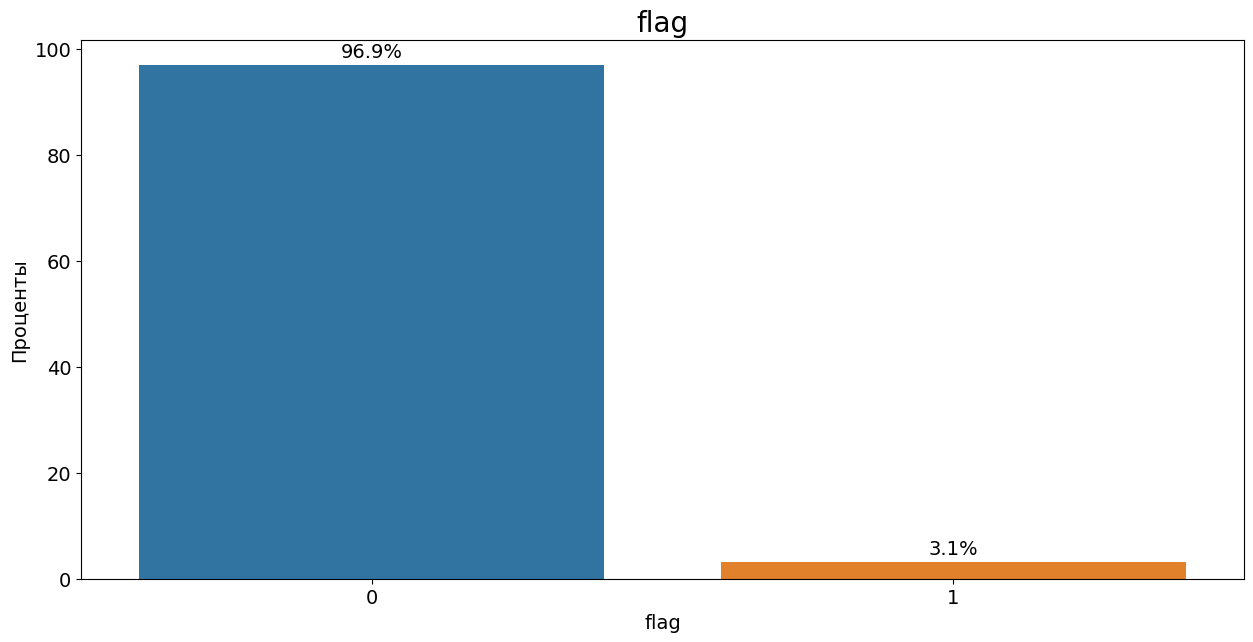

In [17]:
get_bins_target(Y, "flag")

In [18]:
df = df_X.groupby(level=0).last().join(Y) #сформируем датасет с последним кредитом клиента

In [19]:
df[:5]

rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
id                                                                    
0   10                 7                    9          2         10   
1   14                12                    6          1          8   
2    3                12                    9          4          8   
3   15                12                    9          2         10   
4    1                12                    9          4          8   

    pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
id                                                             
0                 8                8                      16   
1                14               11                      11   
2                 1               11                       1   
3                 8                8                      17   
4                 1               11                      12   

    pre_loans_next_pay_summ  pre_loans_outstanding  ...  enc_paym_22  \
id                                                  ...                
0                         4                      2  ...            3   
1                         2                      3  ...            3   
2                         1                      4  ...            3   
3                         1                      2  ...            3   
4                         1                      3  ...            3   

    enc_paym_23  enc_paym_24  enc_loans_account_holder_type  \
id                                                            
0             3            4                              1   
1             3            4                              1   
2             3            4                              1   
3             3            4                              1   
4             3            4                              1   

    enc_loans_credit_status  enc_loans_credit_type  enc_loans_account_cur  \
id                                                                          
0                         2                      4                      1   
1                         2                      3                      1   
2                         2                      3                      1   
3                         2                      4                      1   
4                         2                      3                      1   

    pclose_flag  fclose_flag  flag  
id                                  
0             0            0     0  
1             0            1     0  
2             1            1     0  
3             0            0     0  
4             1            1     0  

[5 rows x 60 columns]

In [20]:
df.shape

(250000, 60)

#### Выводы

- В данных нет пропусков  
- Все первичные признаки закодированы и приведены к типу int  
- Датасет имеет выраженный дисбаланс классов  
- Среднее кол-во записей в кредитной истории клиента - 6-7  
- Признак pre_loans_total_overdue не является информативным, так как имеет 1 уникальное значение (удален)
- Все признаки отмасштабированы

P.S. В данных есть переменные, которые необходимо привести к категориальному типу данных. Однако для быстроты последующих преобразований это будет сделано непосредственно перед обучением модели.

## Feature engineering

In [21]:
def add_loan(df_res: pd.DataFrame, df: pd.DataFrame, n: int):
    """
    Добавление к датафрейму n-последней операции из истории клиента путем создания новых столбцов
    :df_res: датасет, к которому добавляются столбцы
    :df: датасет со всеми операциями
    :n: номер операции начиная с последней
    """
    df_zeros = pd.DataFrame(index=range(df_res.shape[0]), 
                            columns=df.columns, 
                            data=np.zeros((df_res.shape[0], df.shape[1])))
    df_zeros.update(df.groupby(level=0).nth(-n))

    return df_res.join(df_zeros, rsuffix=f'_{n}')

In [22]:
df = add_loan(df, df_X.iloc[:,1:], 2)
df = add_loan(df, df_X.iloc[:,1:], 3)
df = add_loan(df, df_X.iloc[:,1:], 4)

In [23]:
df[:5]

rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
id                                                                    
0   10                 7                    9          2         10   
1   14                12                    6          1          8   
2    3                12                    9          4          8   
3   15                12                    9          2         10   
4    1                12                    9          4          8   

    pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
id                                                             
0                 8                8                      16   
1                14               11                      11   
2                 1               11                       1   
3                 8                8                      17   
4                 1               11                      12   

    pre_loans_next_pay_summ  pre_loans_outstanding  ...  enc_paym_21_4  \
id                                                  ...                  
0                         4                      2  ...            3.0   
1                         2                      3  ...            3.0   
2                         1                      4  ...            0.0   
3                         1                      2  ...            3.0   
4                         1                      3  ...            0.0   

    enc_paym_22_4  enc_paym_23_4  enc_paym_24_4  \
id                                                
0             3.0            3.0            4.0   
1             3.0            3.0            4.0   
2             0.0            0.0            0.0   
3             3.0            3.0            4.0   
4             0.0            0.0            0.0   

    enc_loans_account_holder_type_4  enc_loans_credit_status_4  \
id                                                               
0                               1.0                        3.0   
1                               1.0                        2.0   
2                               0.0                        0.0   
3                               1.0                        2.0   
4                               0.0                        0.0   

    enc_loans_credit_type_4  enc_loans_account_cur_4  pclose_flag_4  \
id                                                                    
0                       4.0                      1.0            0.0   
1                       4.0                      1.0            0.0   
2                       0.0                      0.0            0.0   
3                       1.0                      1.0            0.0   
4                       0.0                      0.0            0.0   

    fclose_flag_4  
id                 
0             0.0  
1             0.0  
2             0.0  
3             1.0  
4             0.0  

[5 rows x 234 columns]

## Cleaning data

In [24]:
from eif import iForest

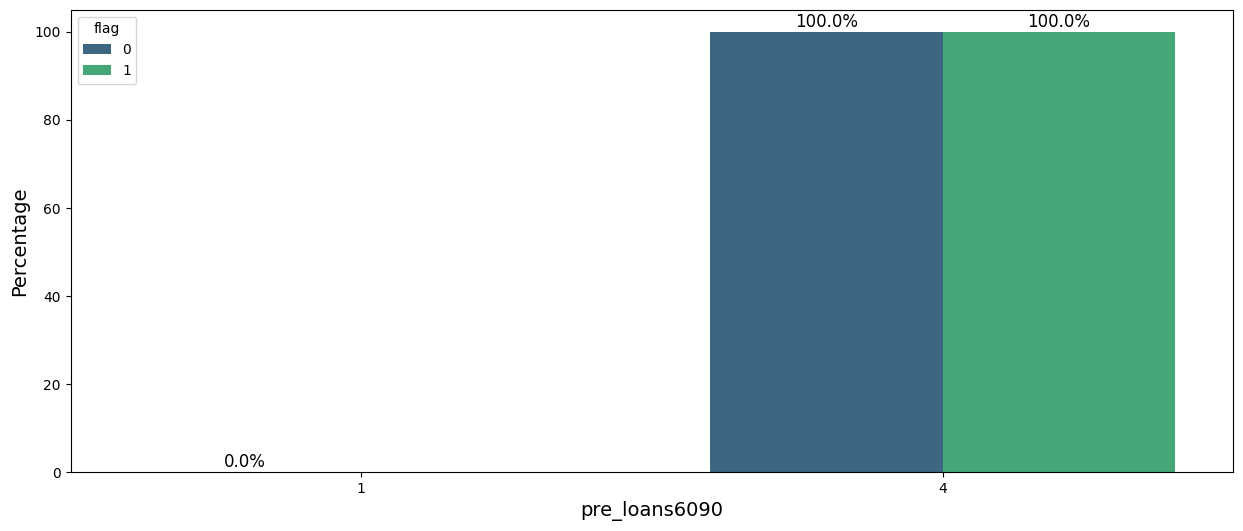

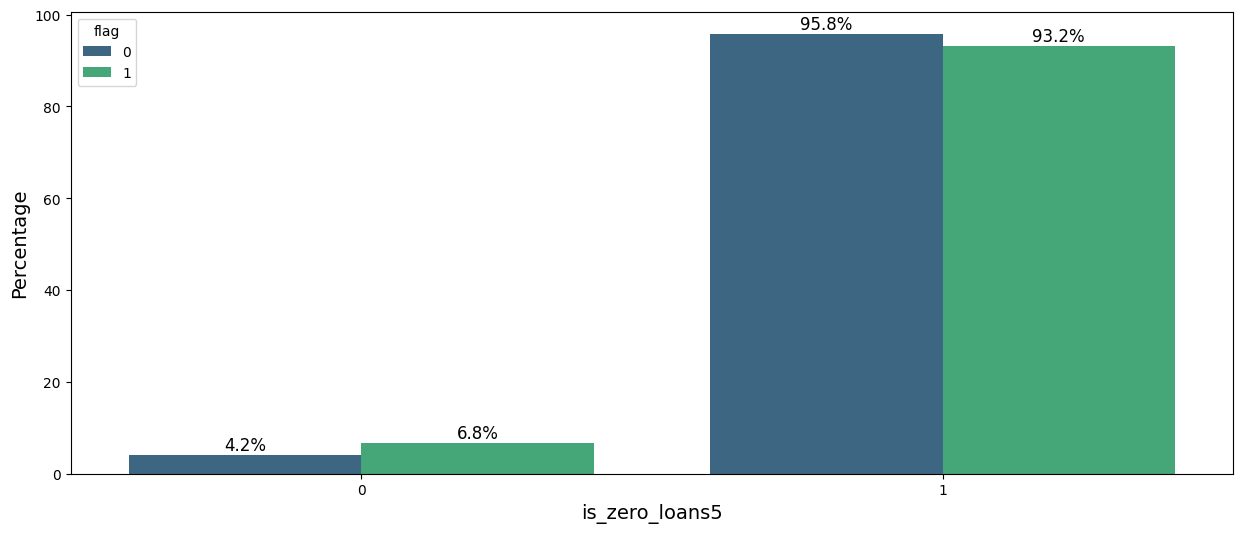

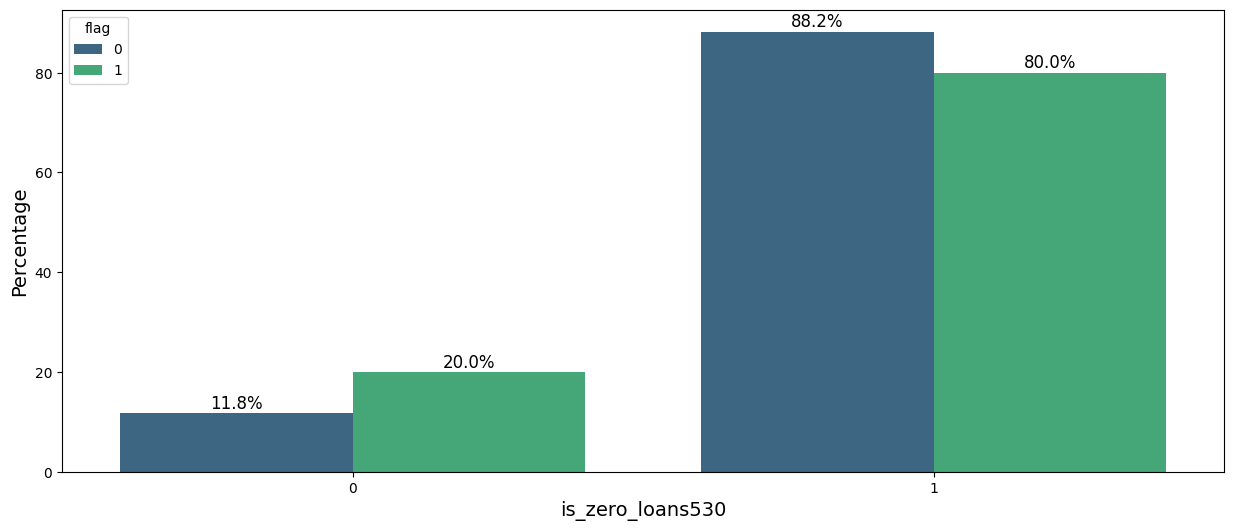

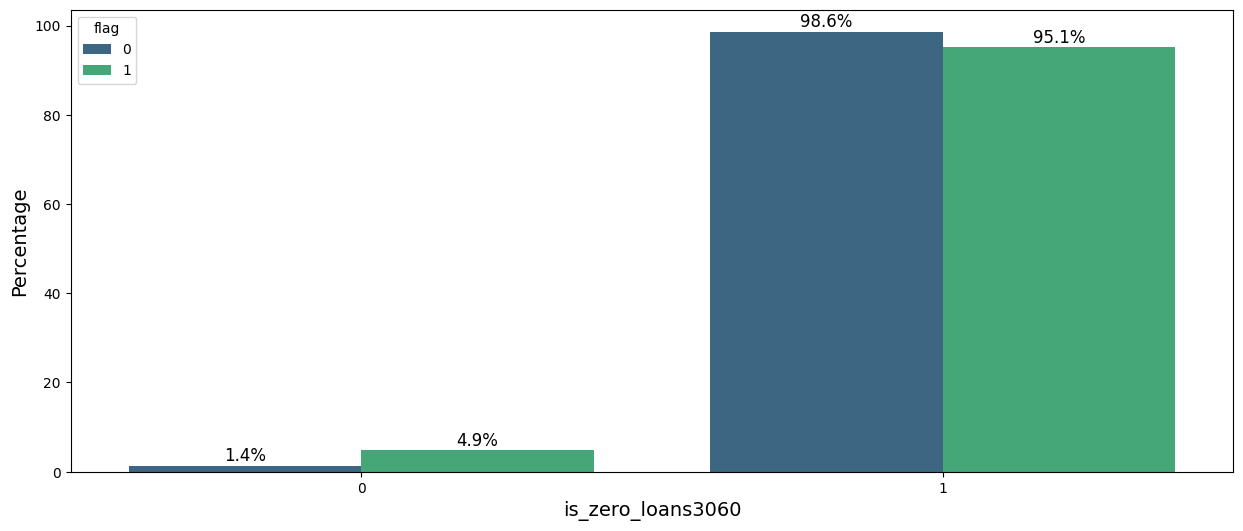

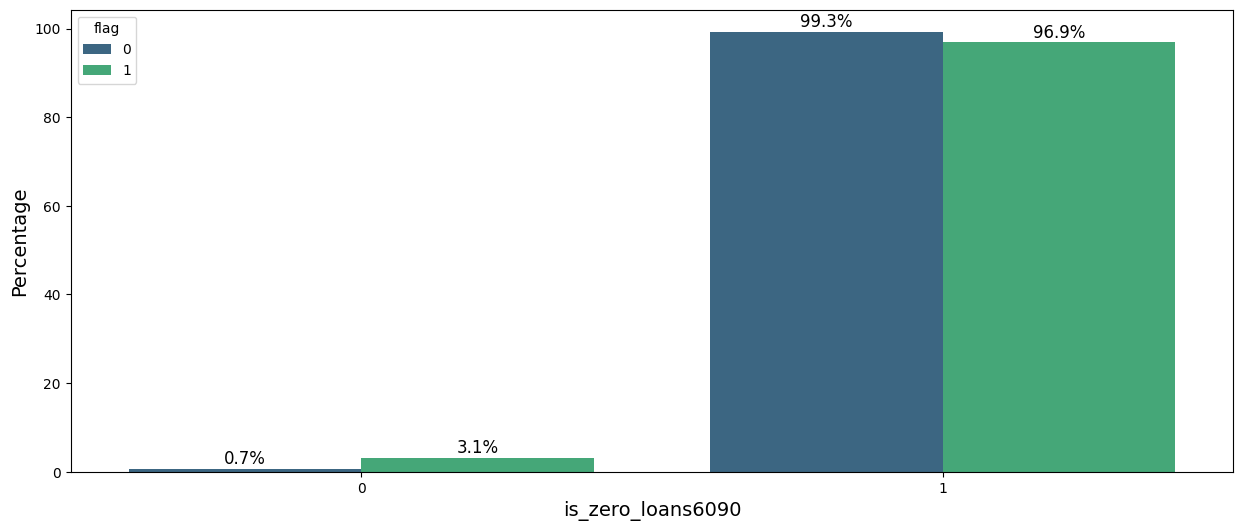

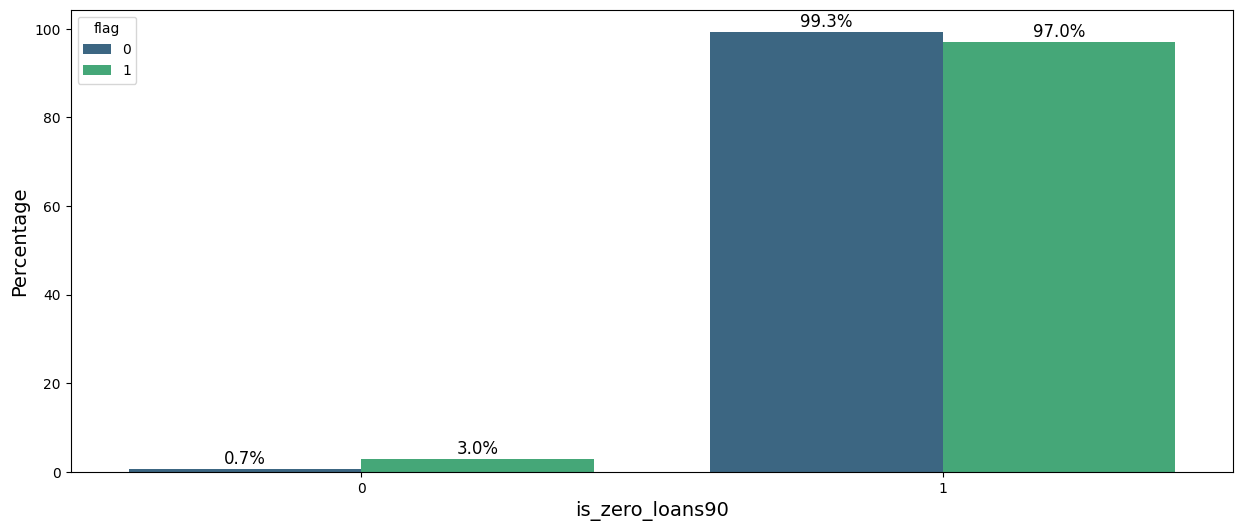

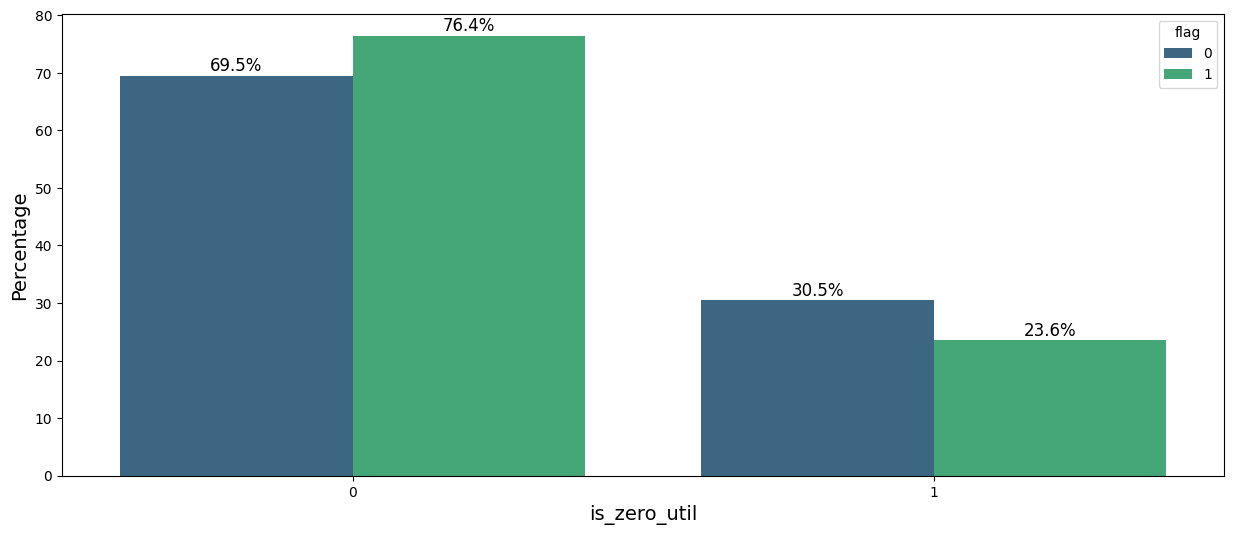

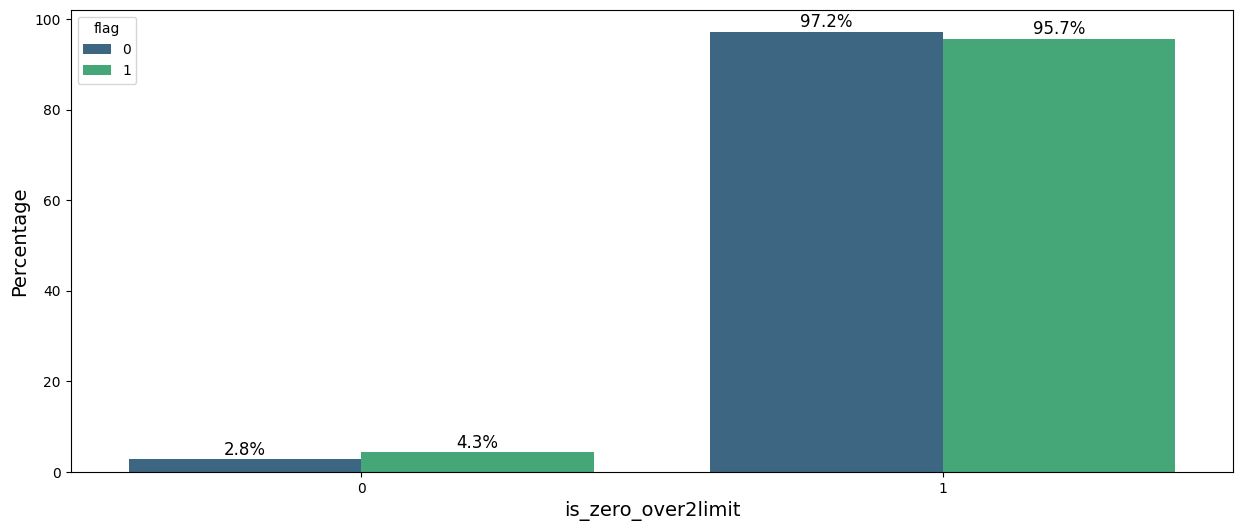

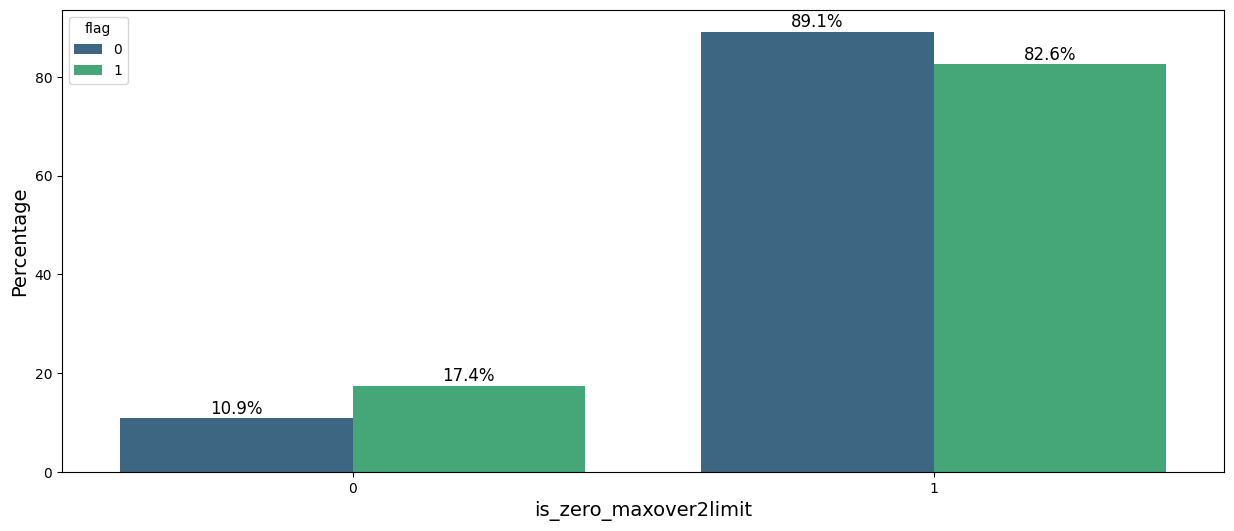

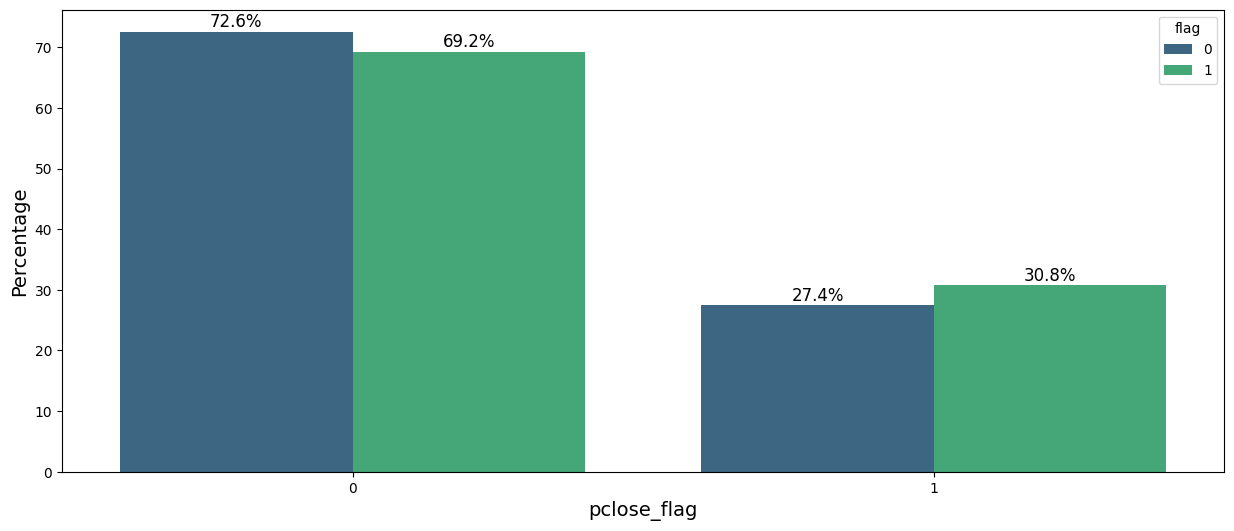

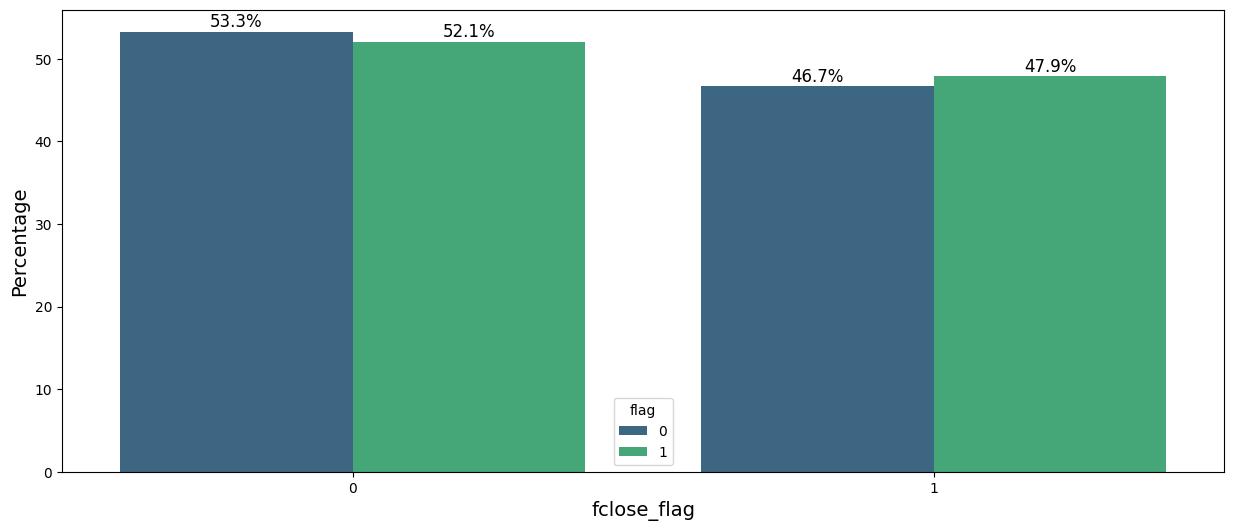

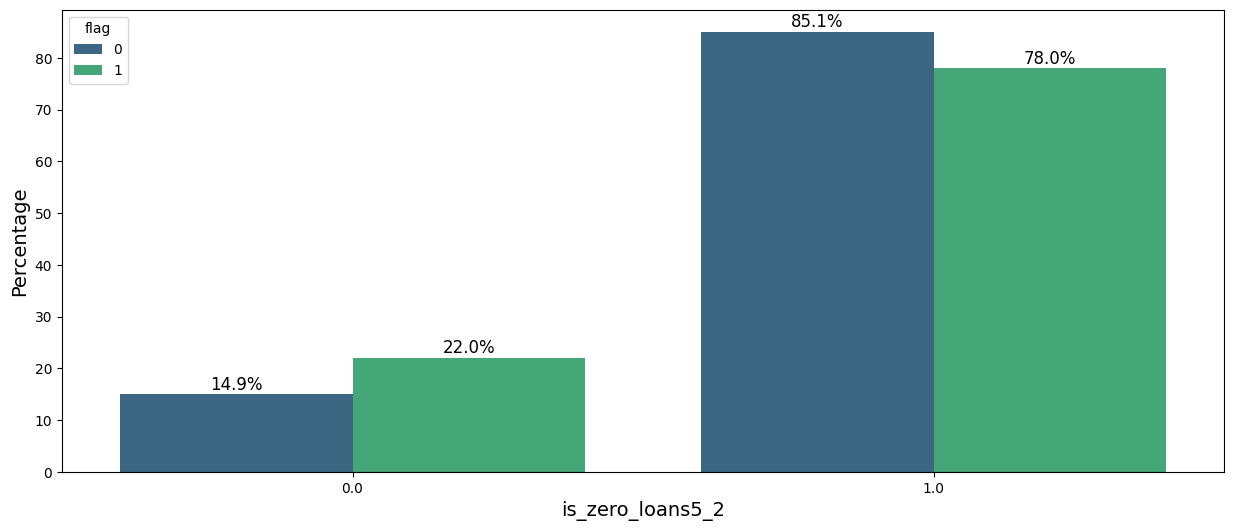

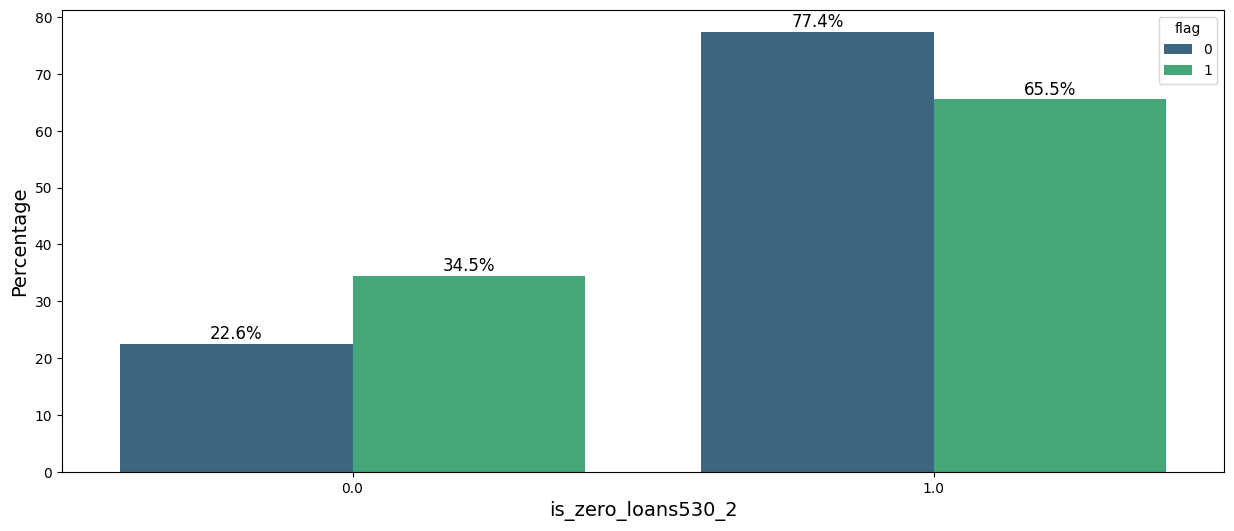

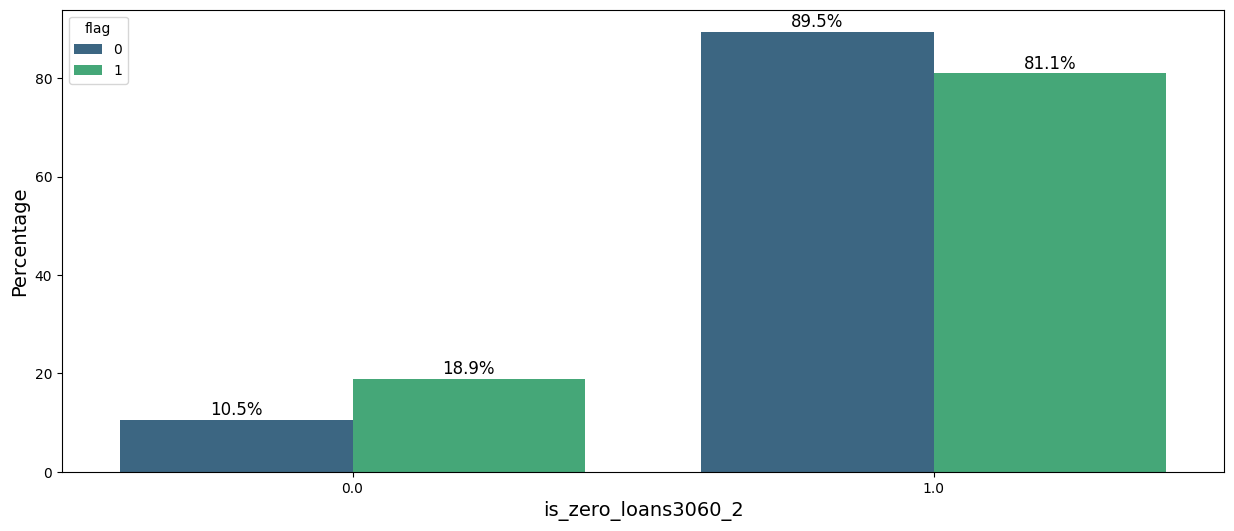

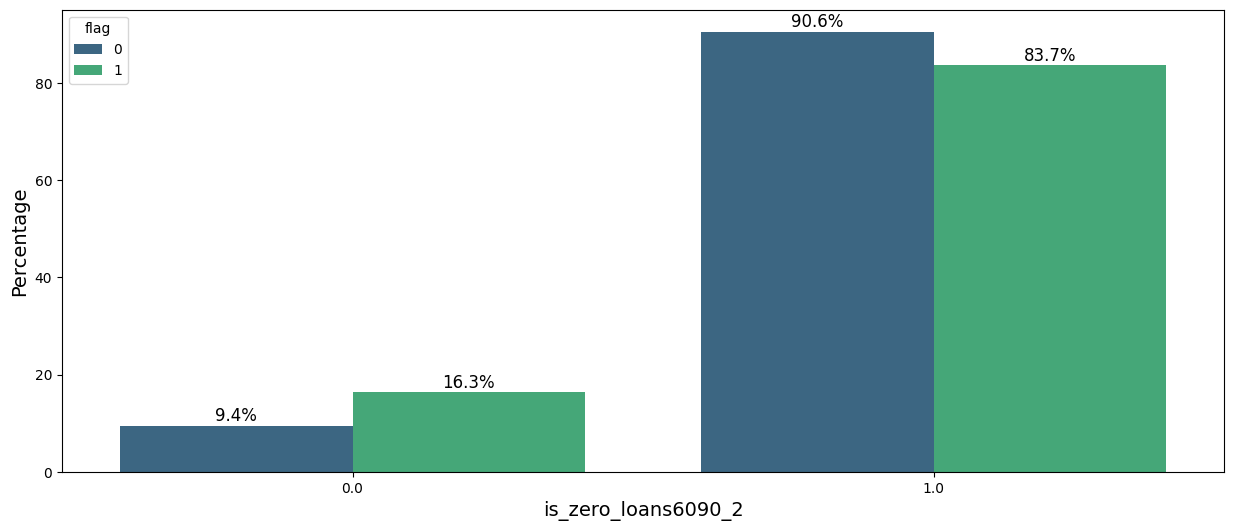

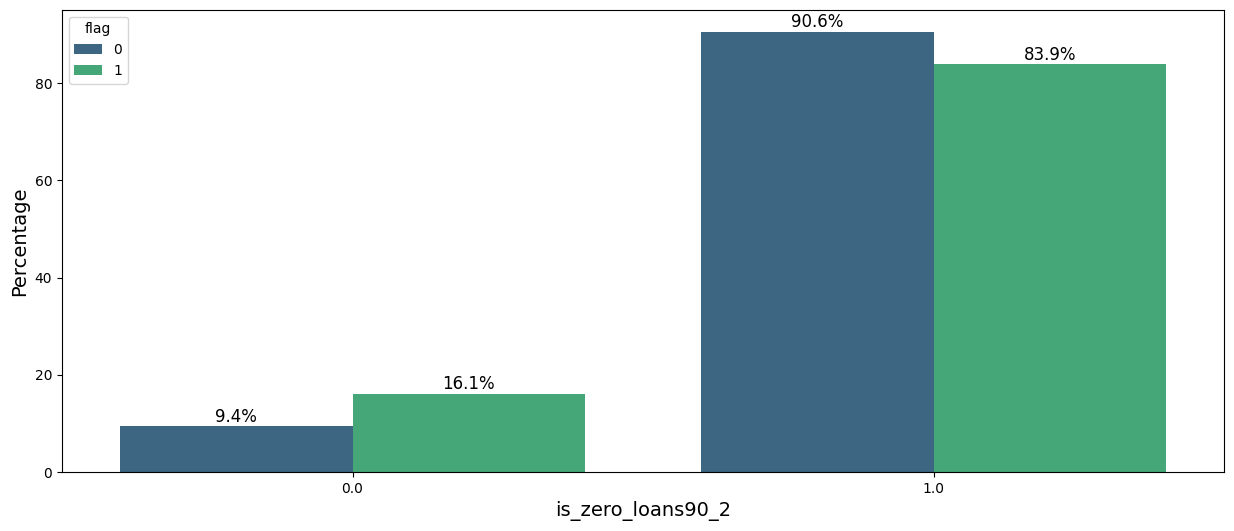

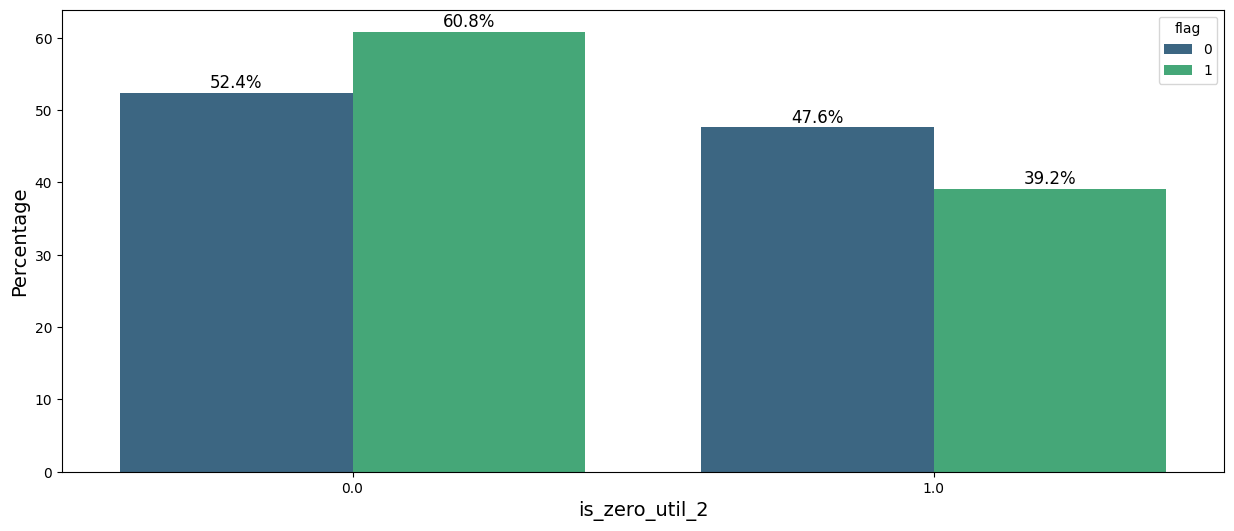

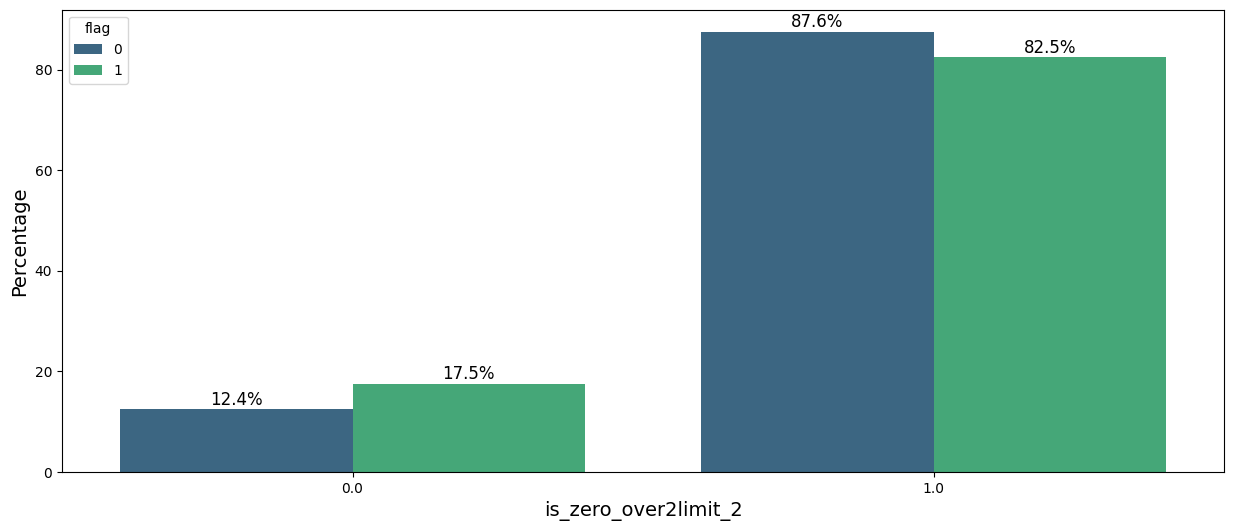

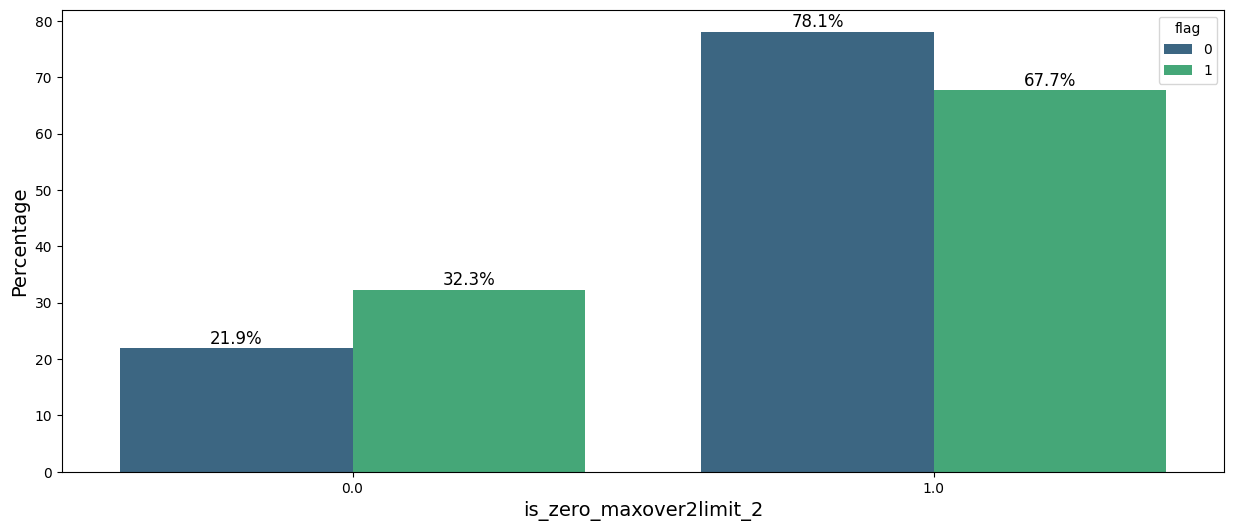

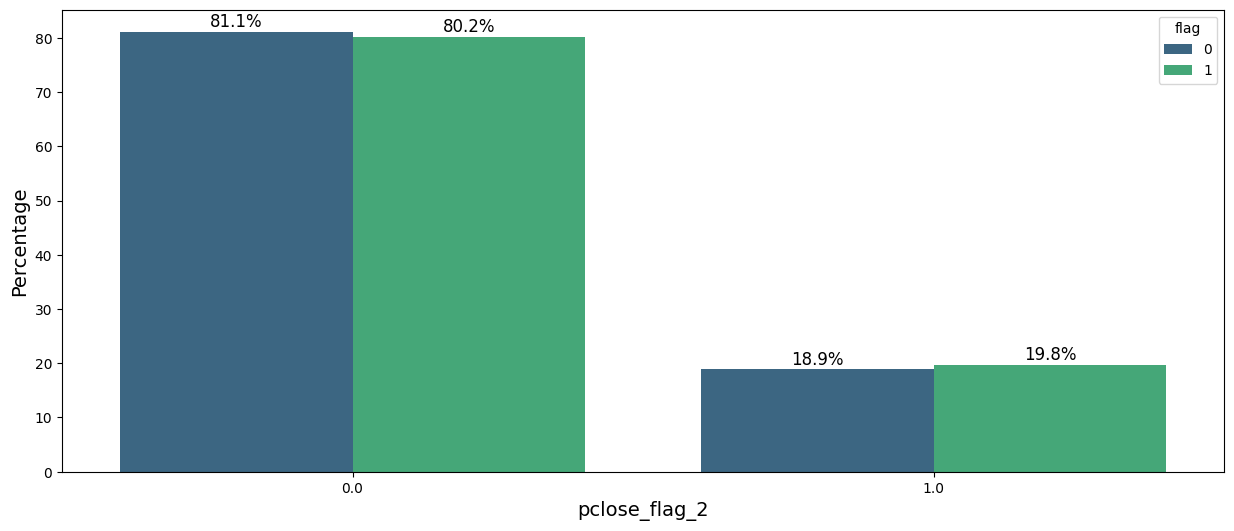

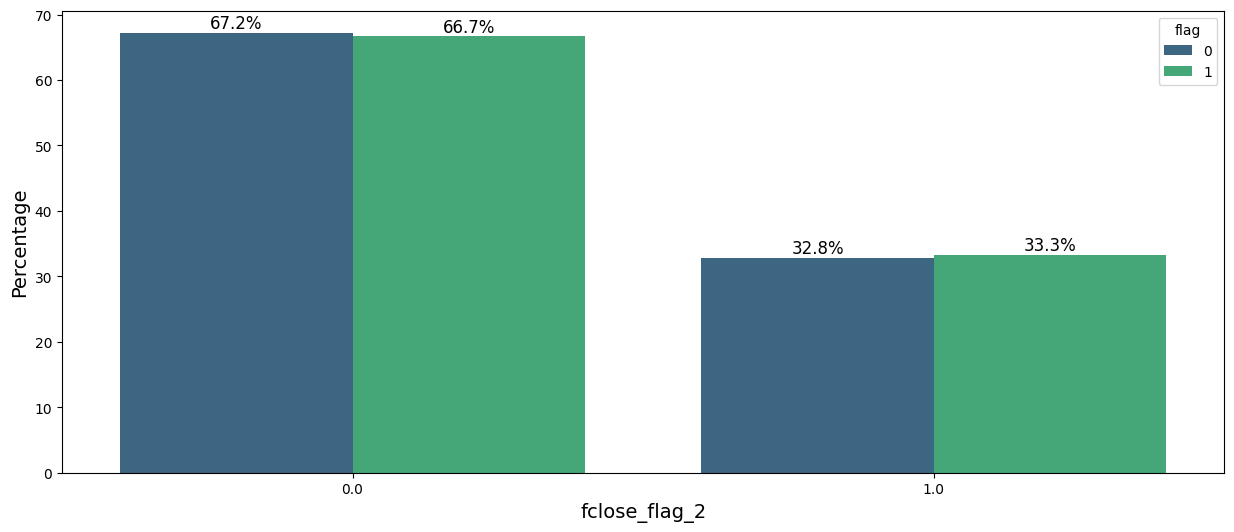

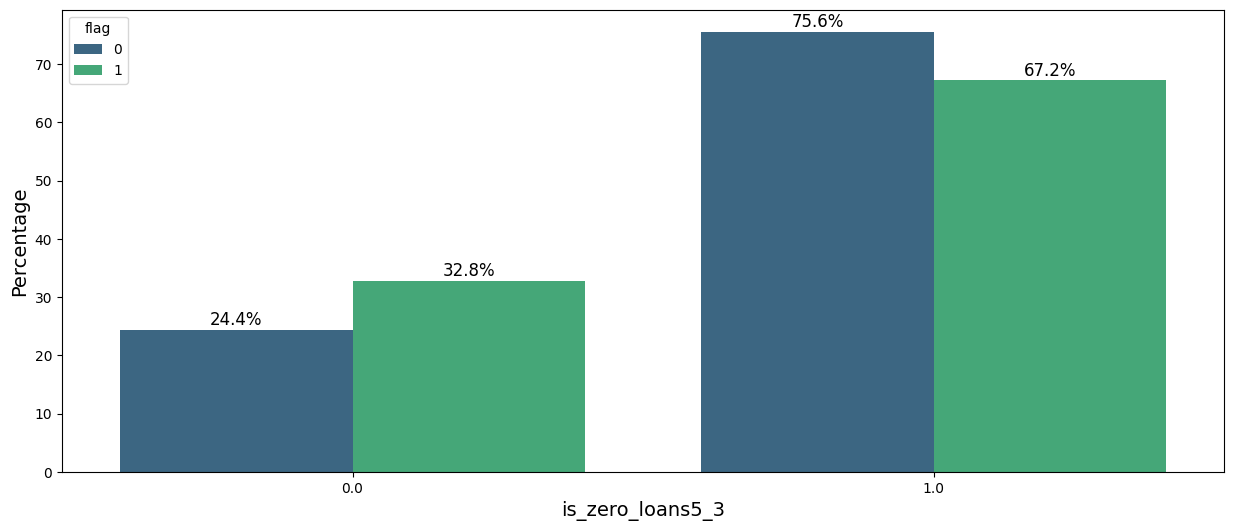

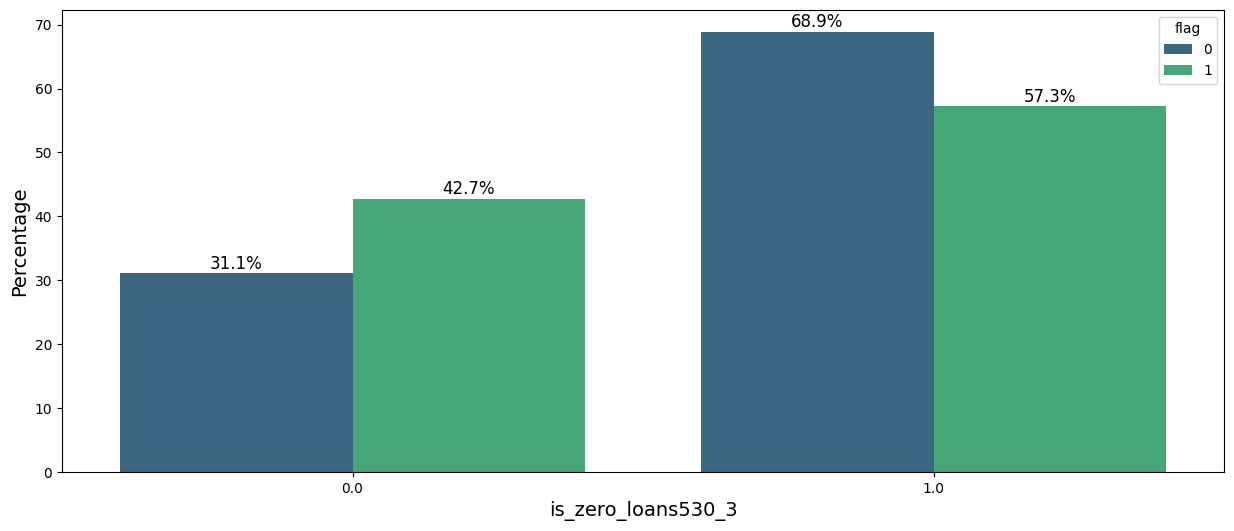

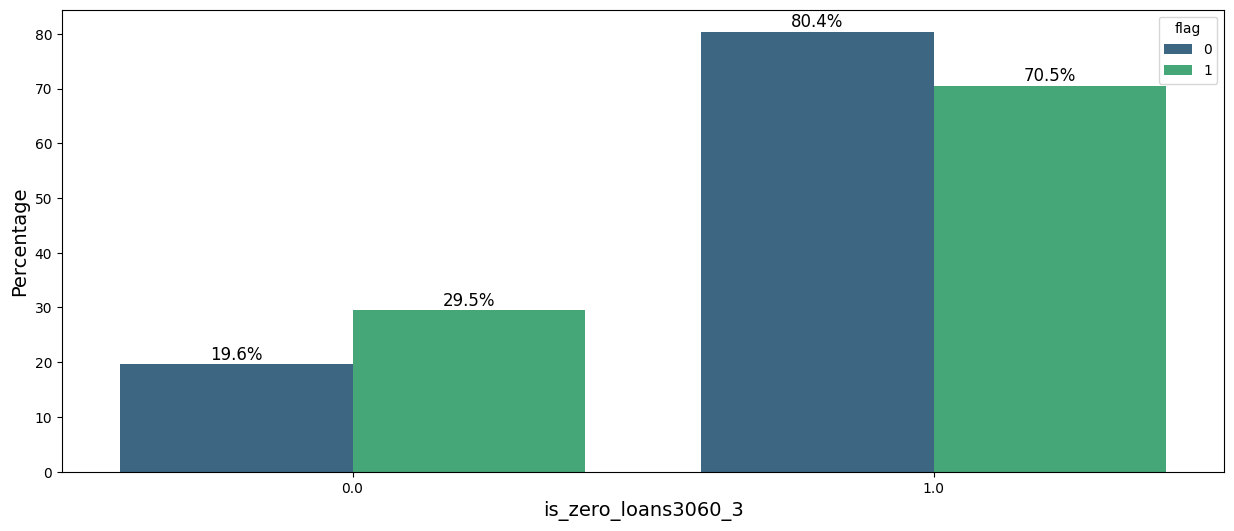

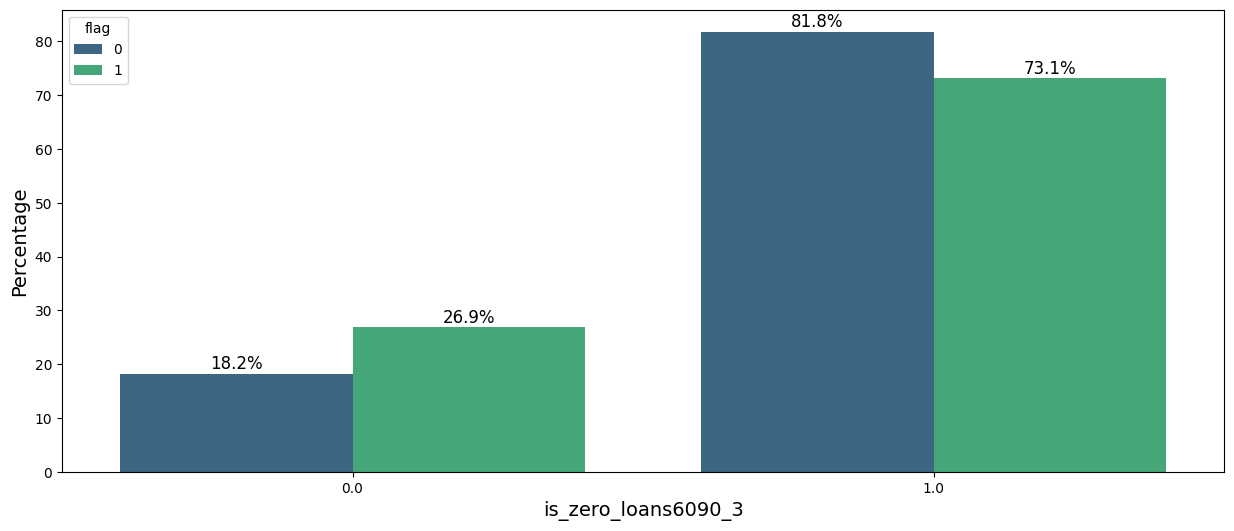

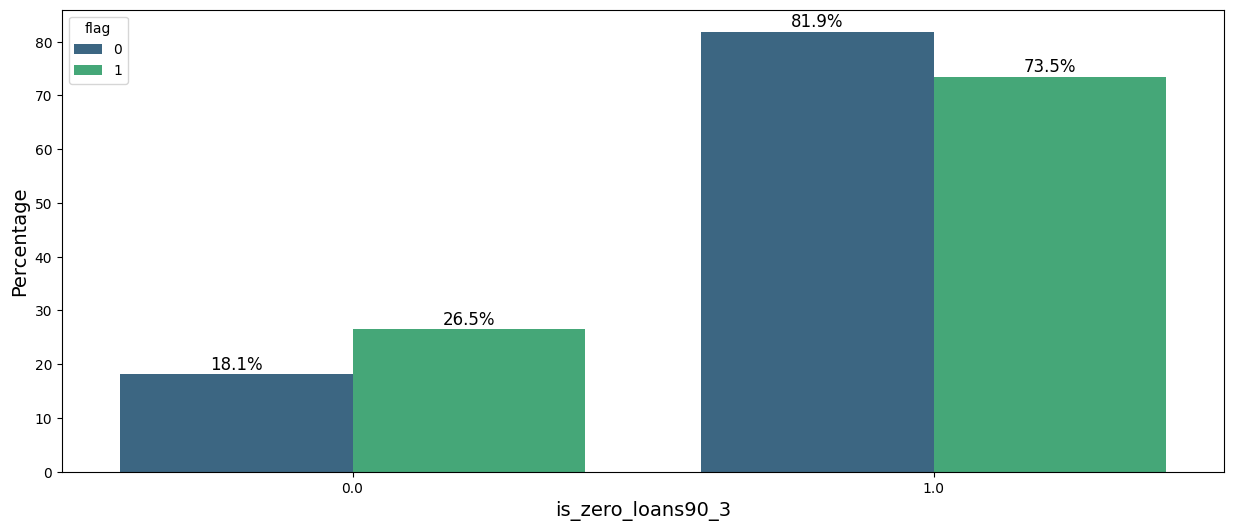

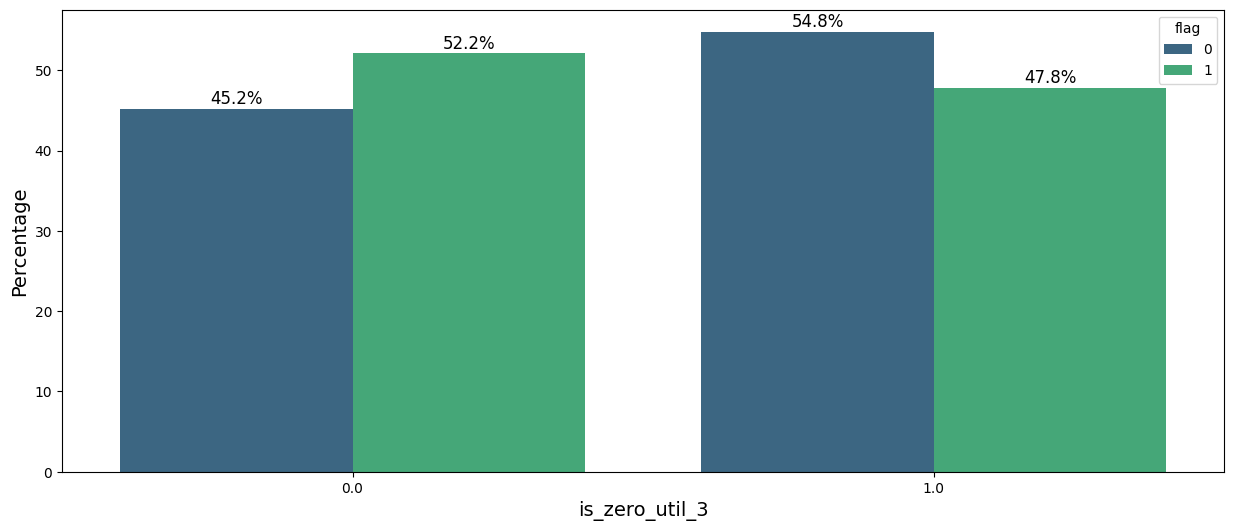

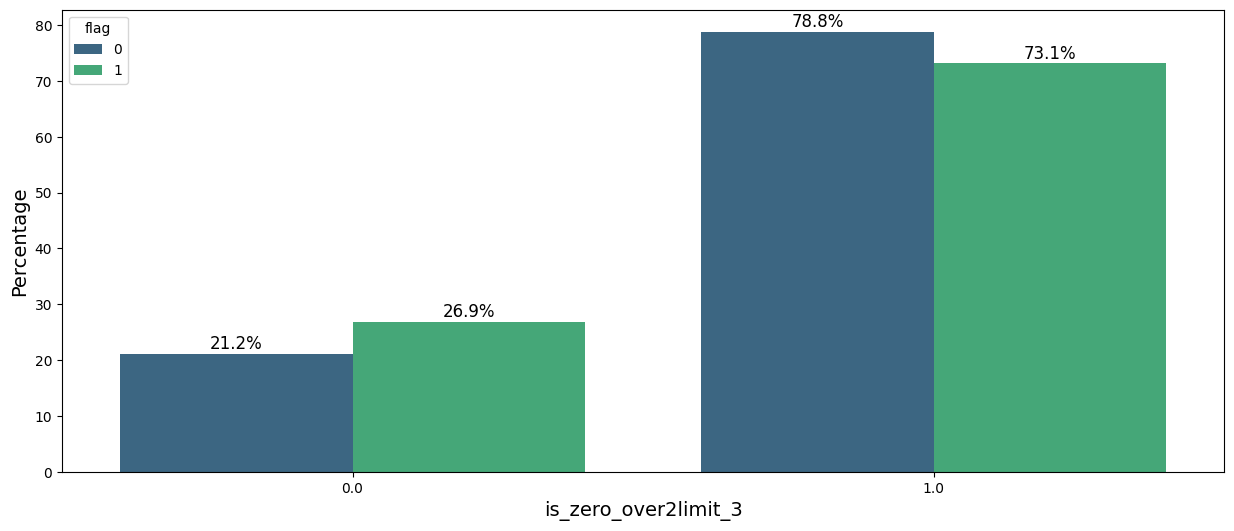

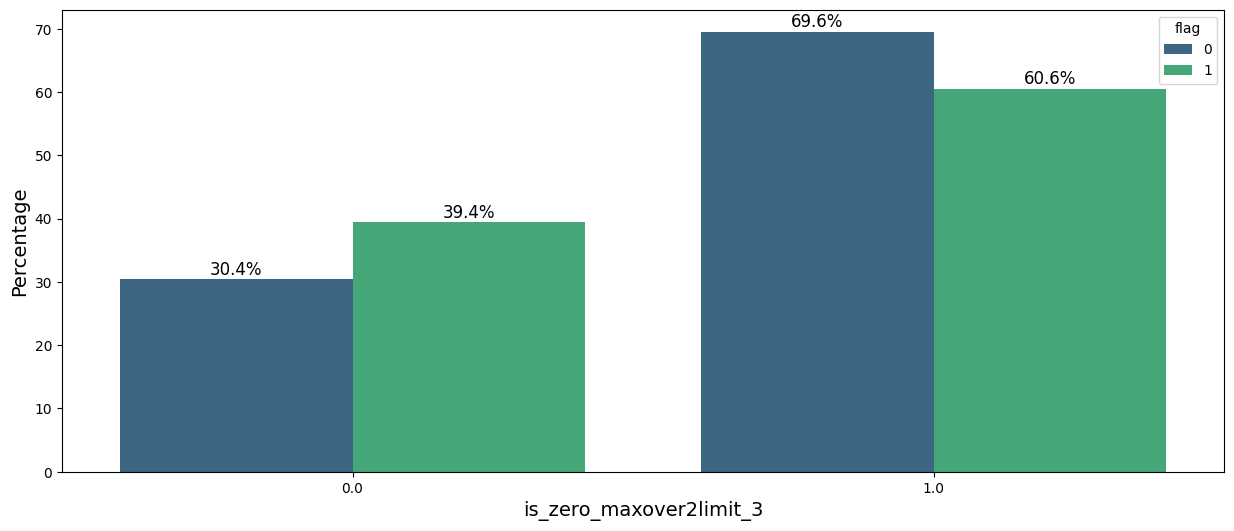

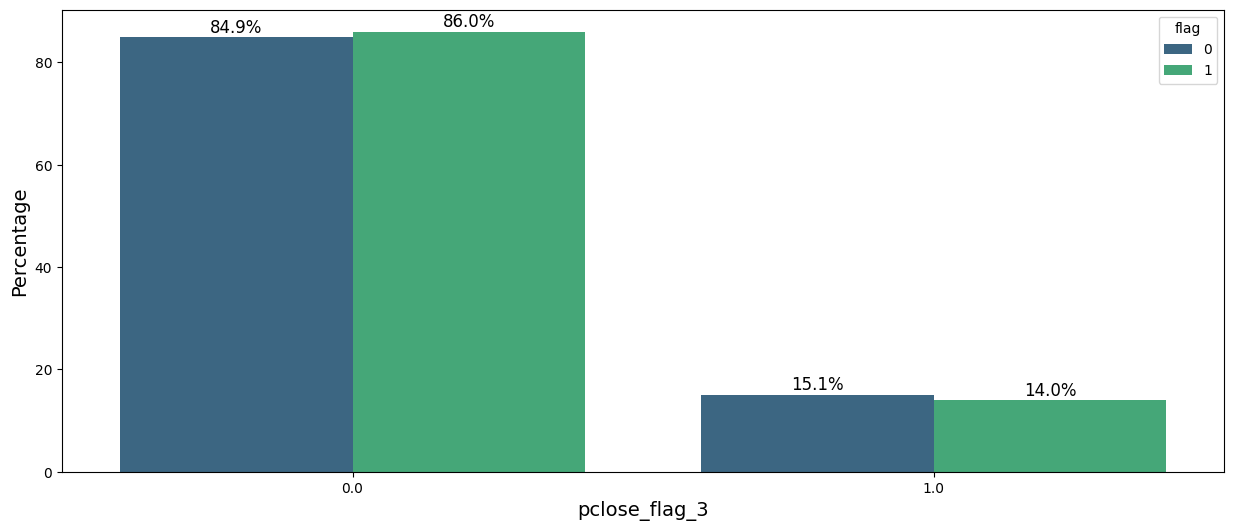

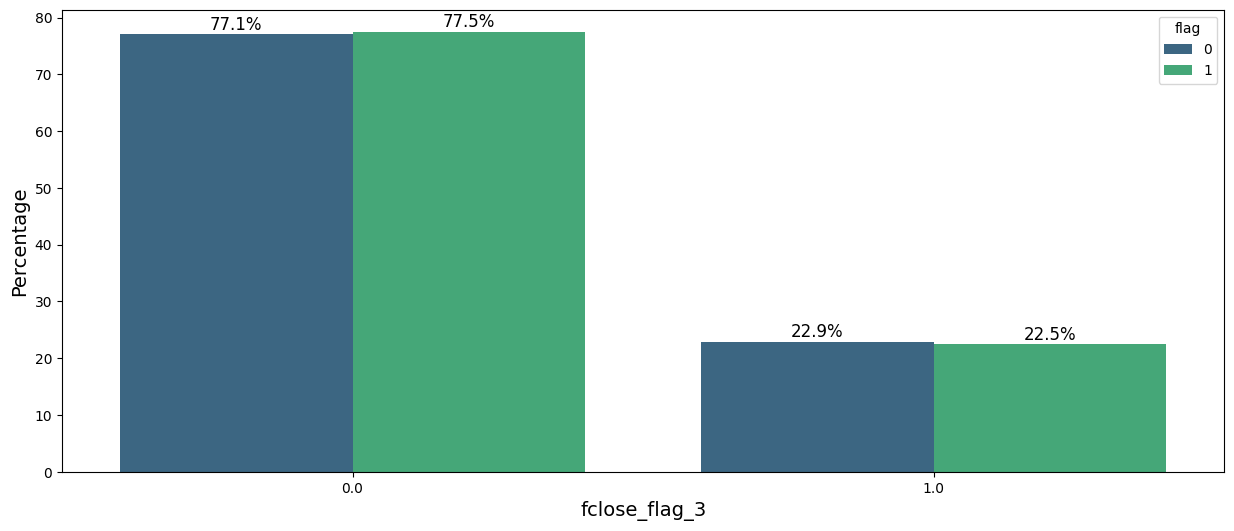

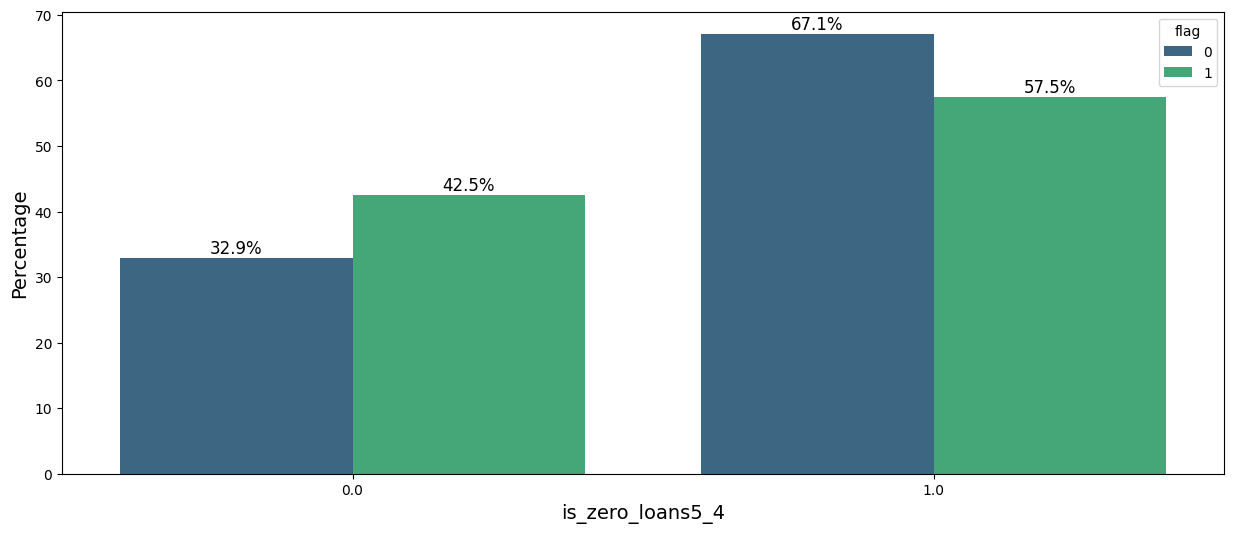

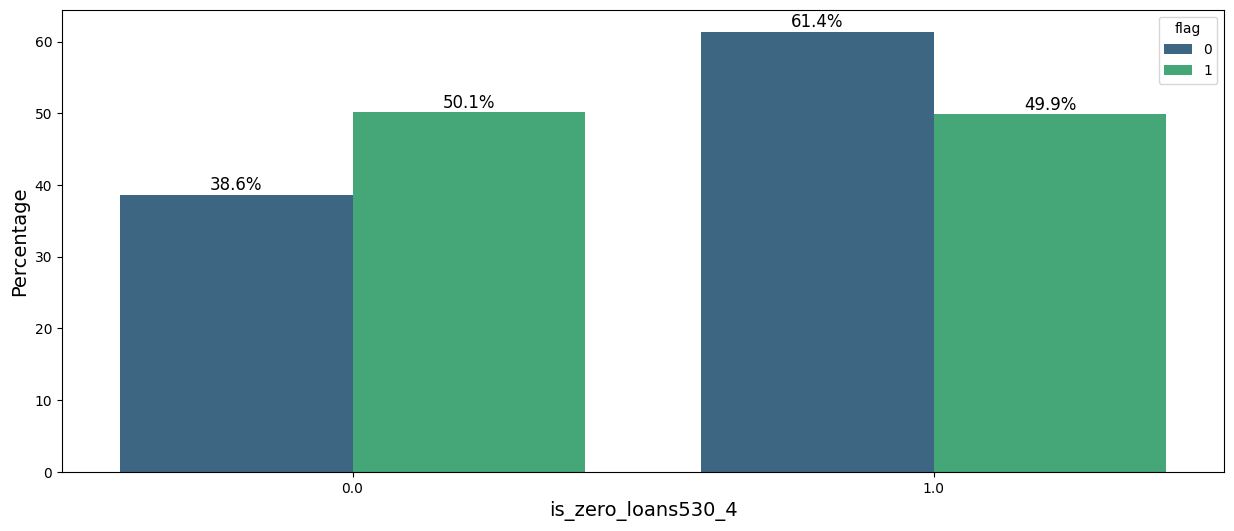

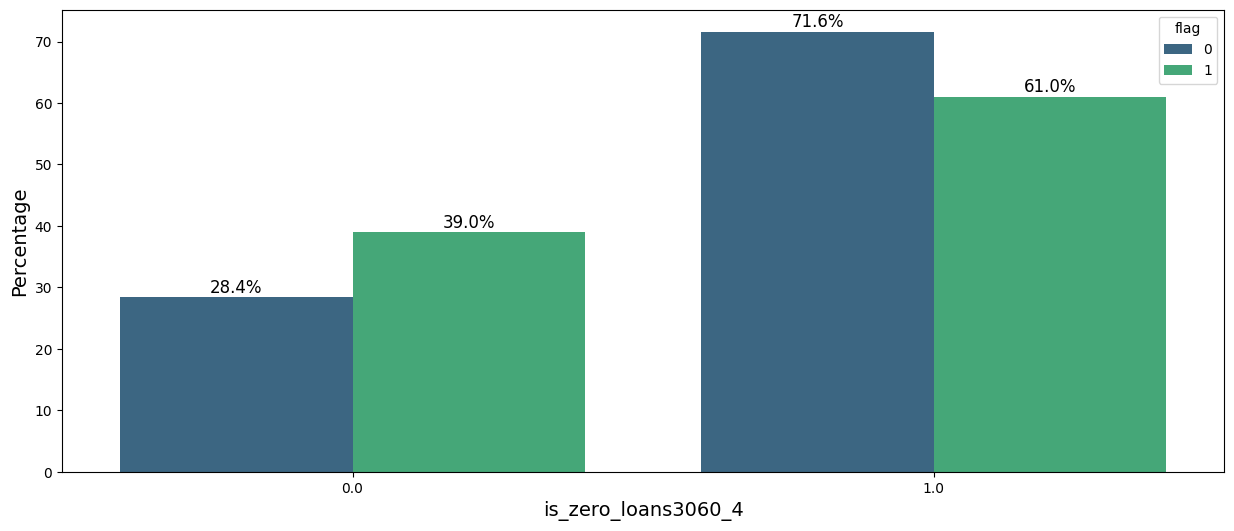

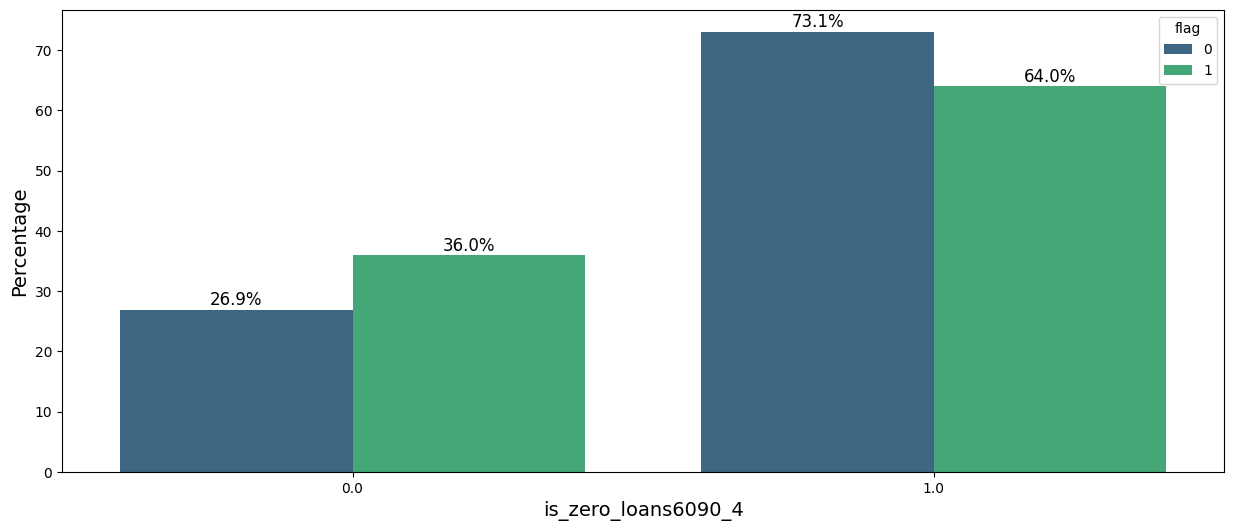

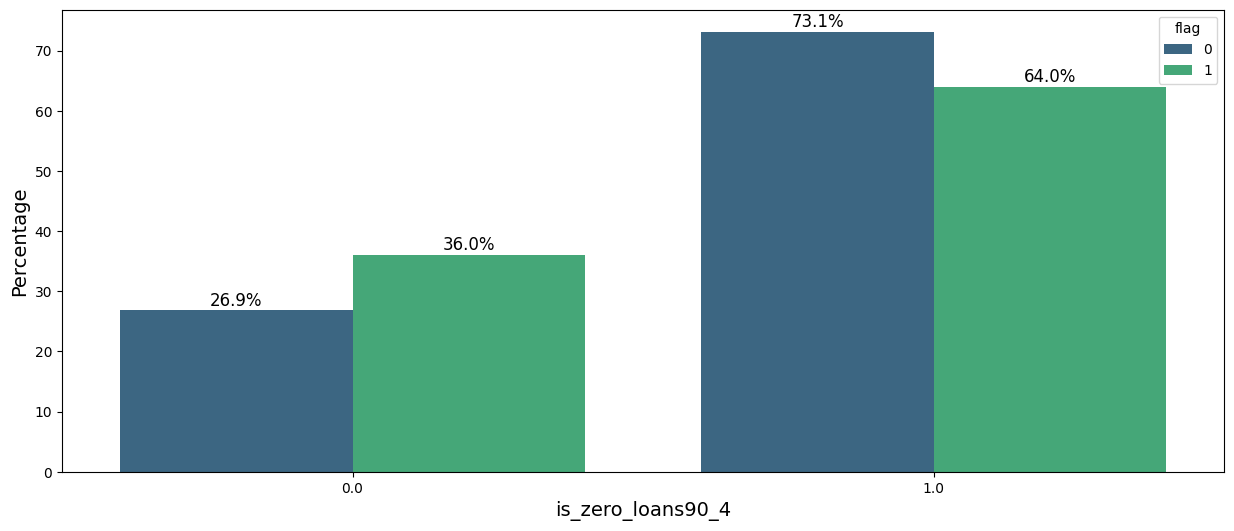

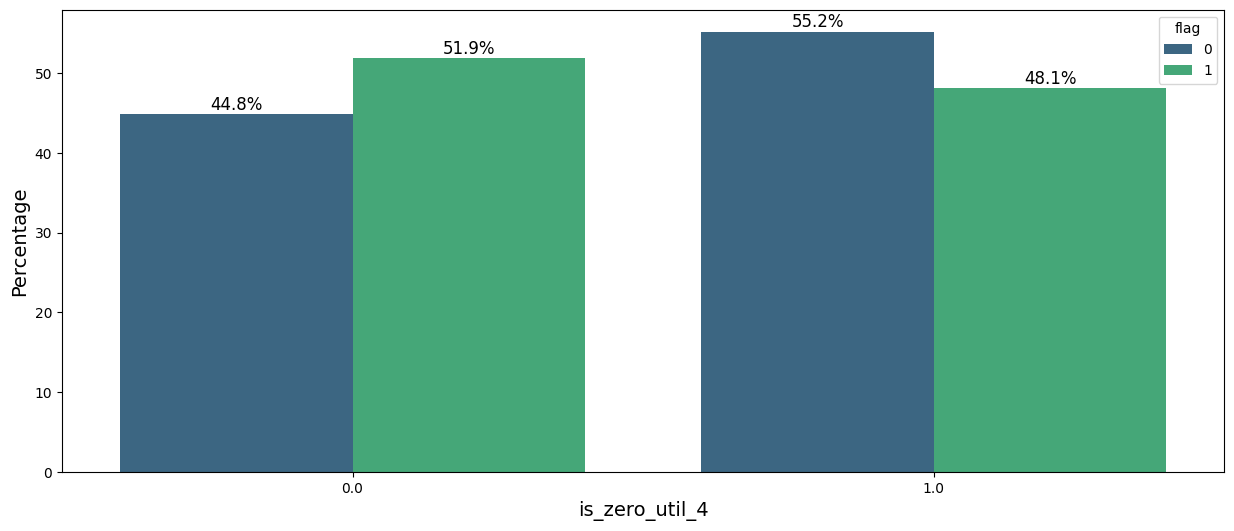

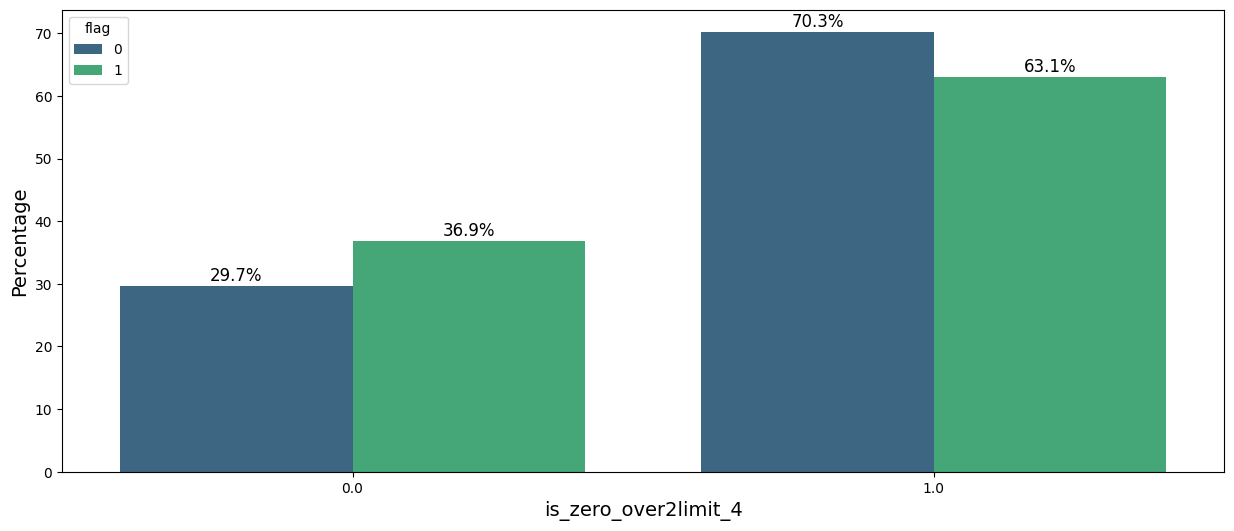

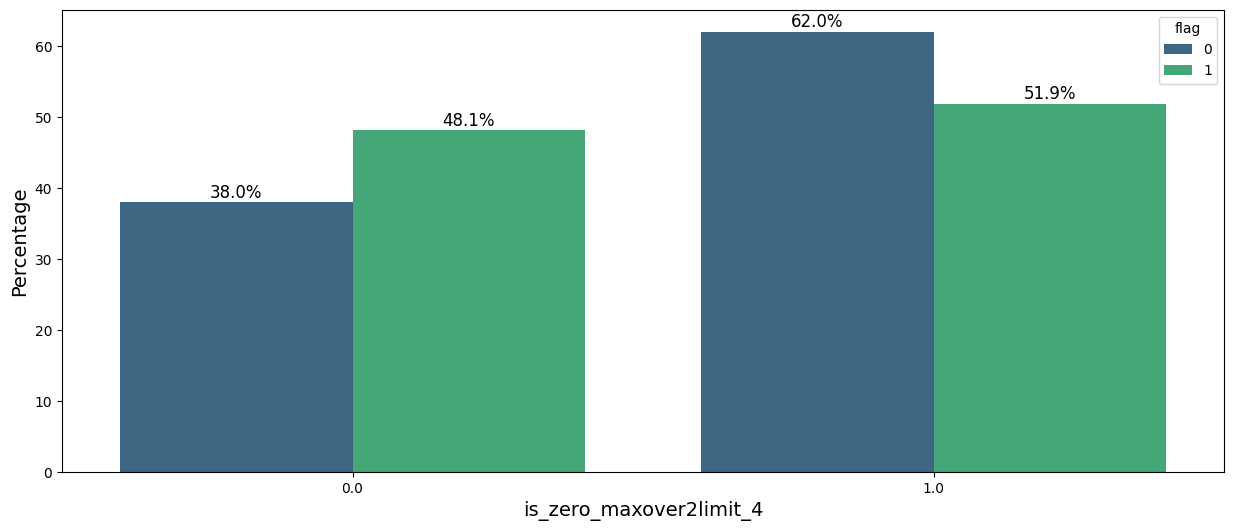

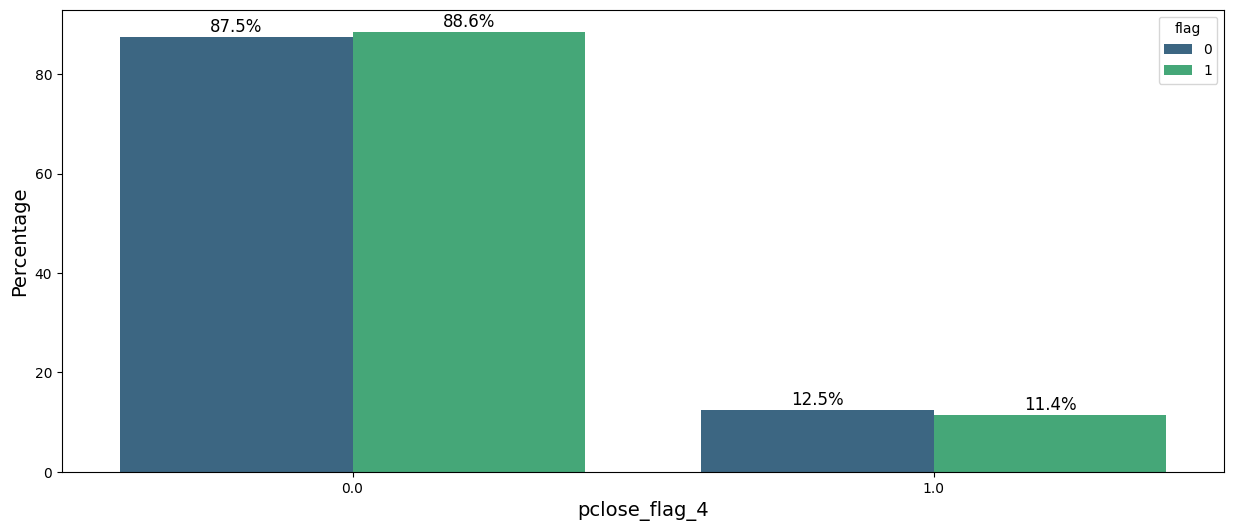

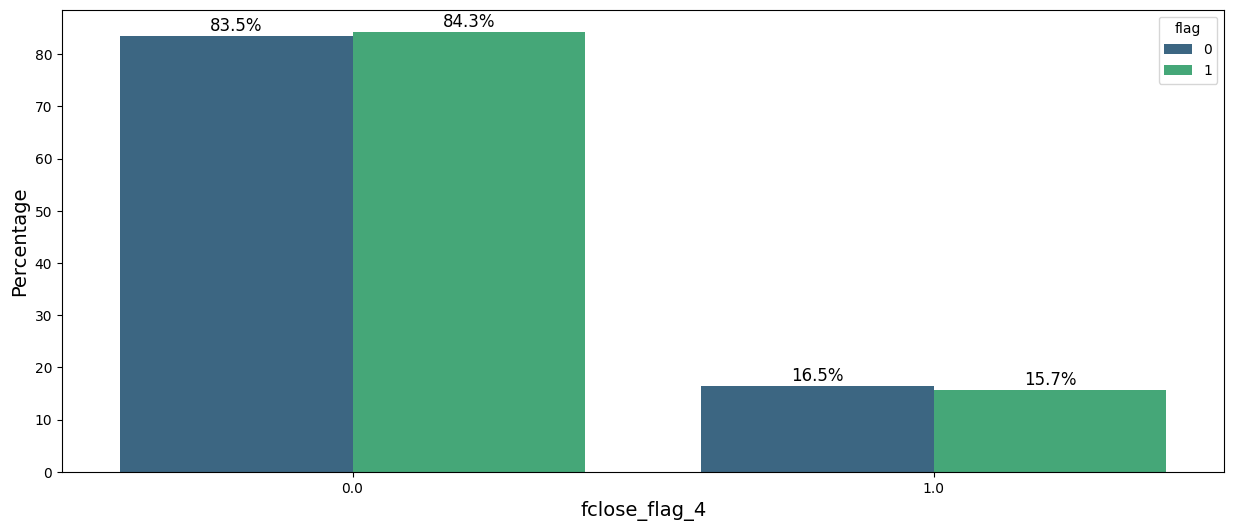

In [25]:
for col in df.nunique()[df.nunique() == 2].index:
    if col != "flag":
        barplot_group(col, "flag")

In [26]:
#Удаление неинформативных признаков и признаков, которые не влияют на целевую переменную
df = df.drop(columns=["pre_loans6090", 
                      "is_zero_loans3060",
                      "is_zero_loans6090",
                      "is_zero_loans90",
                      "is_zero_over2limit", 
                      "pclose_flag", 
                      "fclose_flag",
                      "pclose_flag_2",
                      "fclose_flag_2",
                      "pclose_flag_3",
                      "fclose_flag_3",
                      "pclose_flag_4",
                      "fclose_flag_4"])

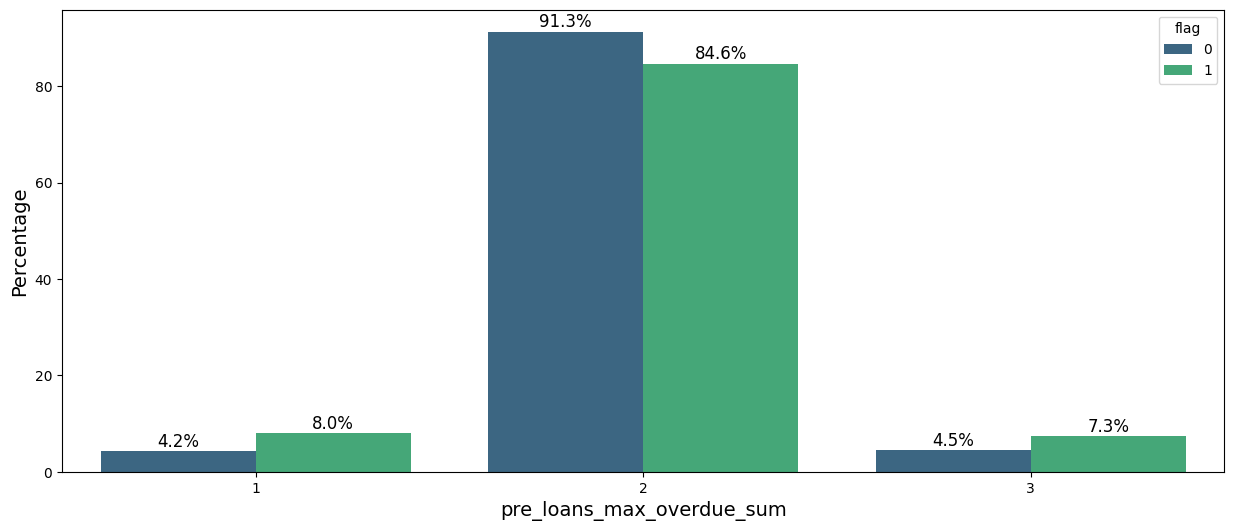

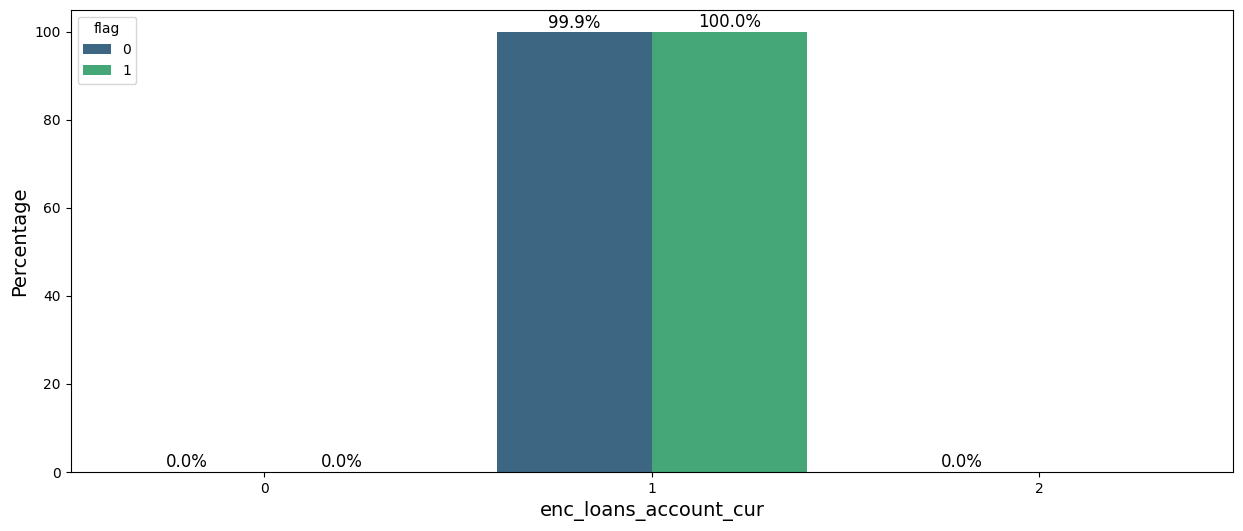

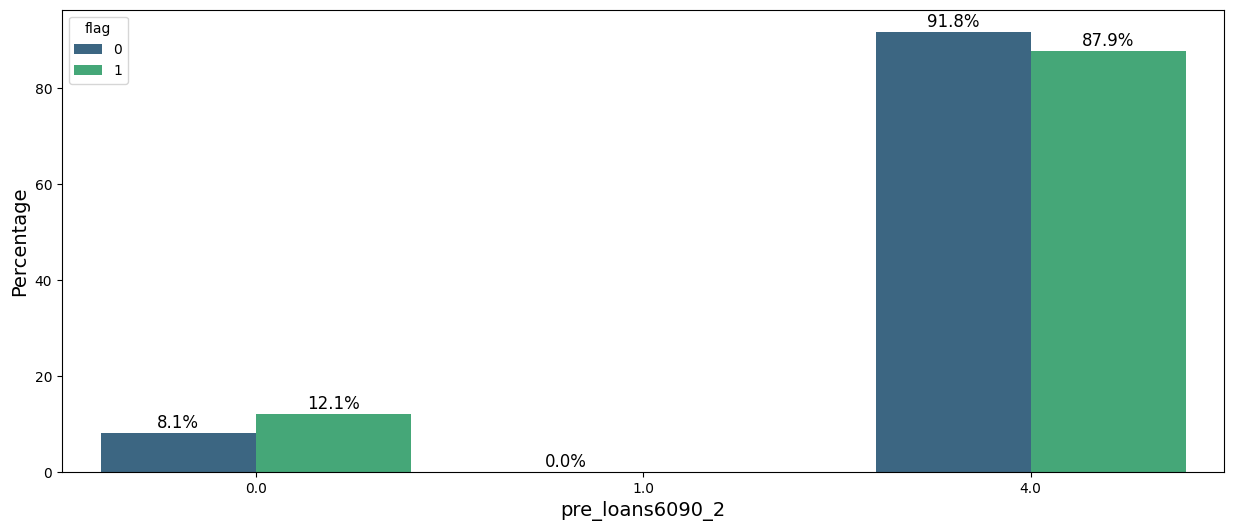

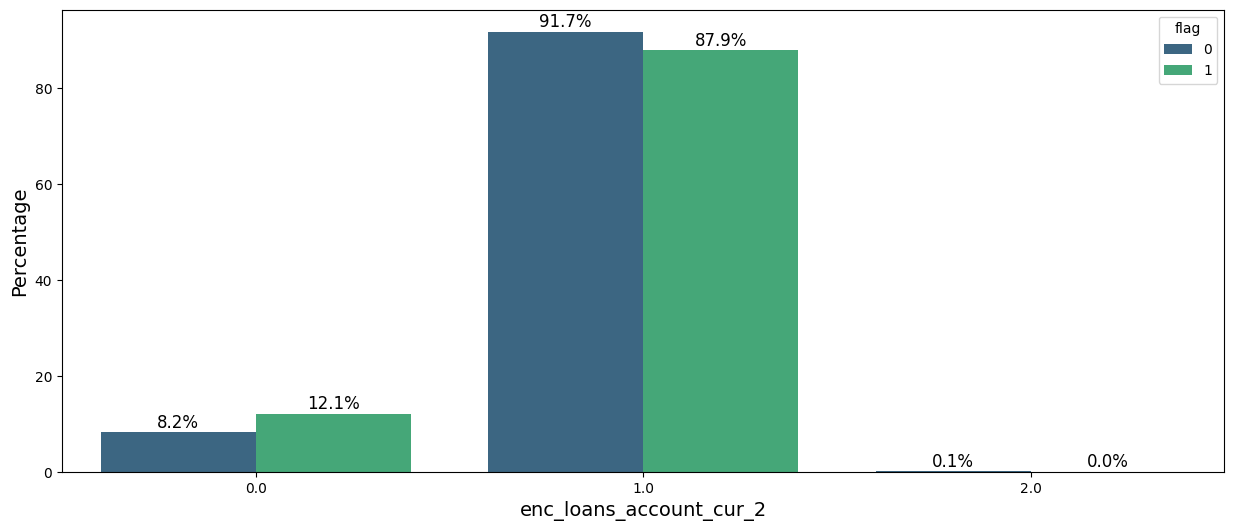

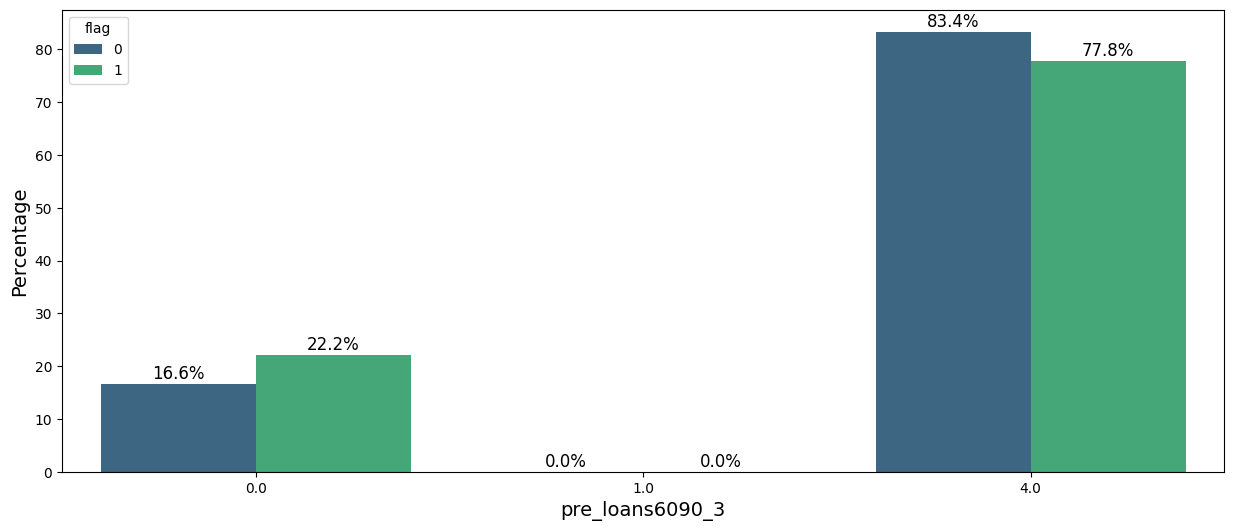

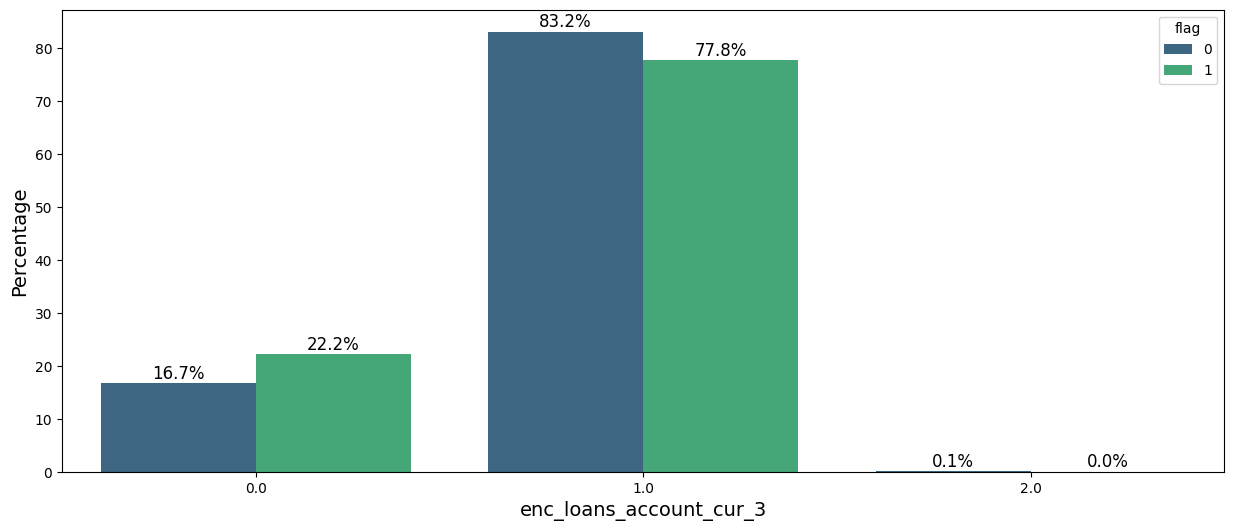

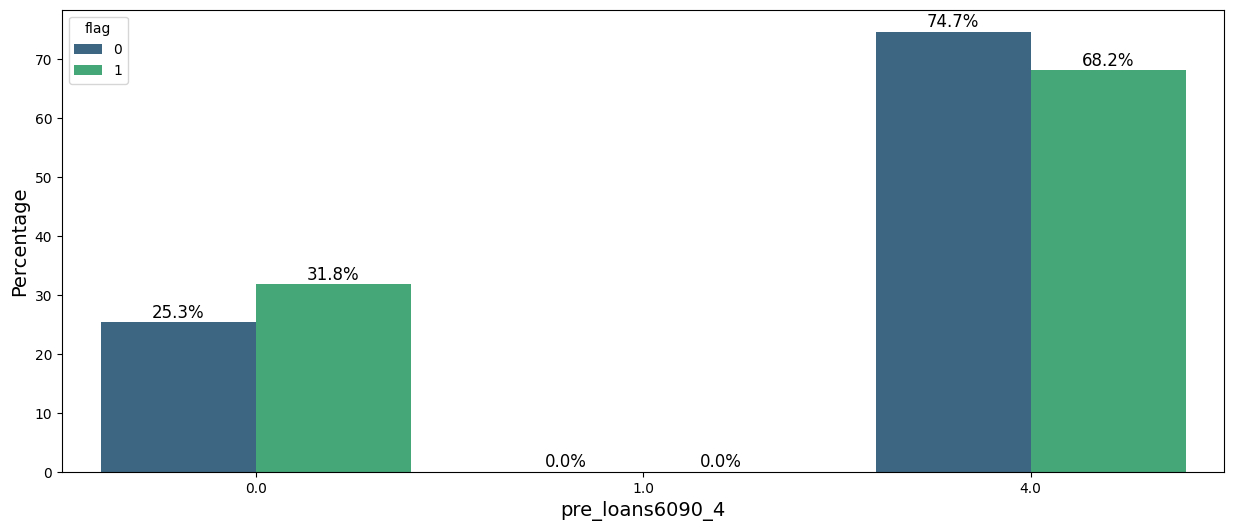

In [27]:
for col in df.nunique()[df.nunique() == 3].index:
    barplot_group(col, "flag")

In [28]:
df = df.drop(columns=["enc_loans_account_cur"])

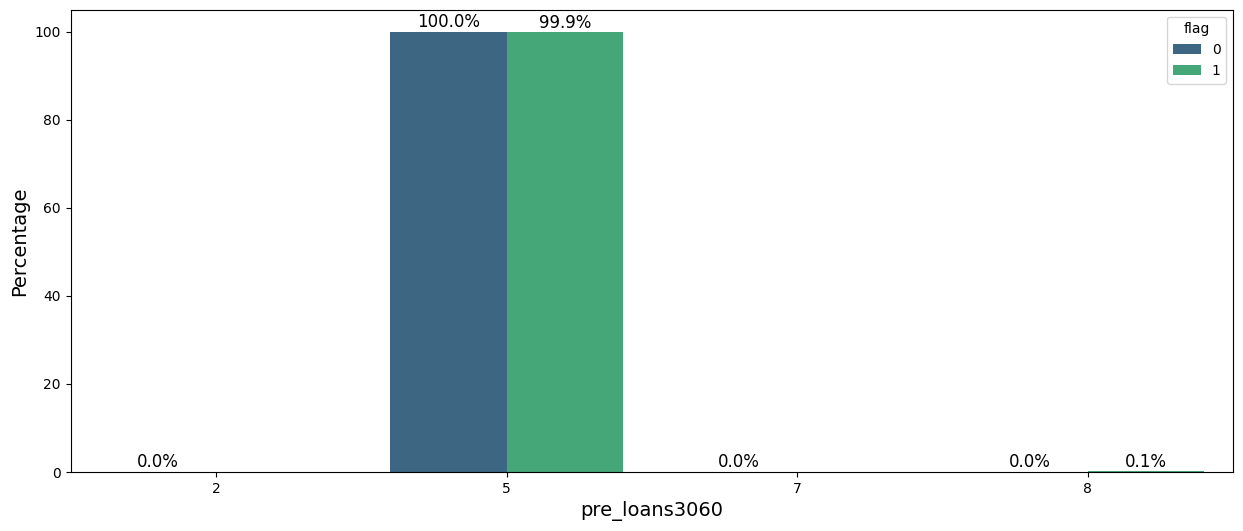

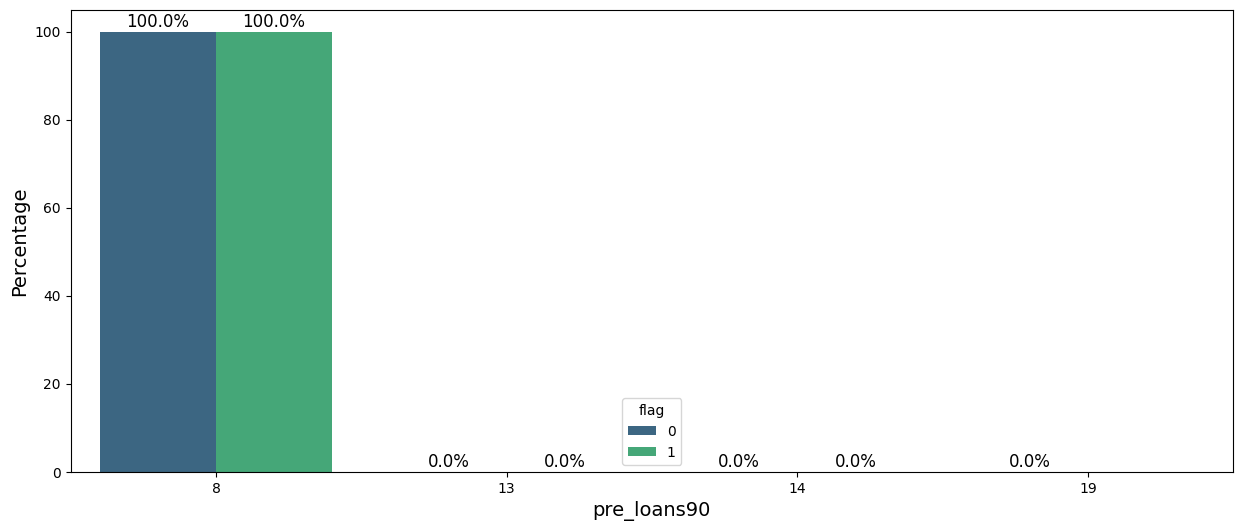

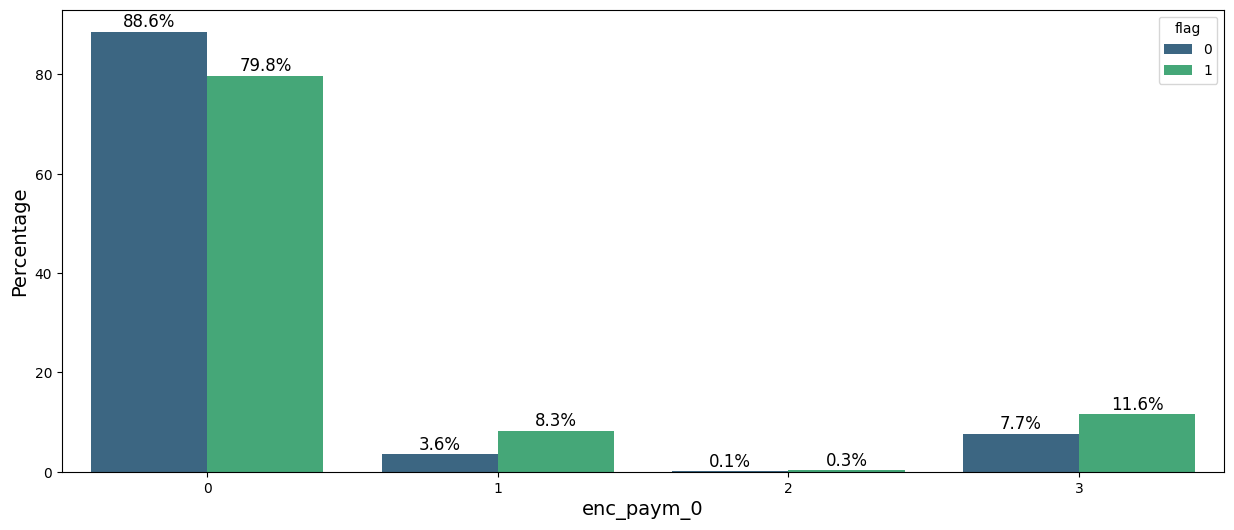

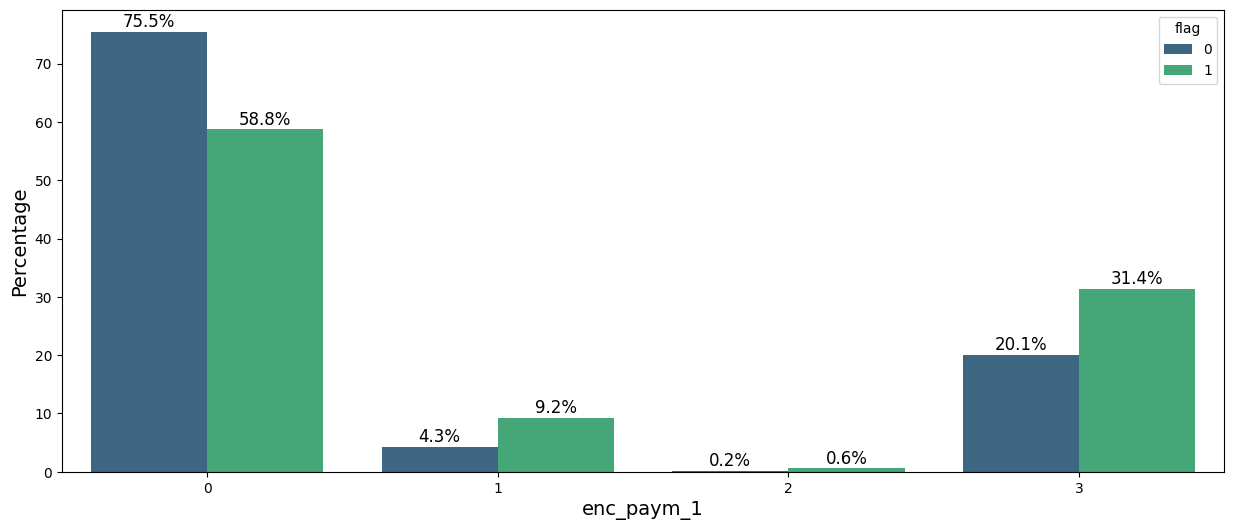

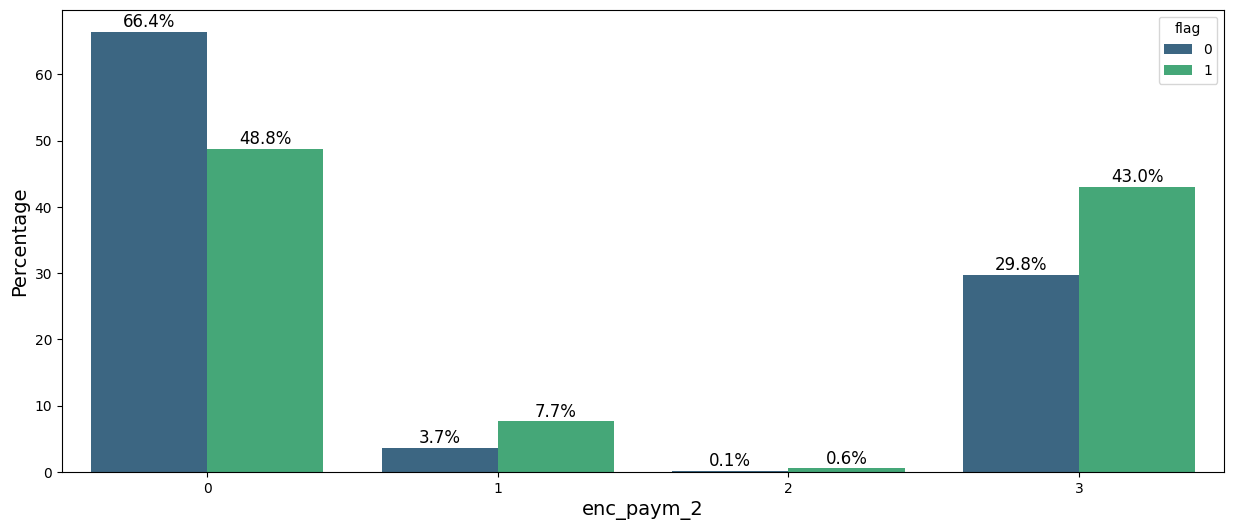

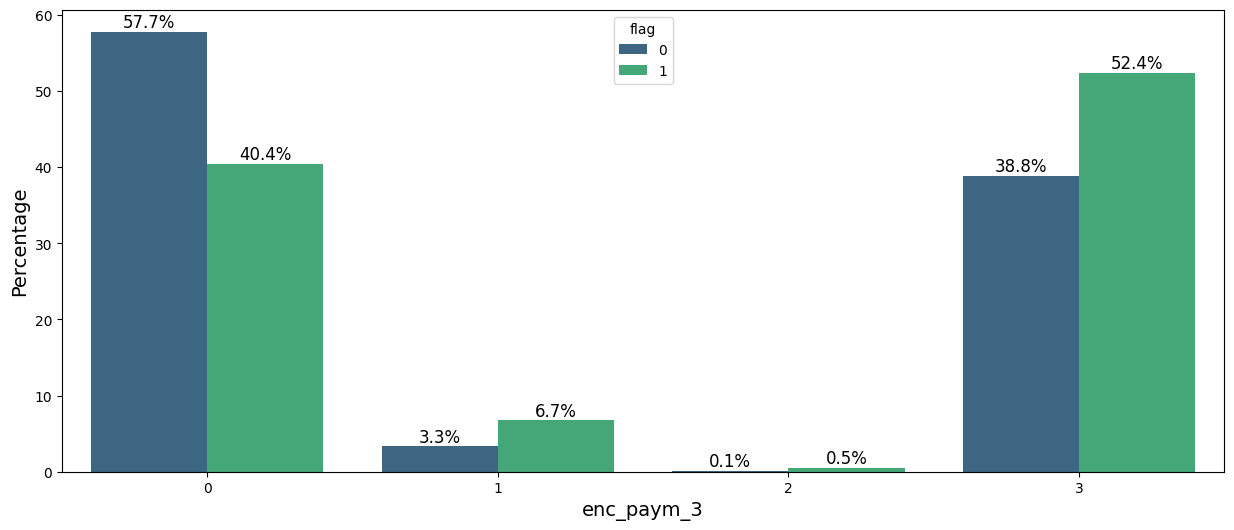

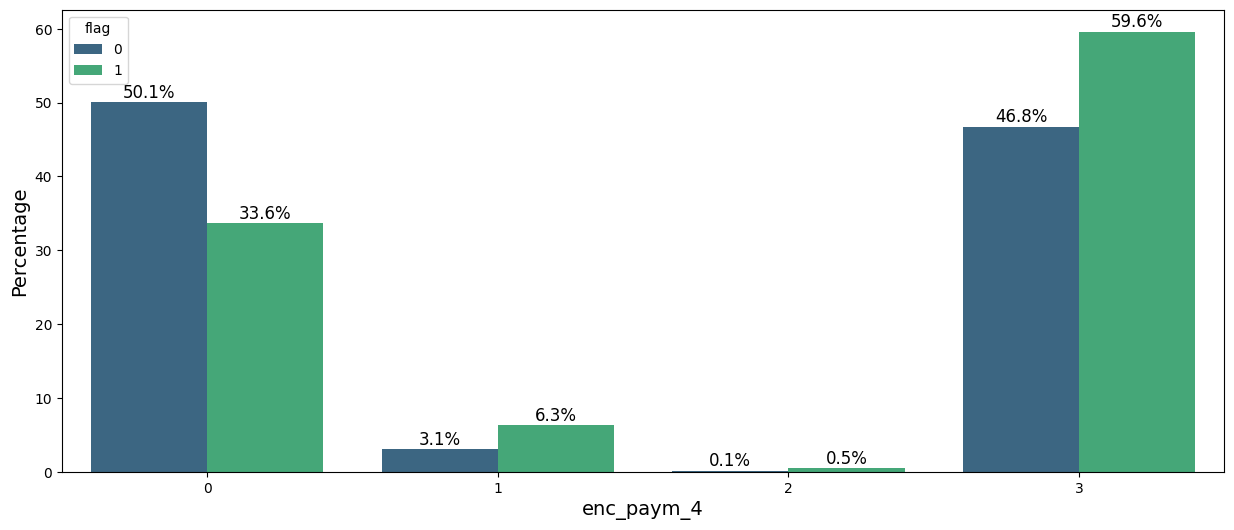

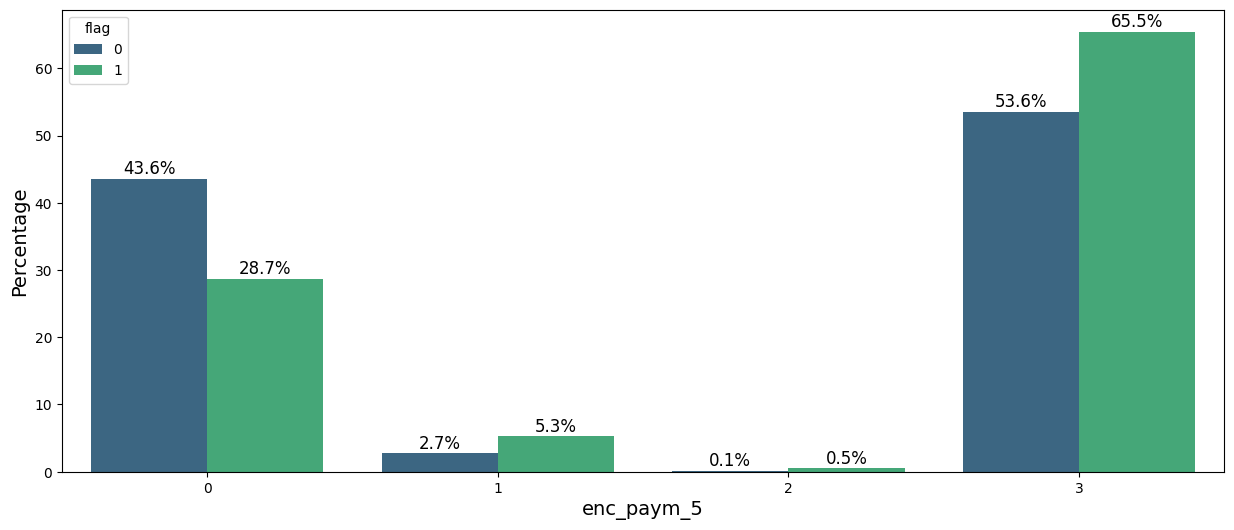

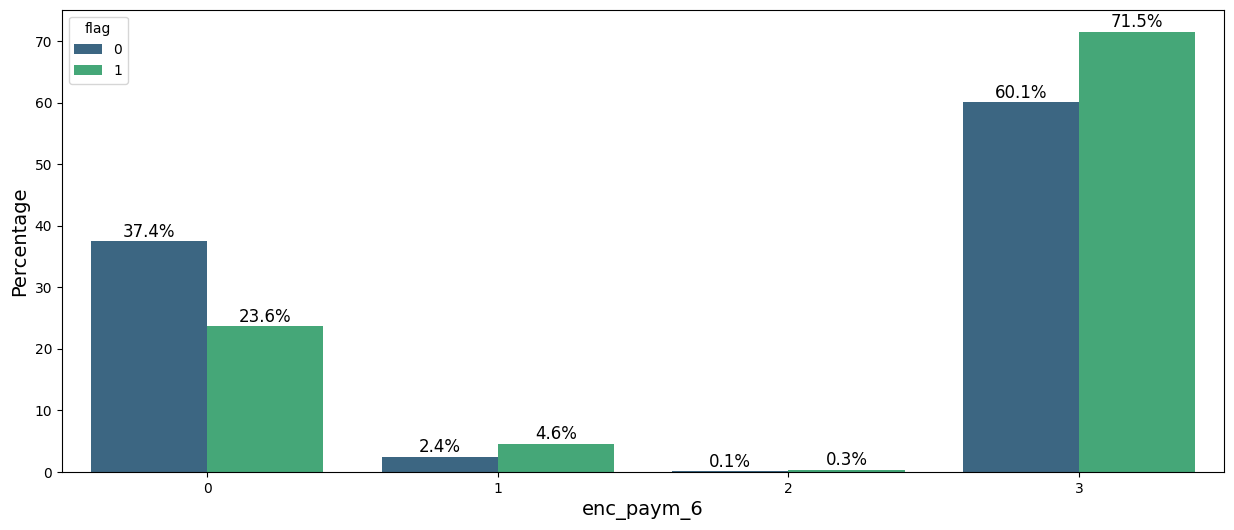

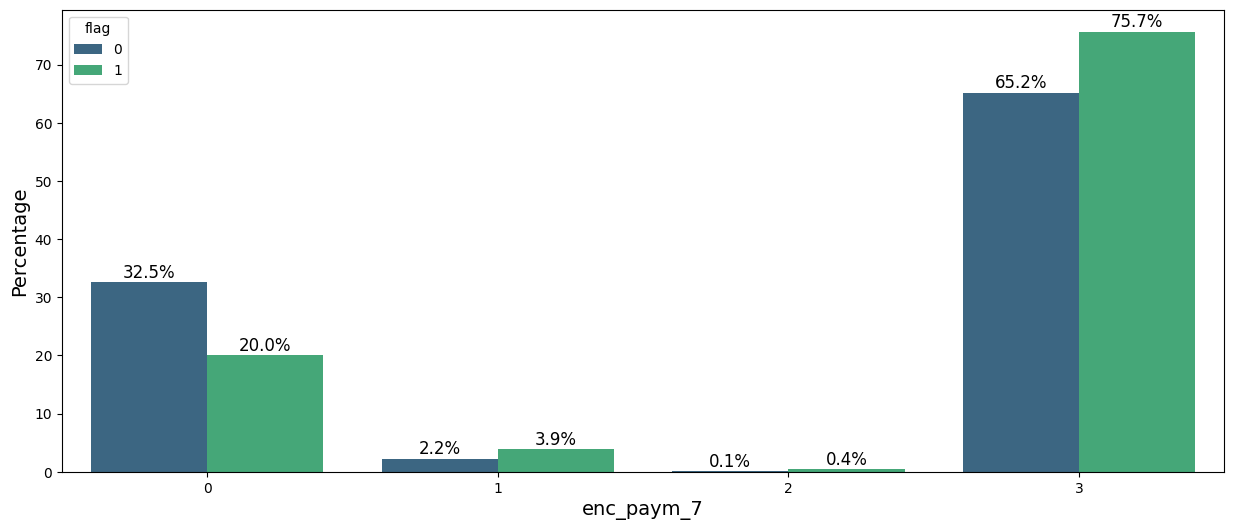

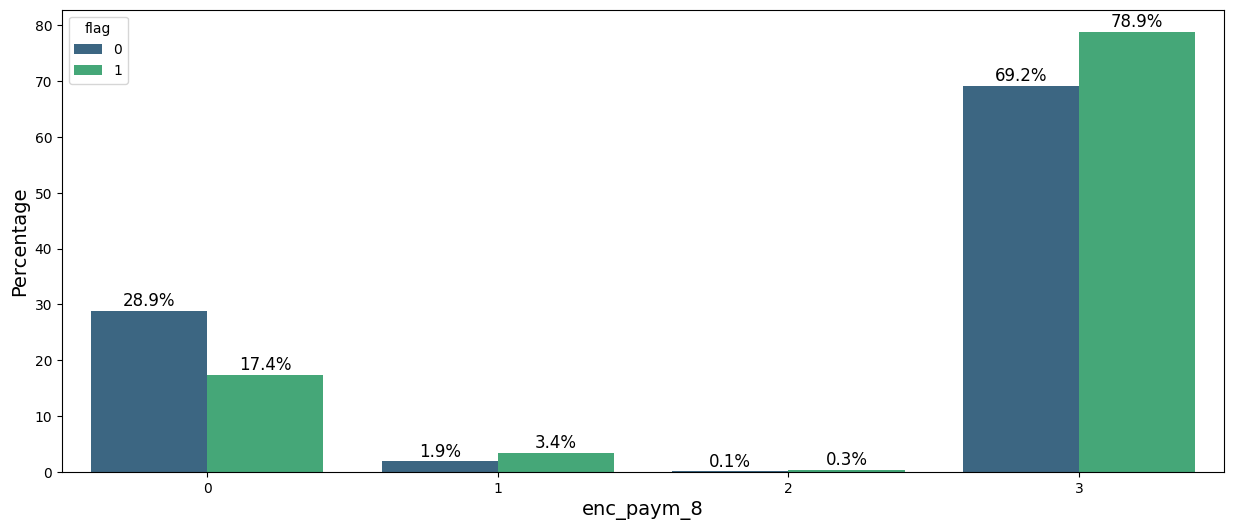

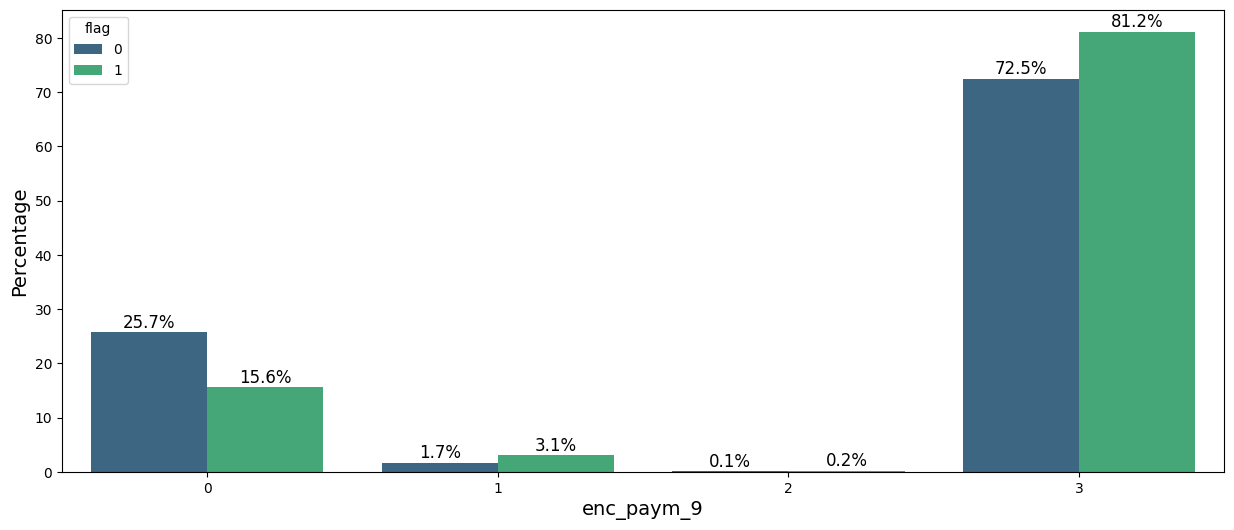

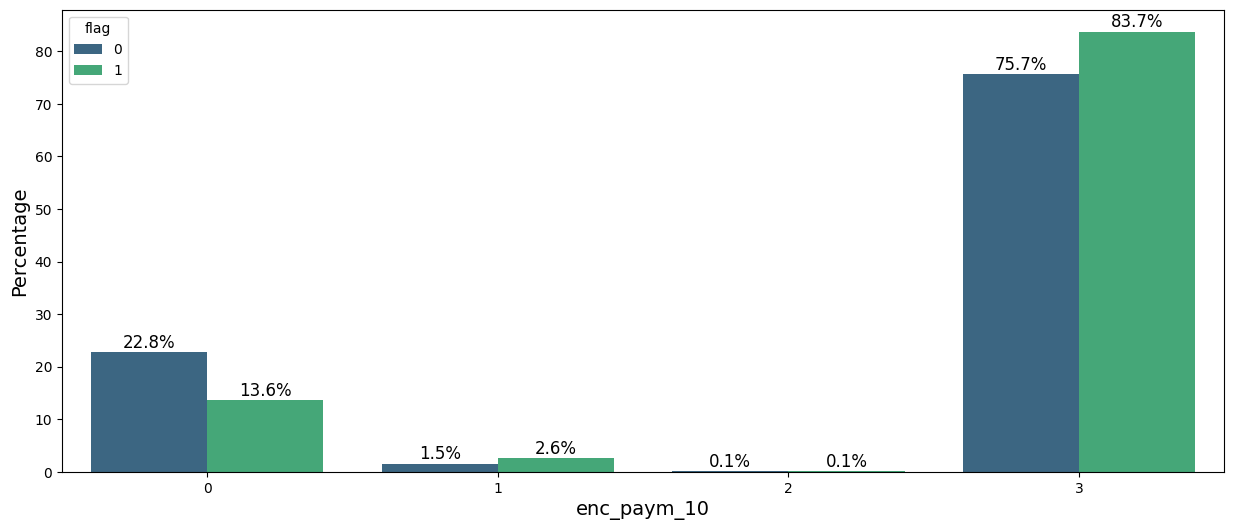

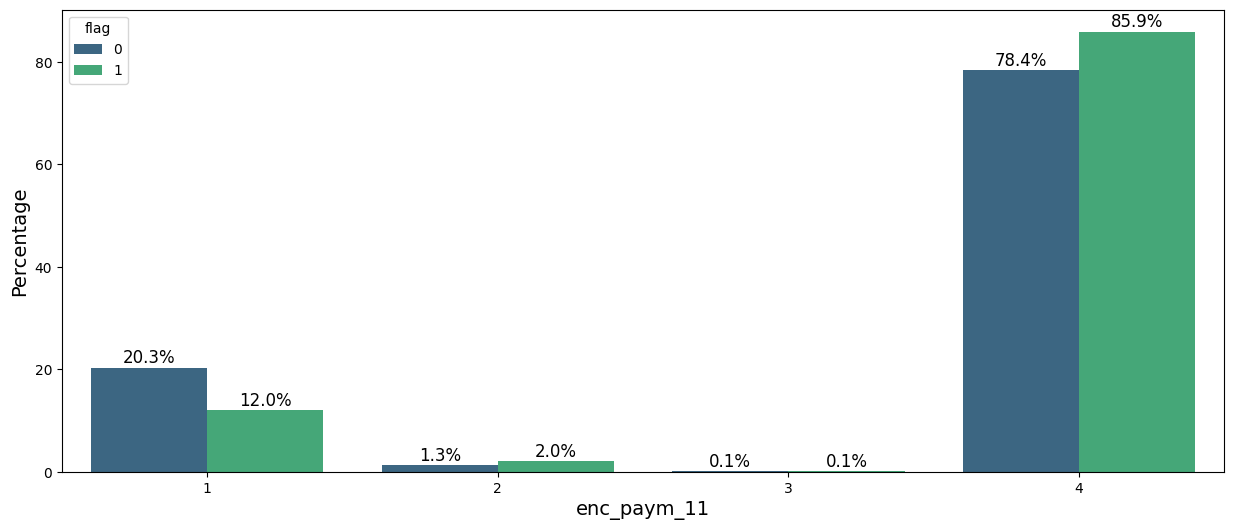

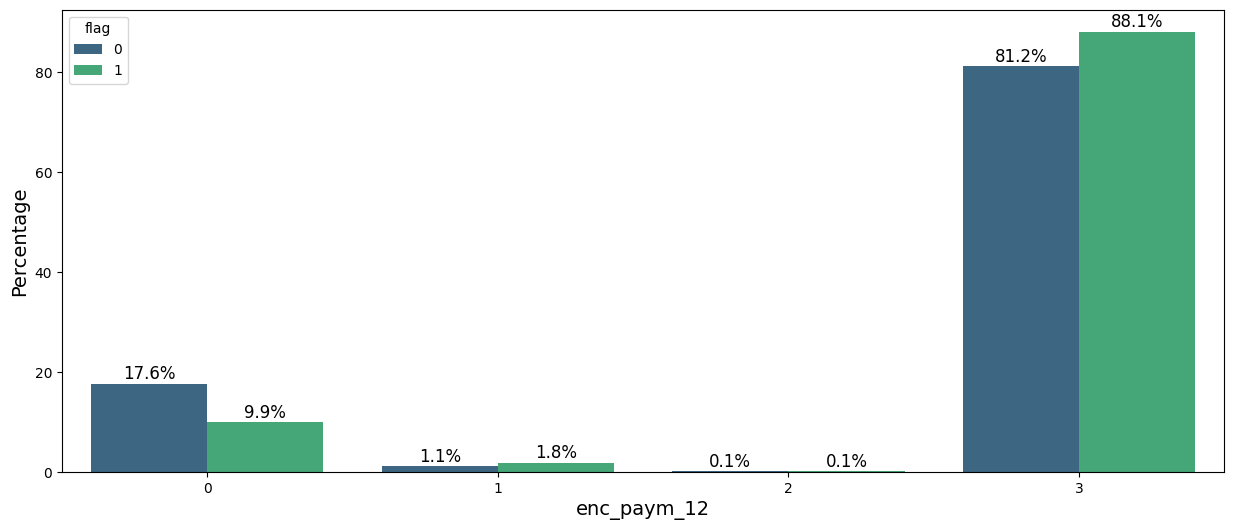

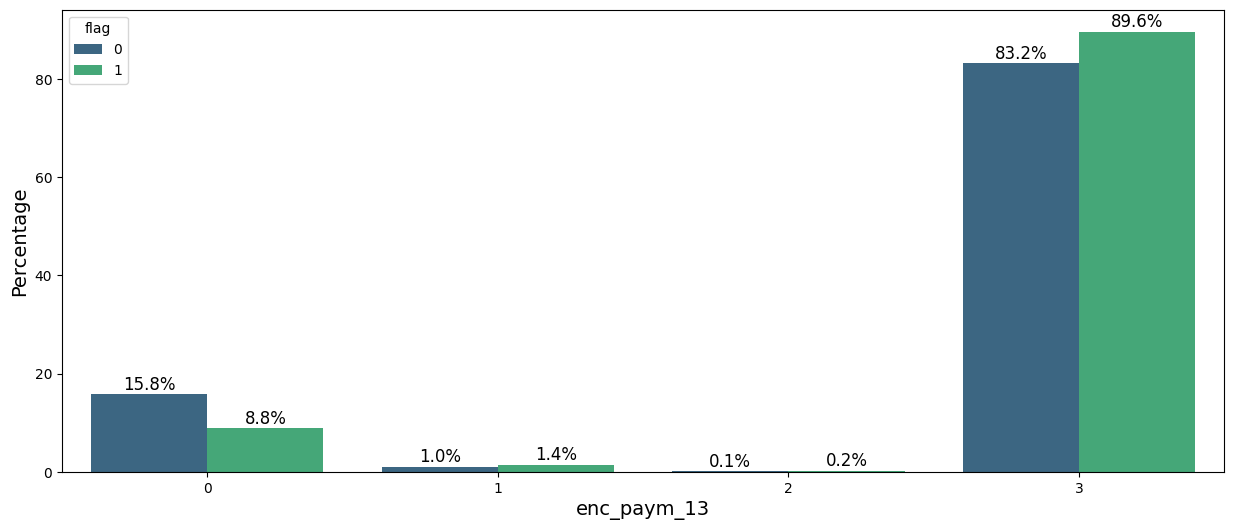

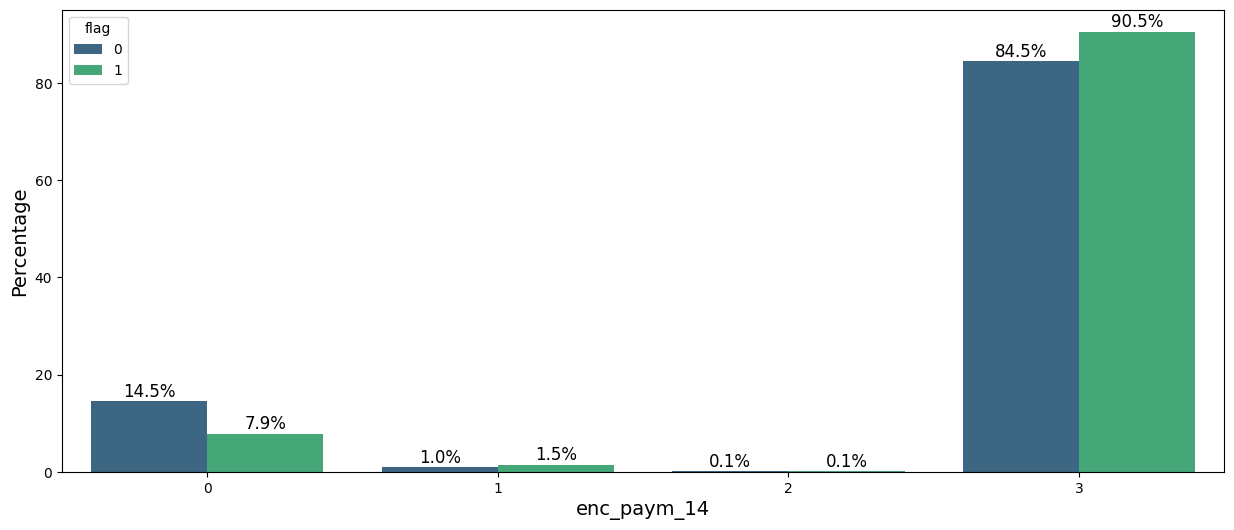

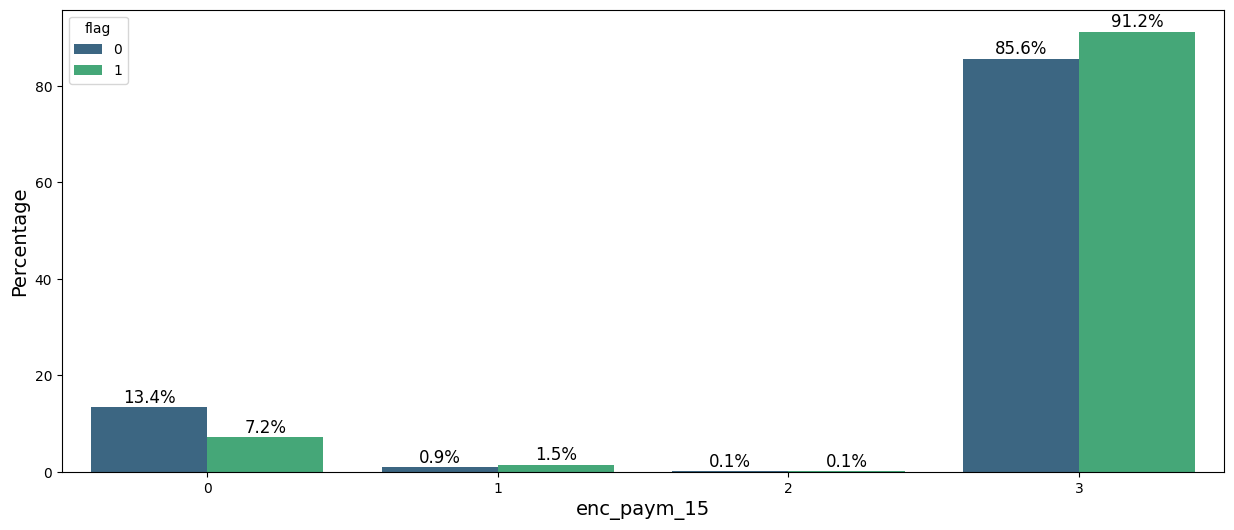

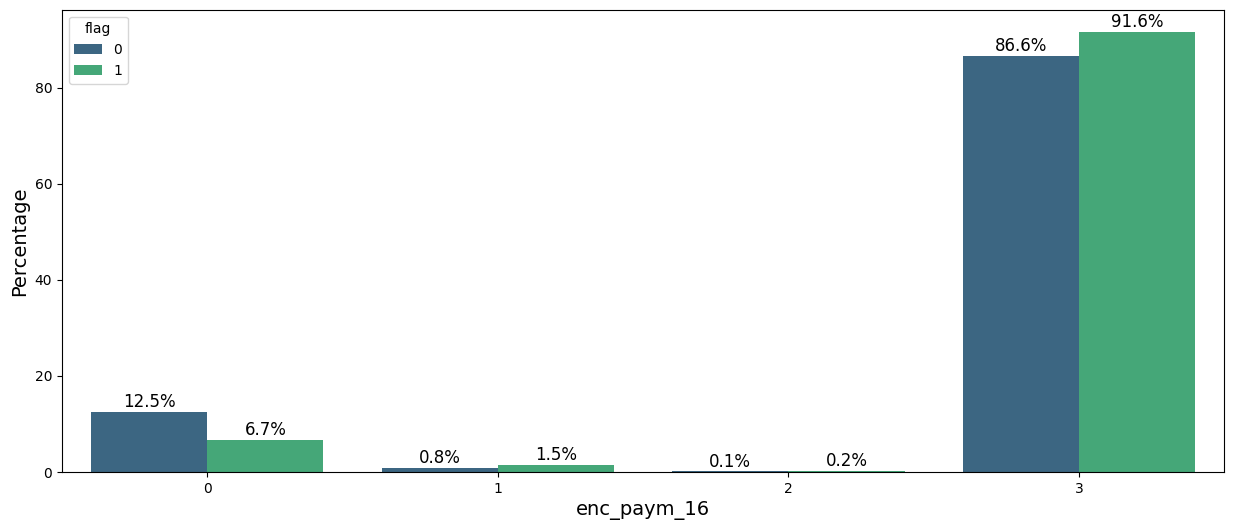

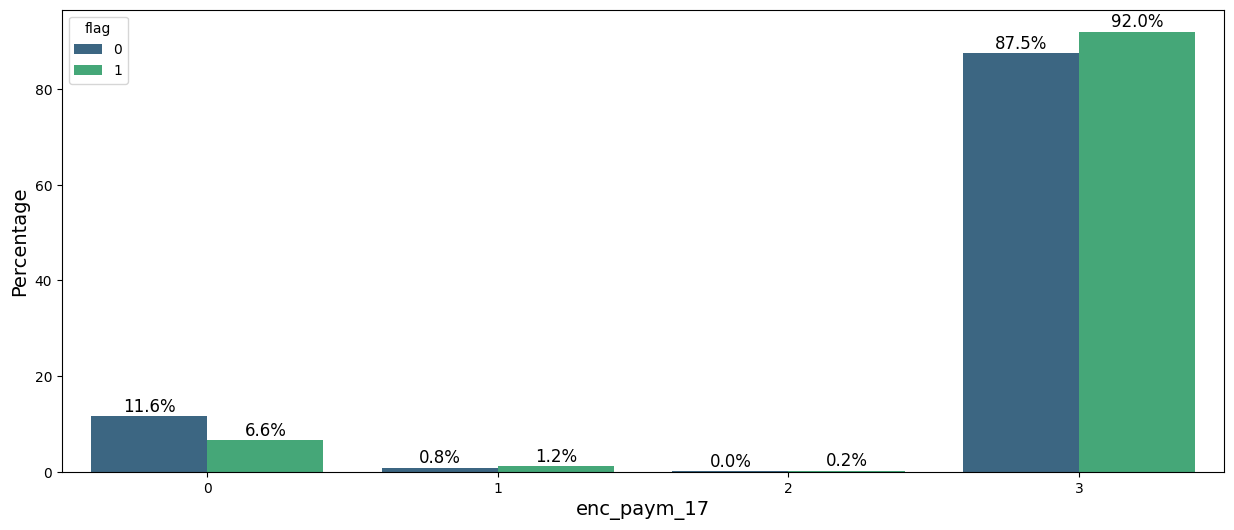

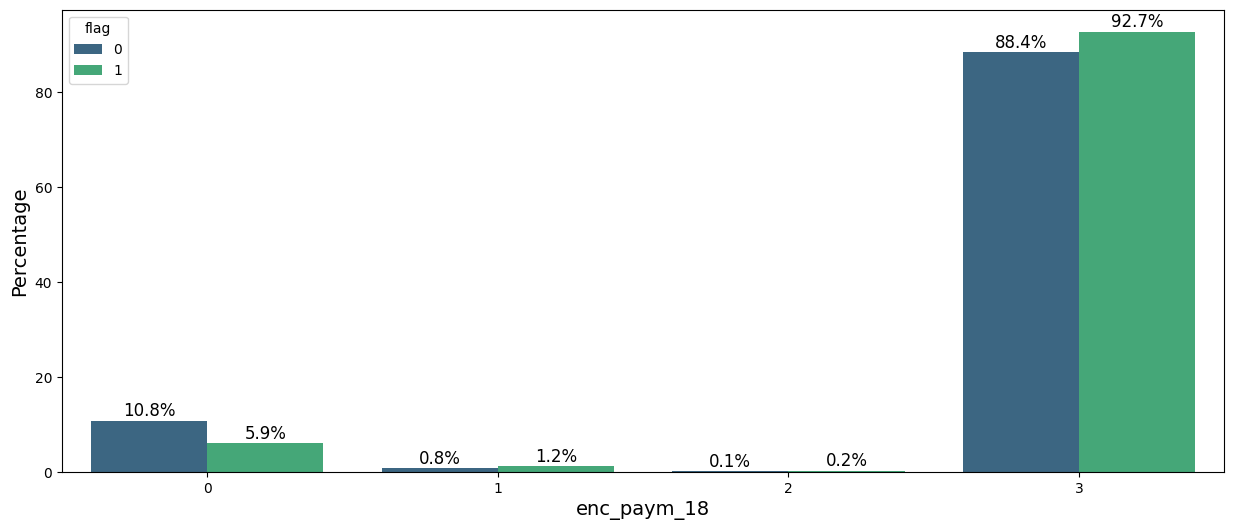

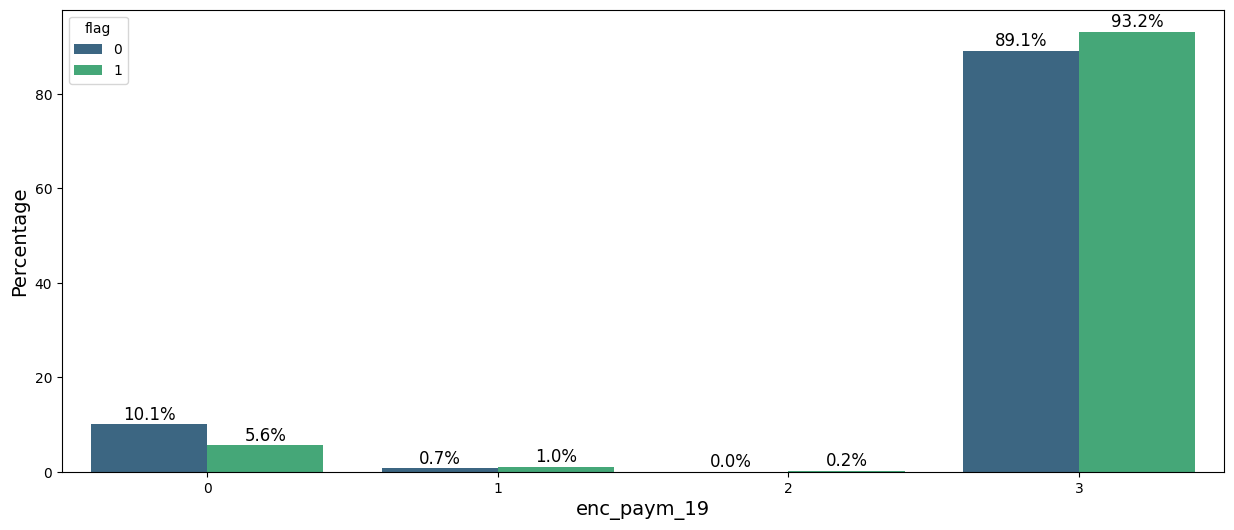

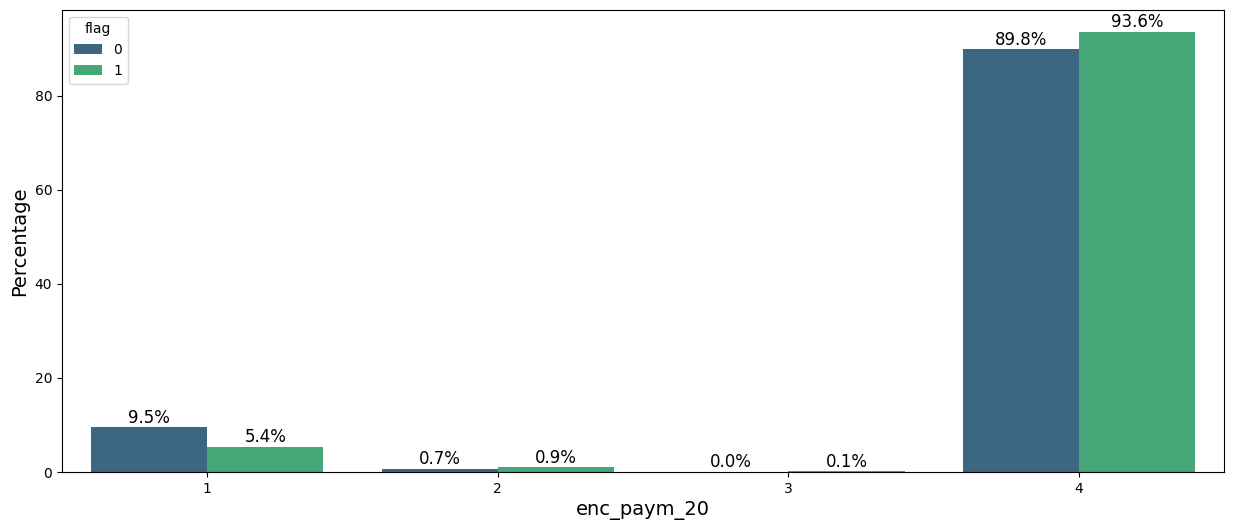

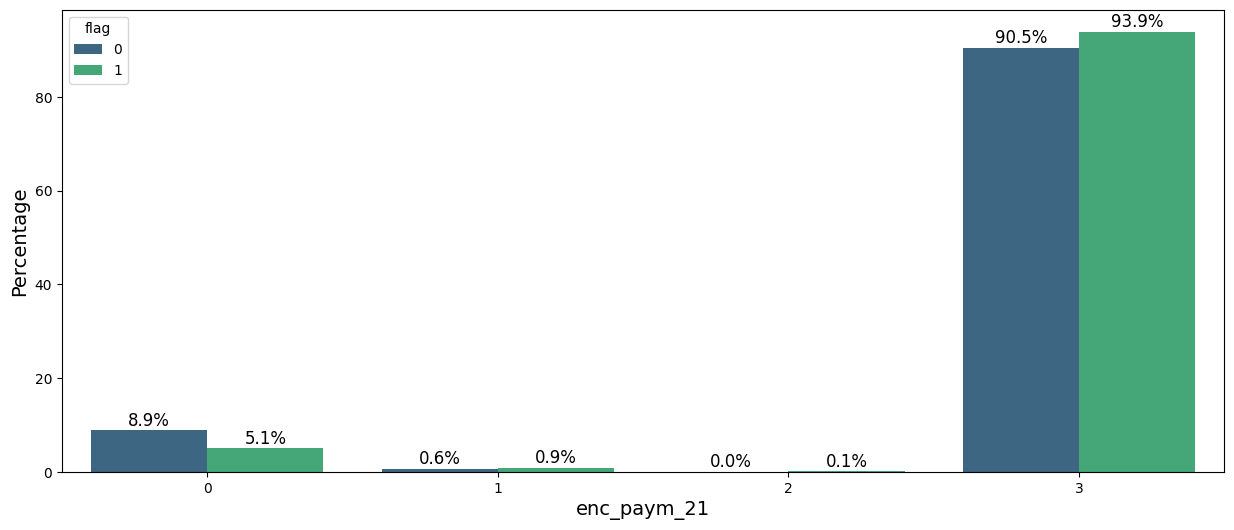

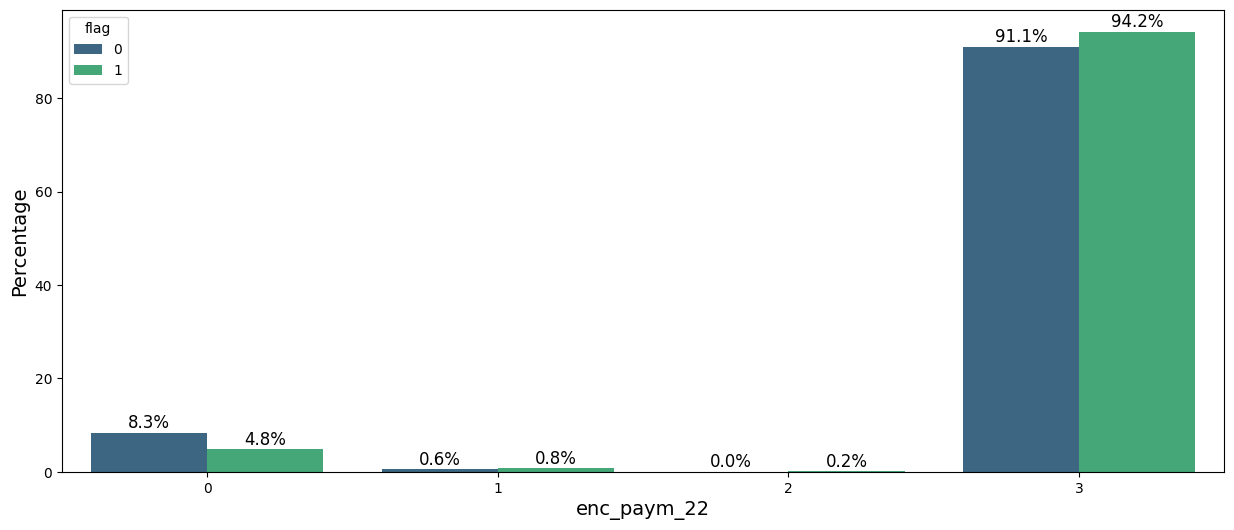

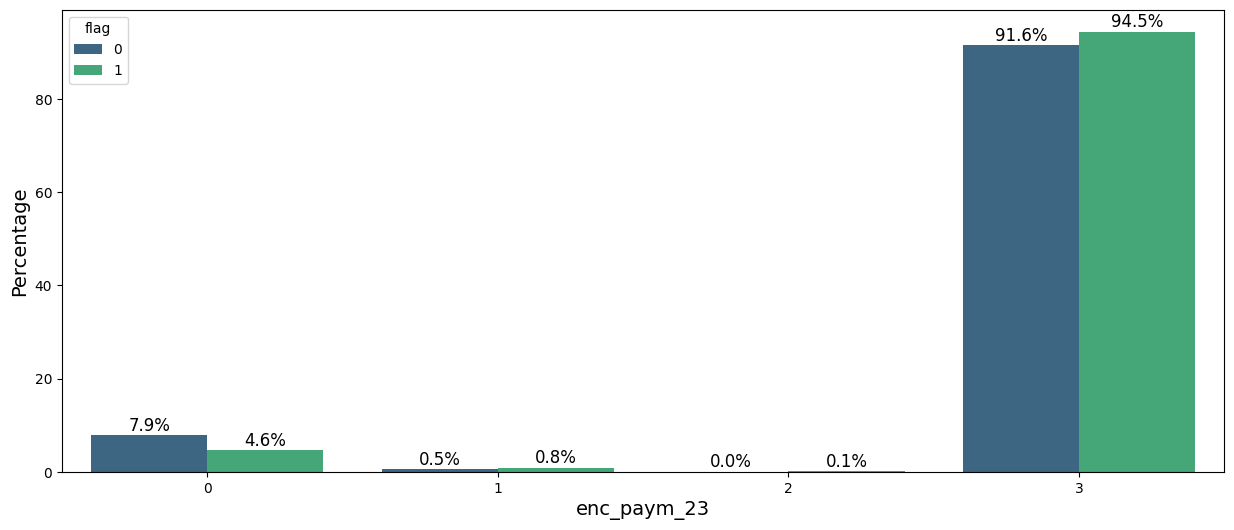

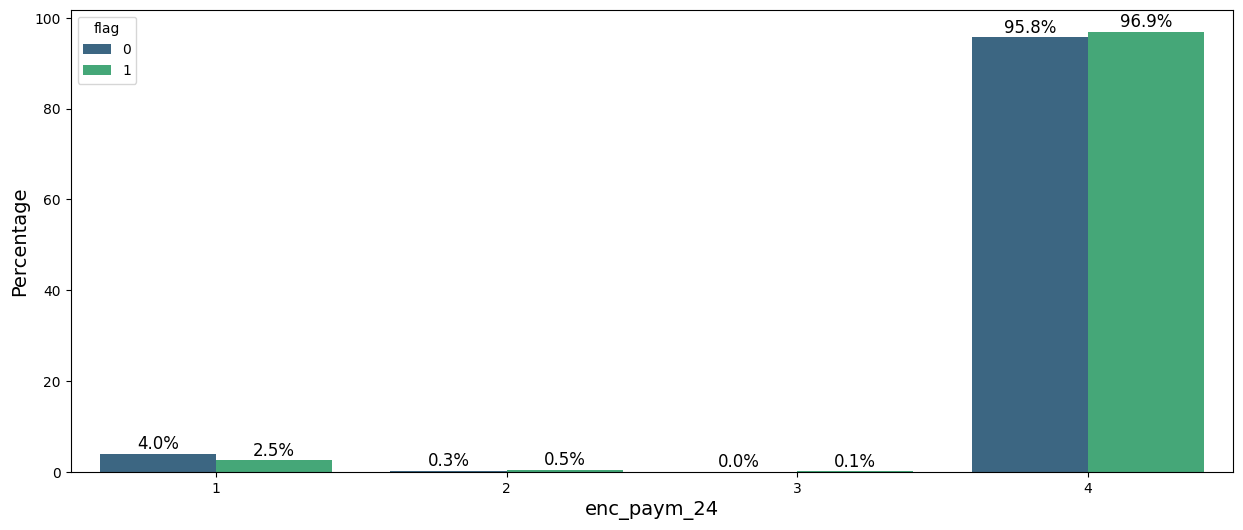

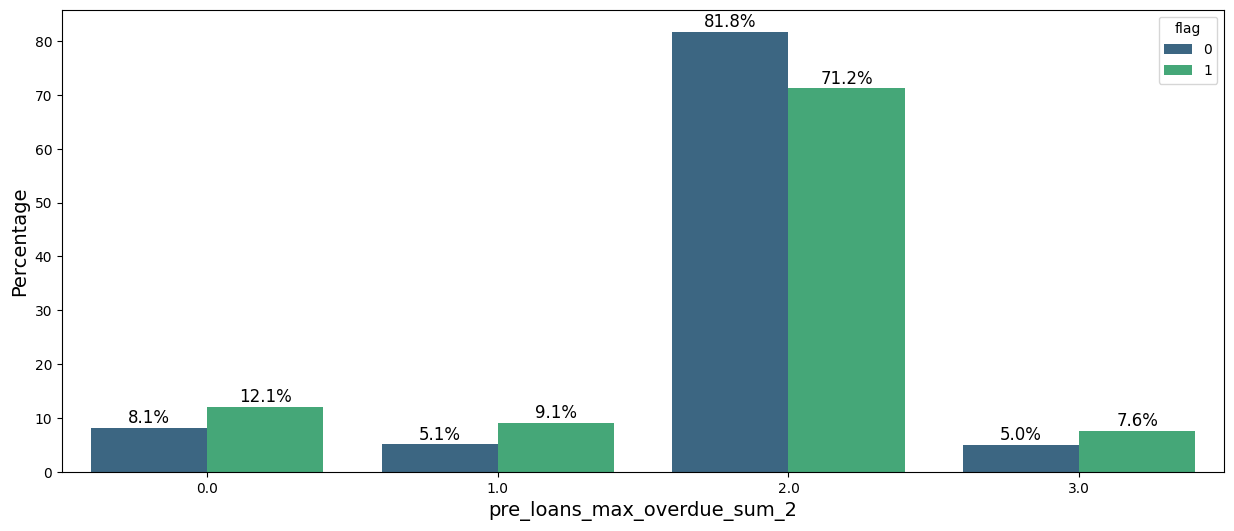

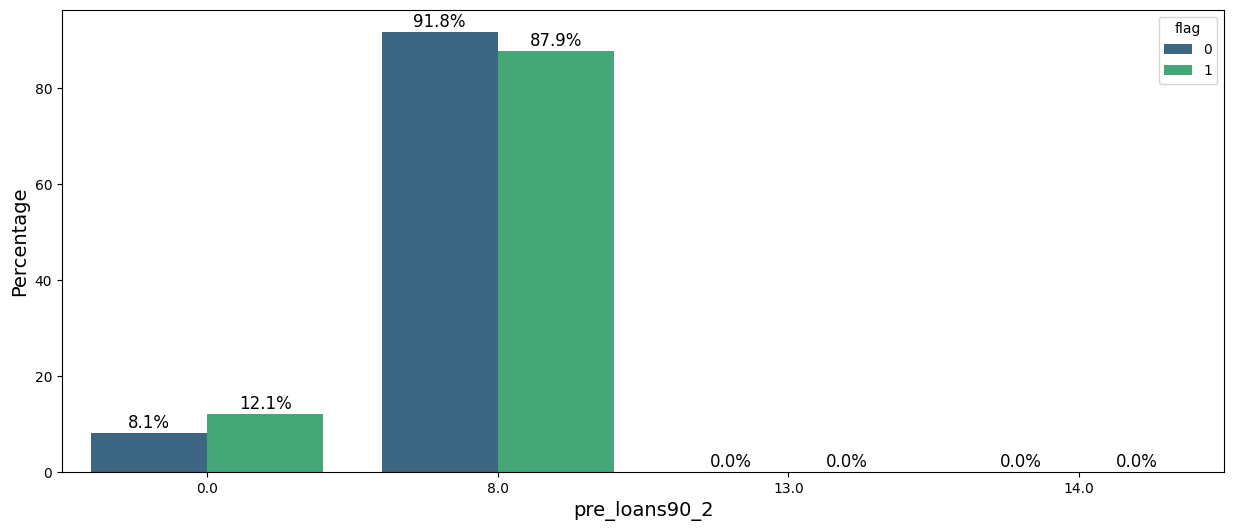

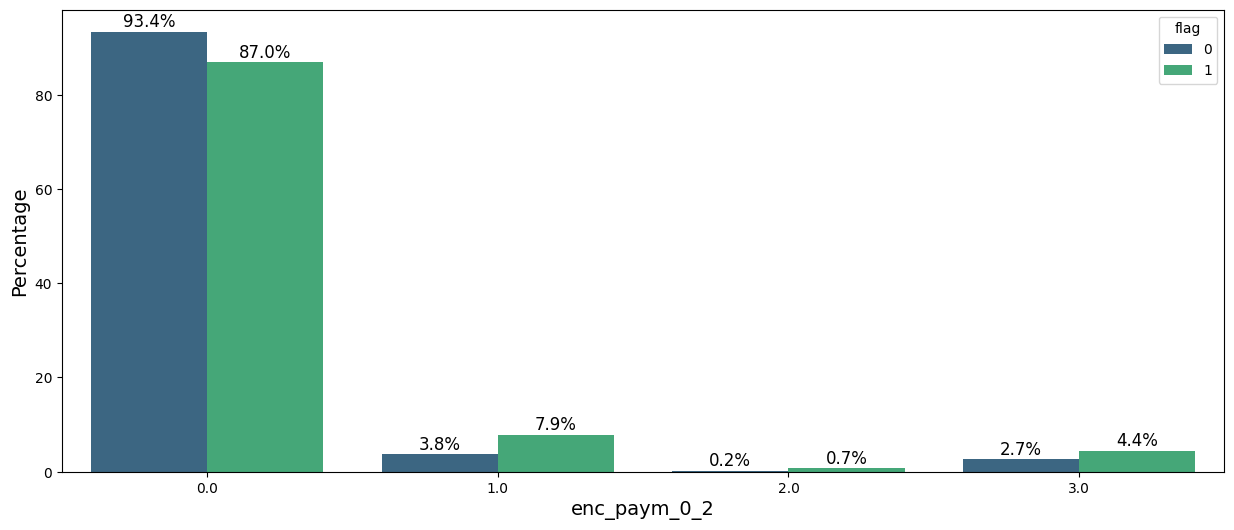

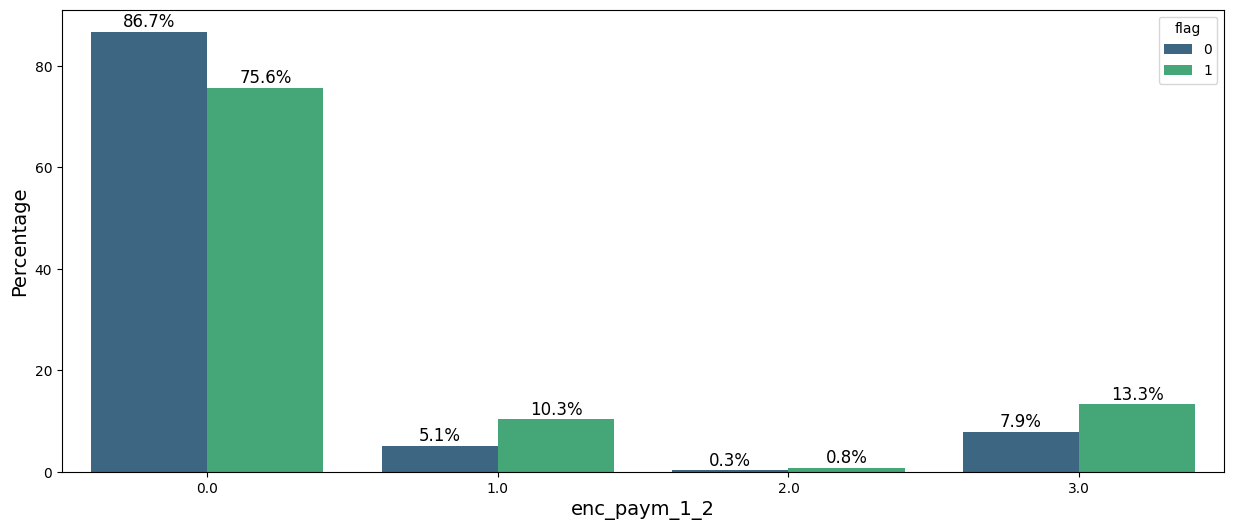

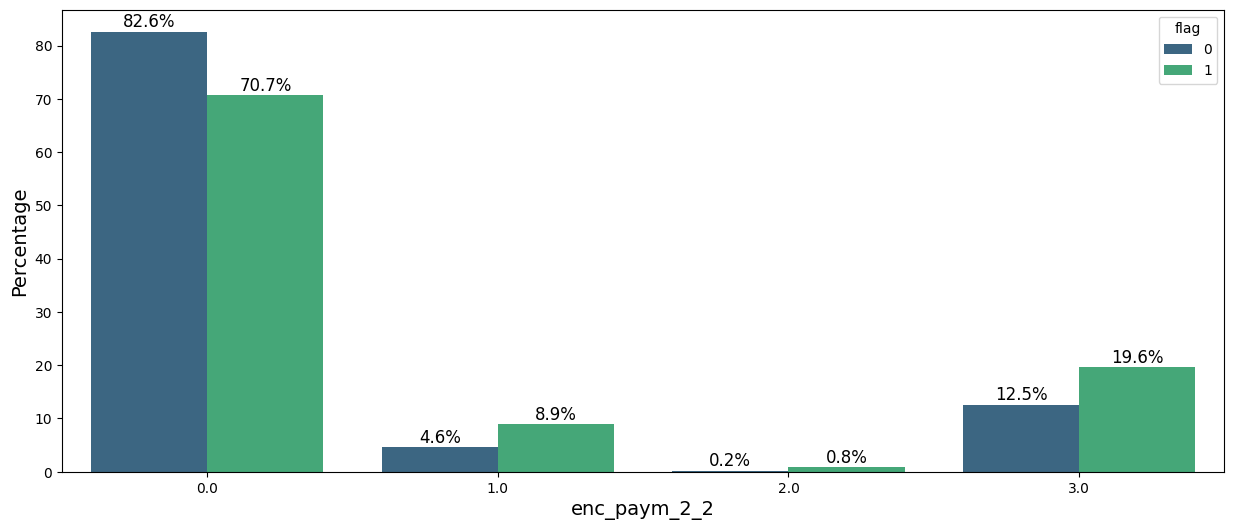

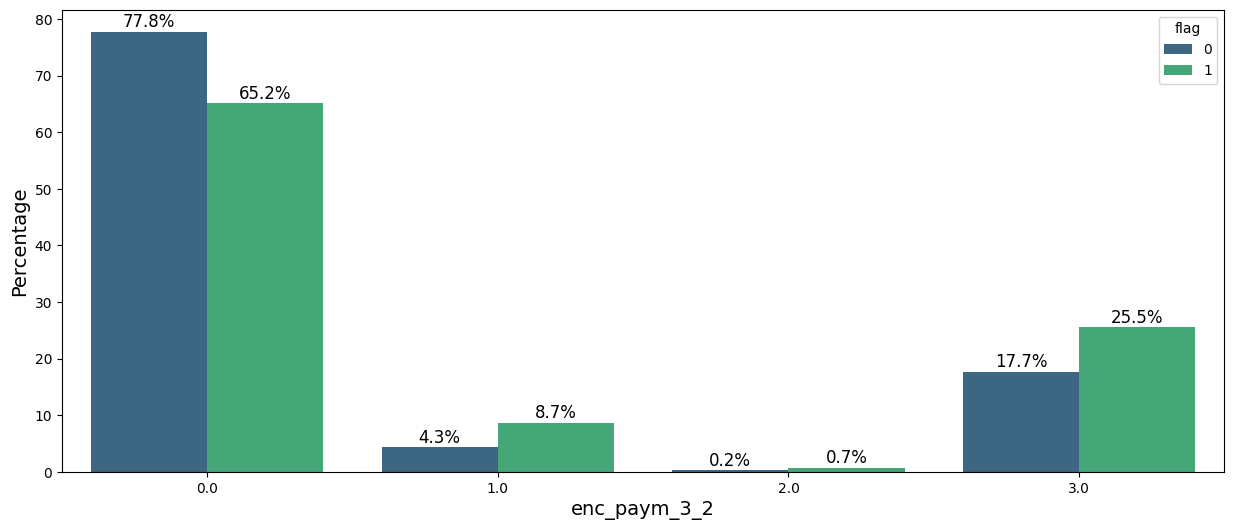

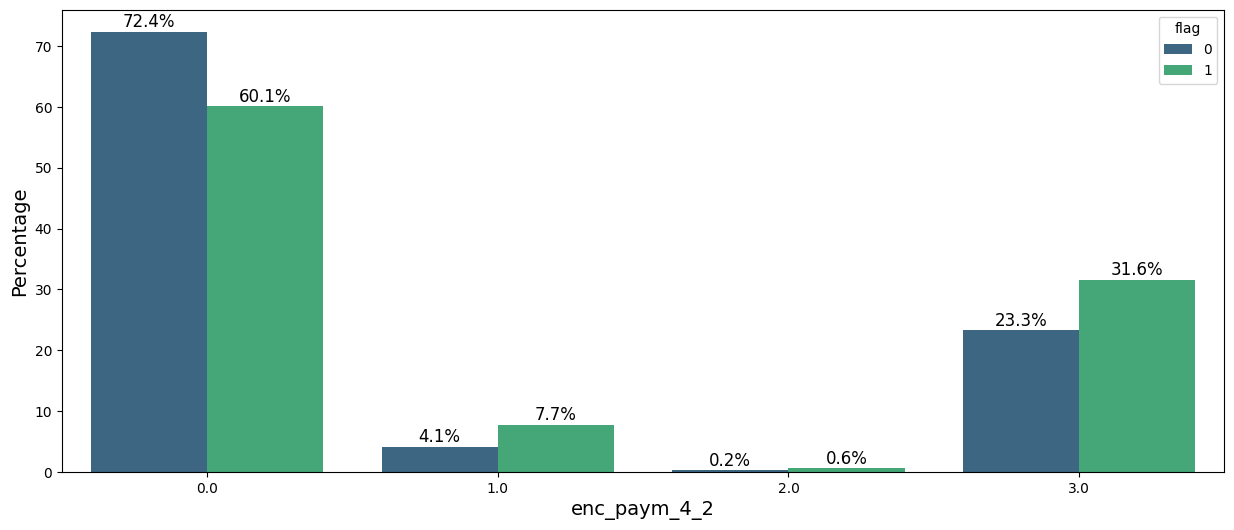

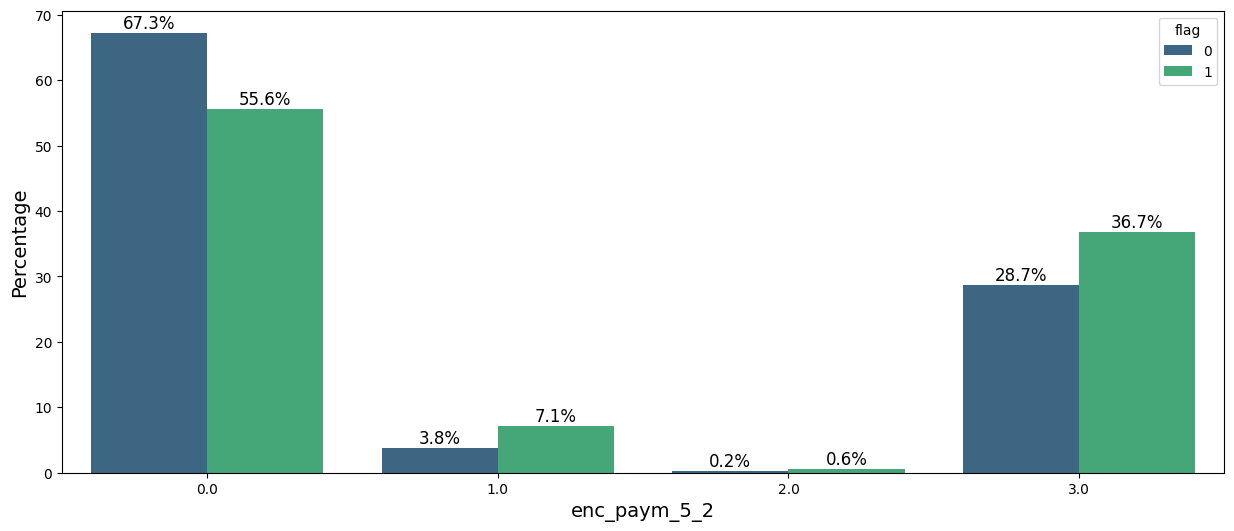

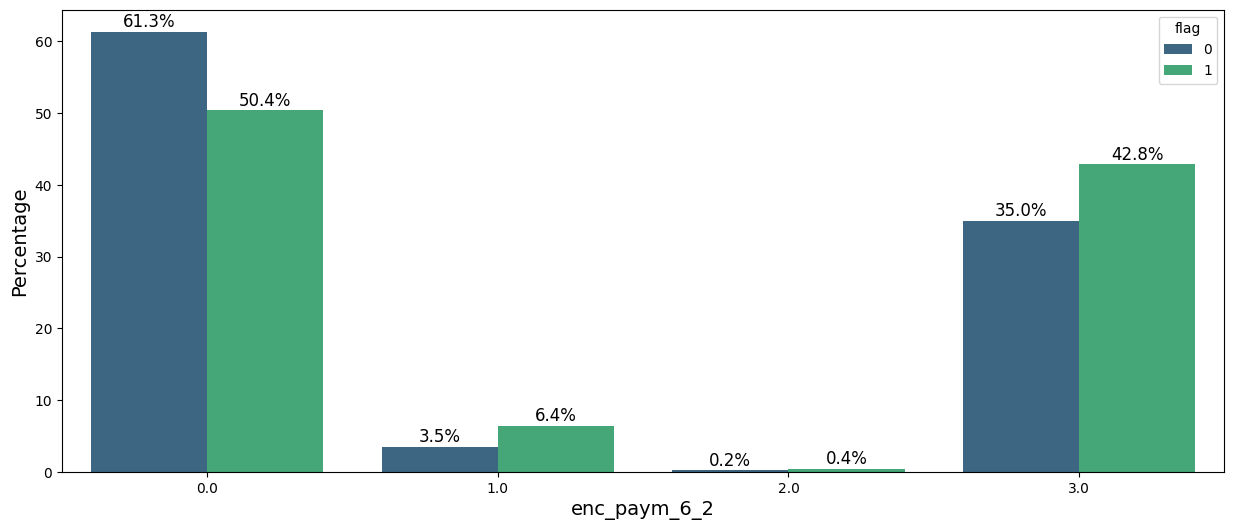

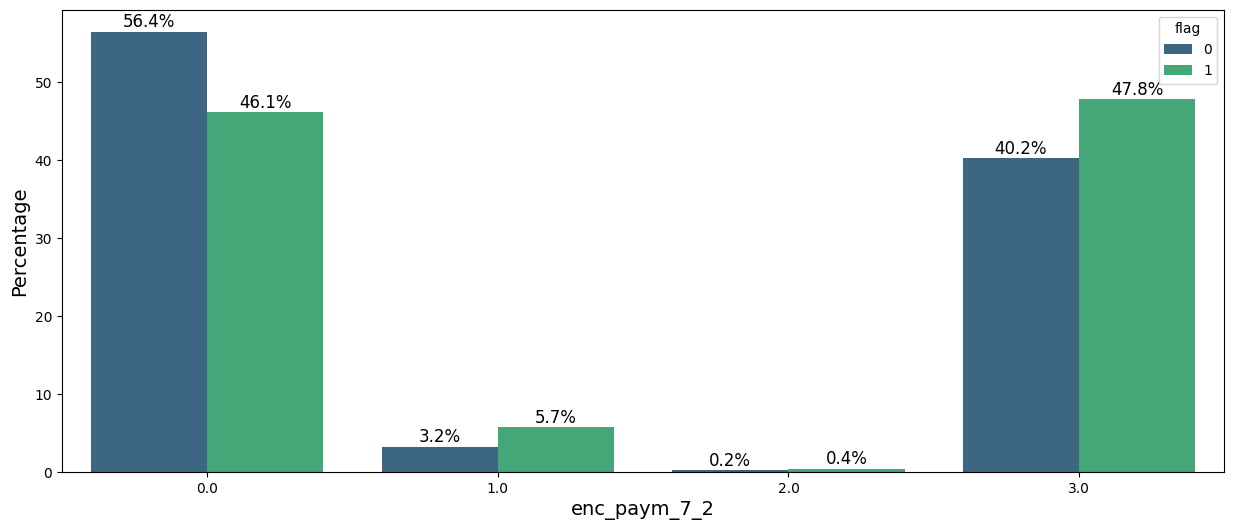

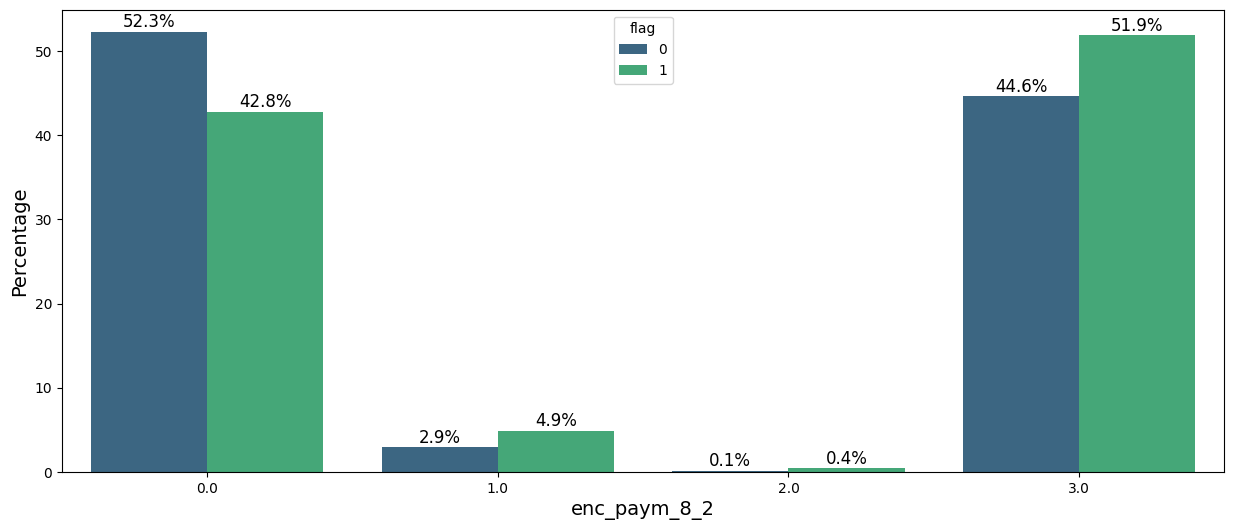

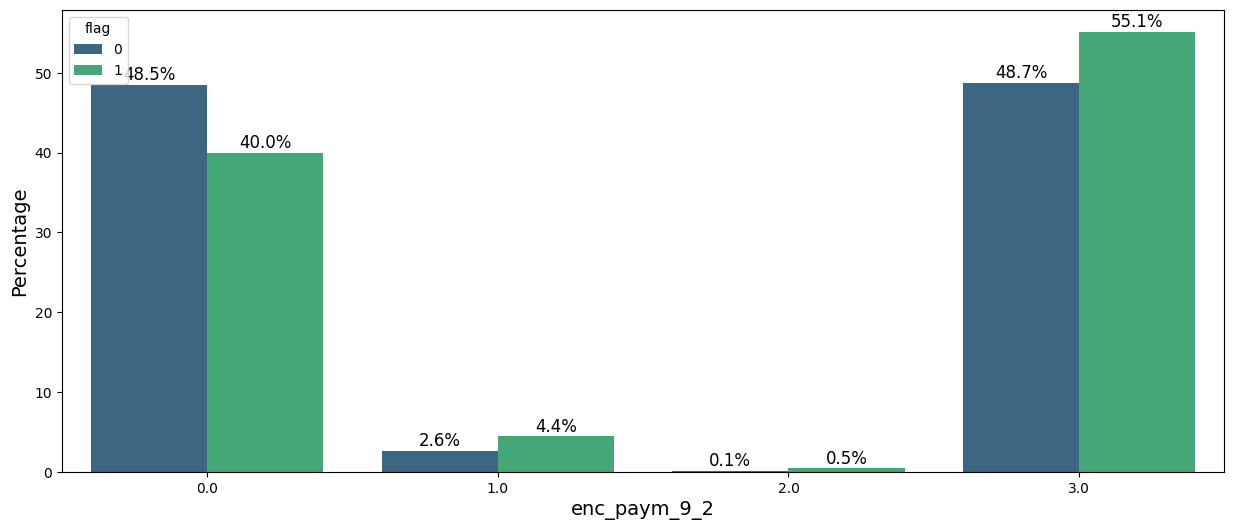

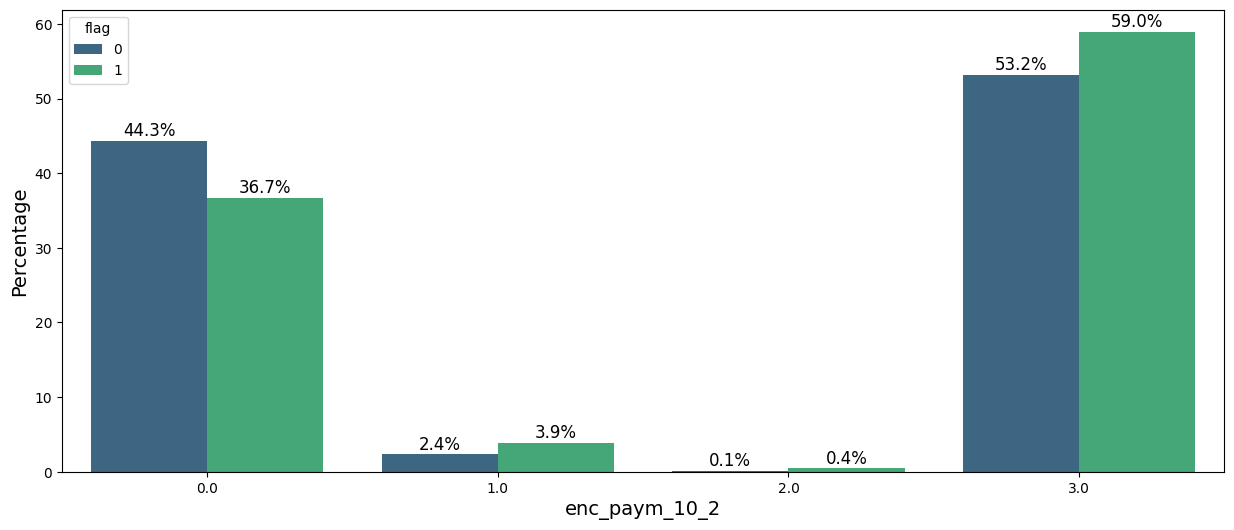

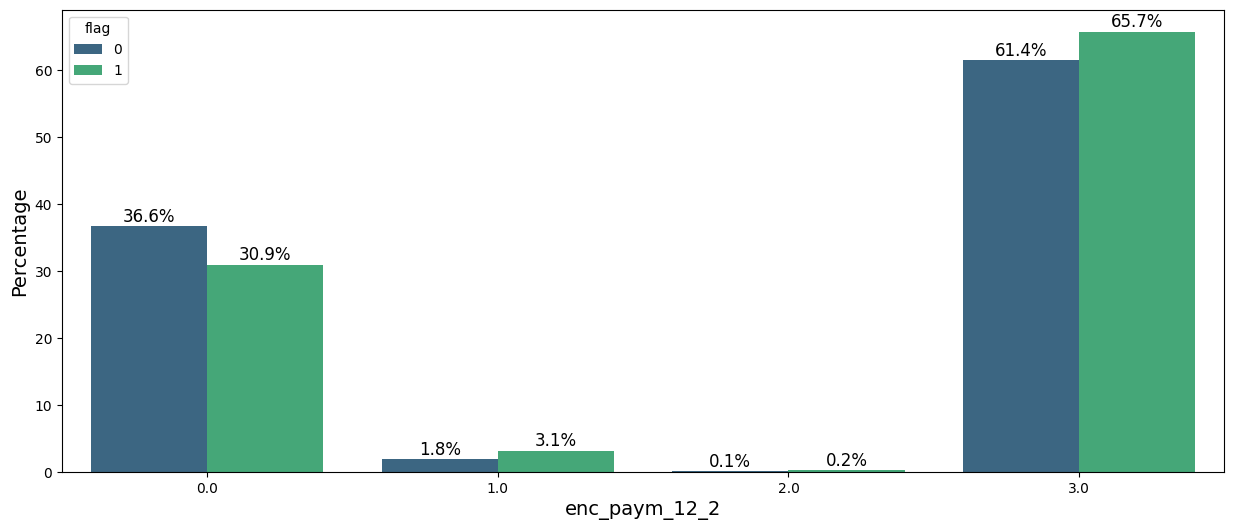

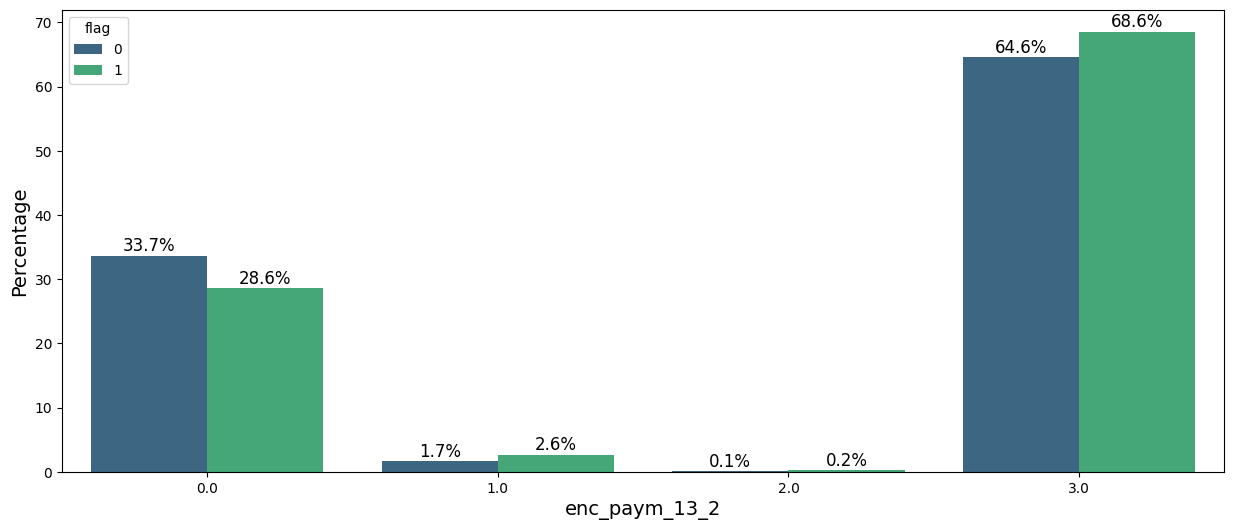

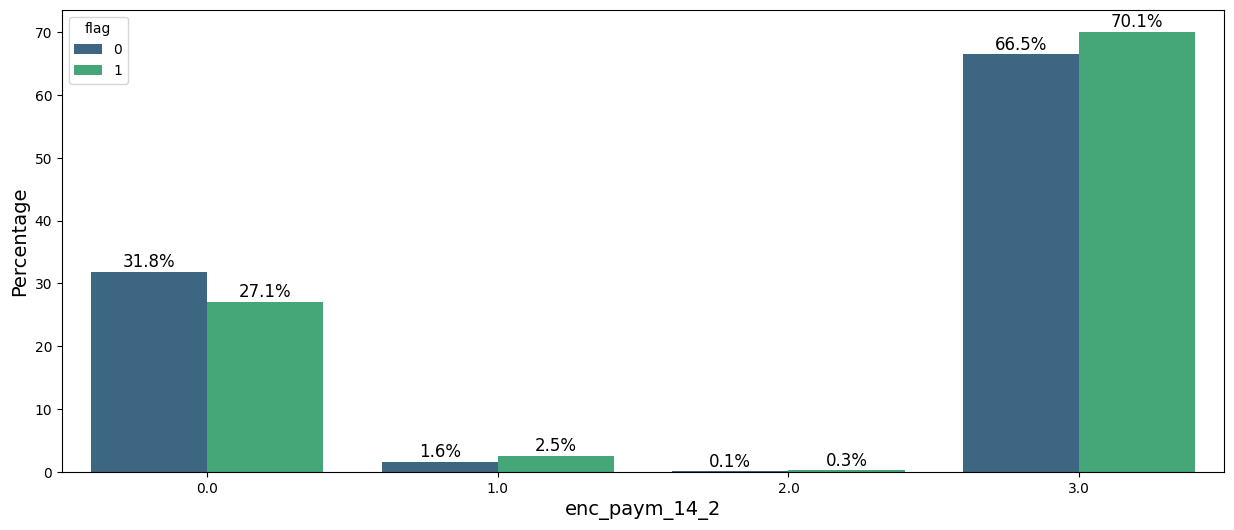

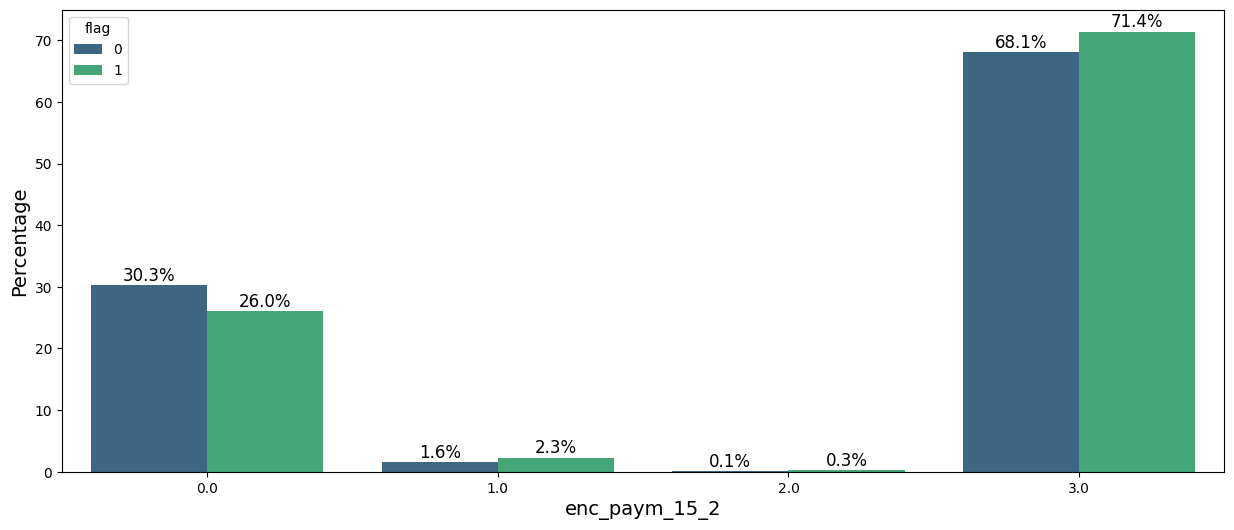

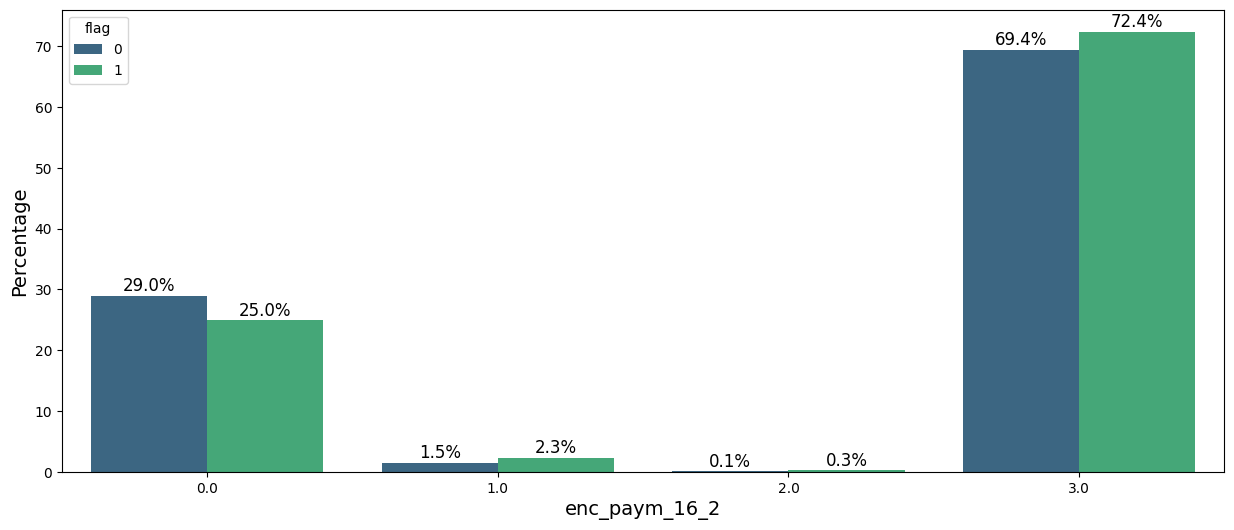

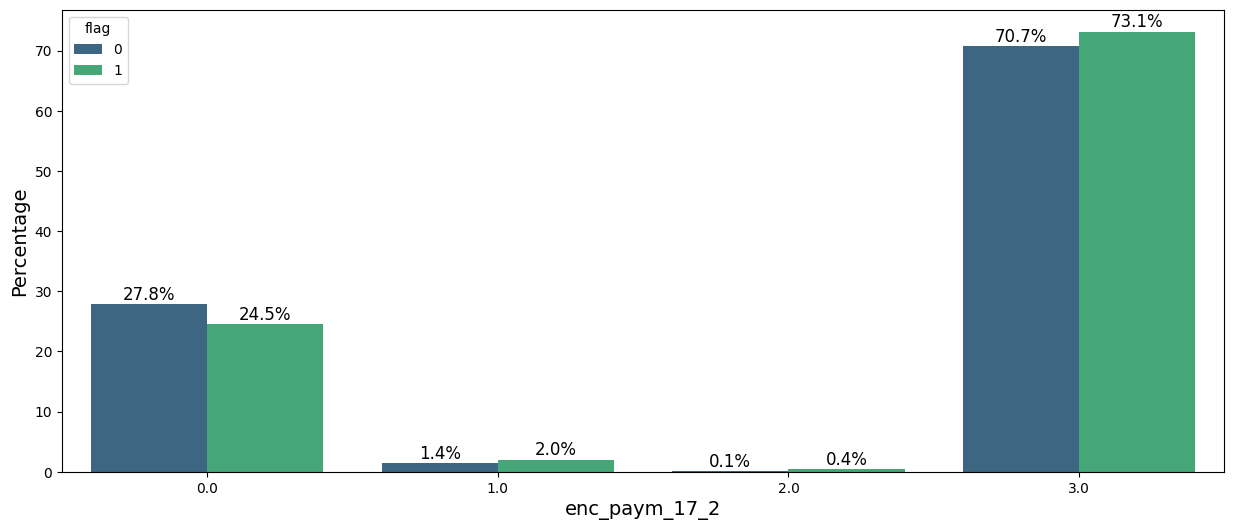

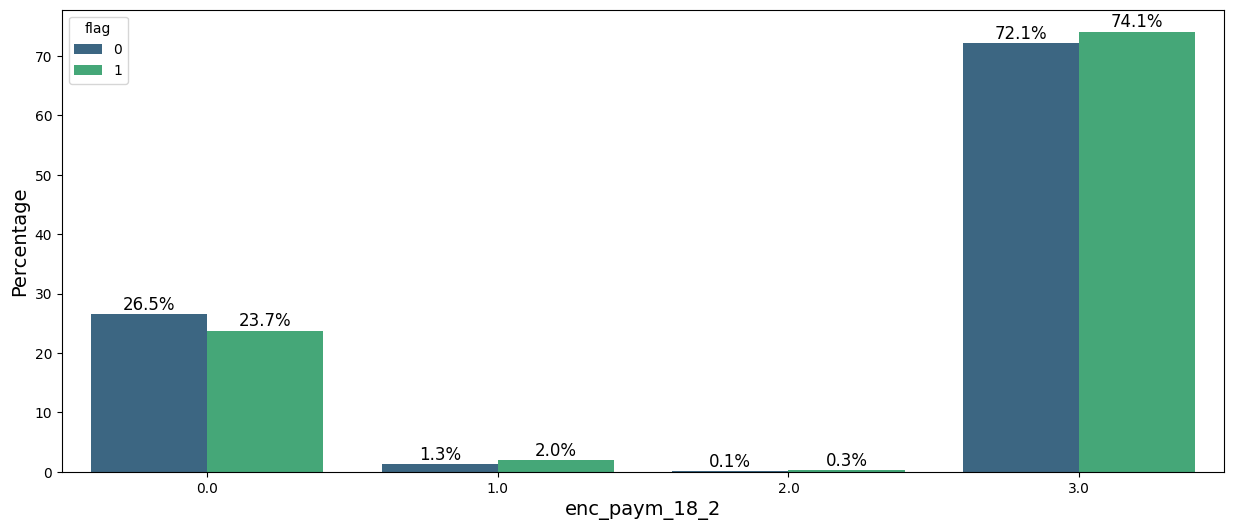

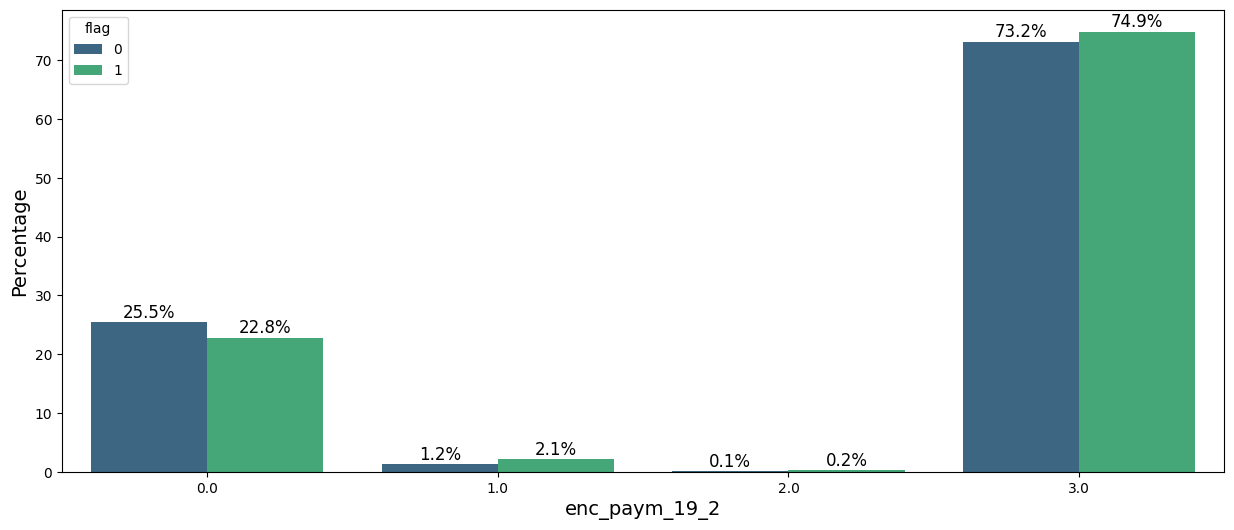

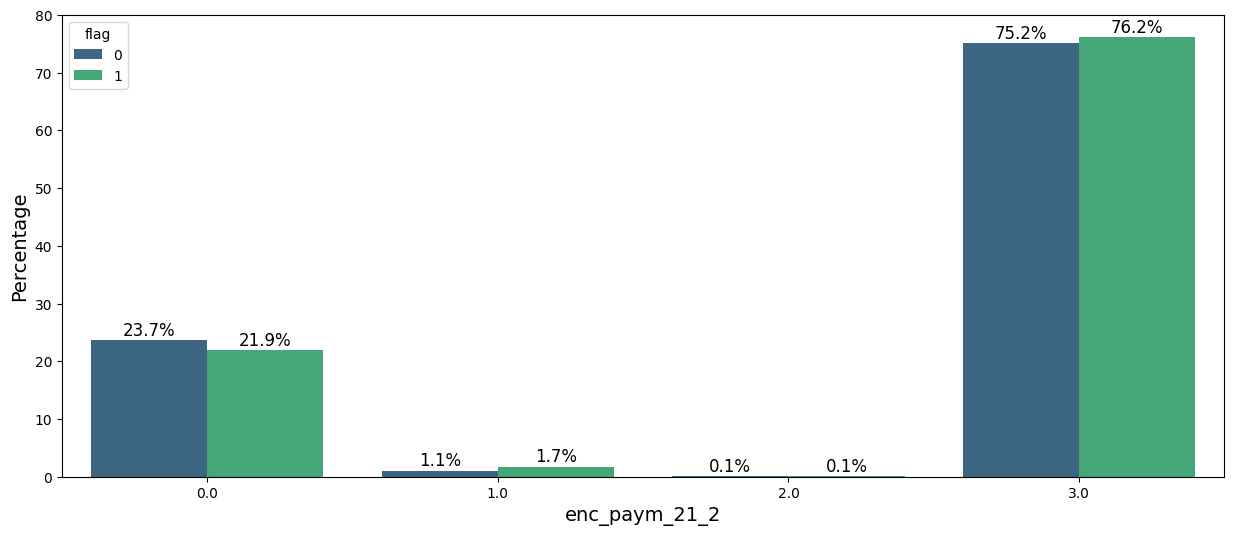

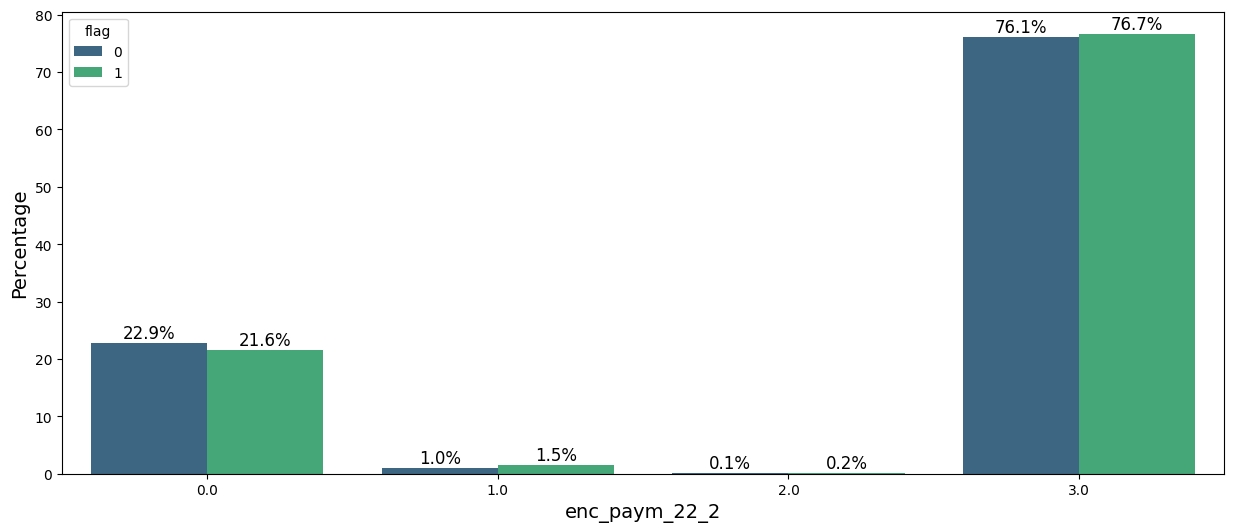

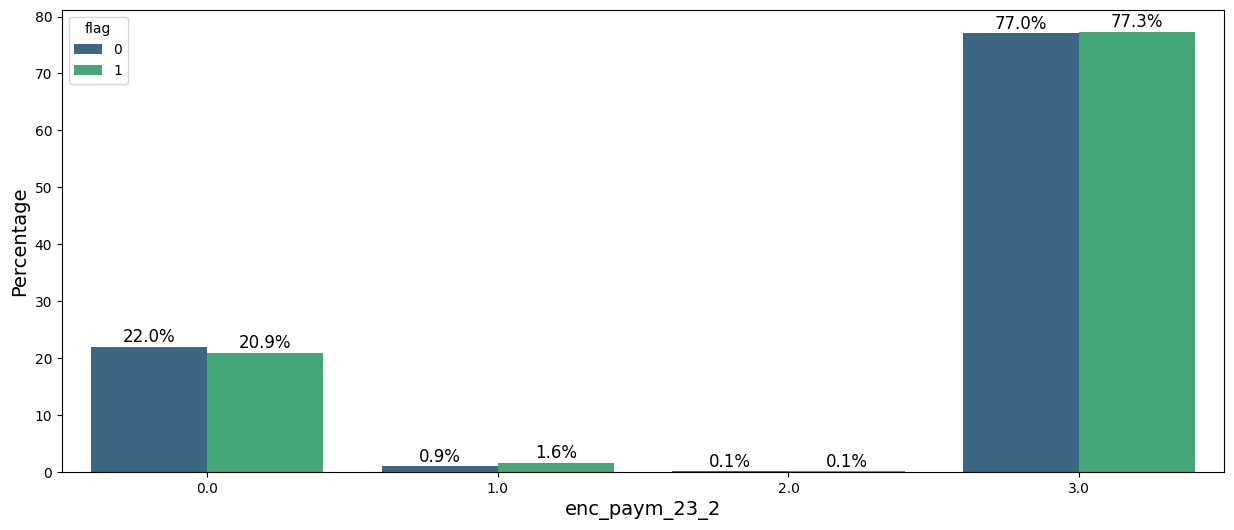

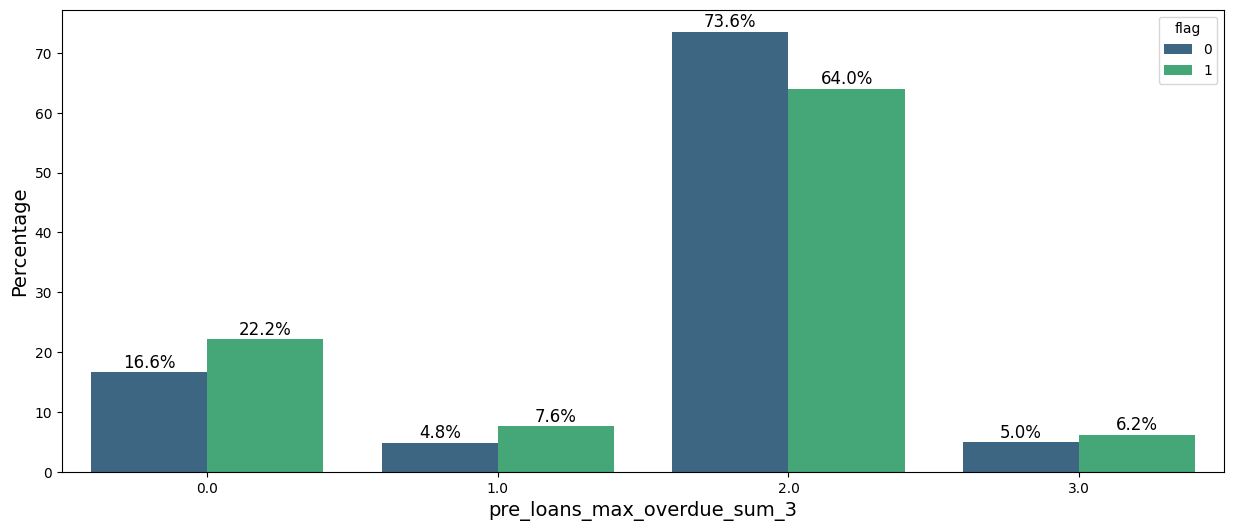

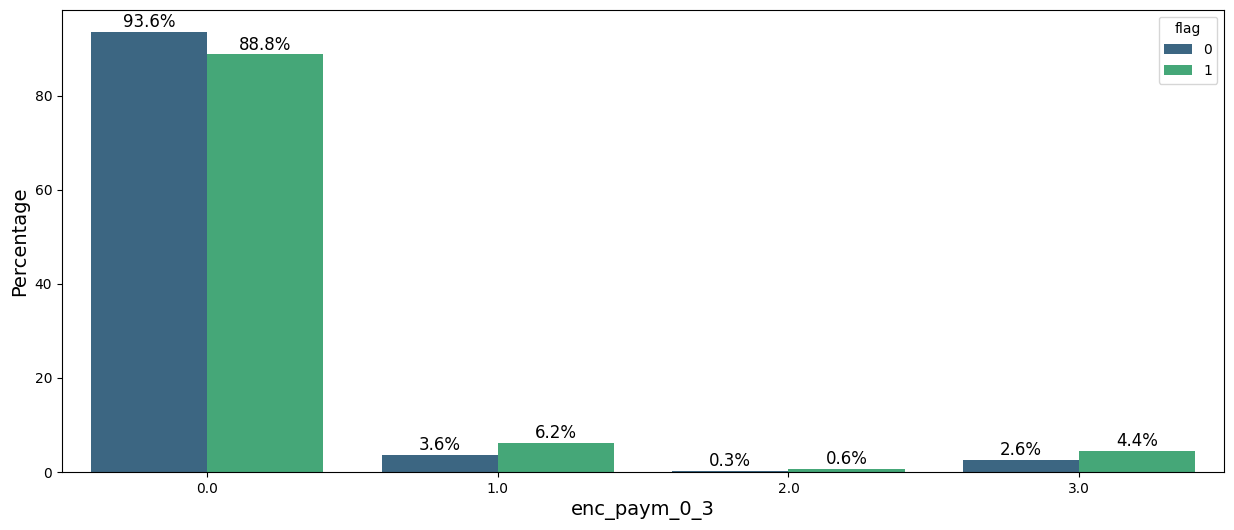

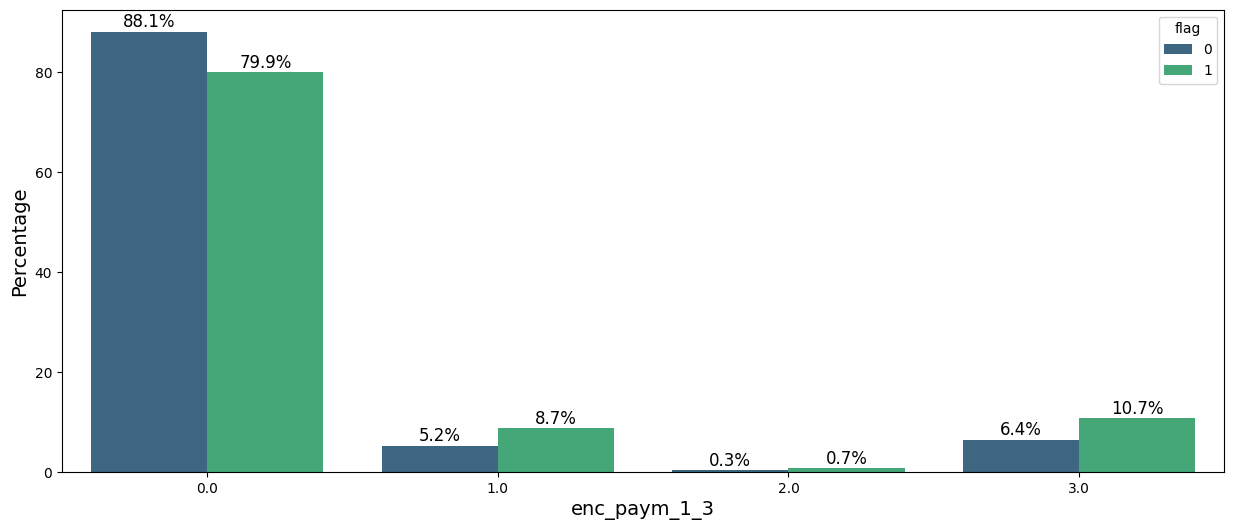

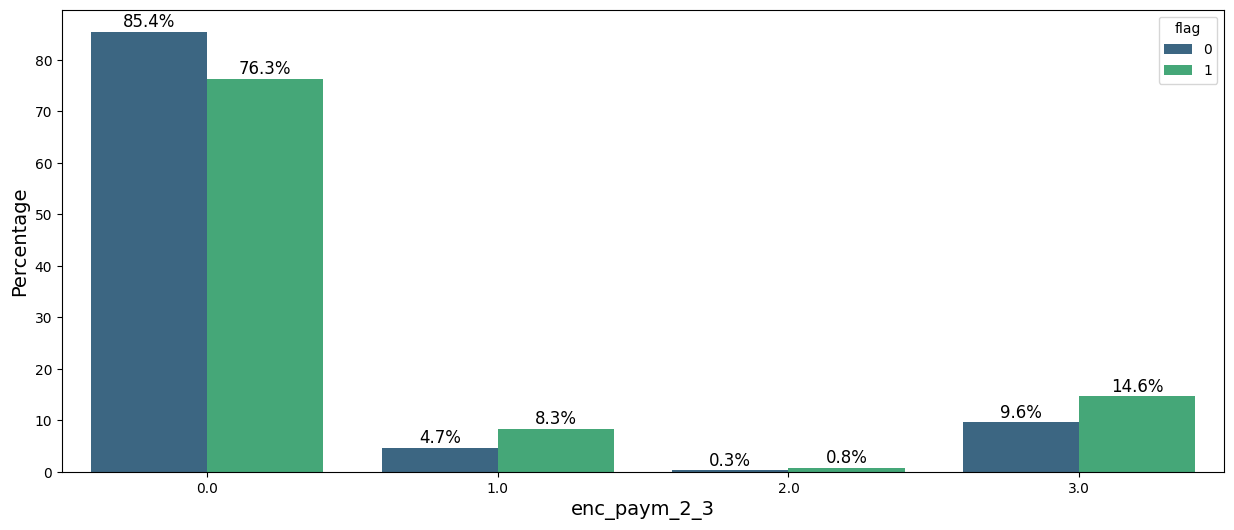

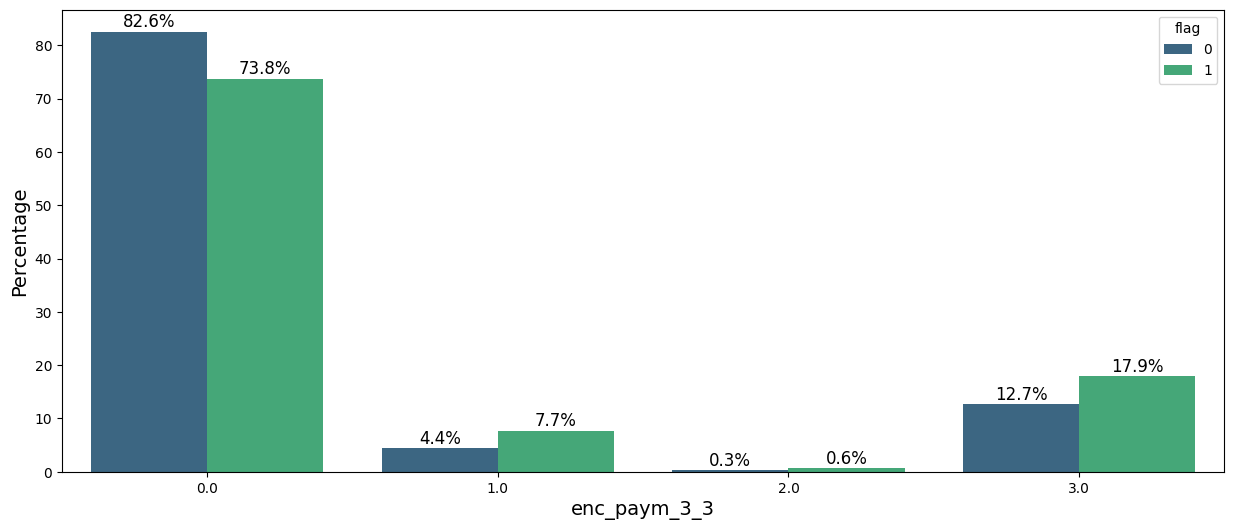

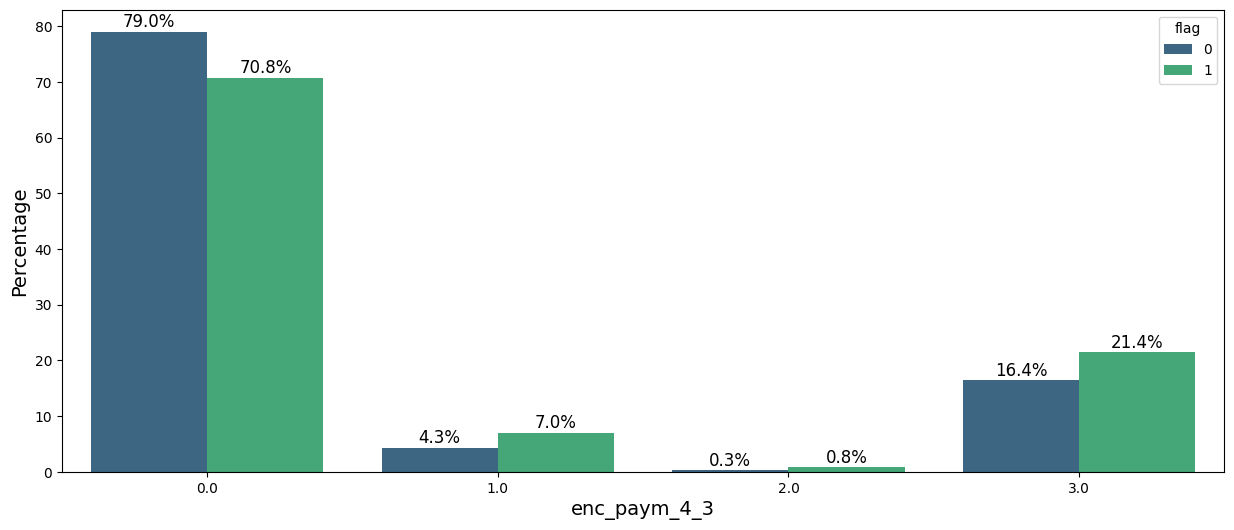

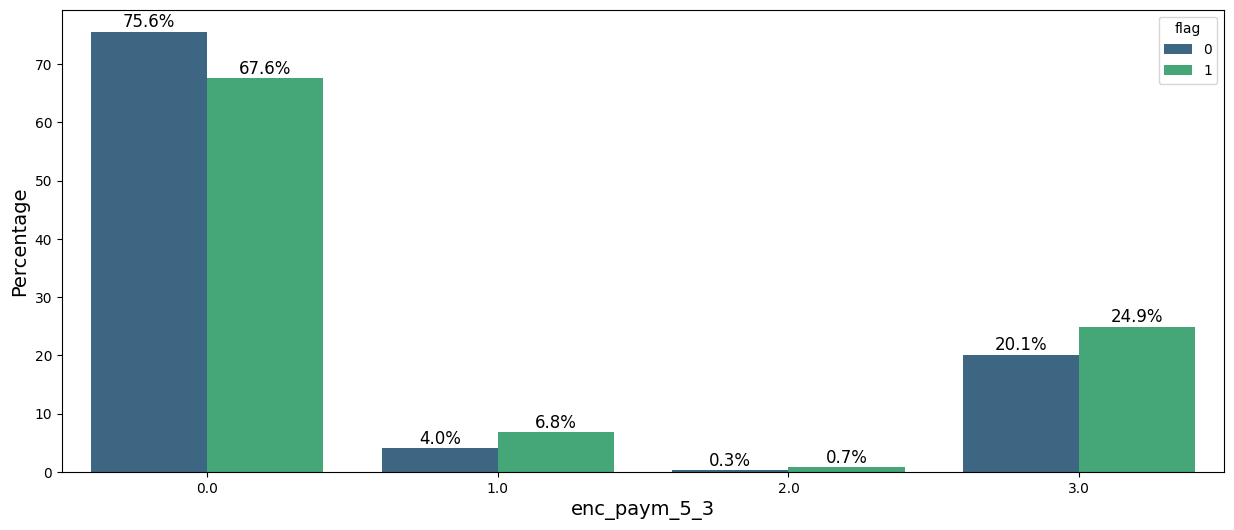

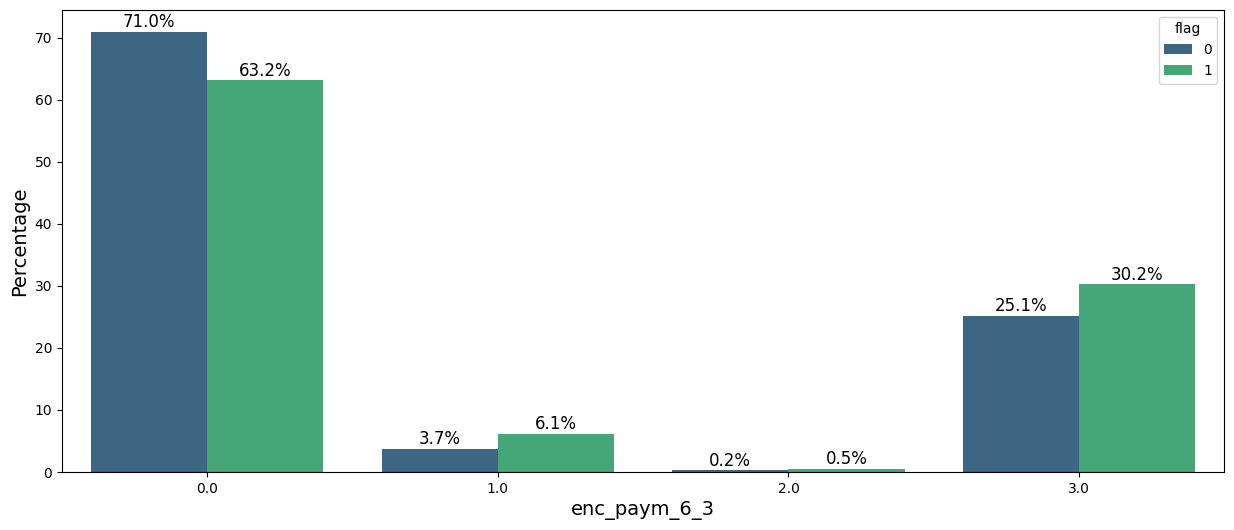

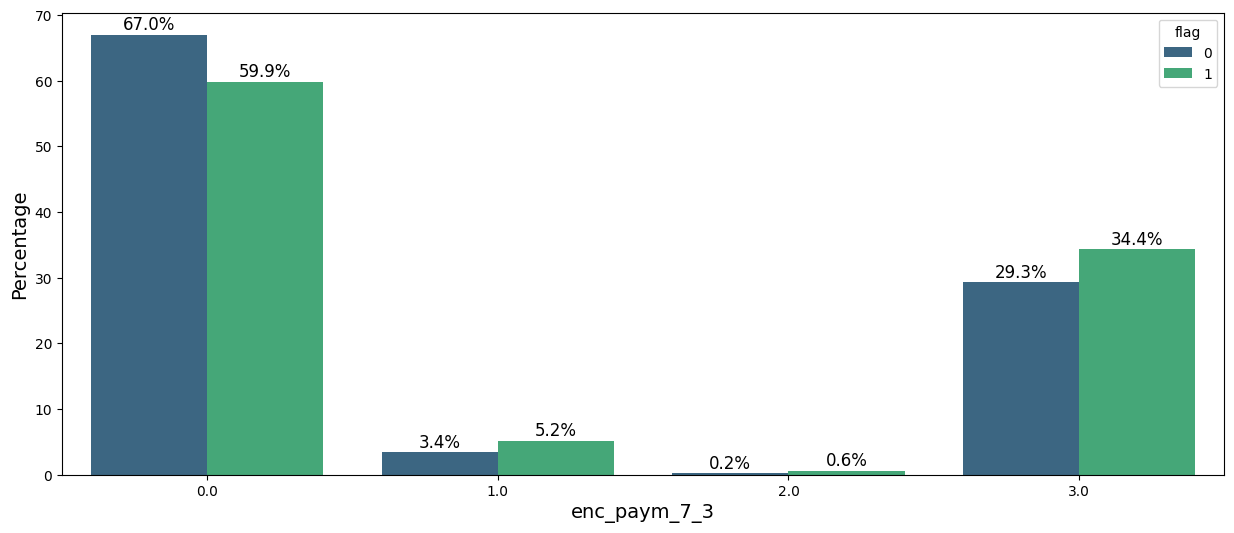

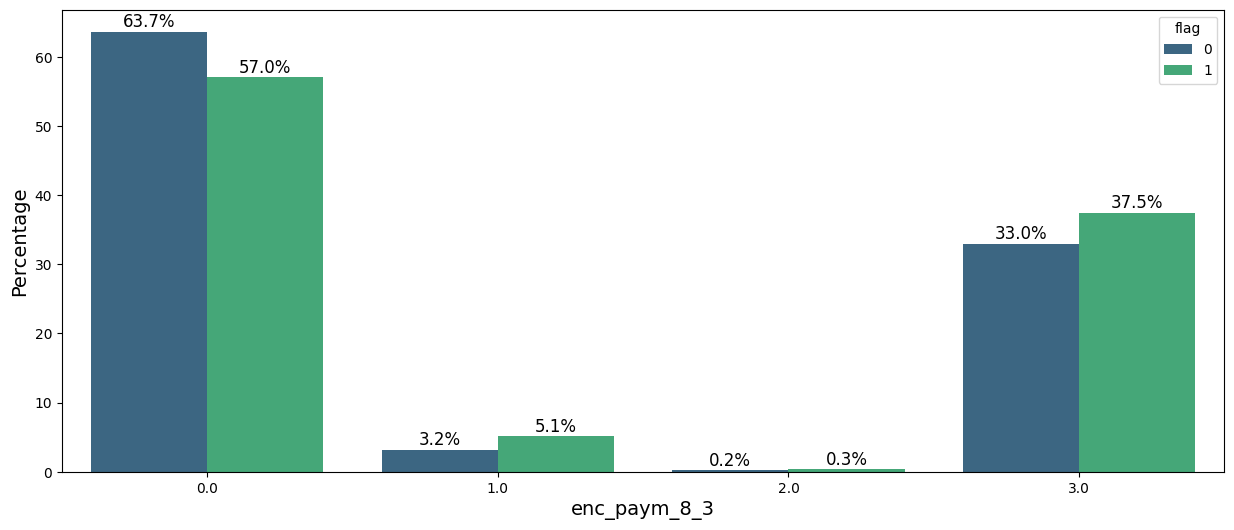

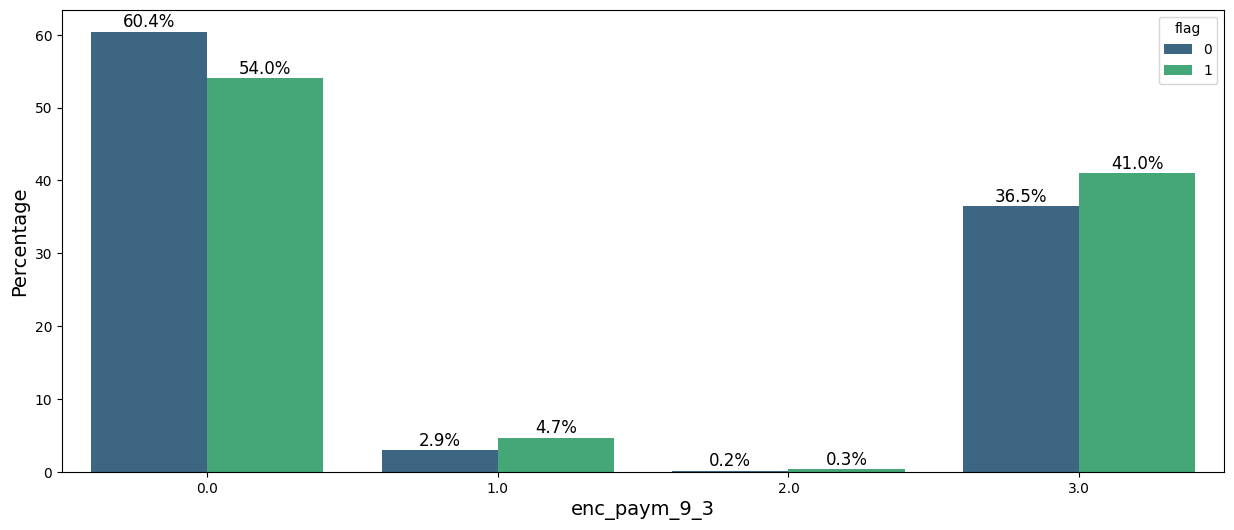

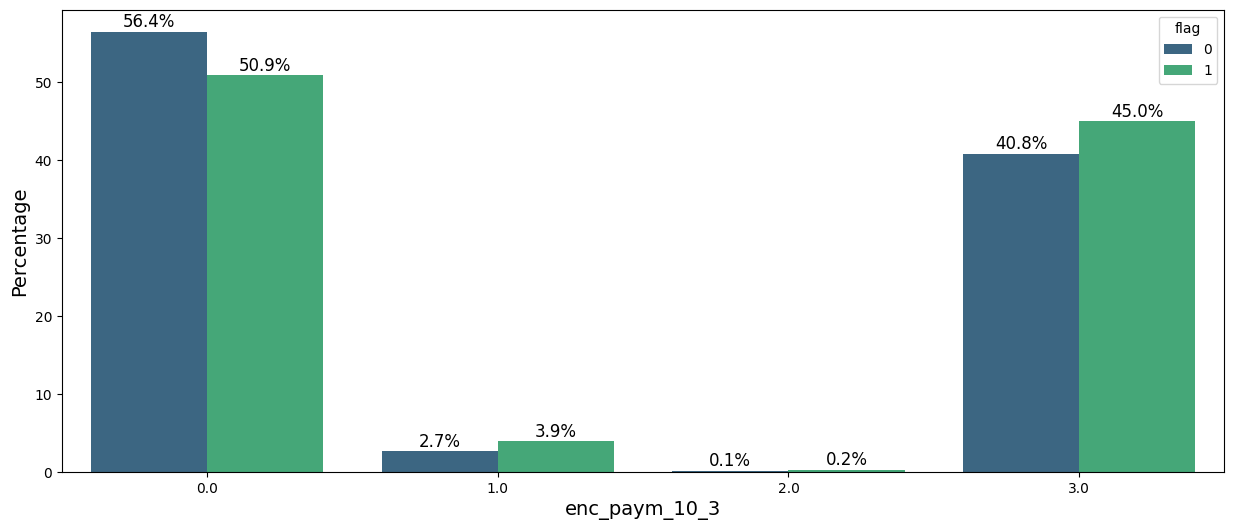

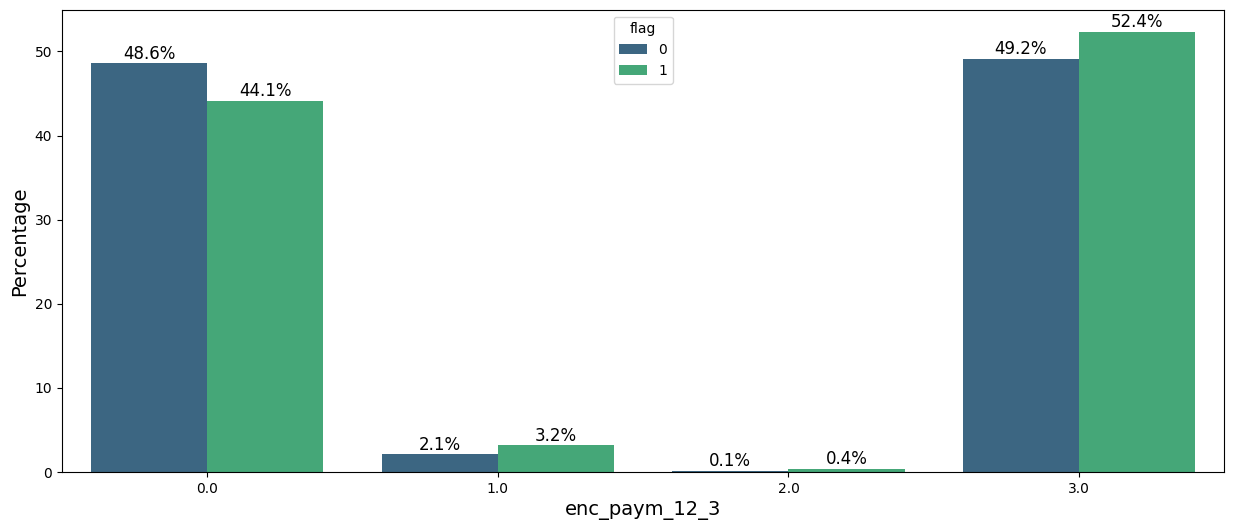

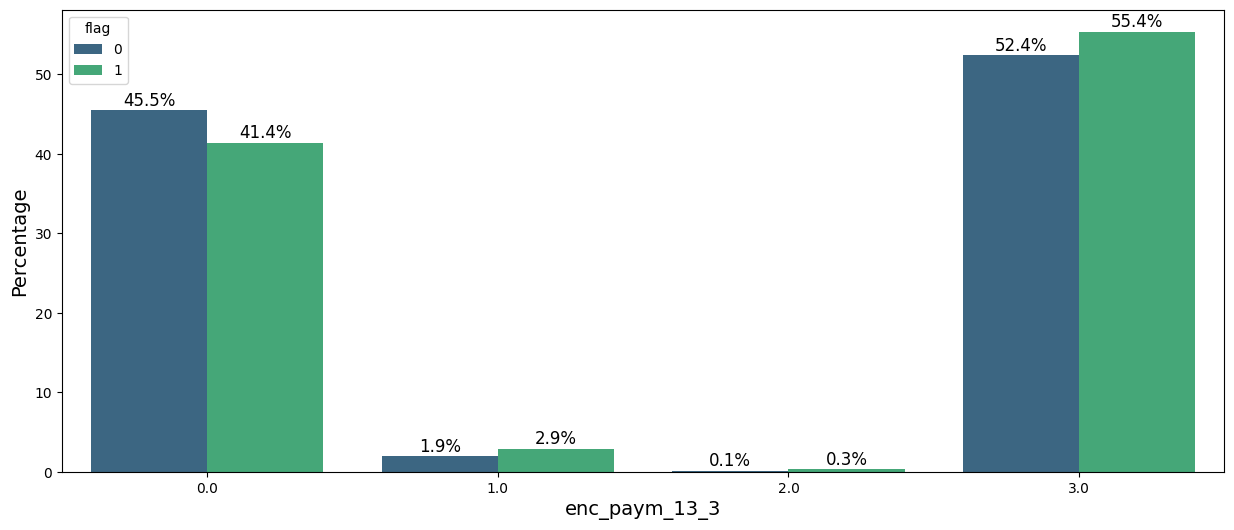

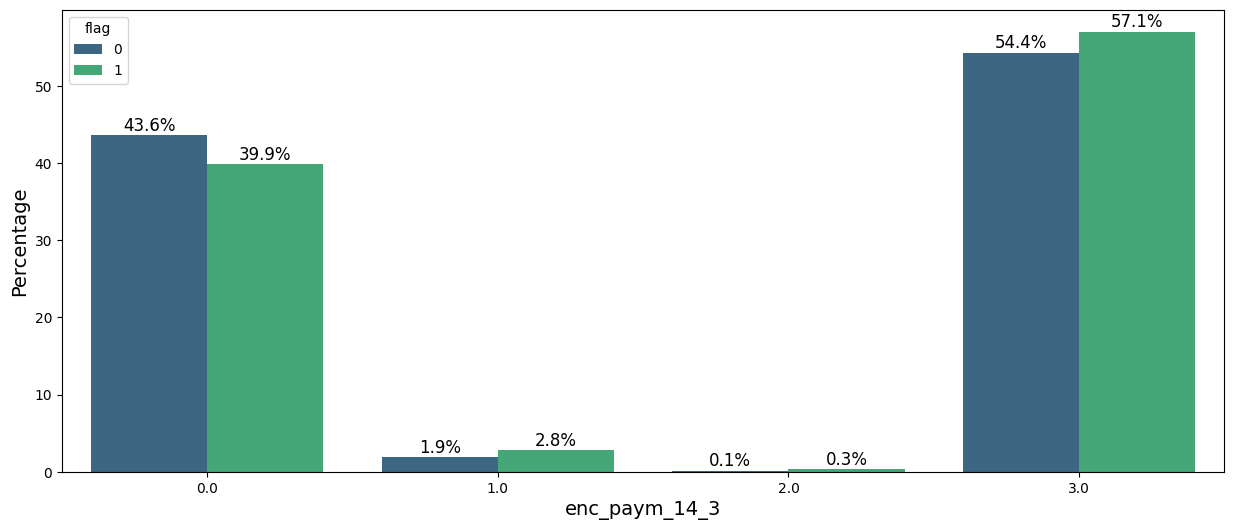

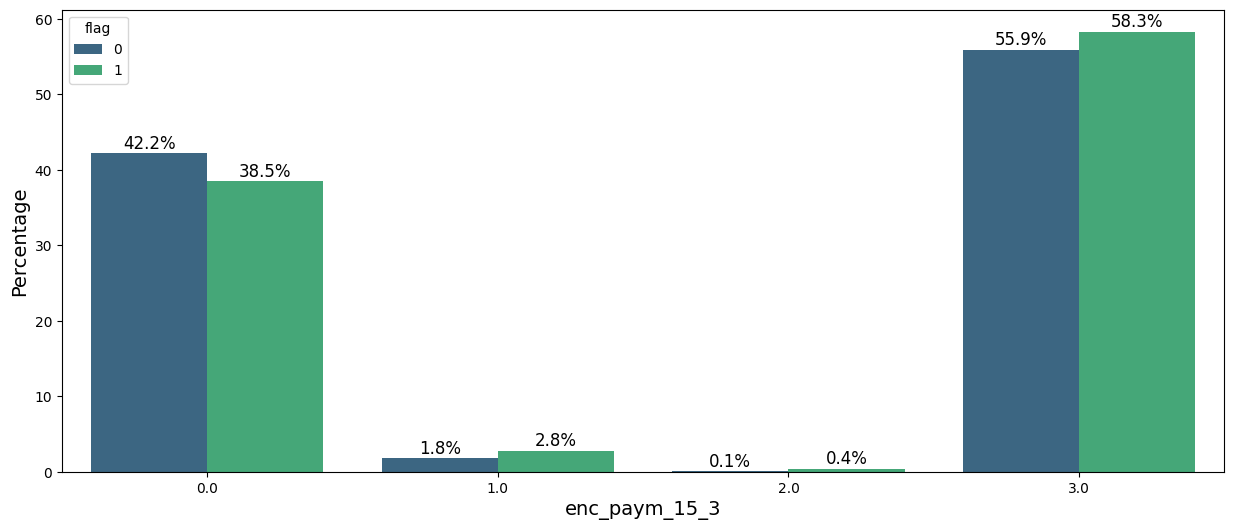

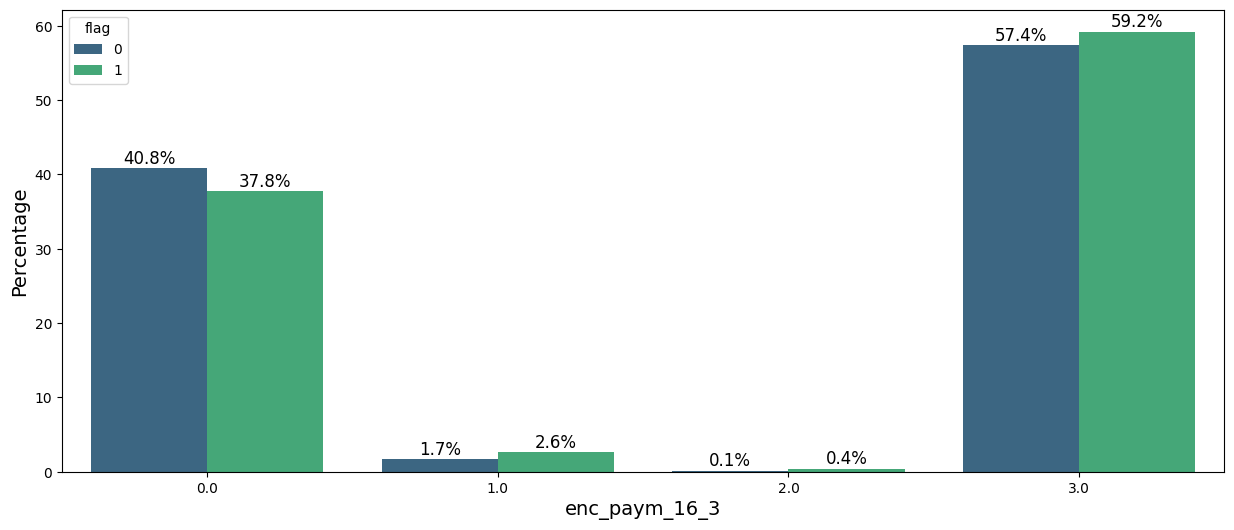

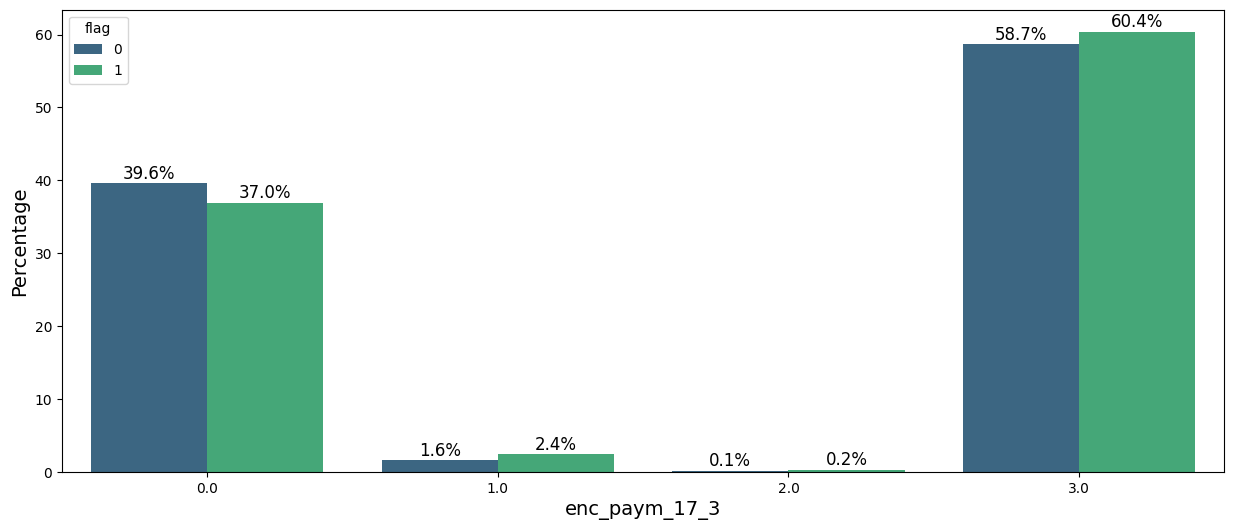

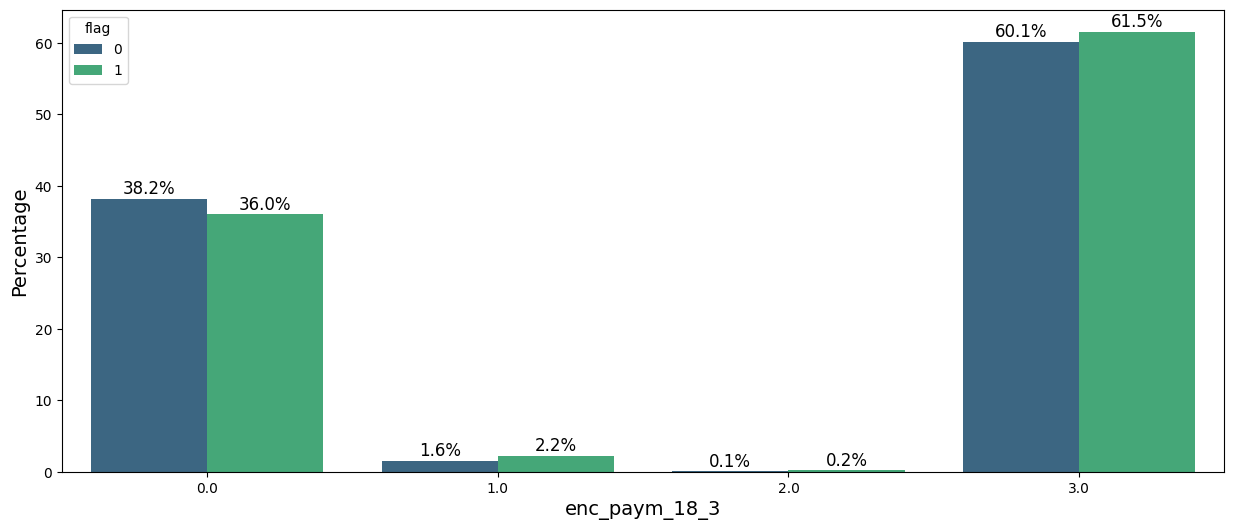

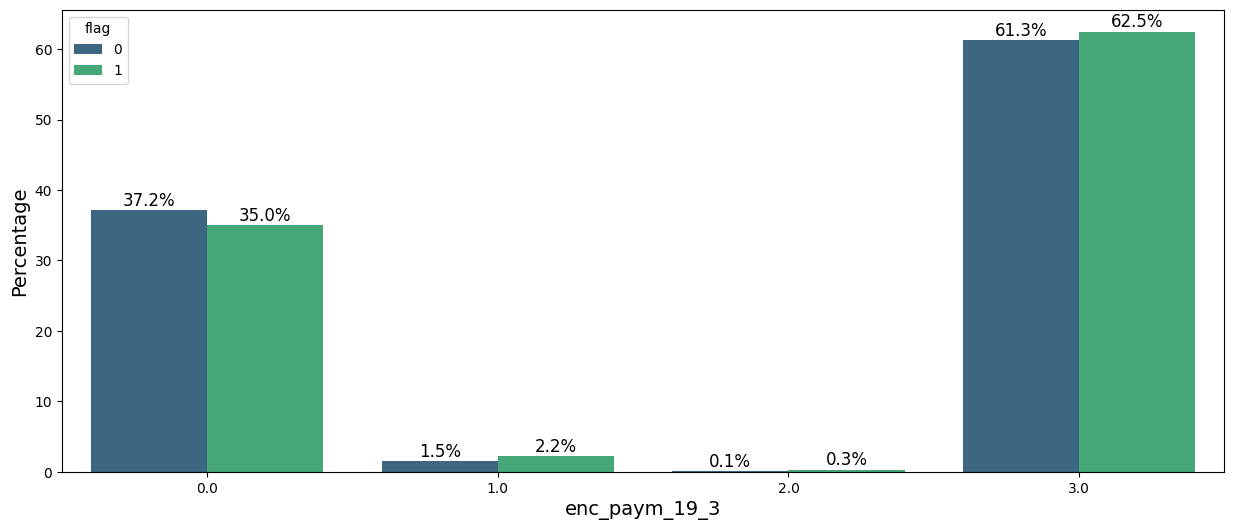

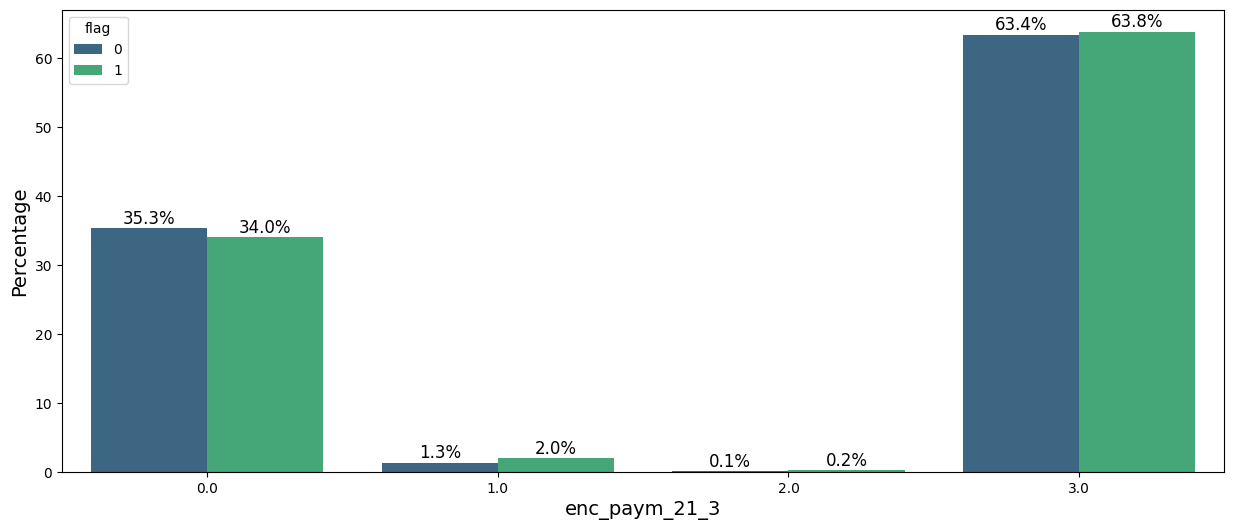

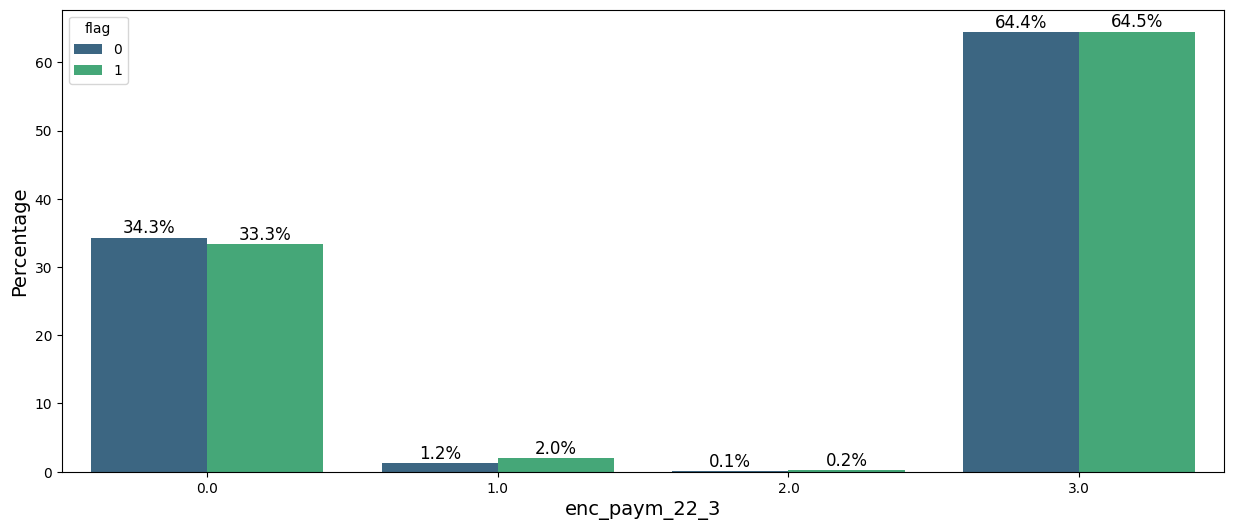

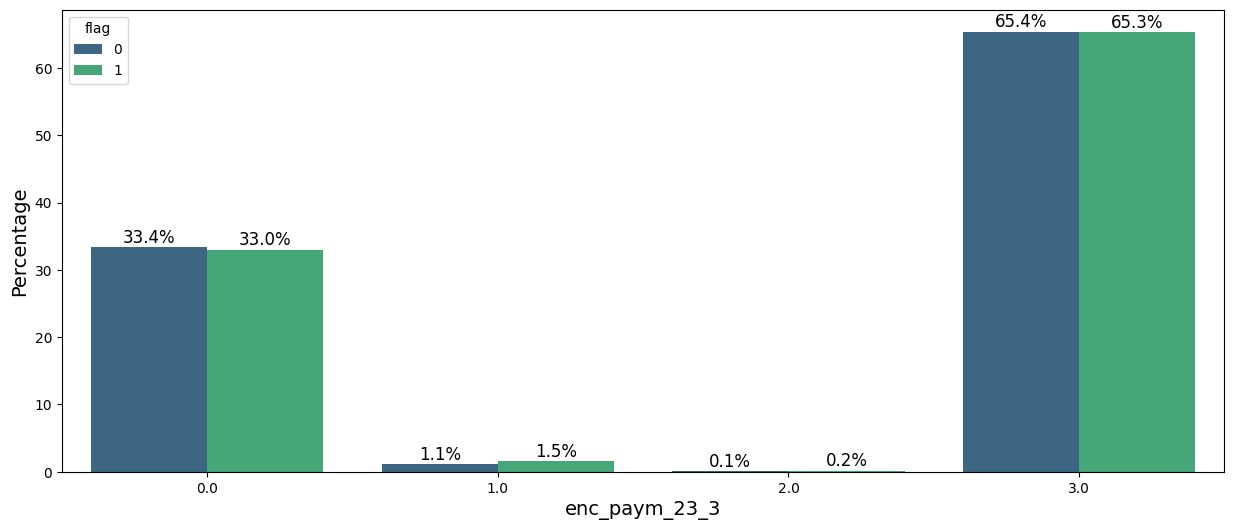

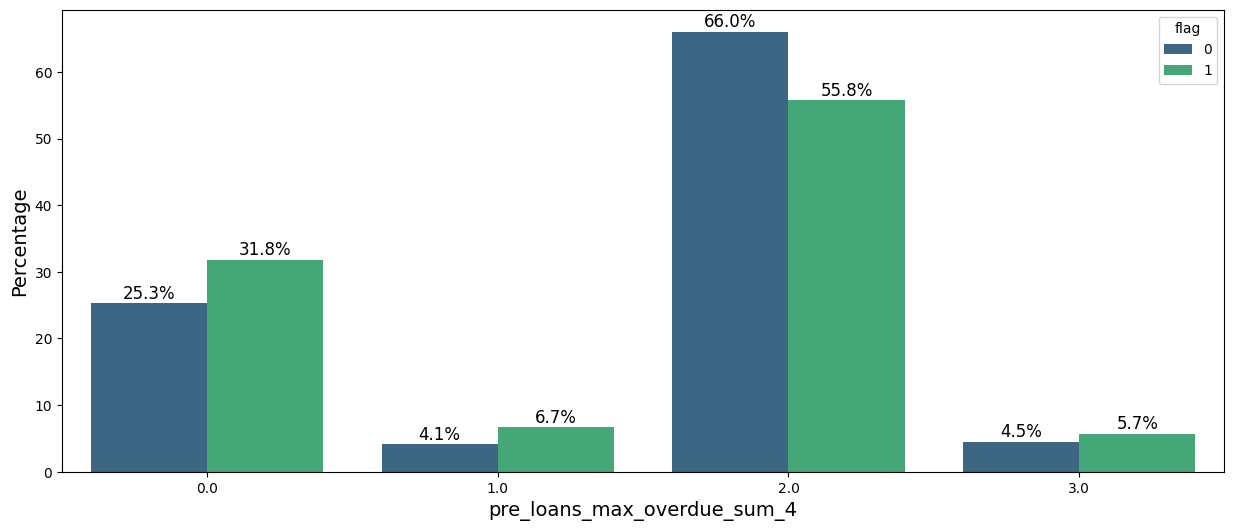

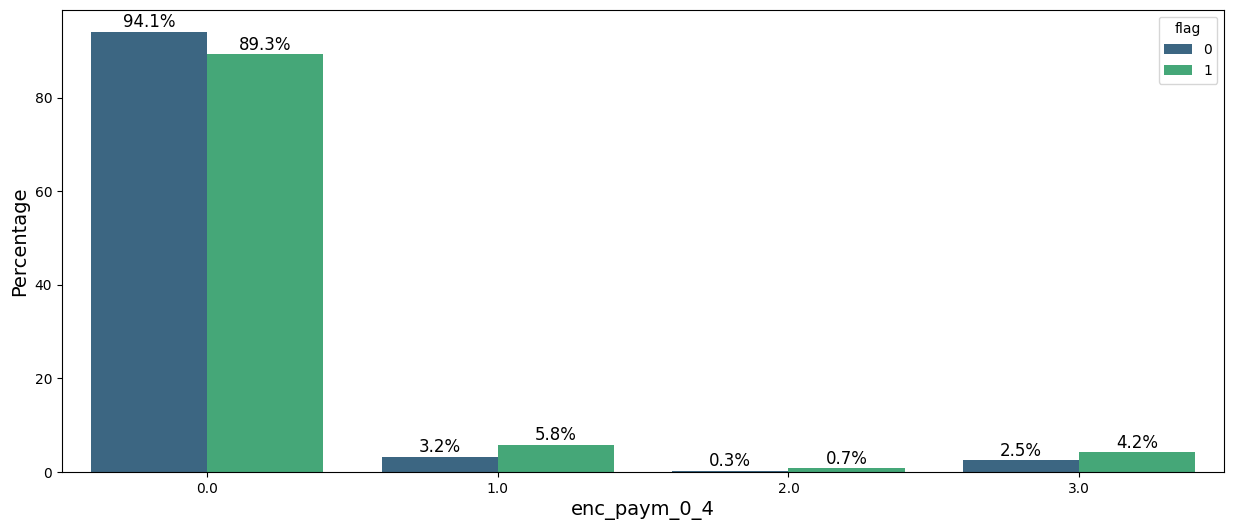

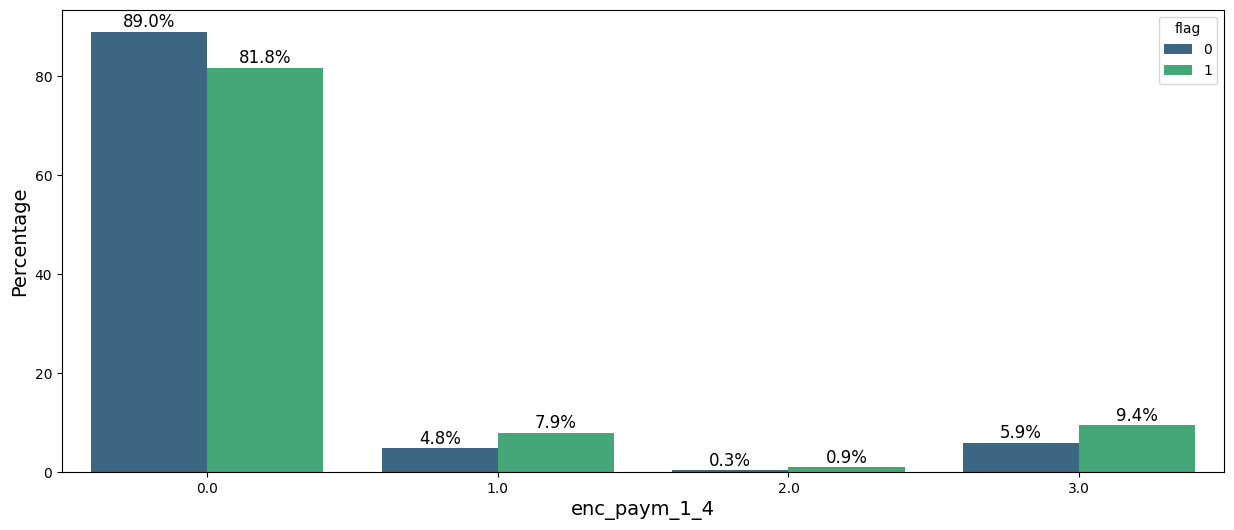

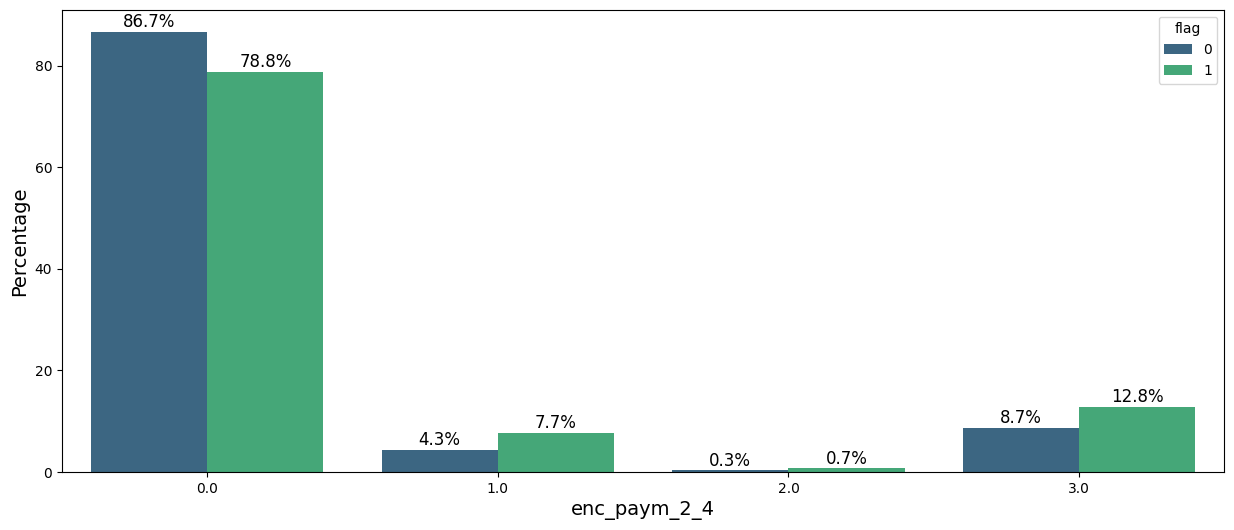

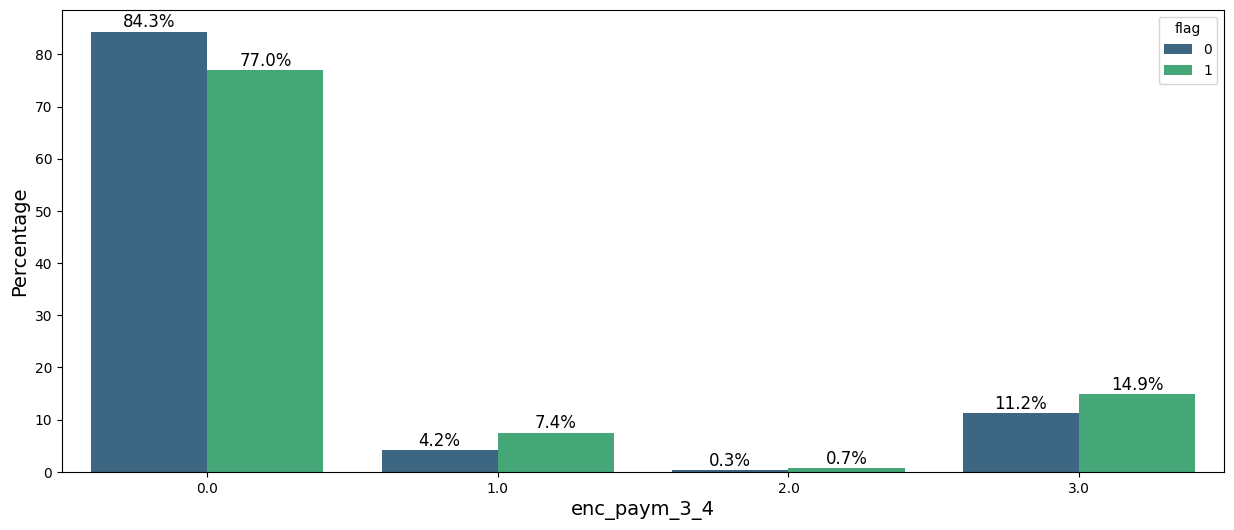

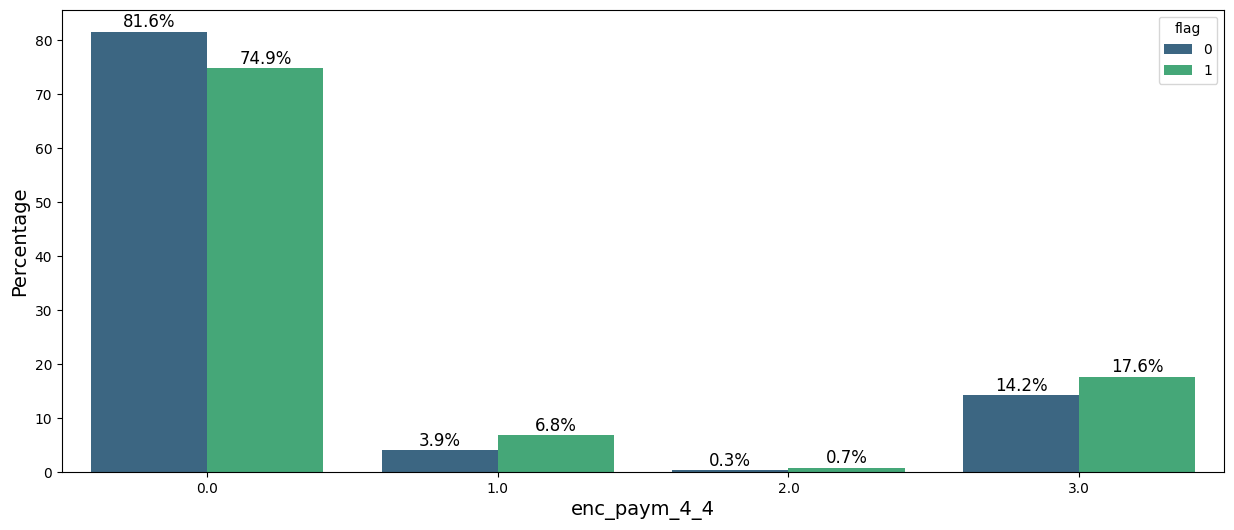

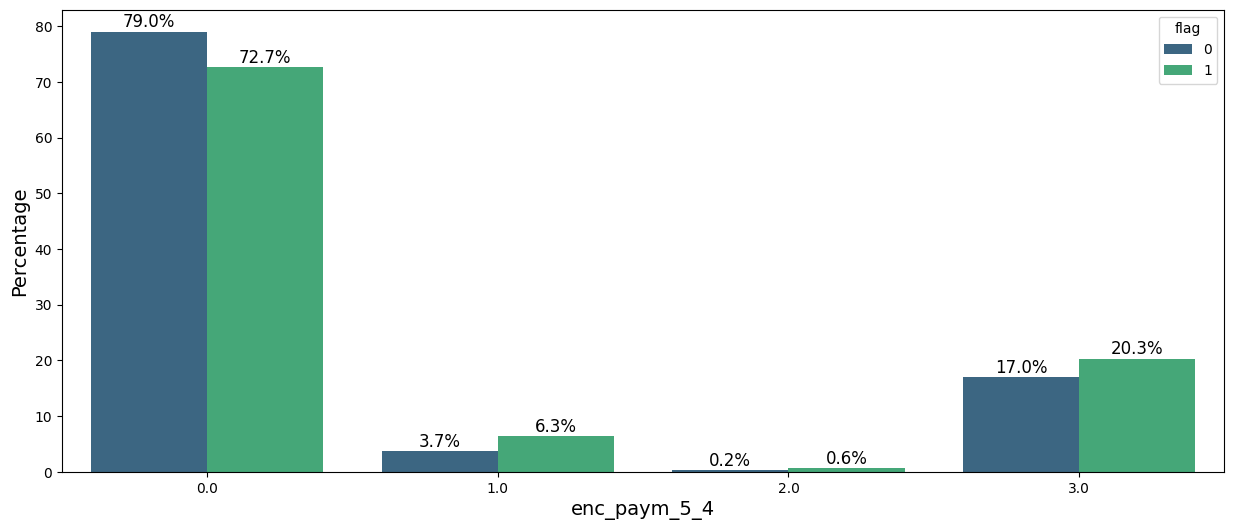

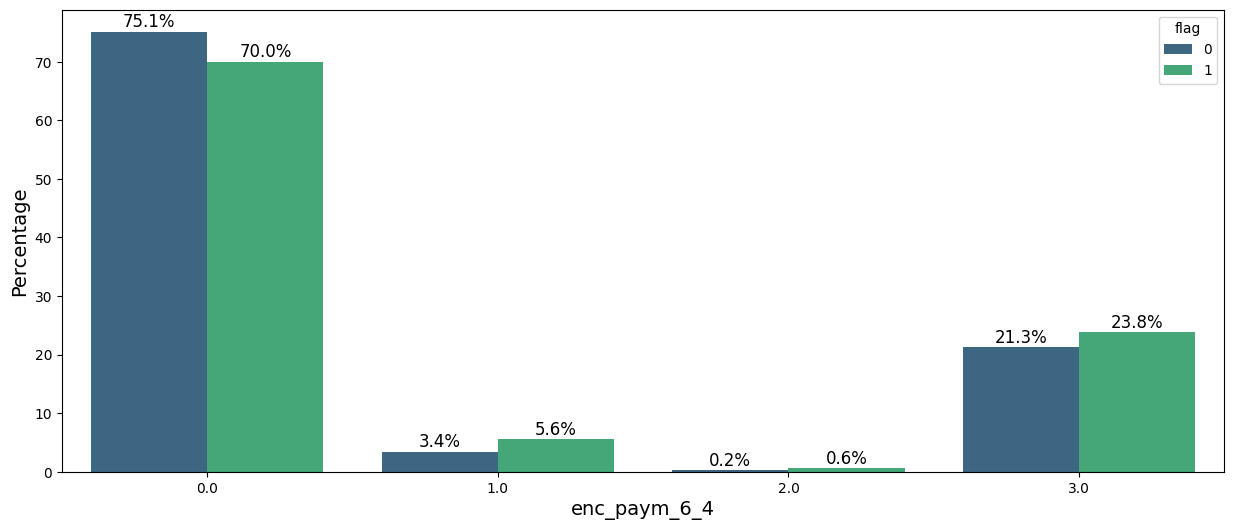

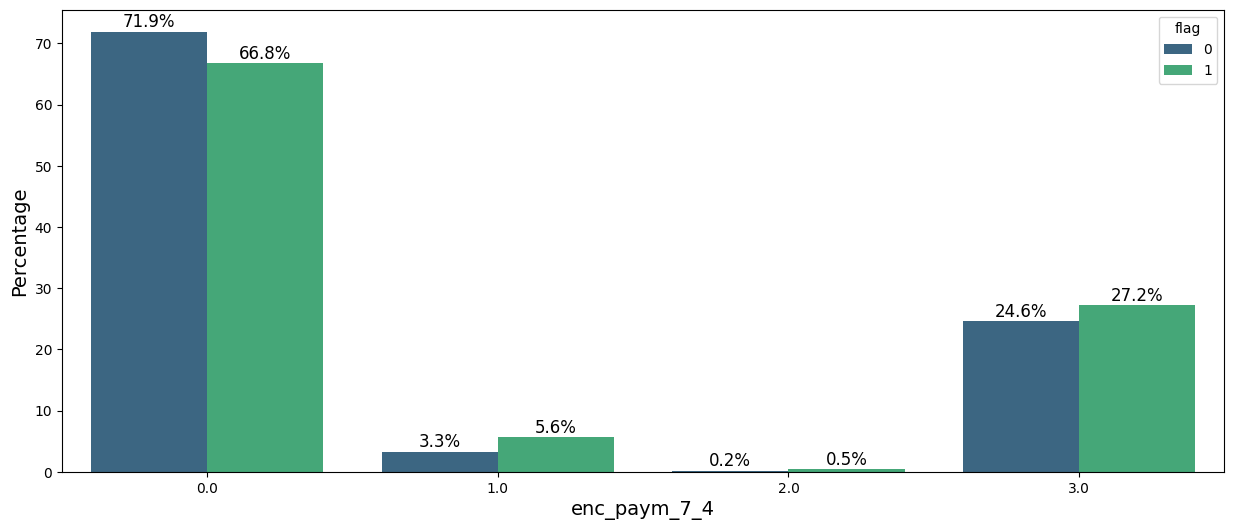

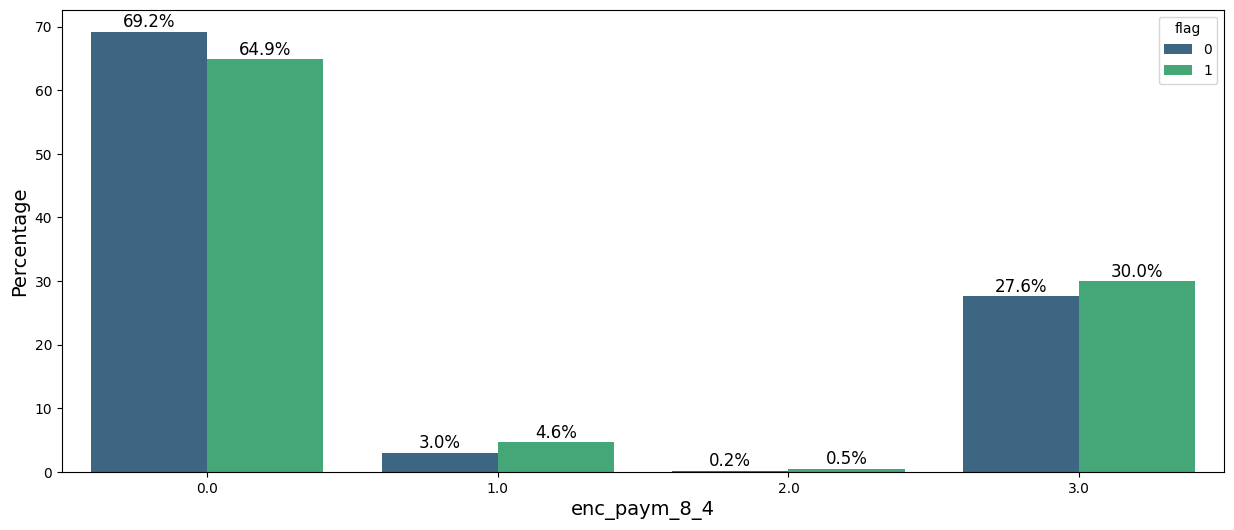

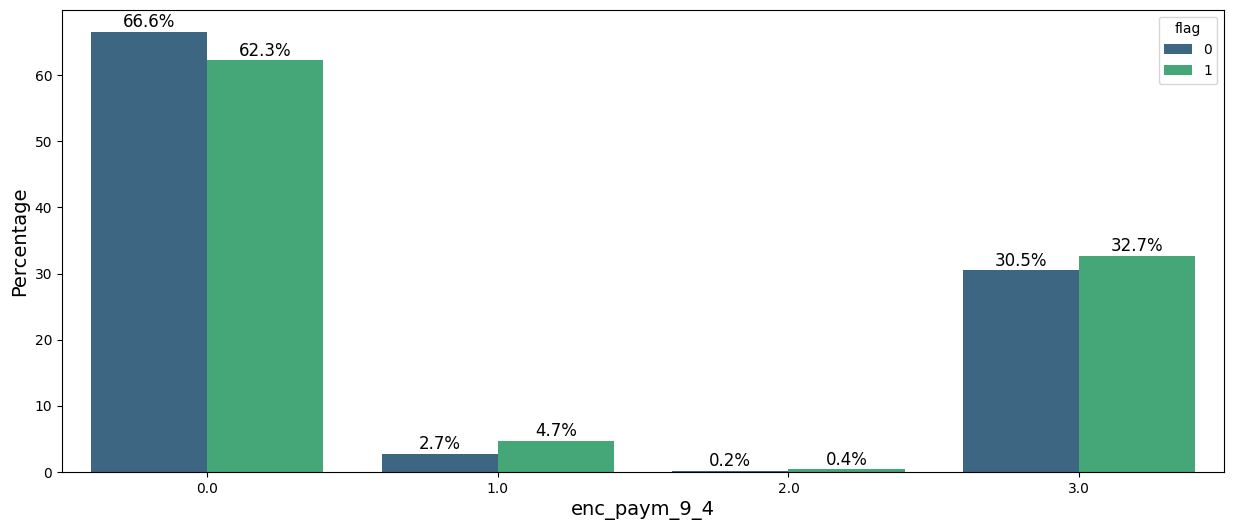

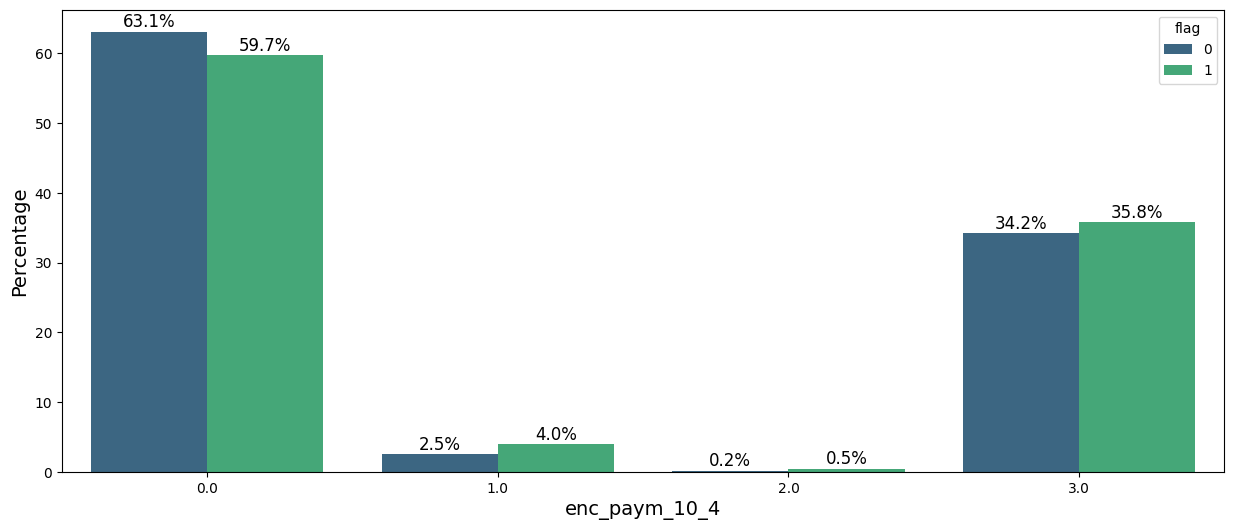

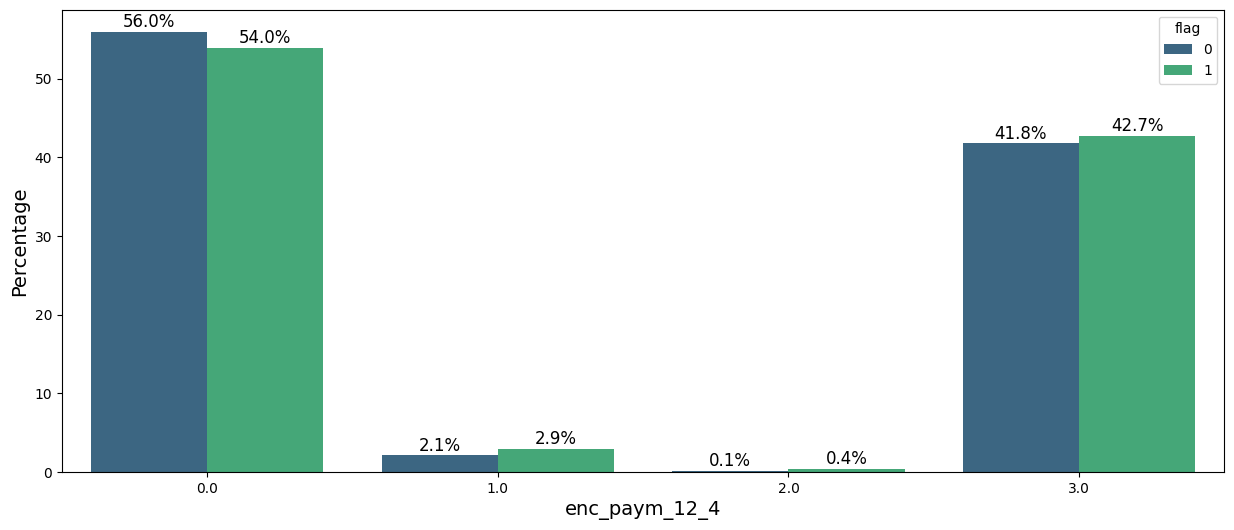

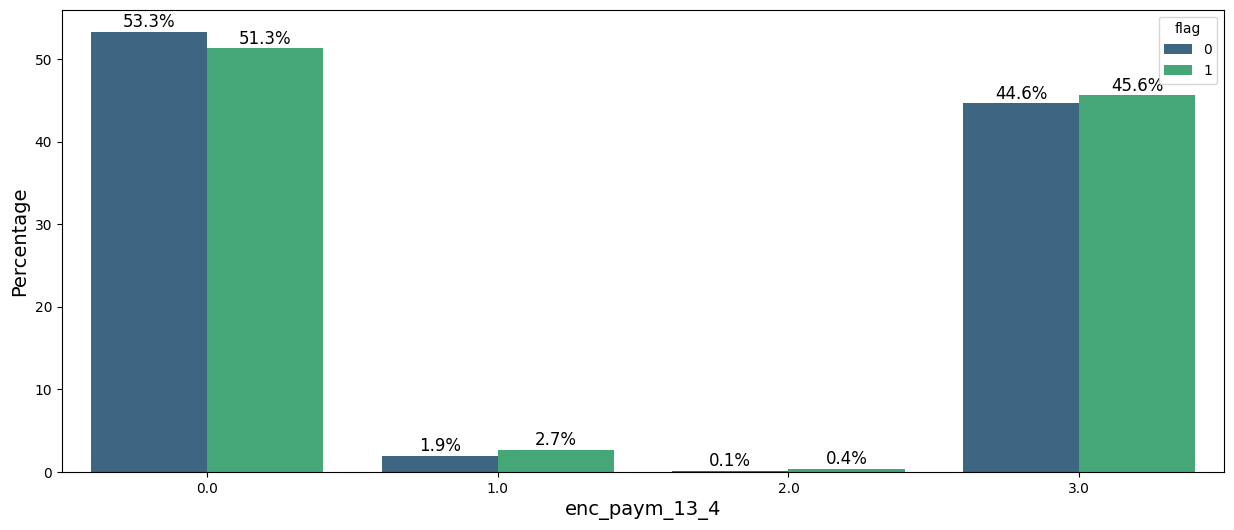

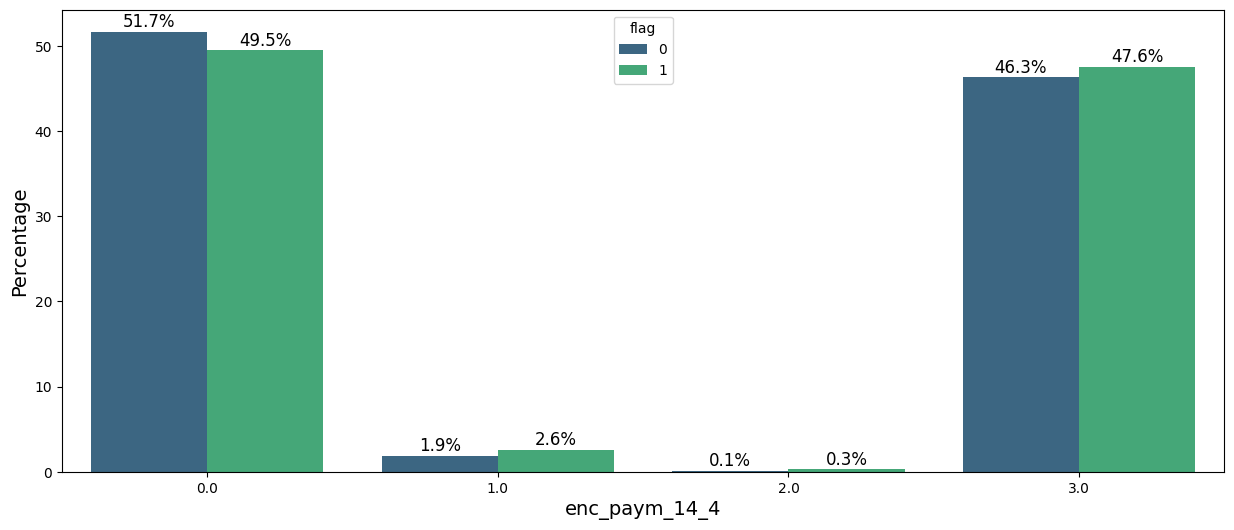

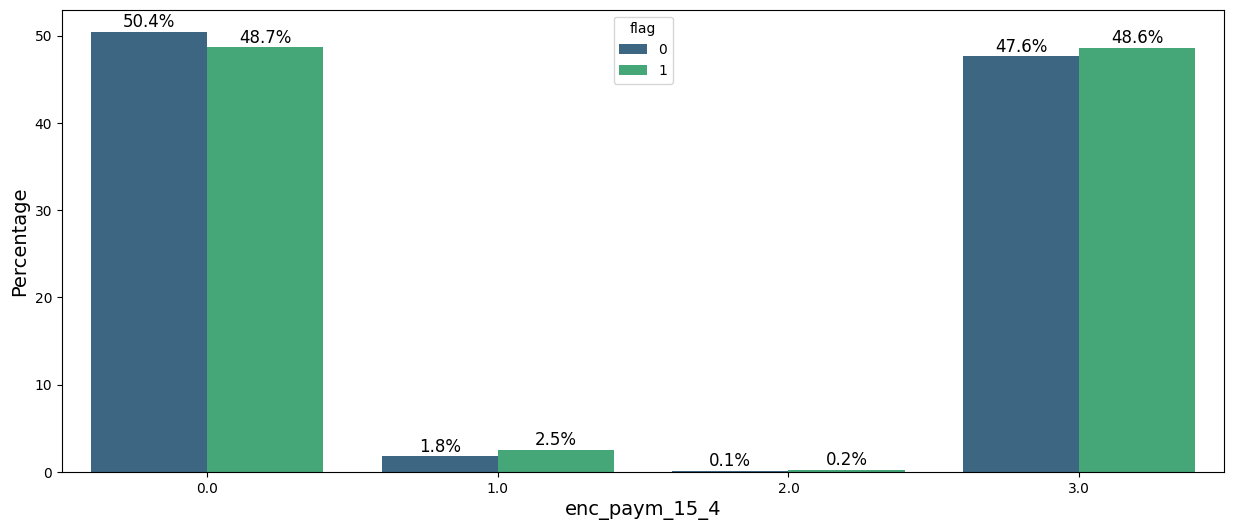

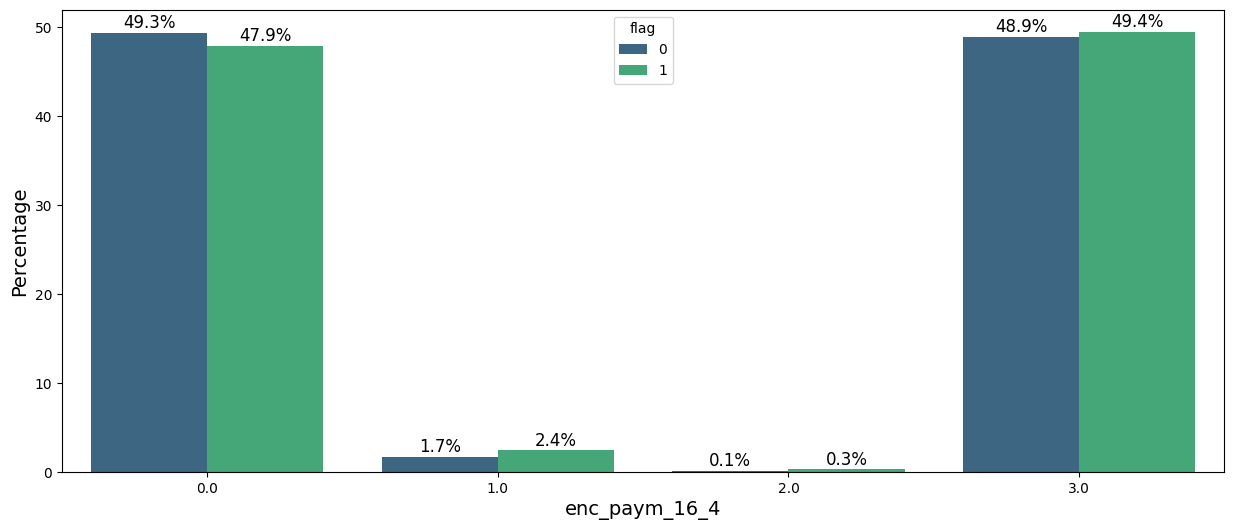

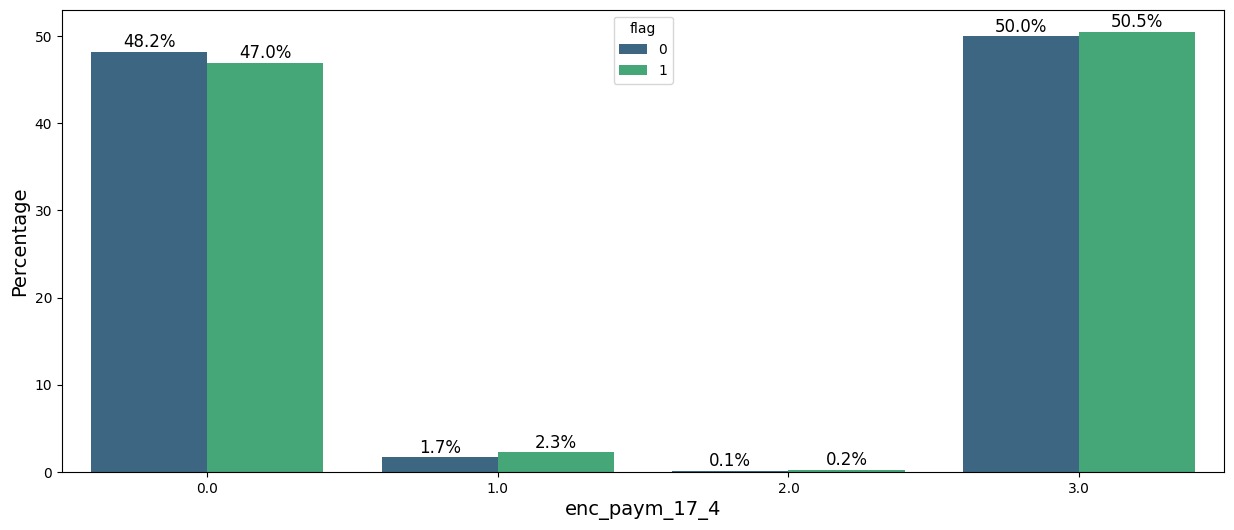

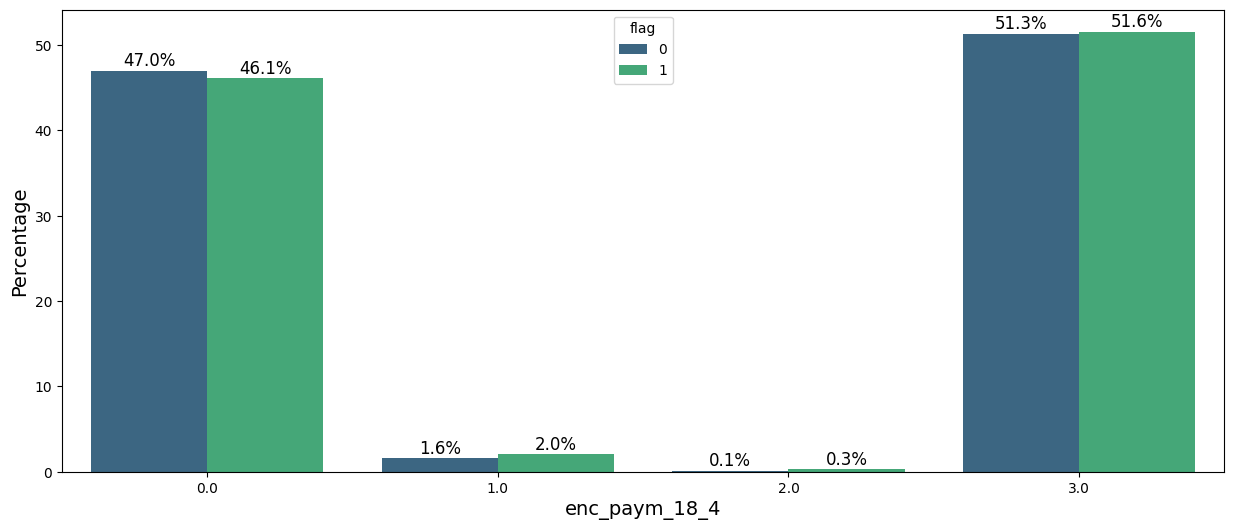

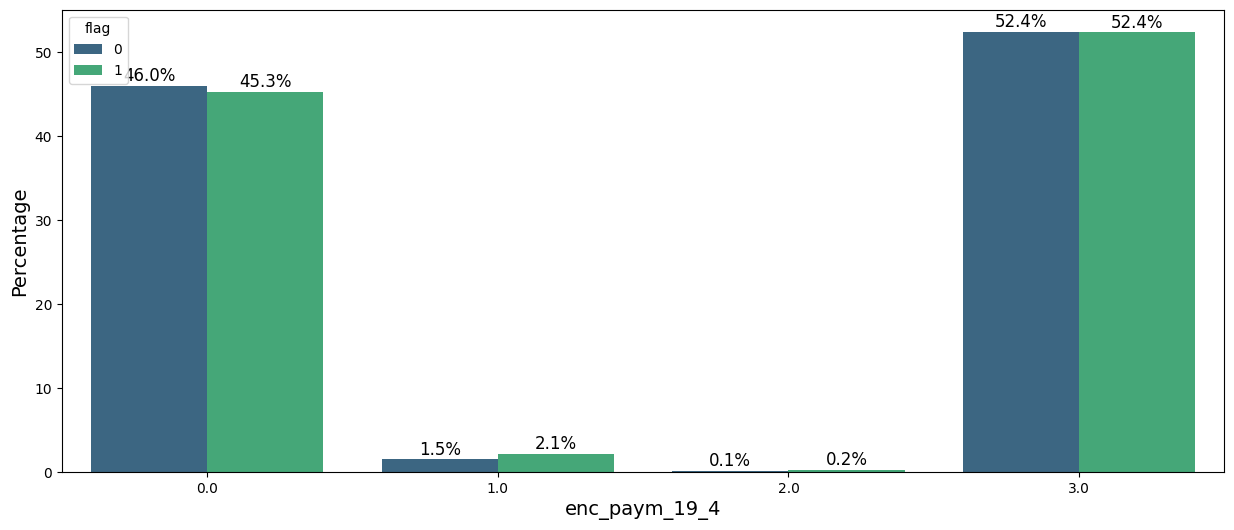

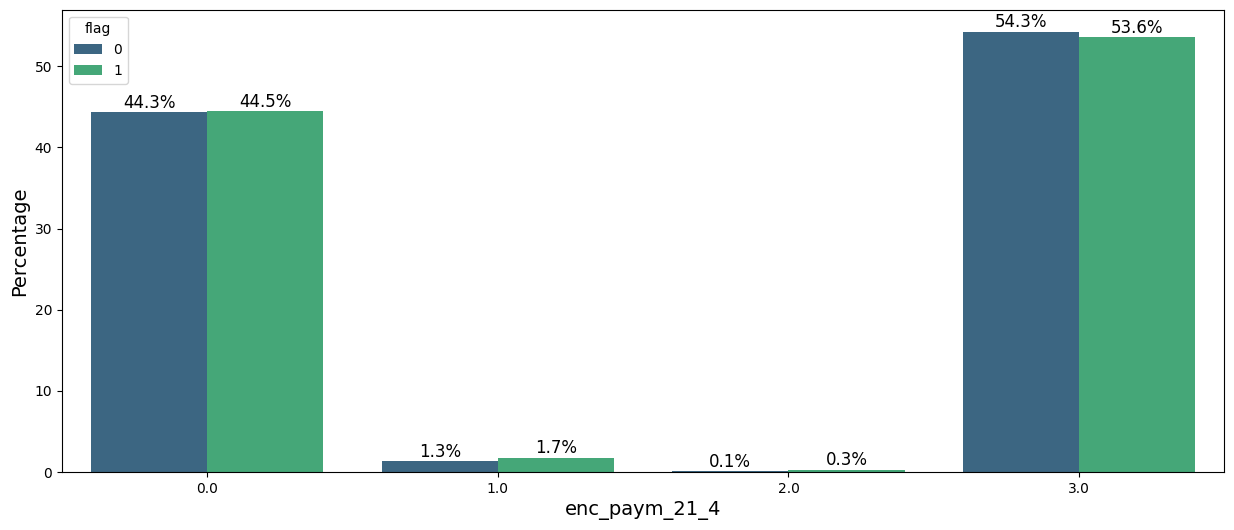

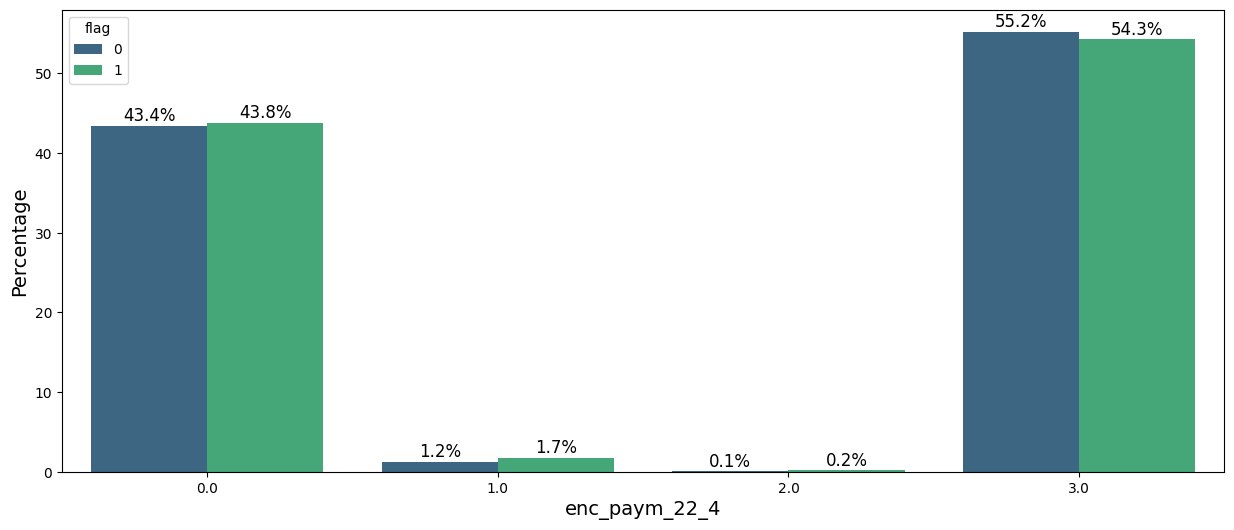

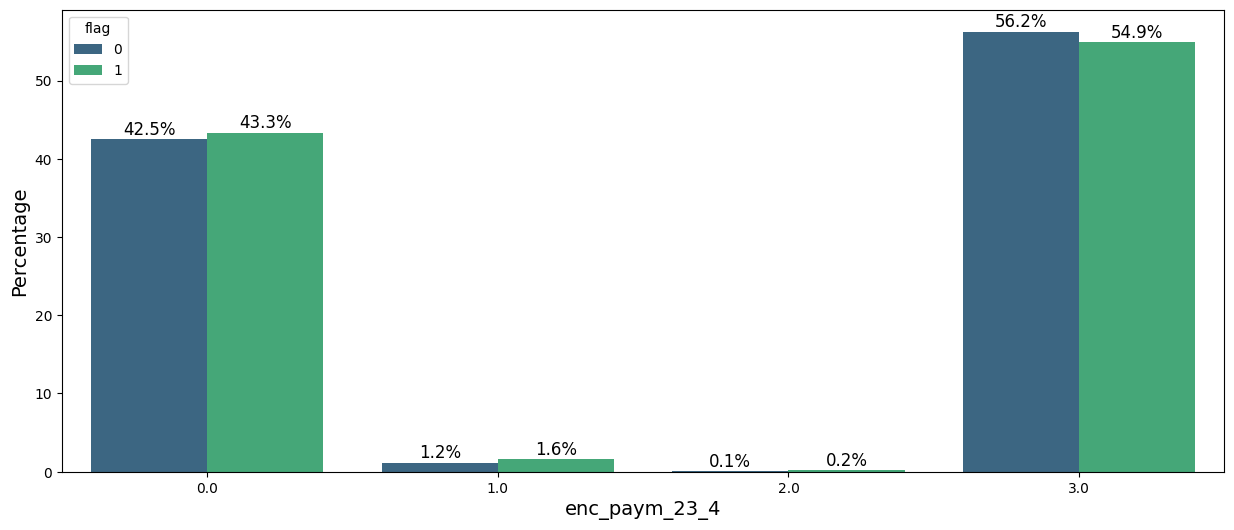

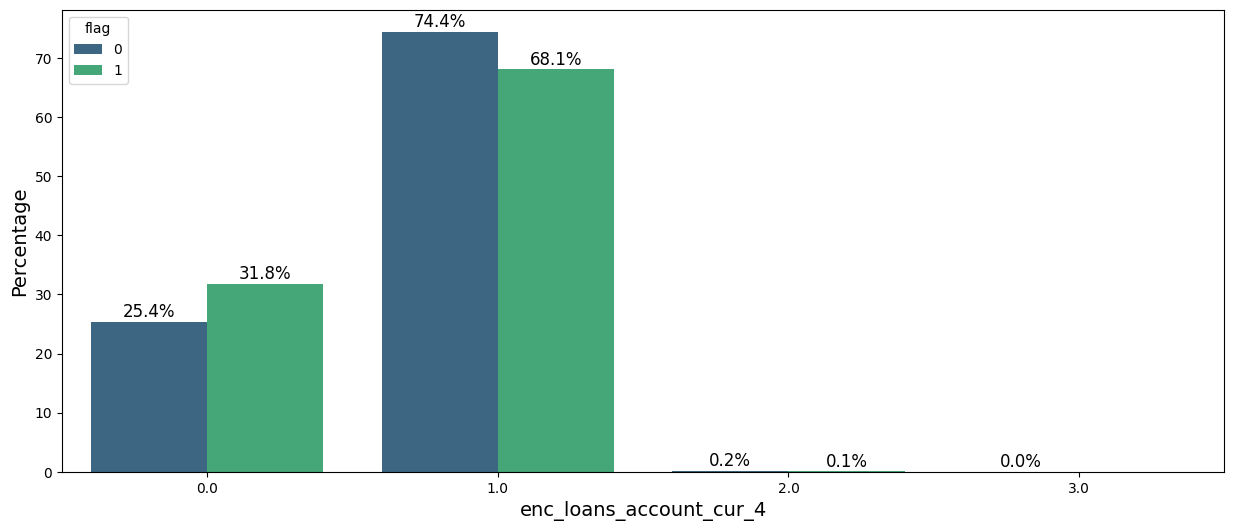

In [29]:
for col in df.nunique()[df.nunique() == 4].index:
    barplot_group(col, "flag")

In [30]:
df = df.drop(columns=["pre_loans3060",
                      "pre_loans90",
                      "enc_paym_22",
                      "enc_paym_23",
                      "enc_paym_24",
                      "enc_paym_17_2",
                      "enc_paym_18_2",
                      "enc_paym_19_2",
                      "enc_paym_21_2",
                      "enc_paym_22_2",
                      "enc_paym_23_2",
                      "enc_paym_15_3",
                      "enc_paym_16_3",
                      "enc_paym_17_3",
                      "enc_paym_18_3",
                      "enc_paym_19_3",
                      "enc_paym_21_3",
                      "enc_paym_22_3",
                      "enc_paym_23_3",
                      "enc_paym_10_4",
                      "enc_paym_12_4",
                      "enc_paym_13_4",
                      "enc_paym_14_4",
                      "enc_paym_15_4",
                      "enc_paym_16_4",
                      "enc_paym_17_4",
                      "enc_paym_18_4",
                      "enc_paym_19_4",
                      "enc_paym_21_4",
                      "enc_paym_22_4",
                      "enc_paym_23_4"
                     ])

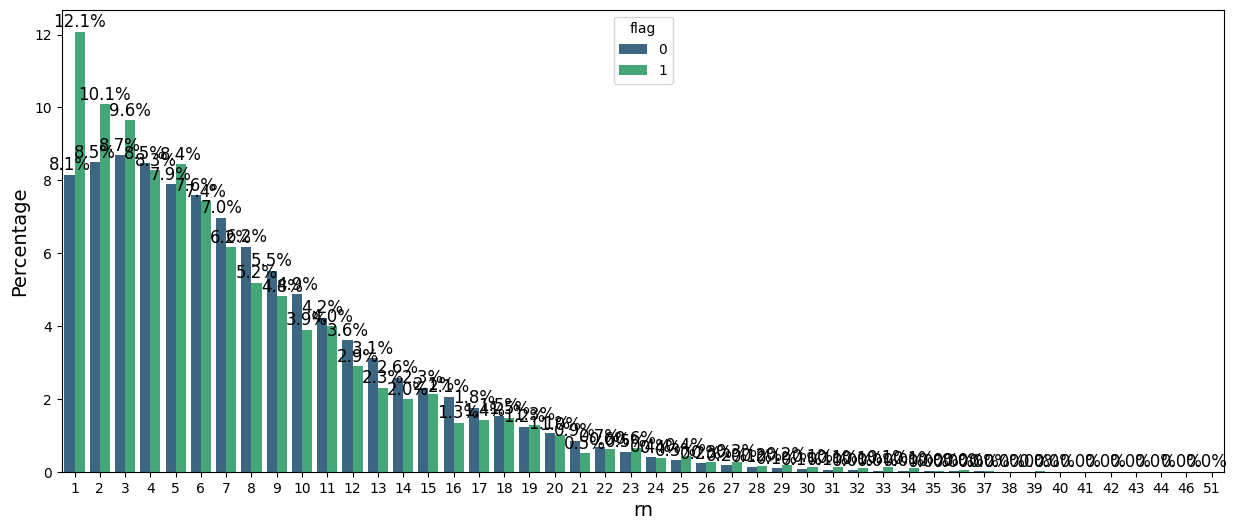

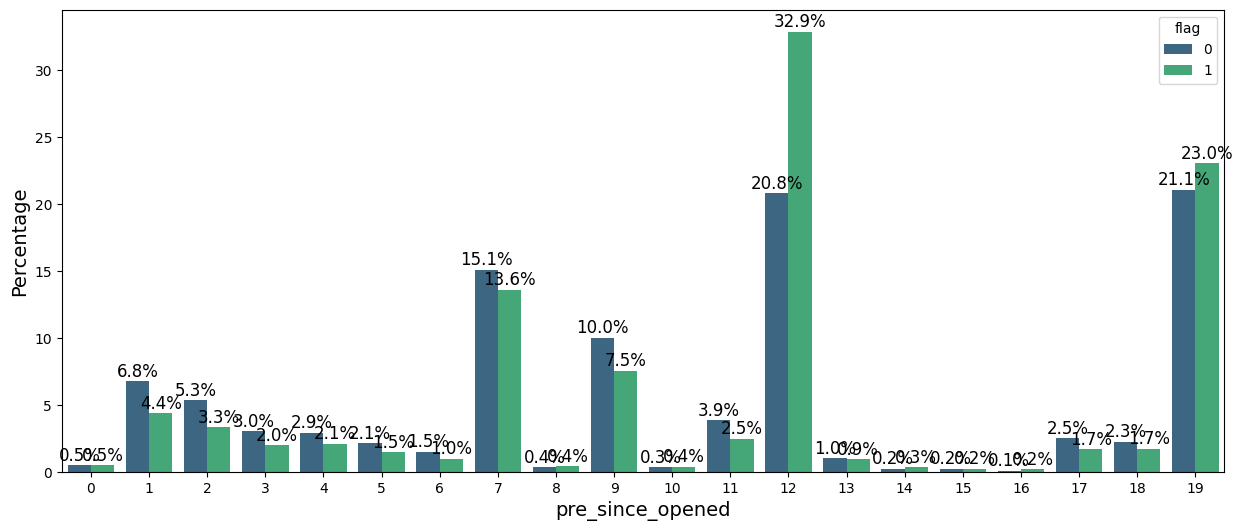

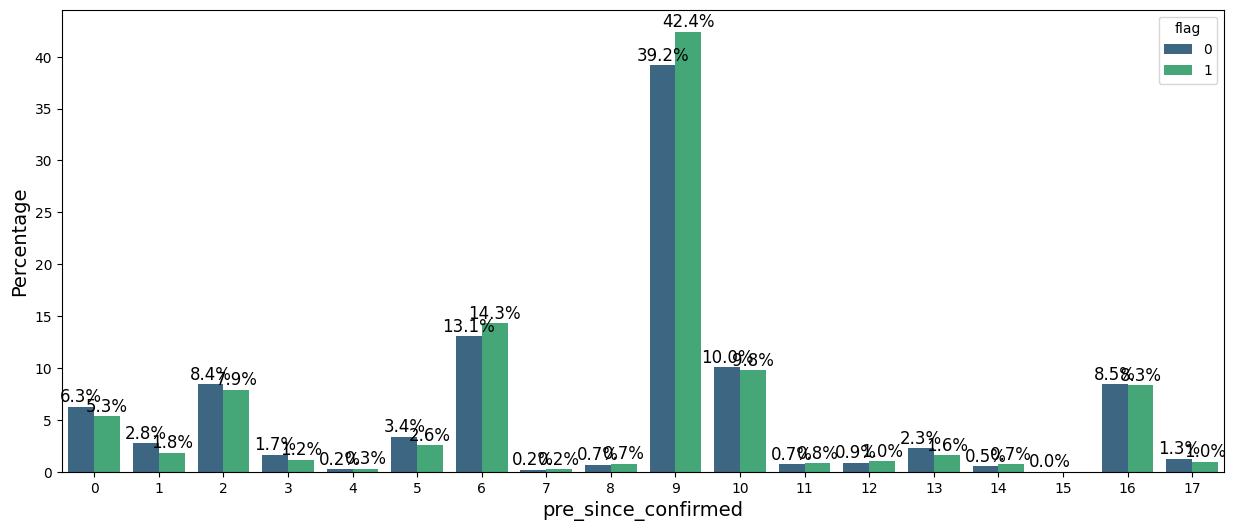

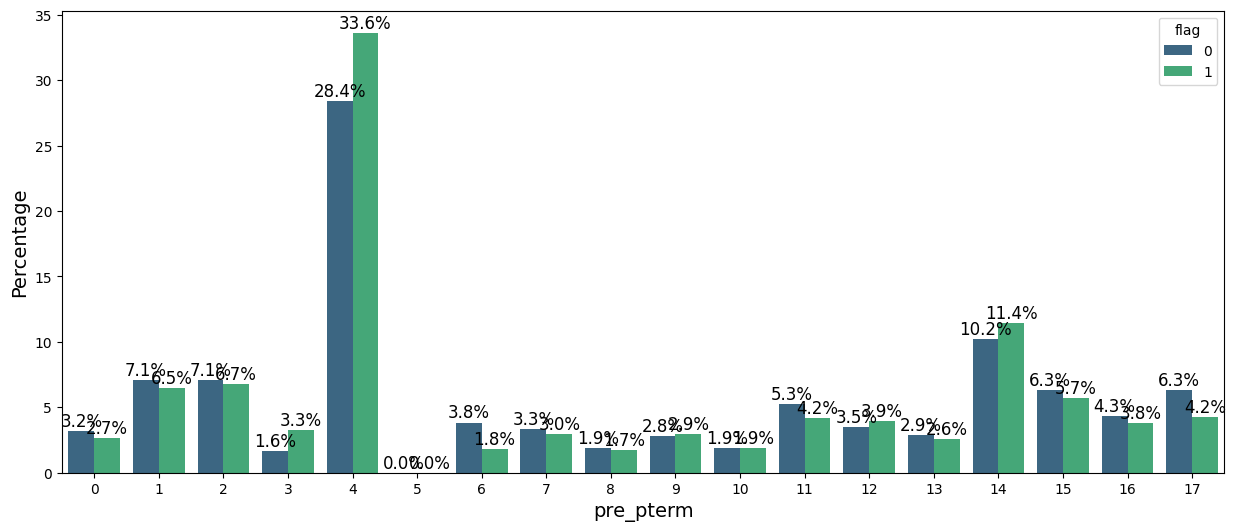

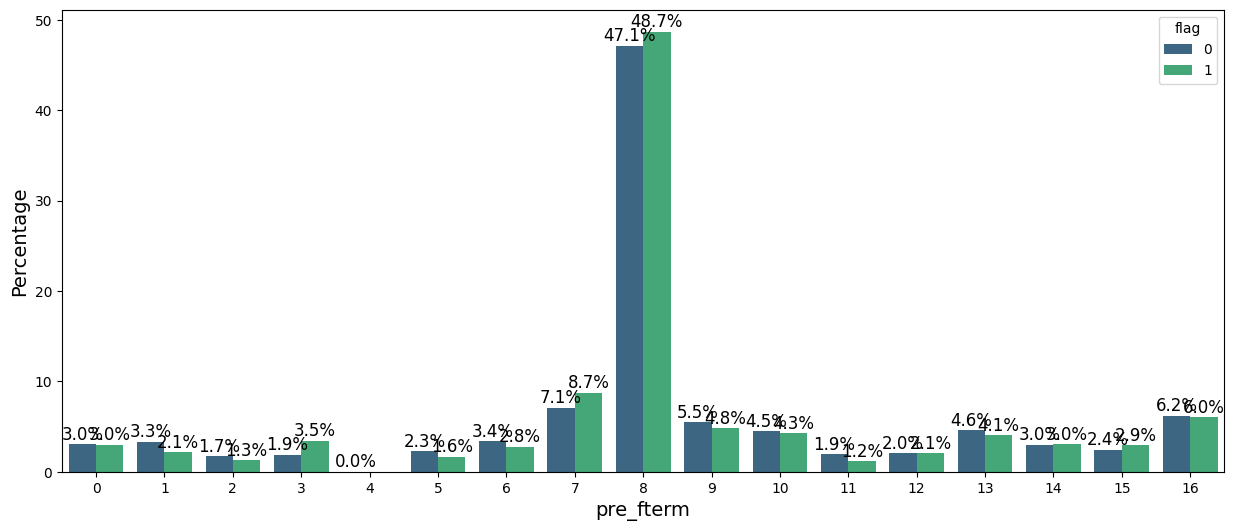

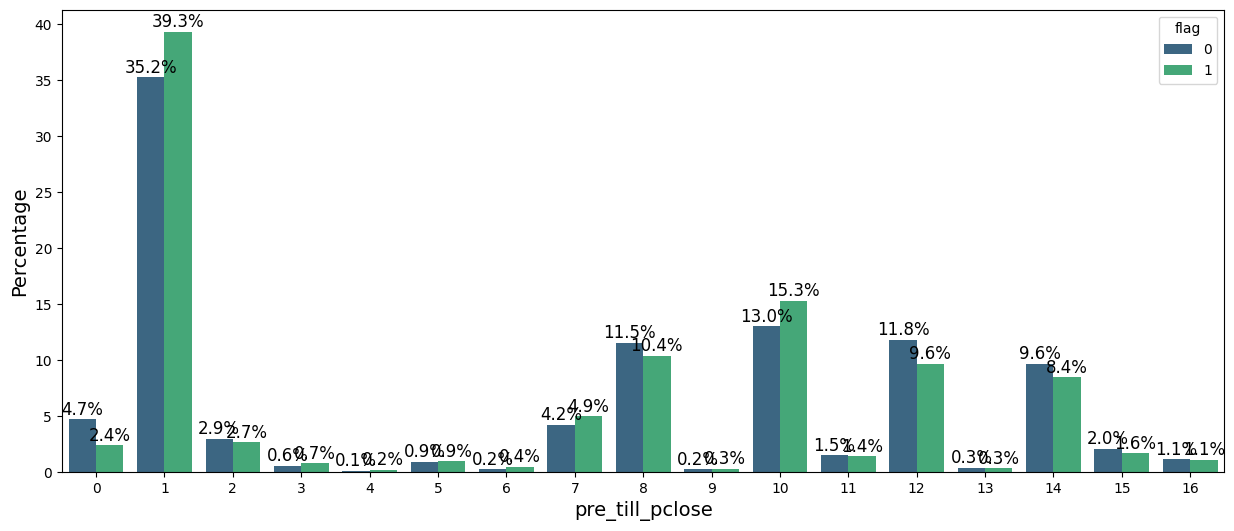

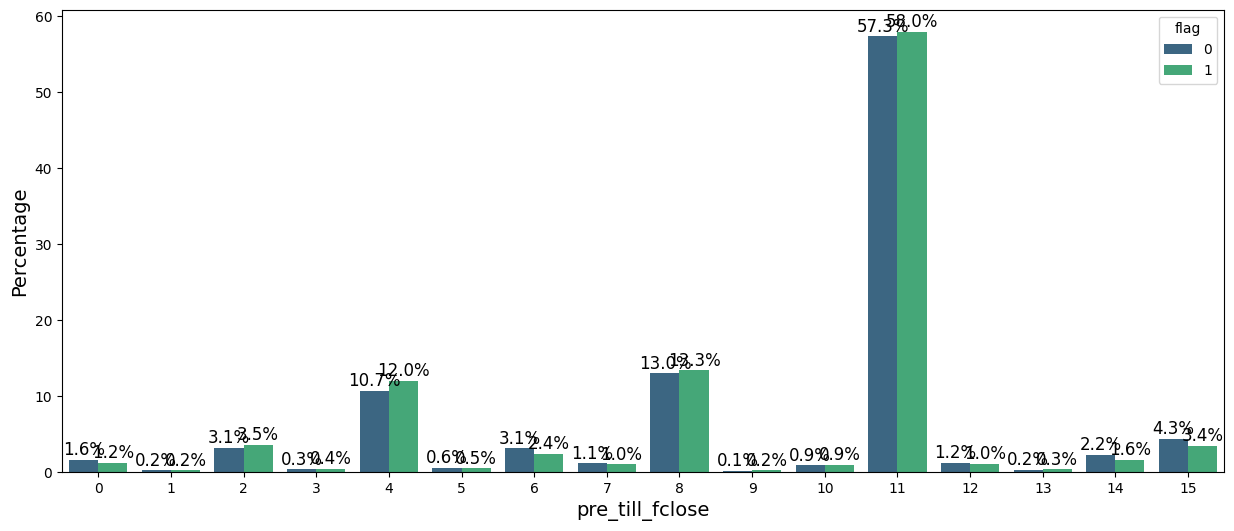

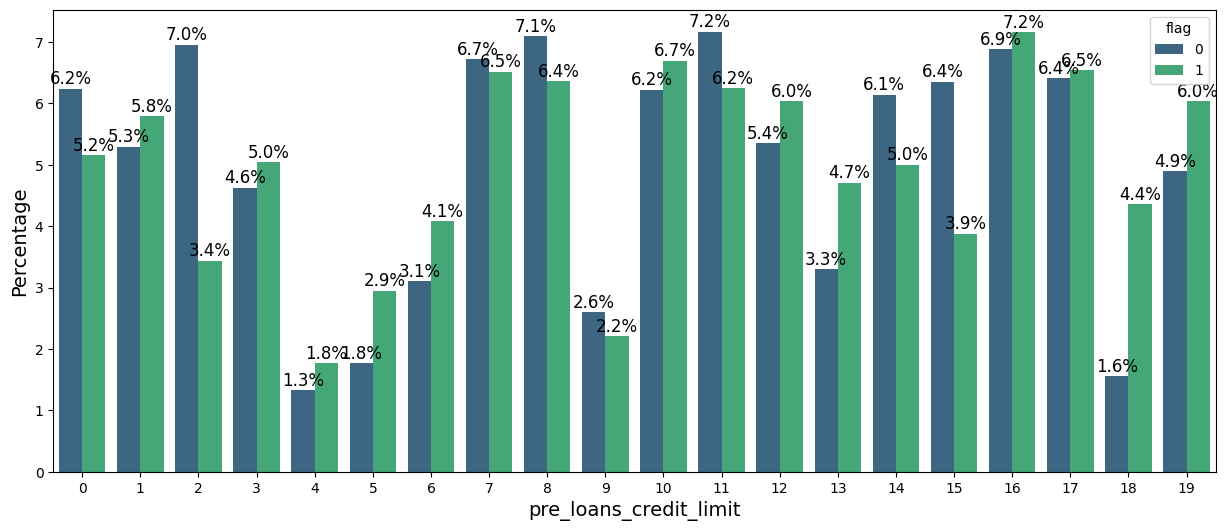

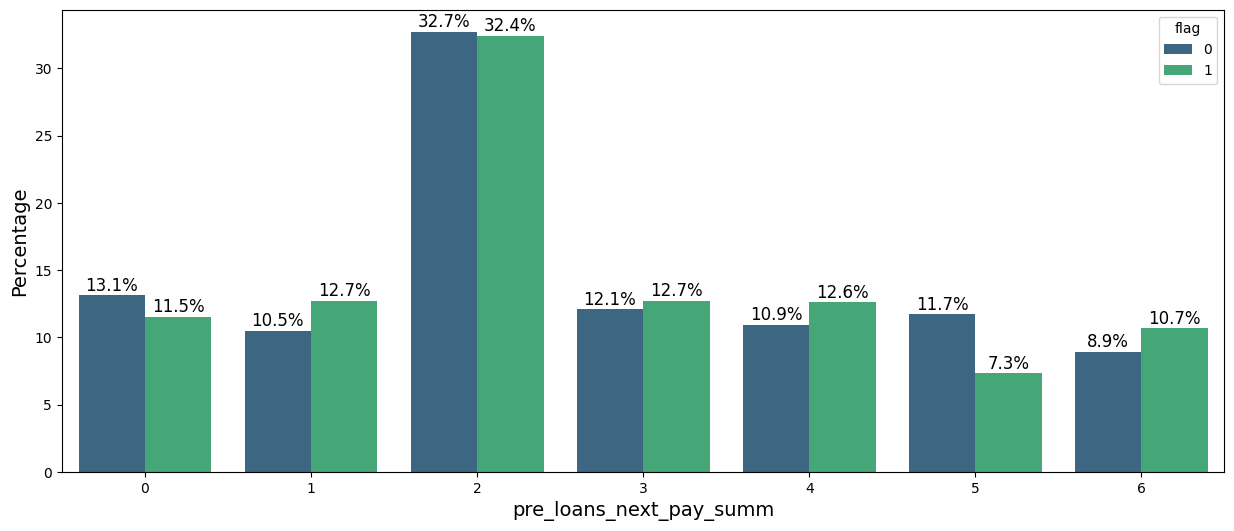

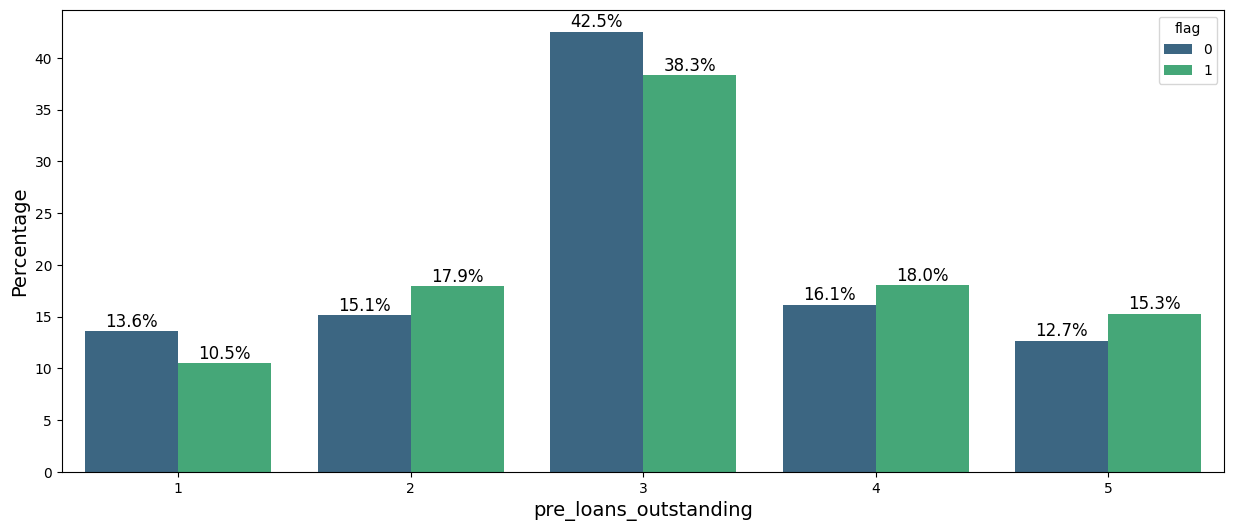

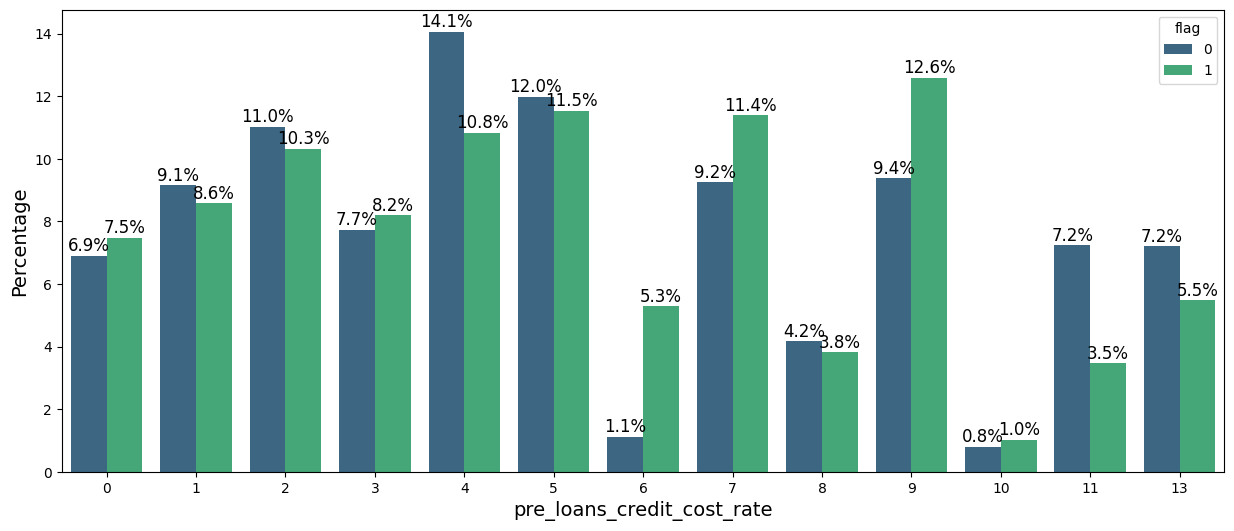

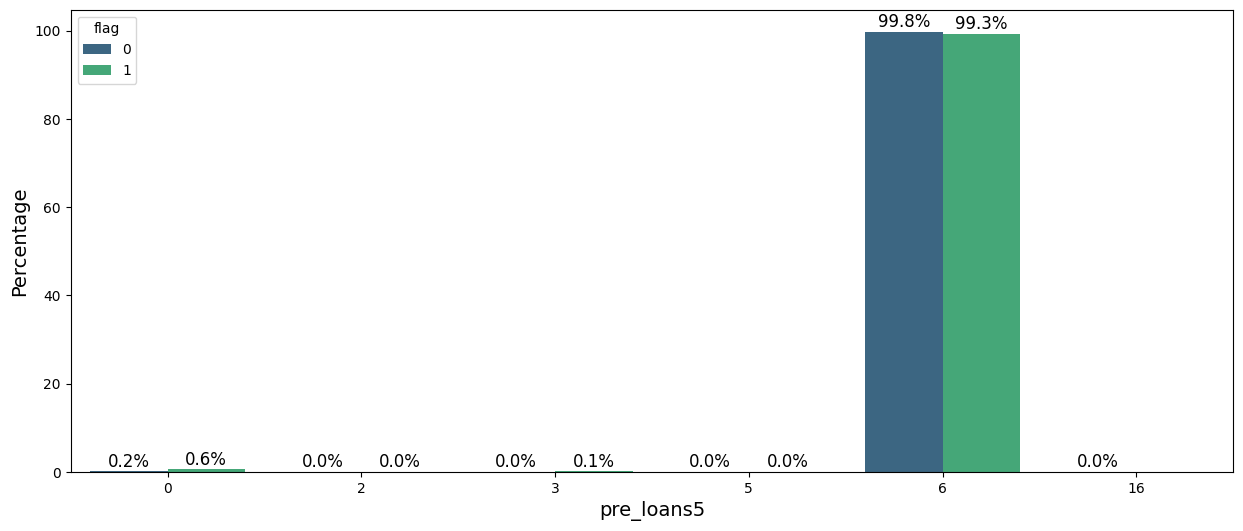

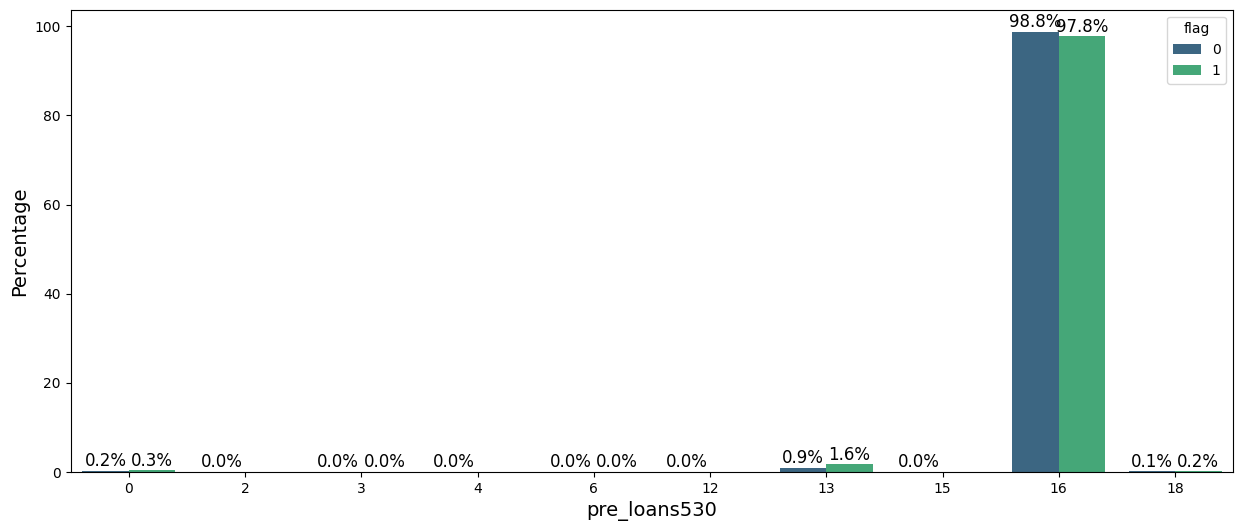

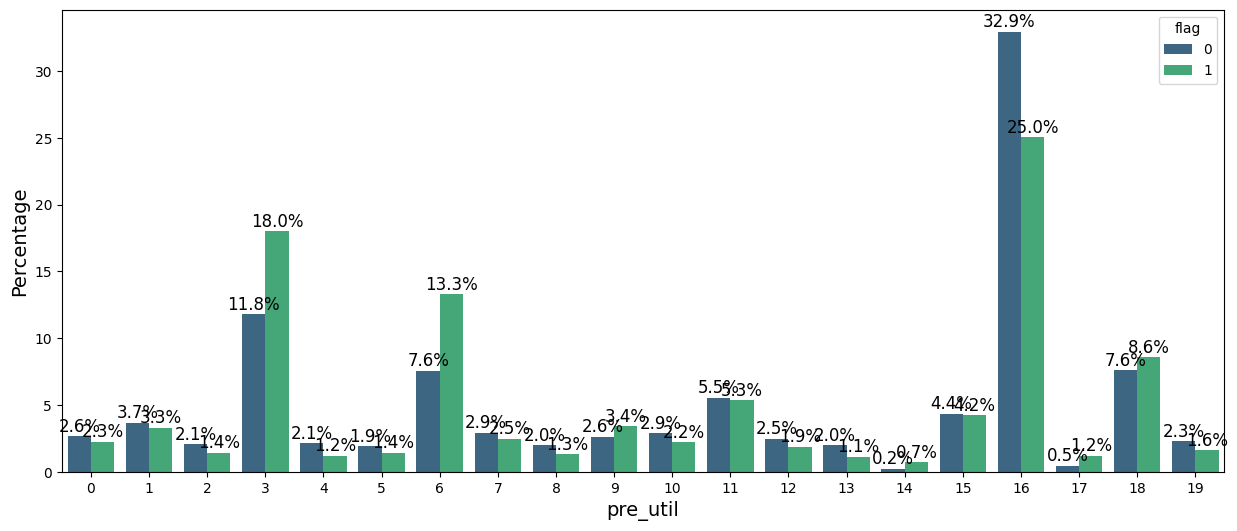

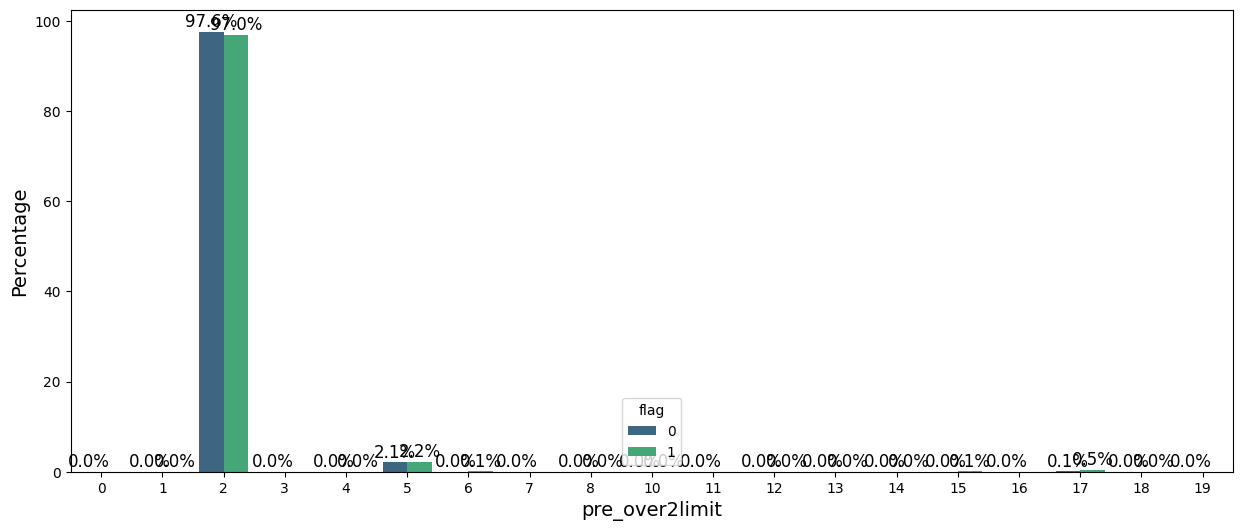

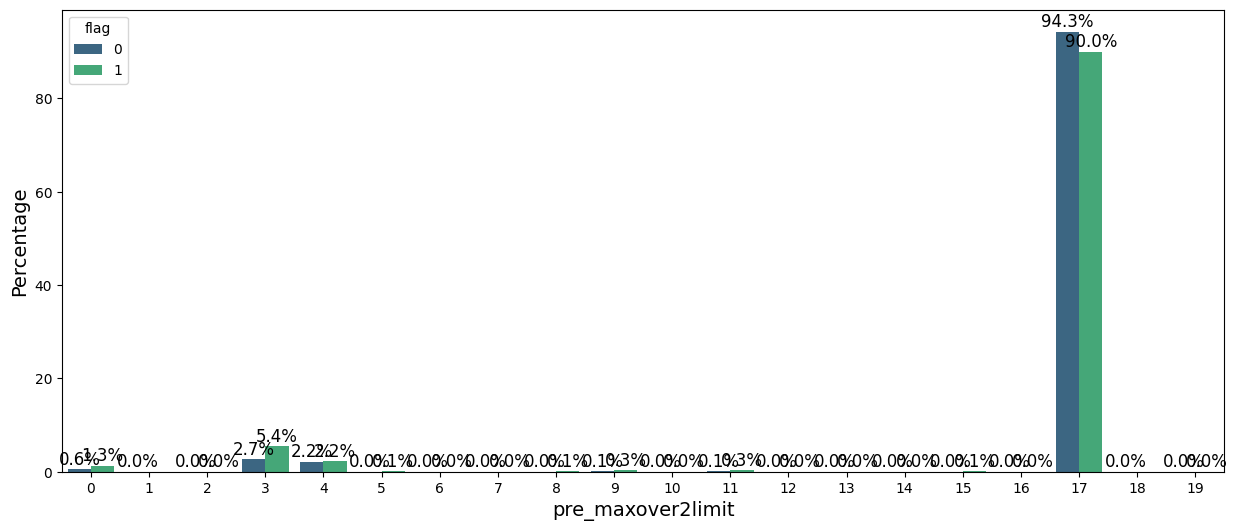

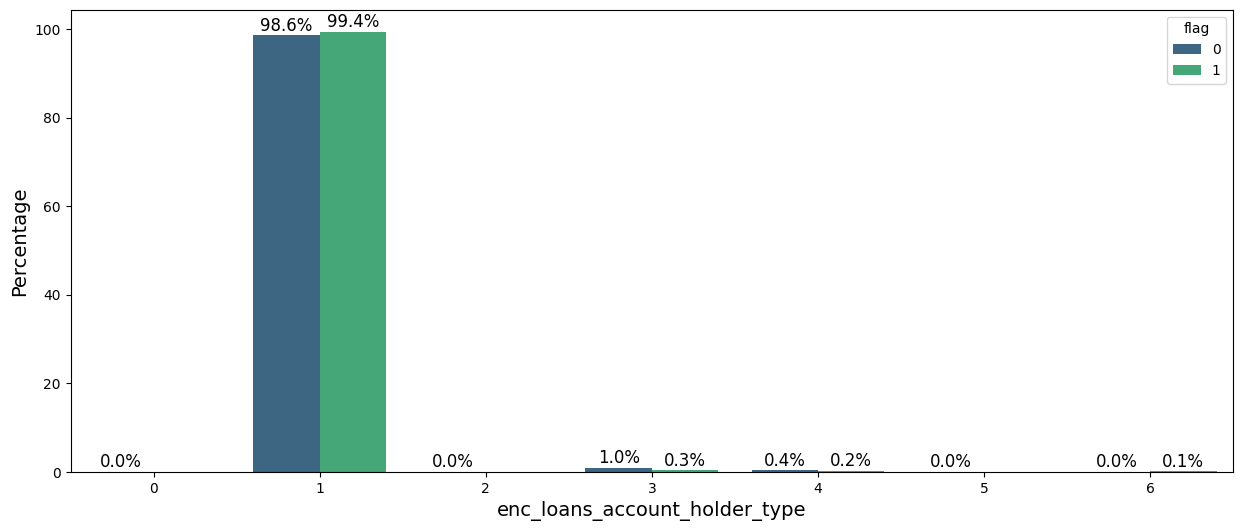

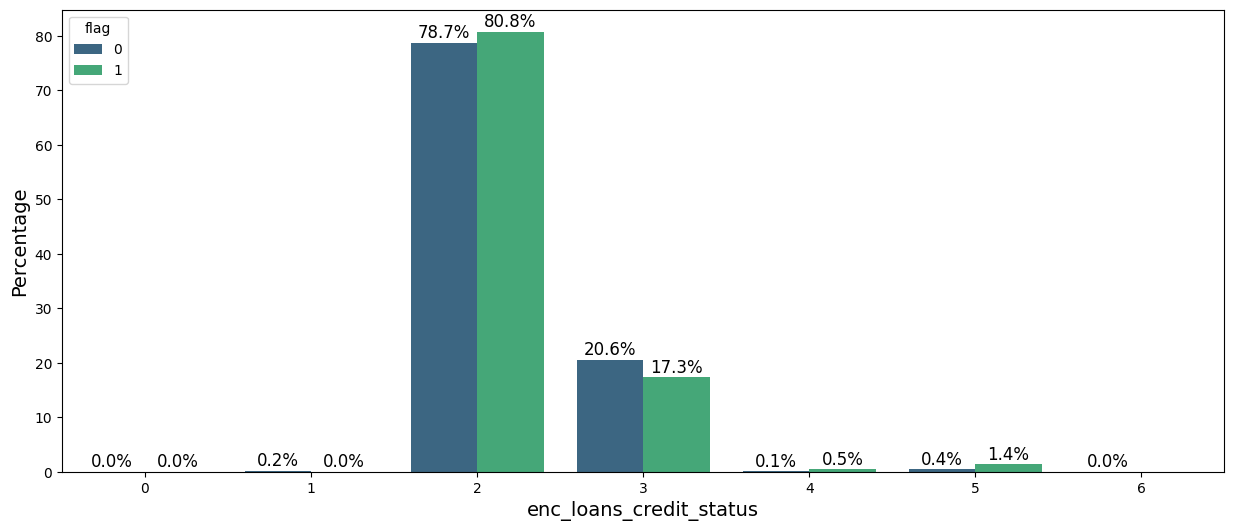

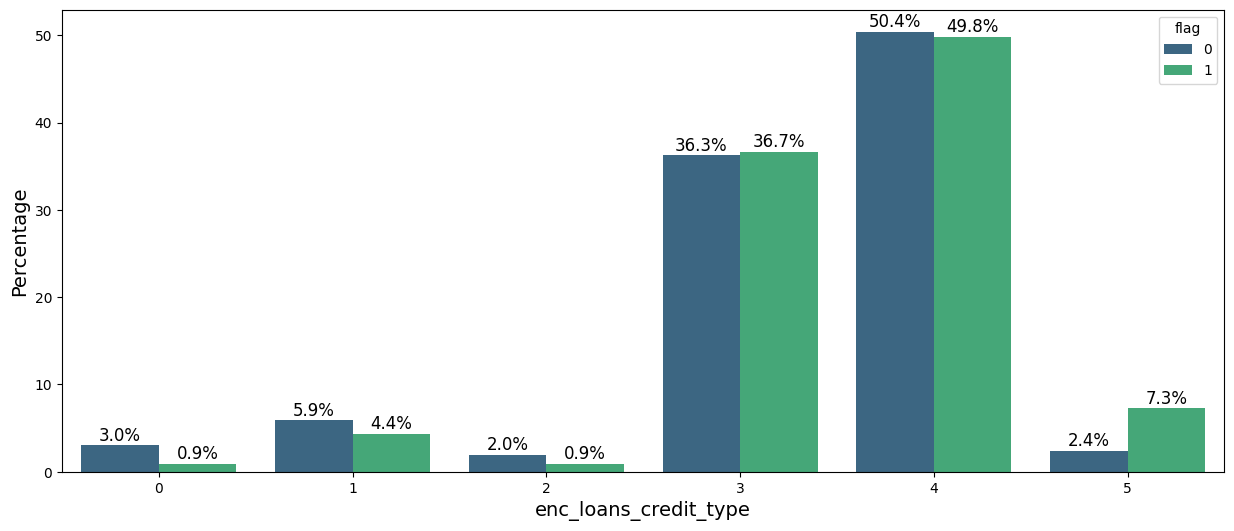

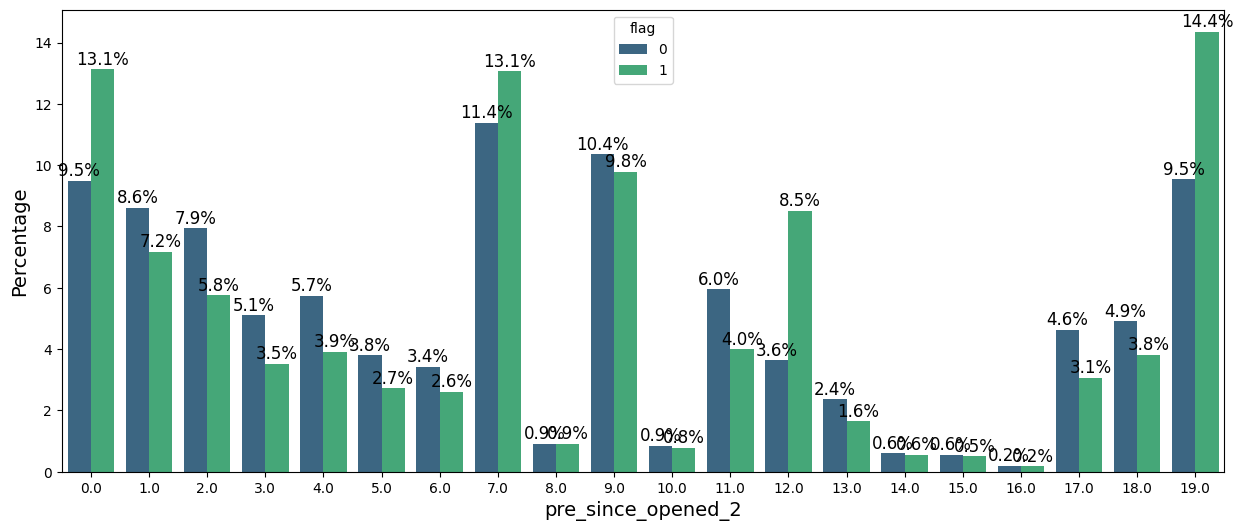

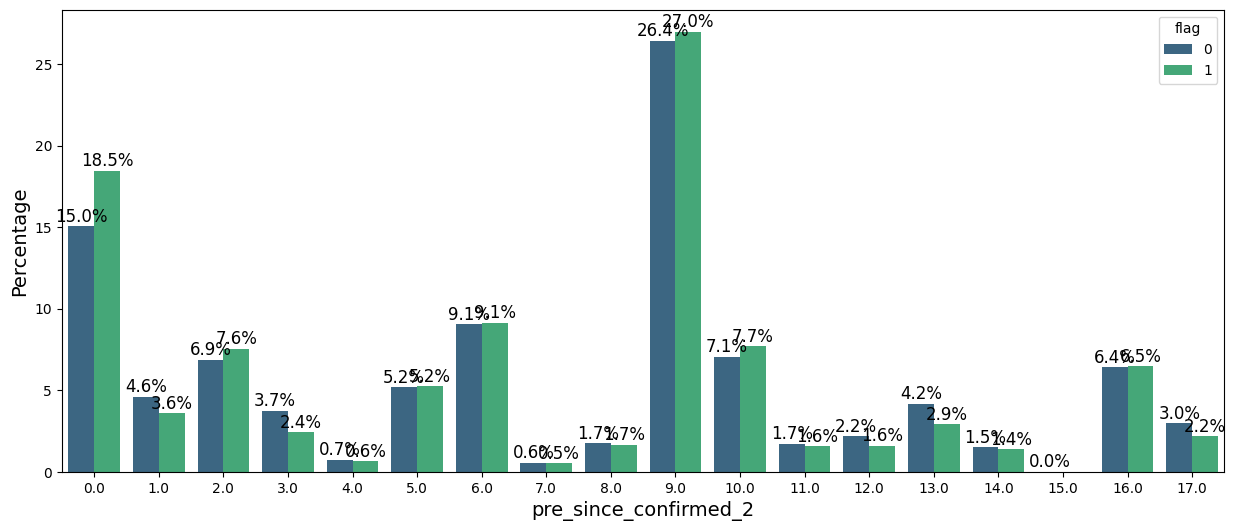

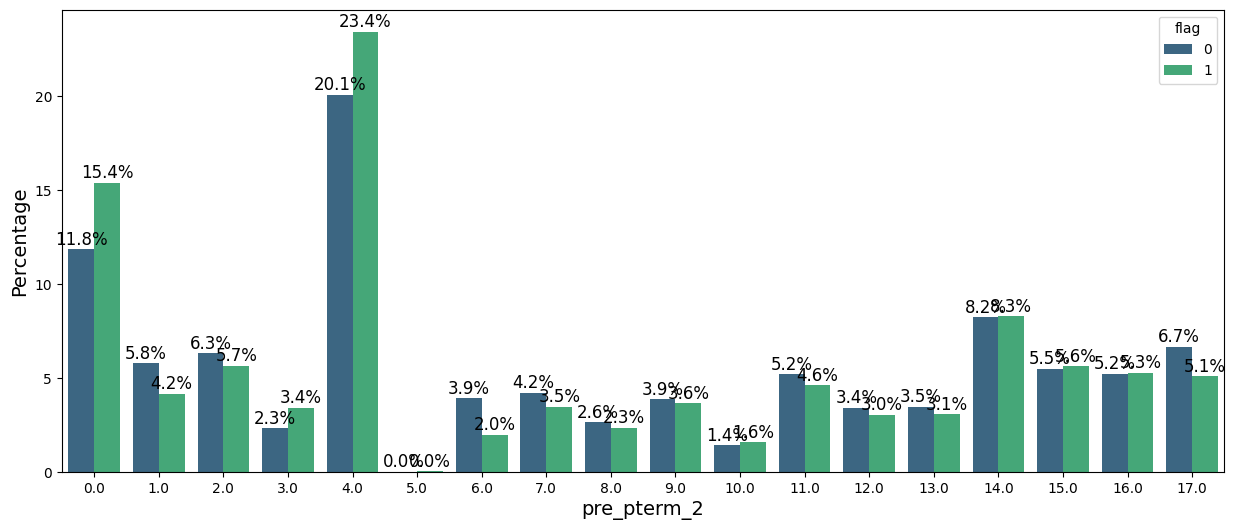

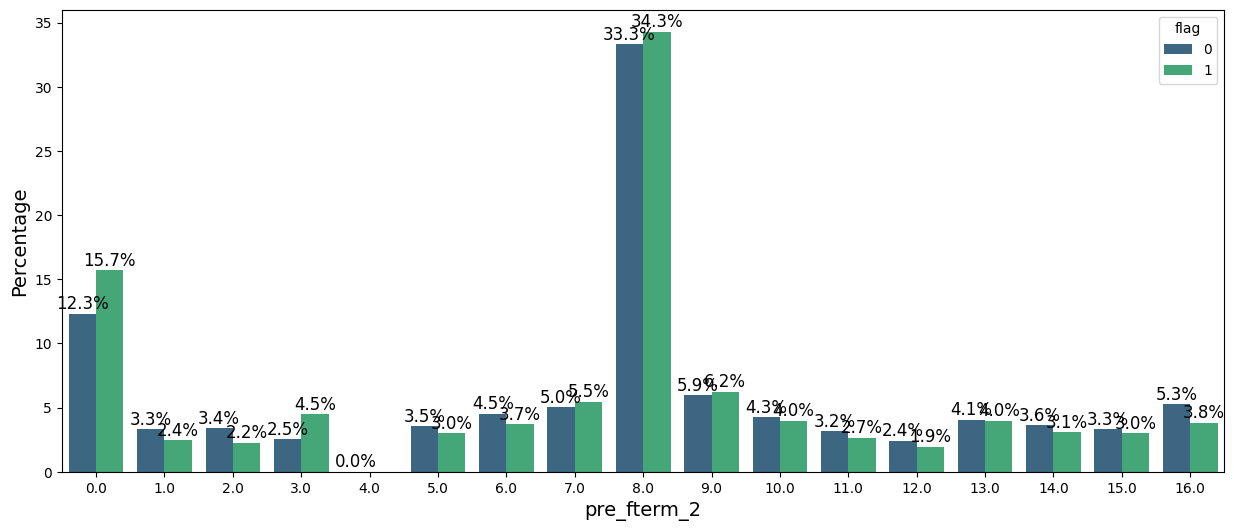

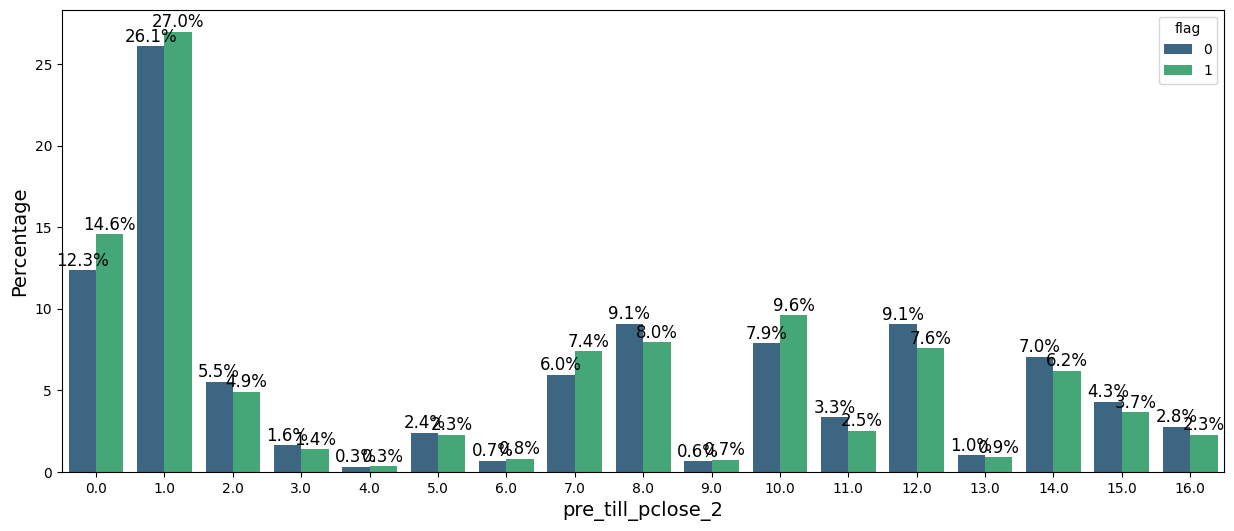

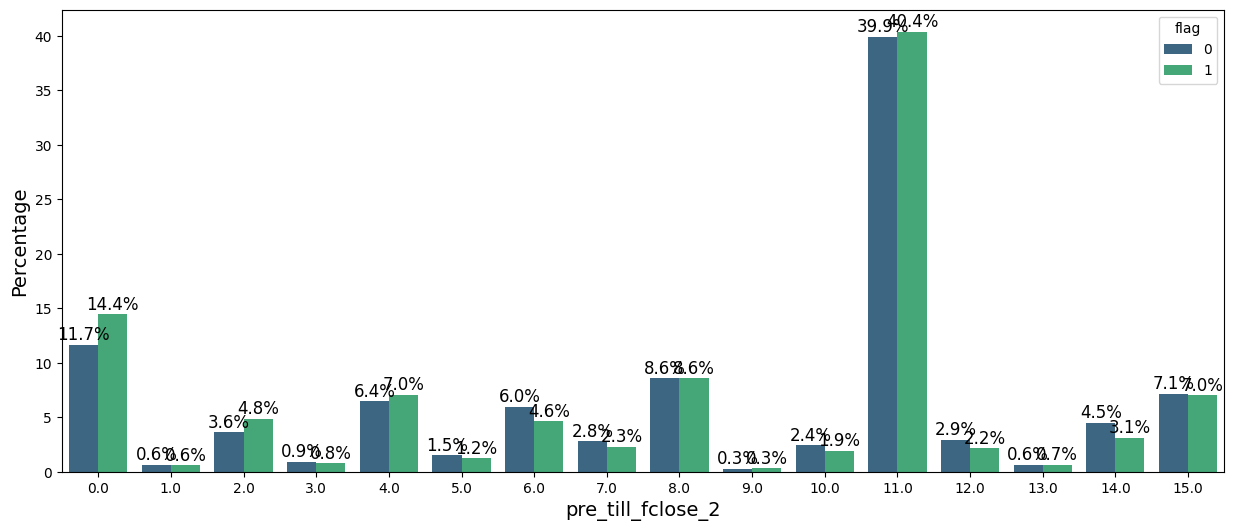

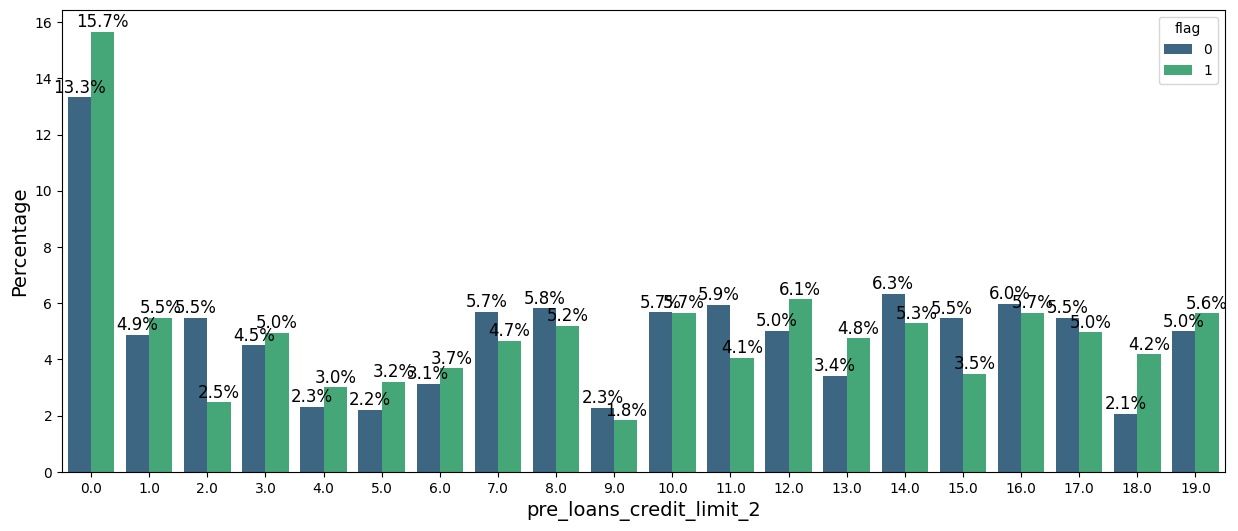

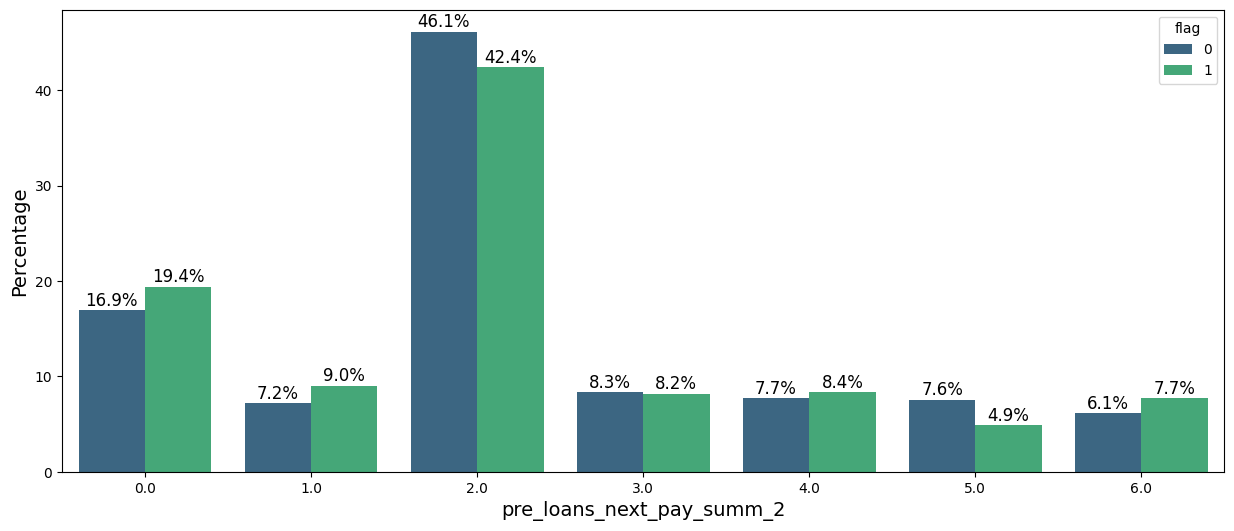

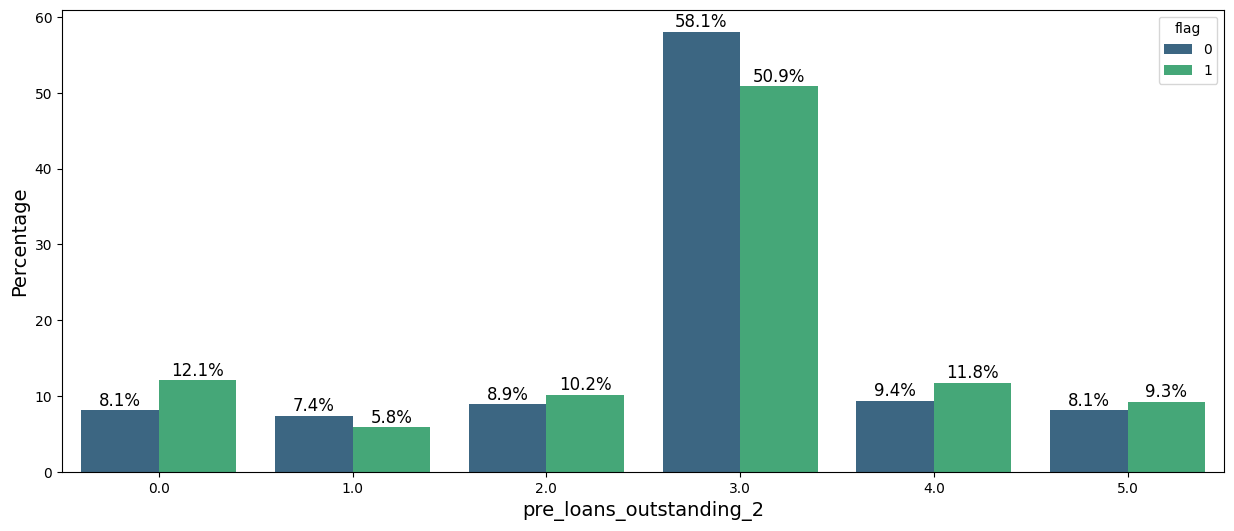

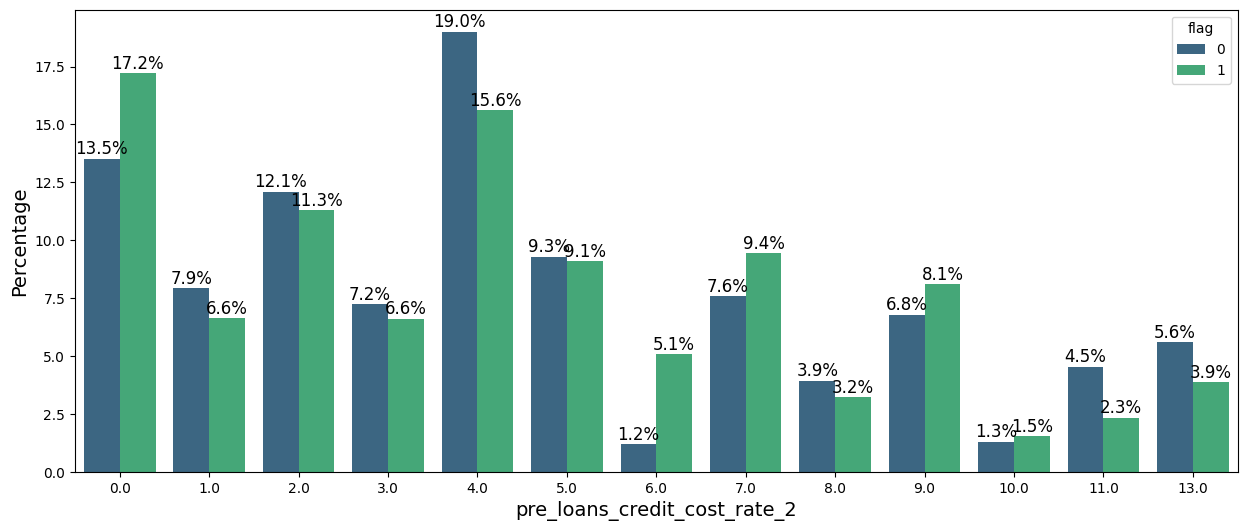

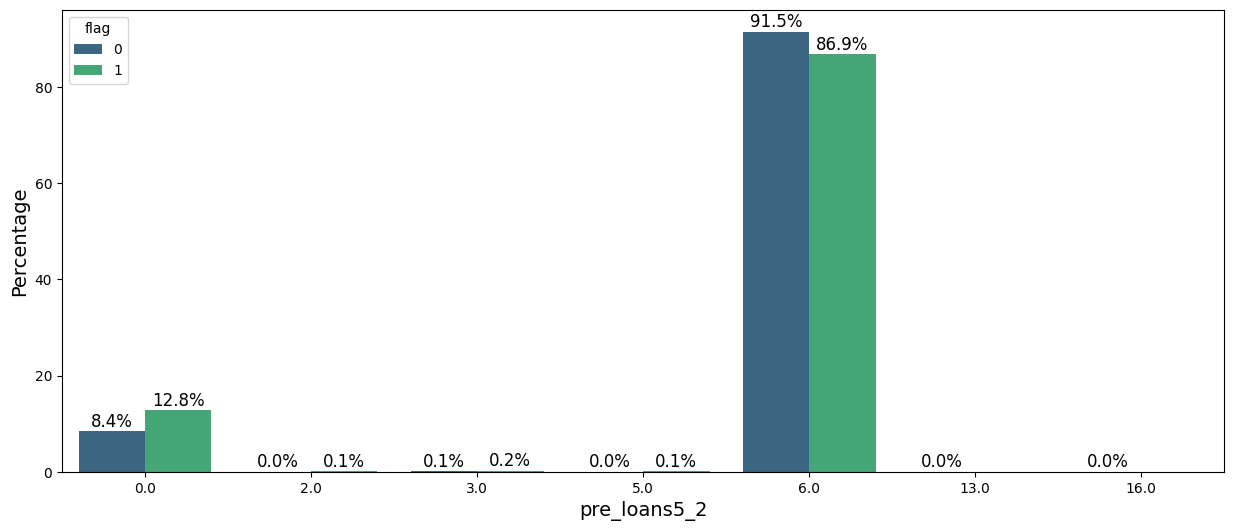

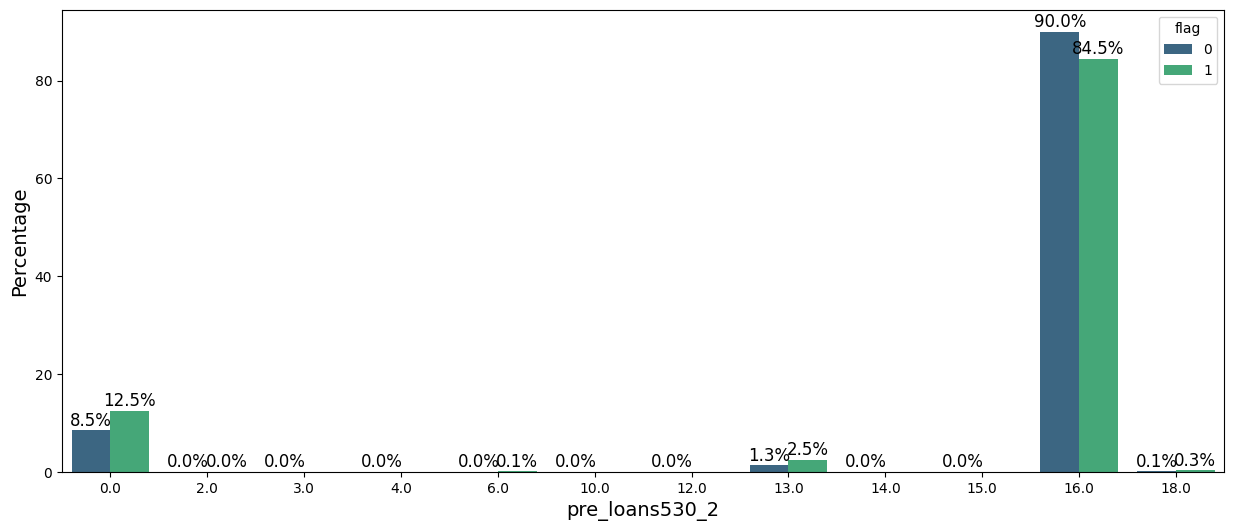

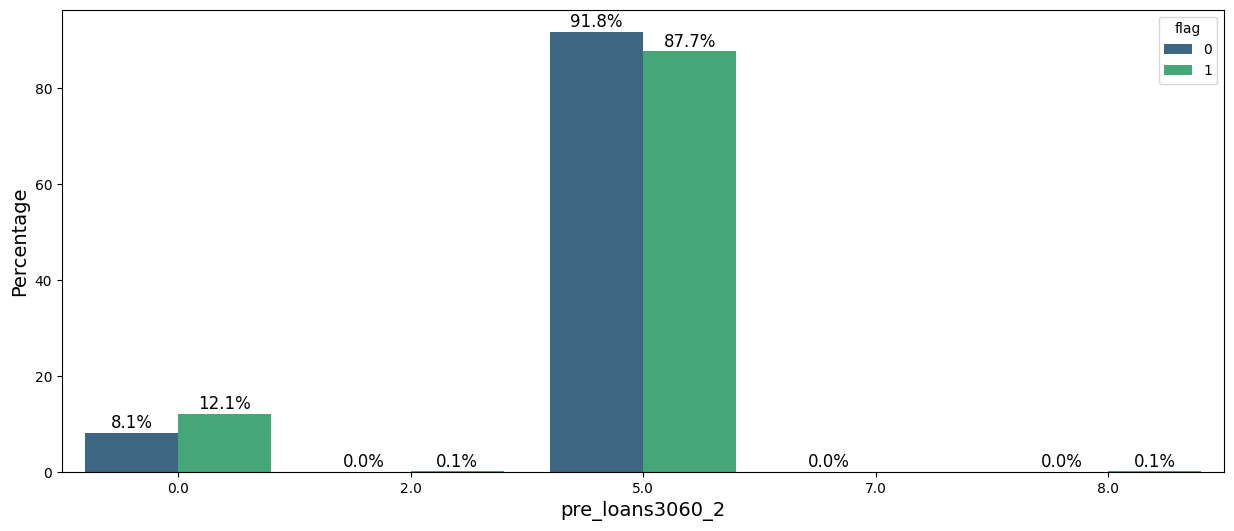

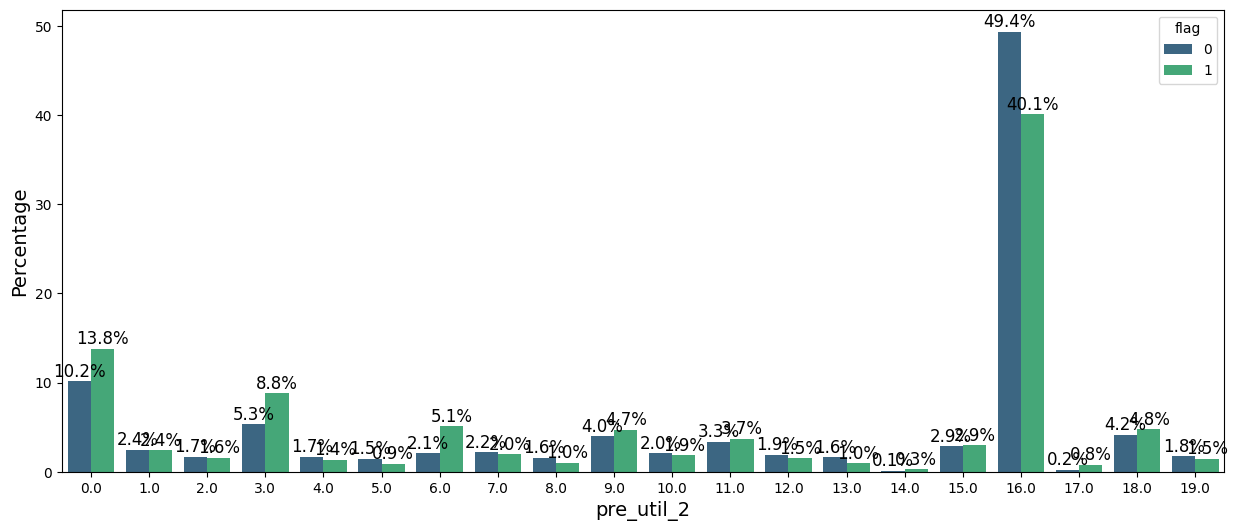

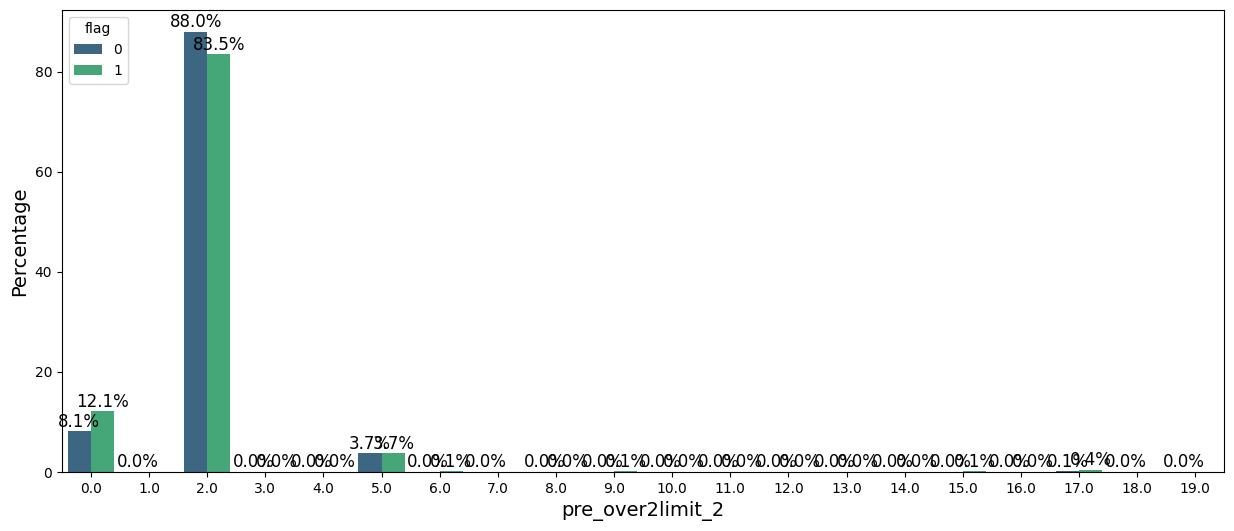

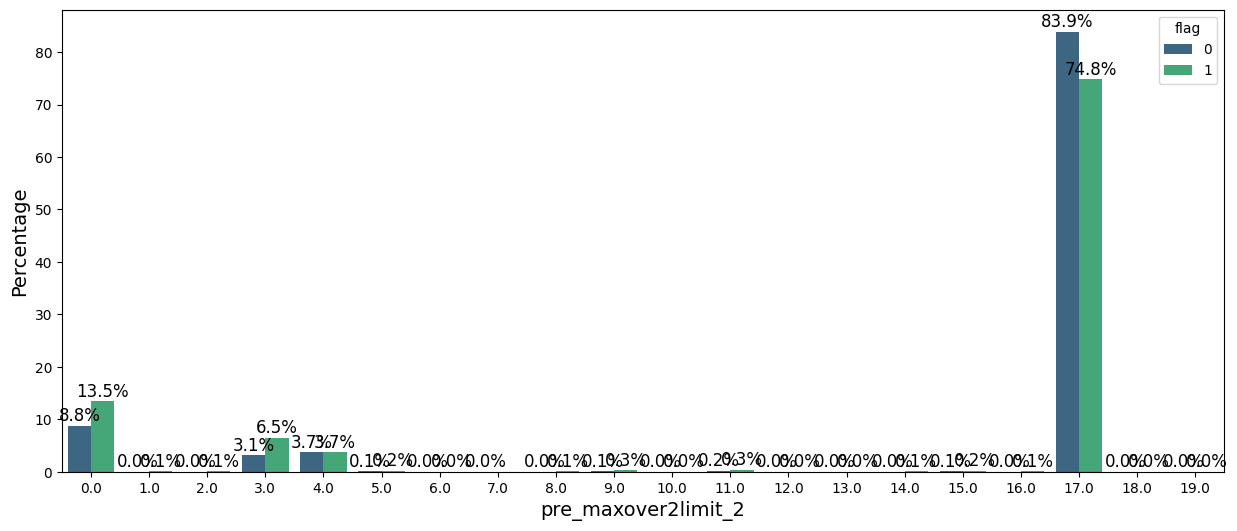

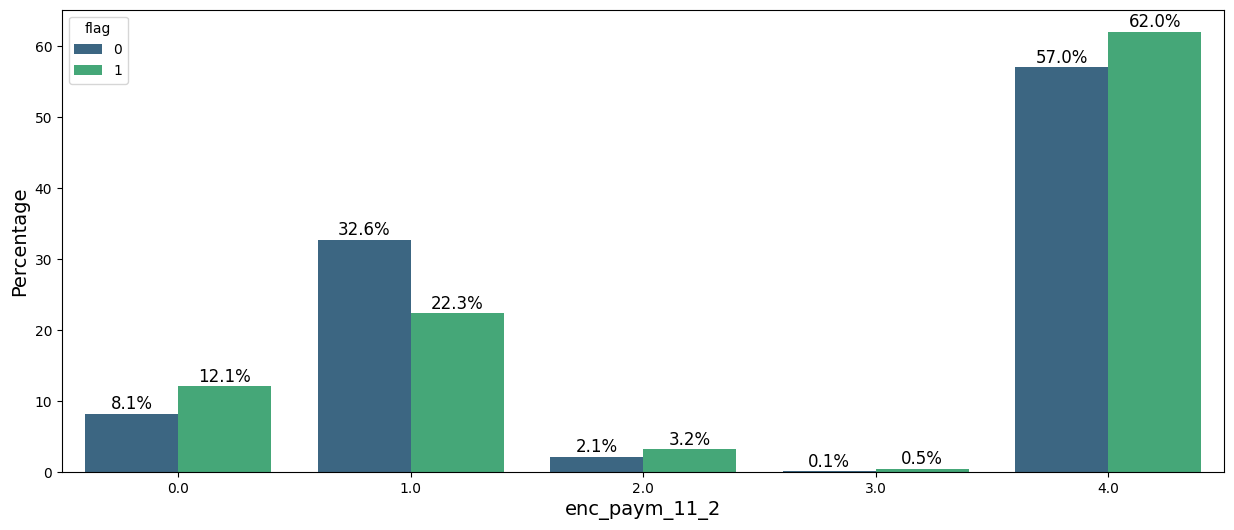

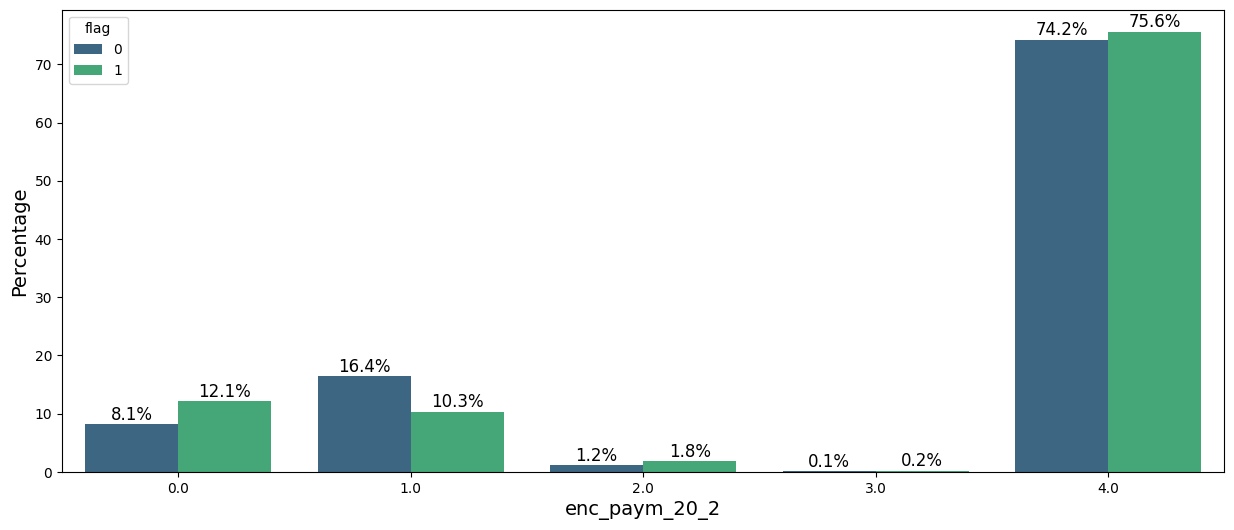

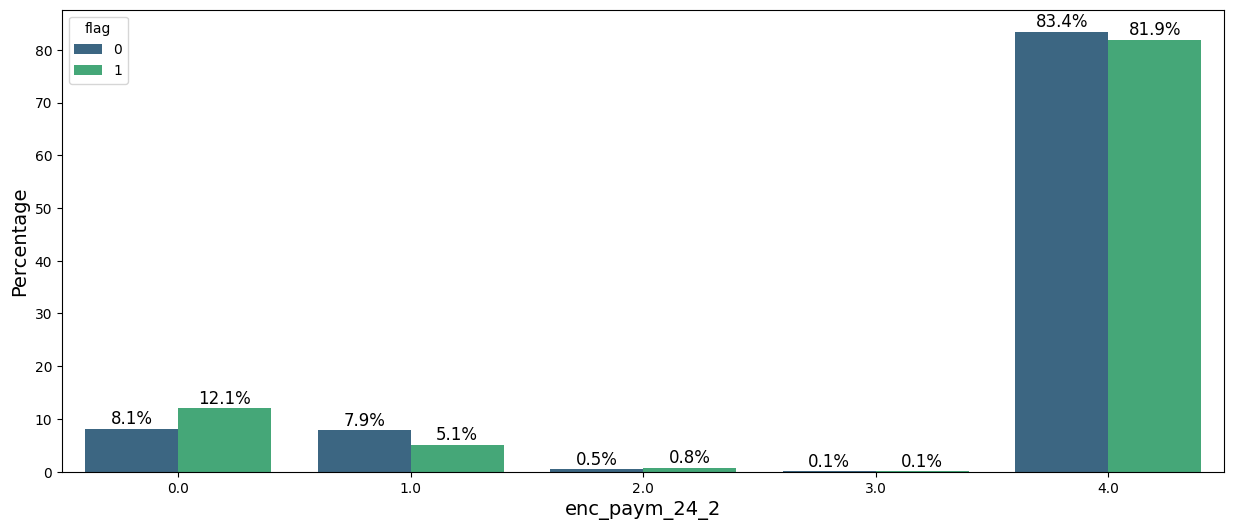

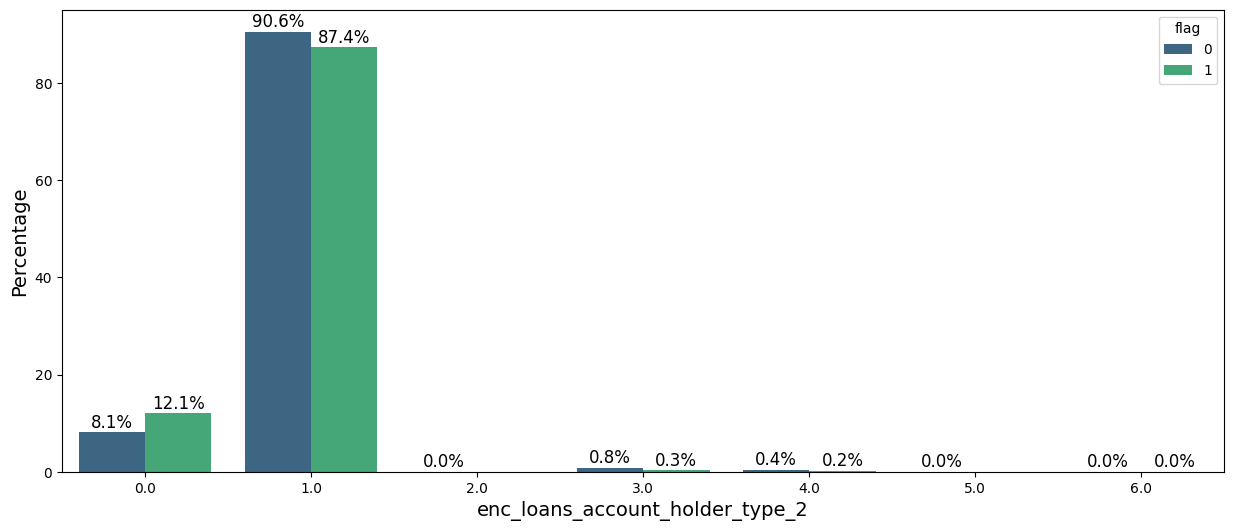

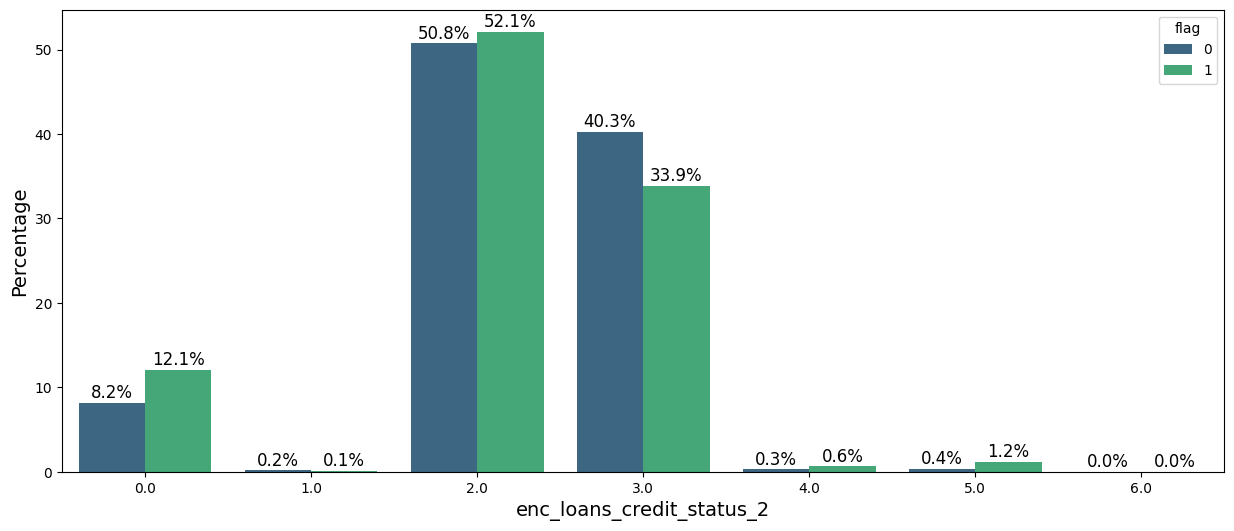

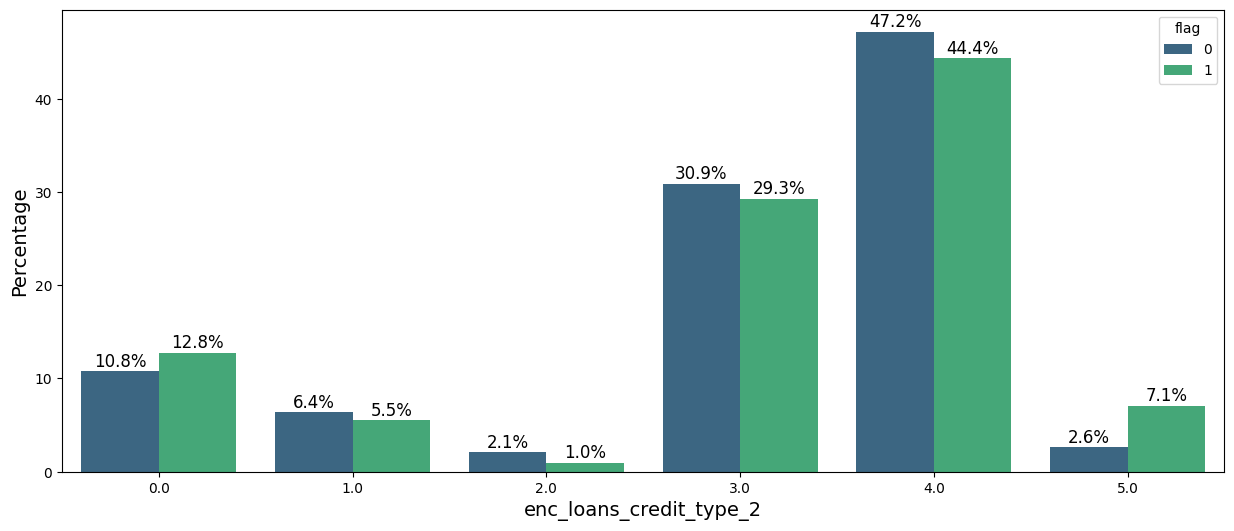

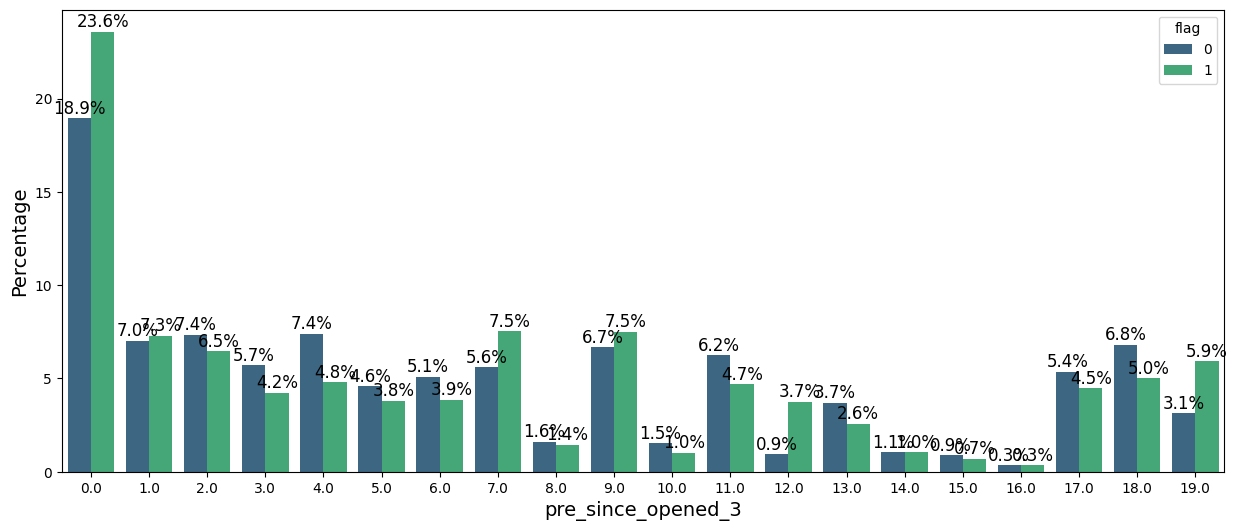

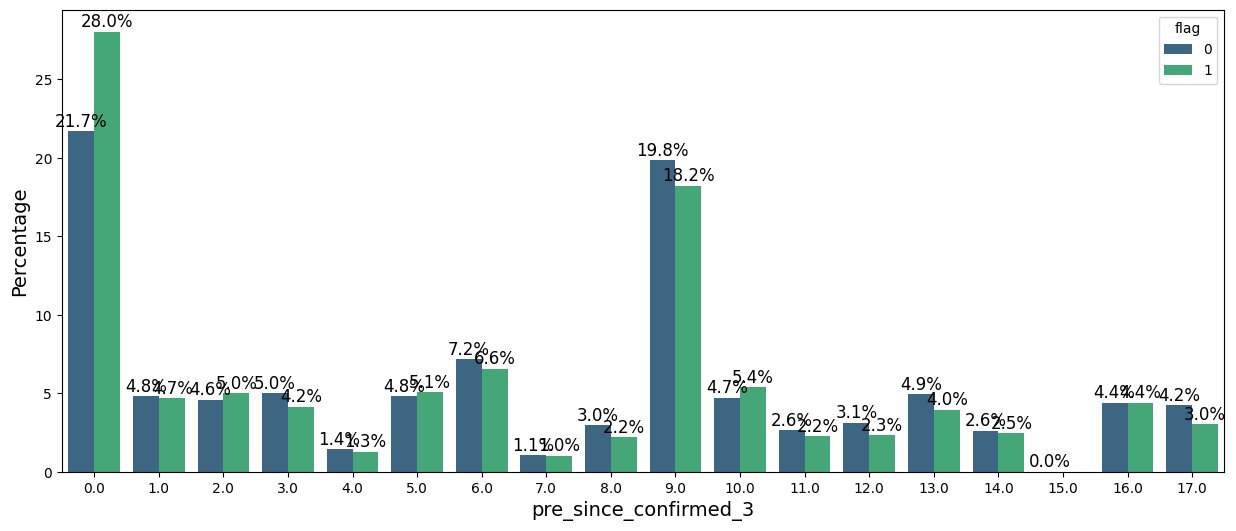

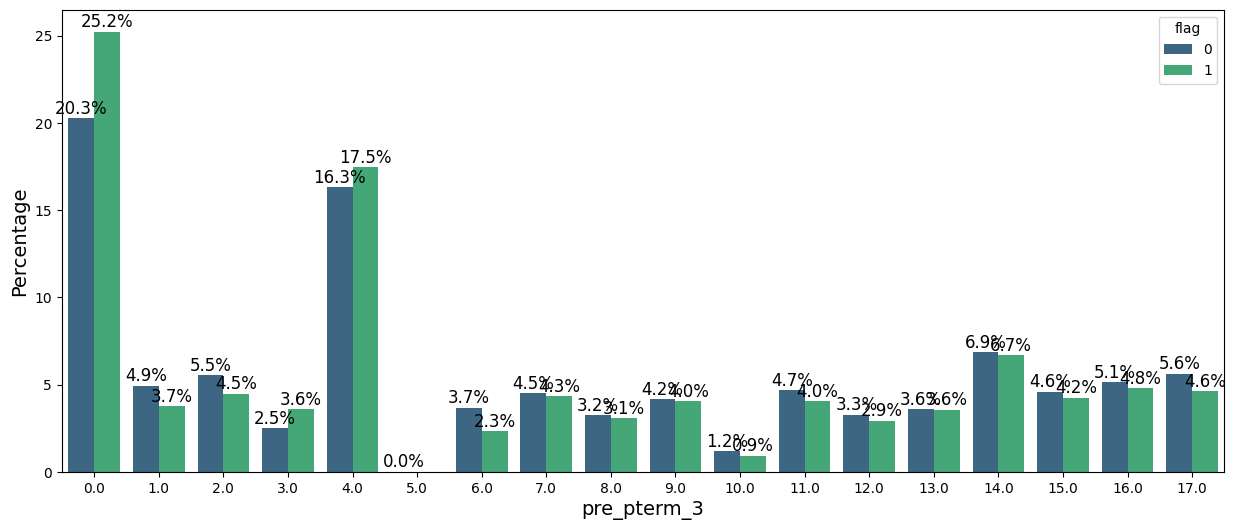

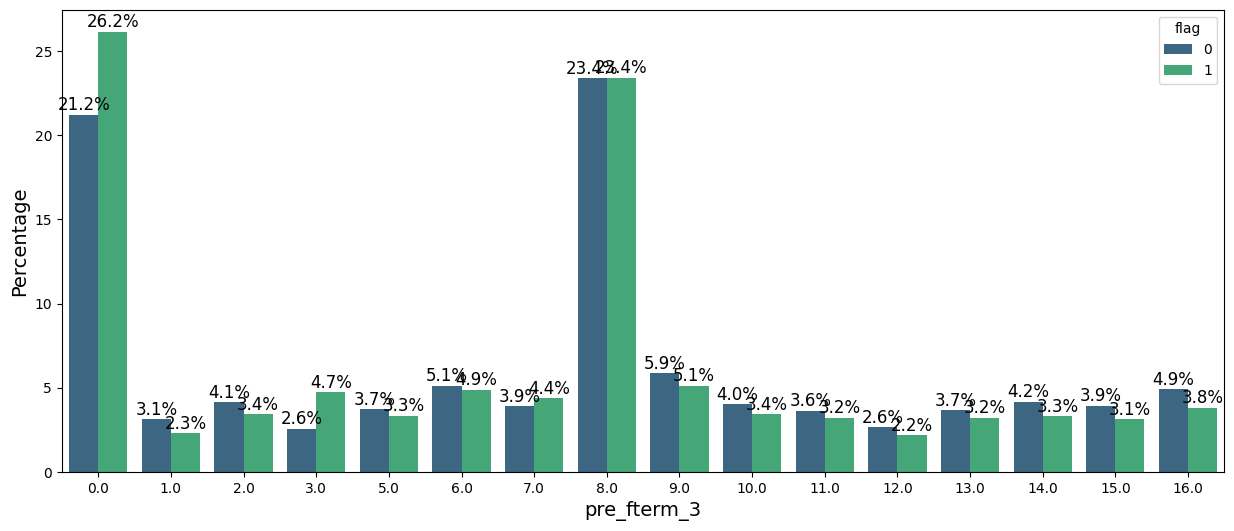

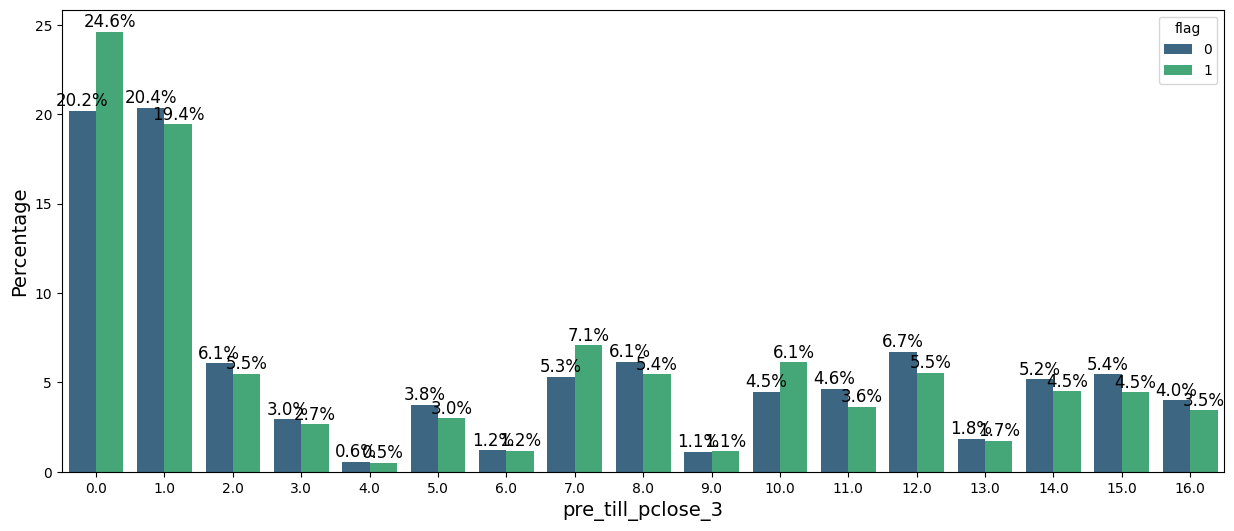

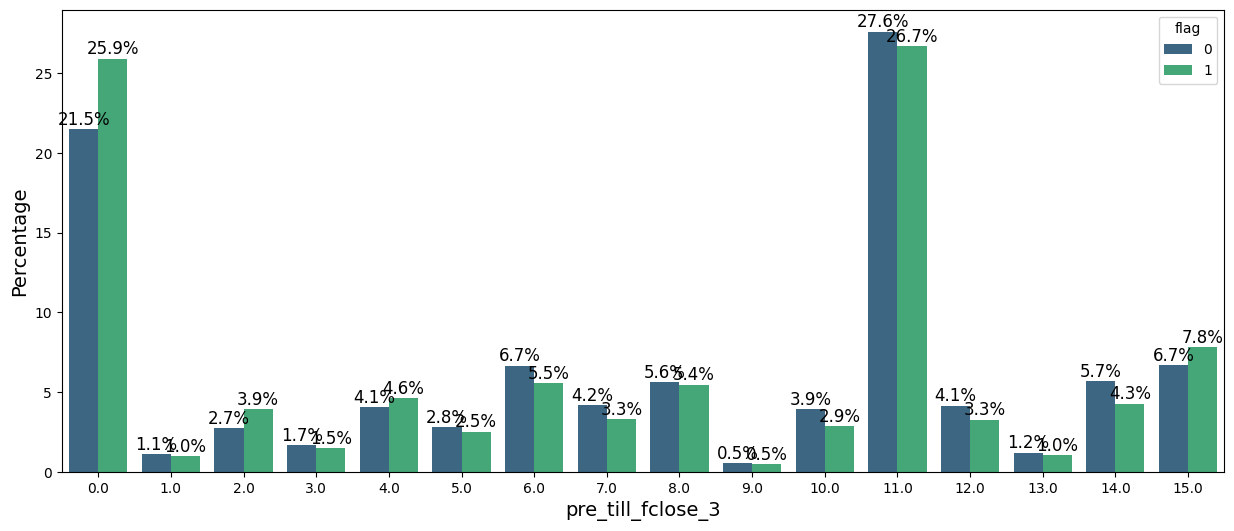

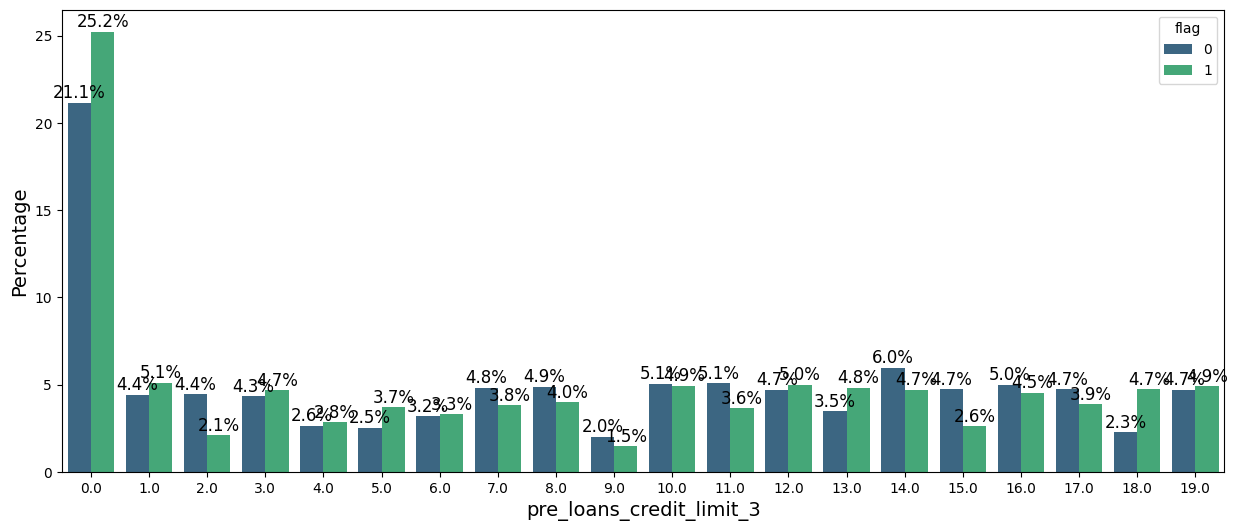

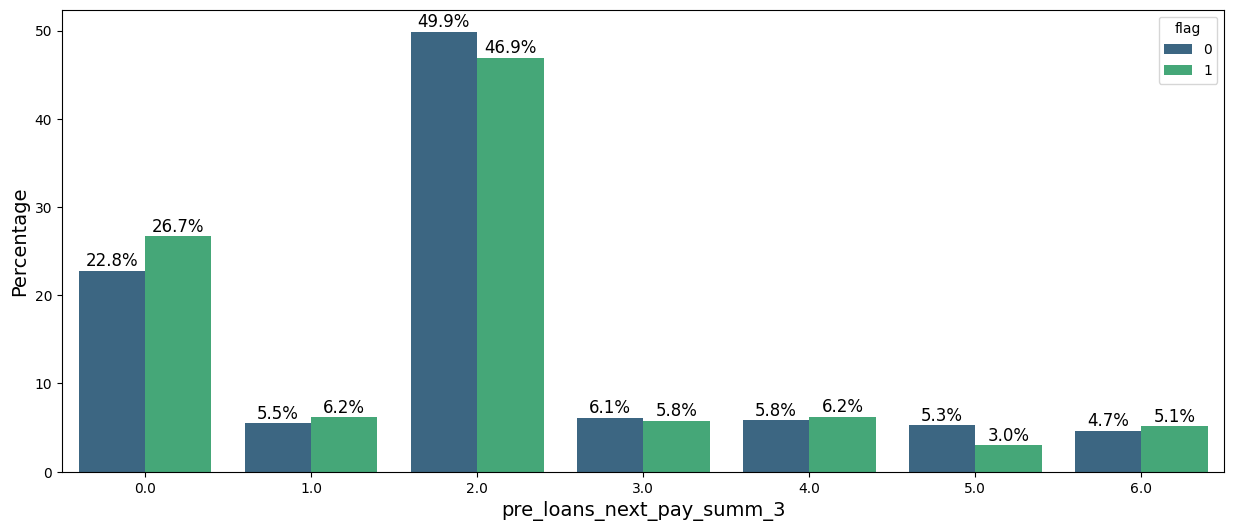

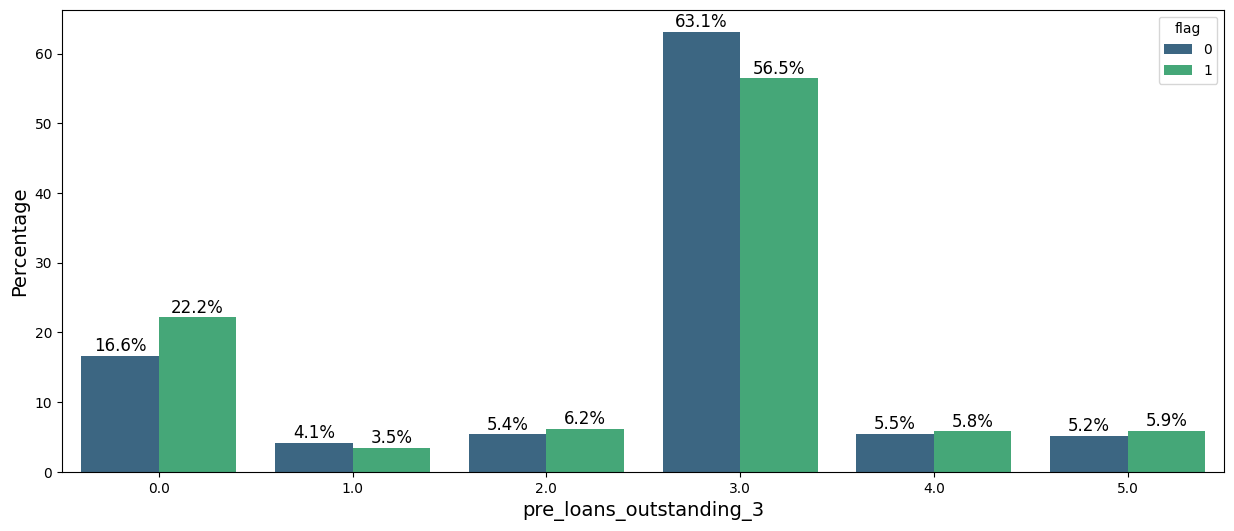

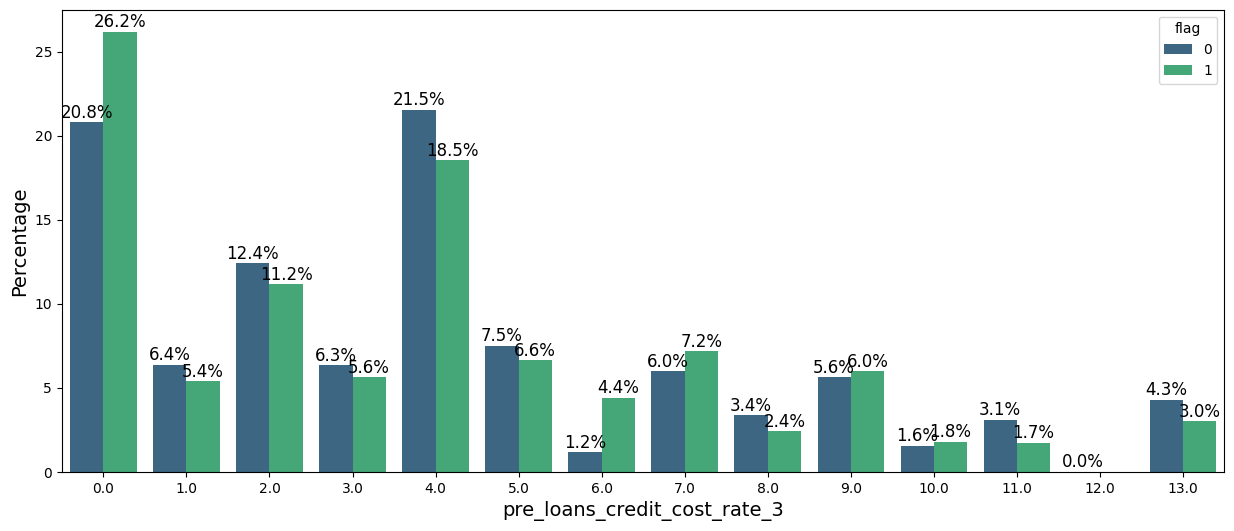

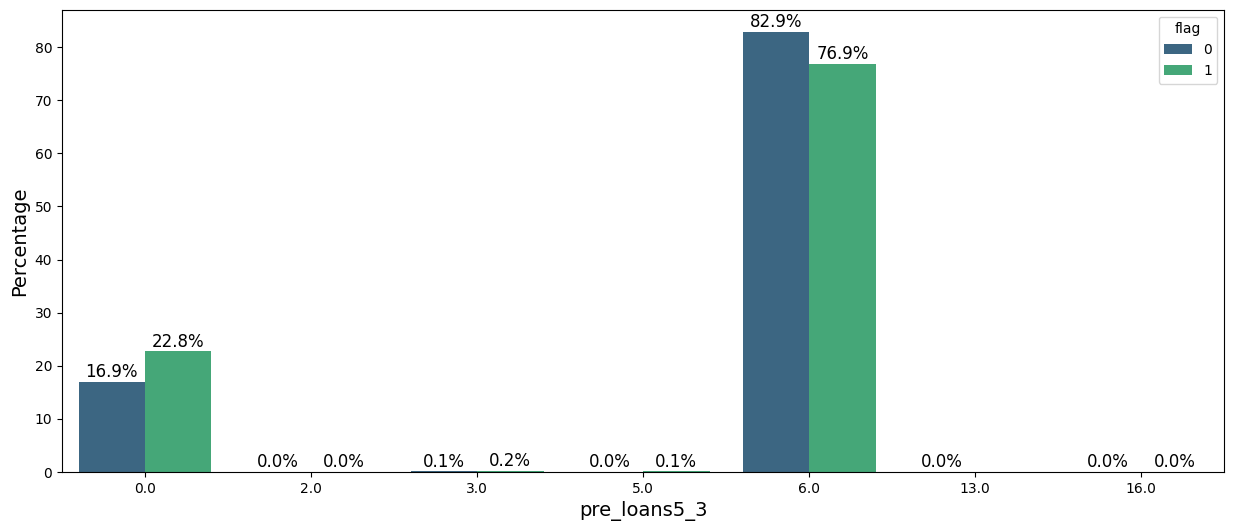

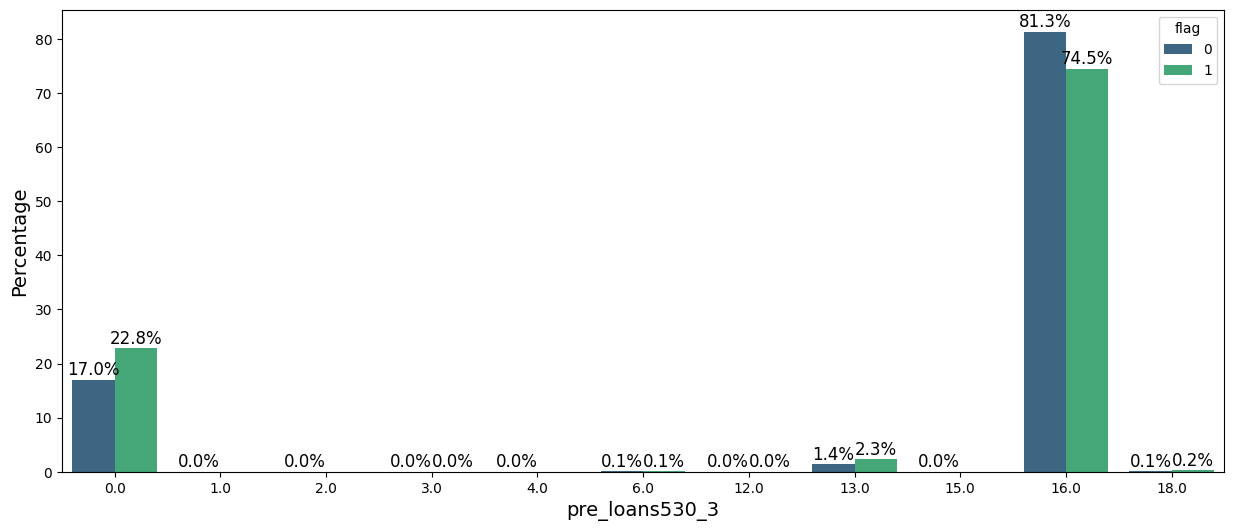

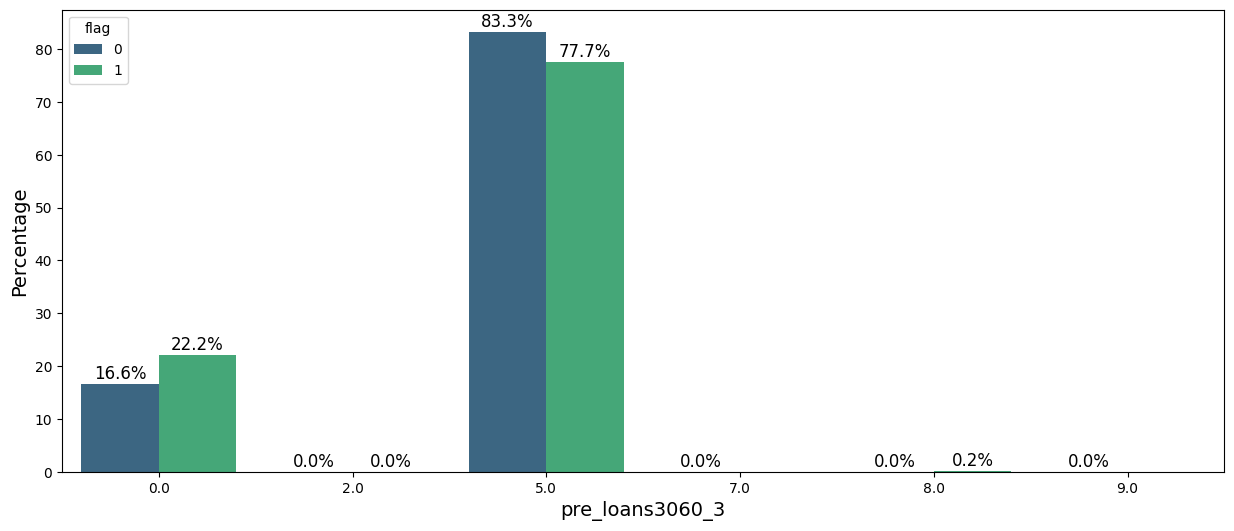

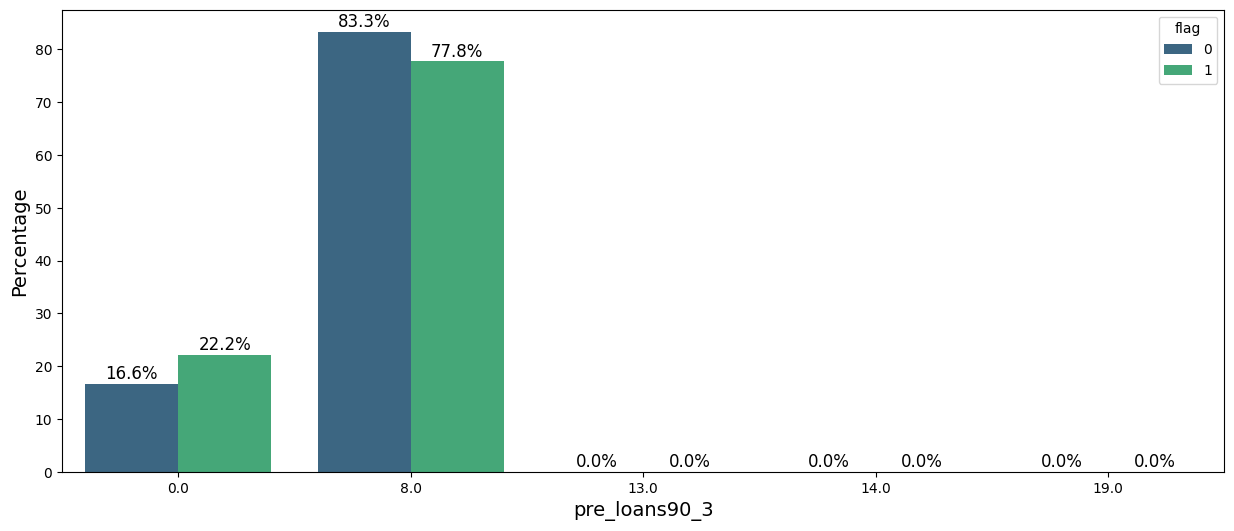

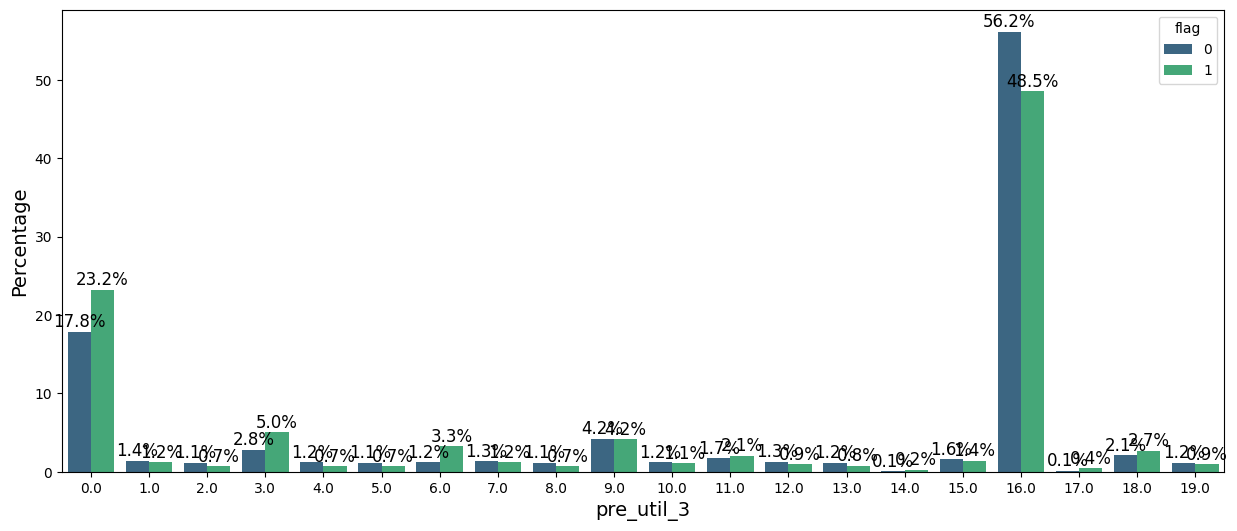

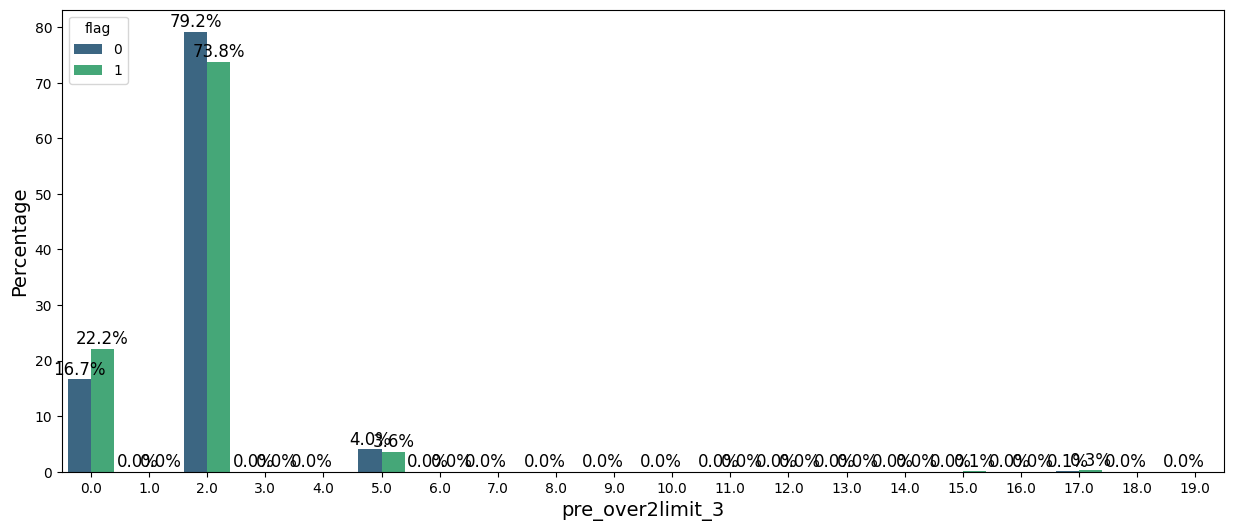

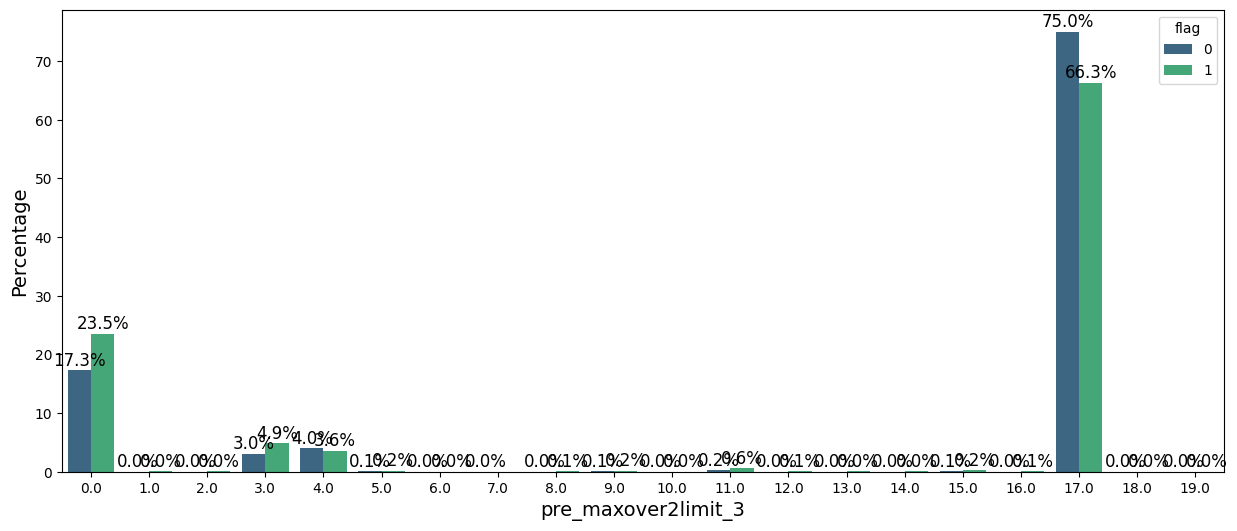

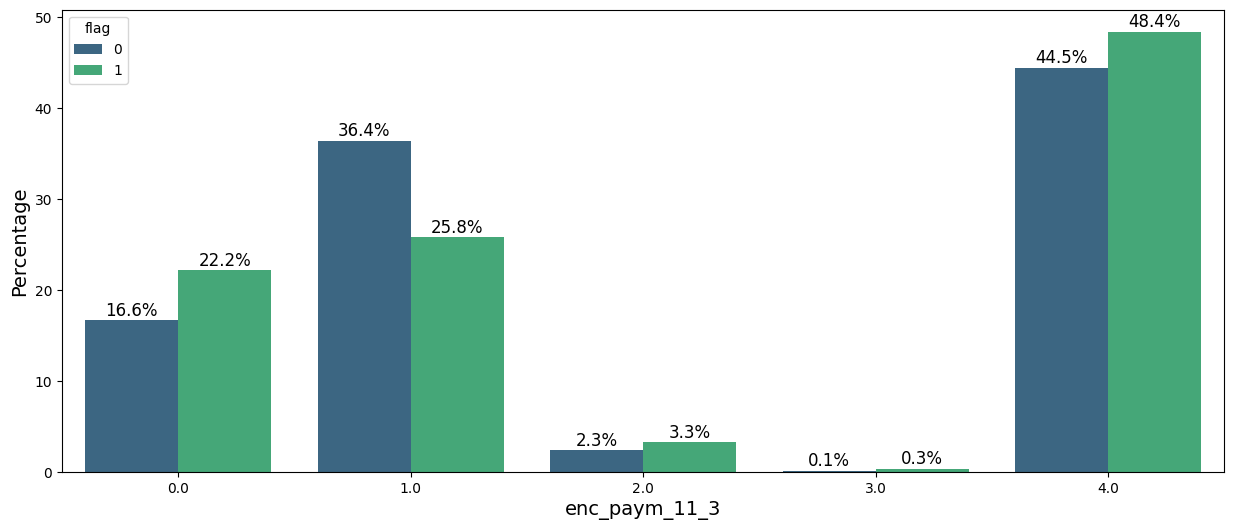

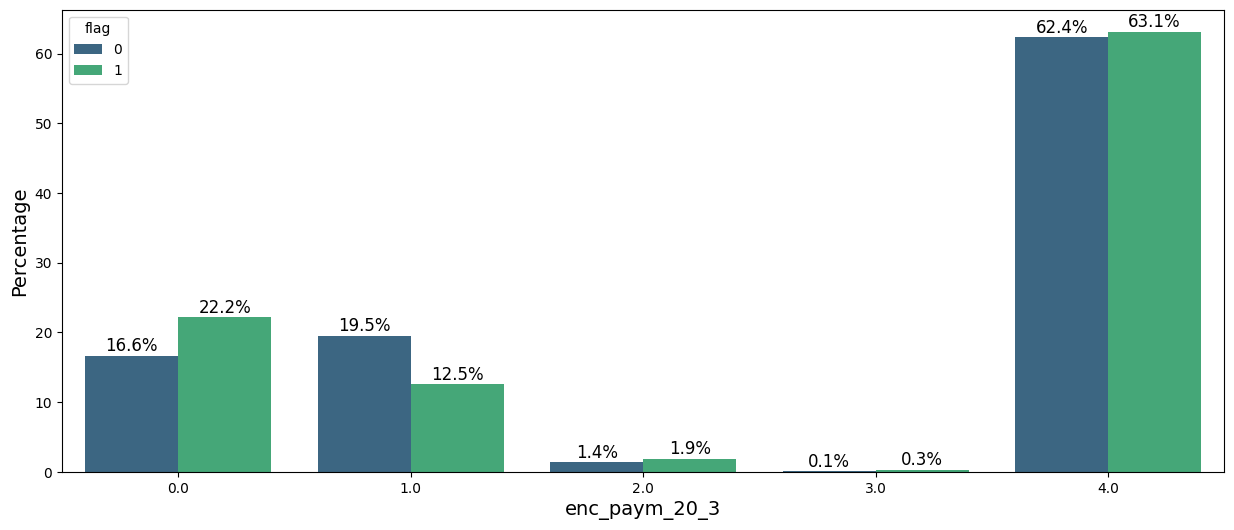

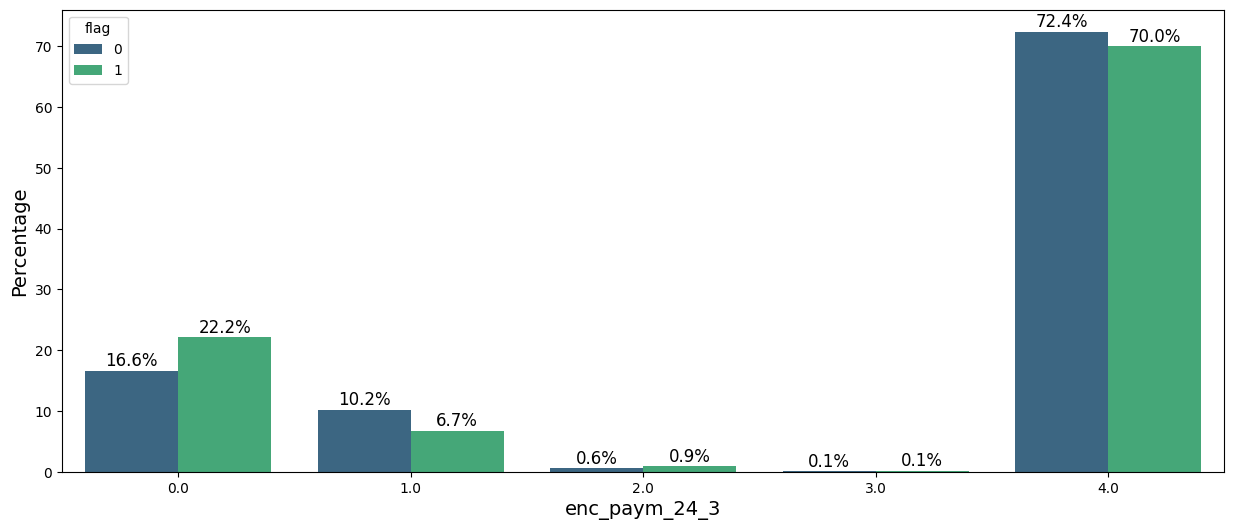

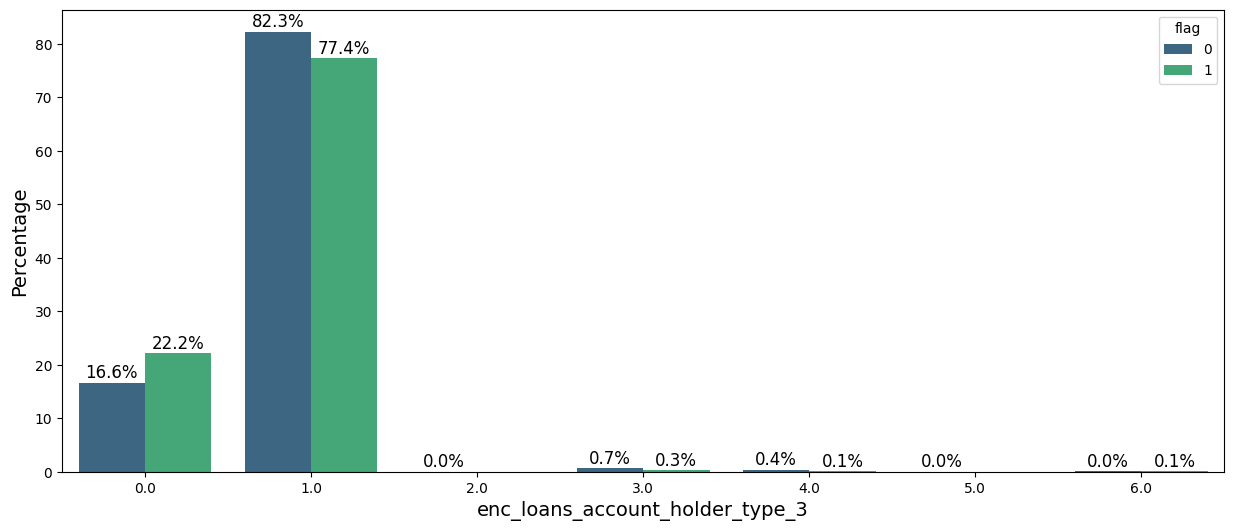

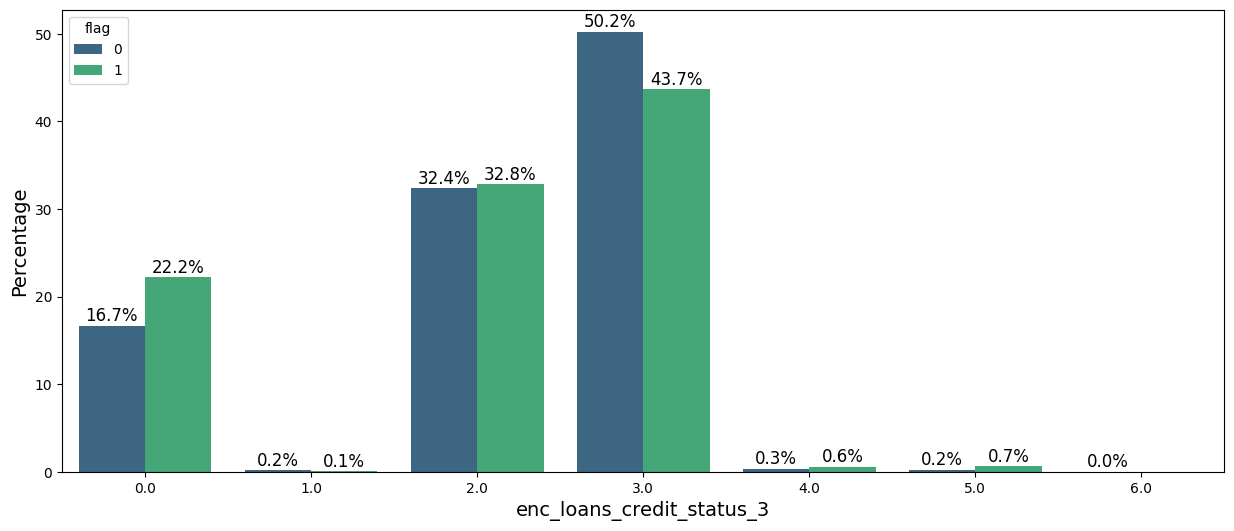

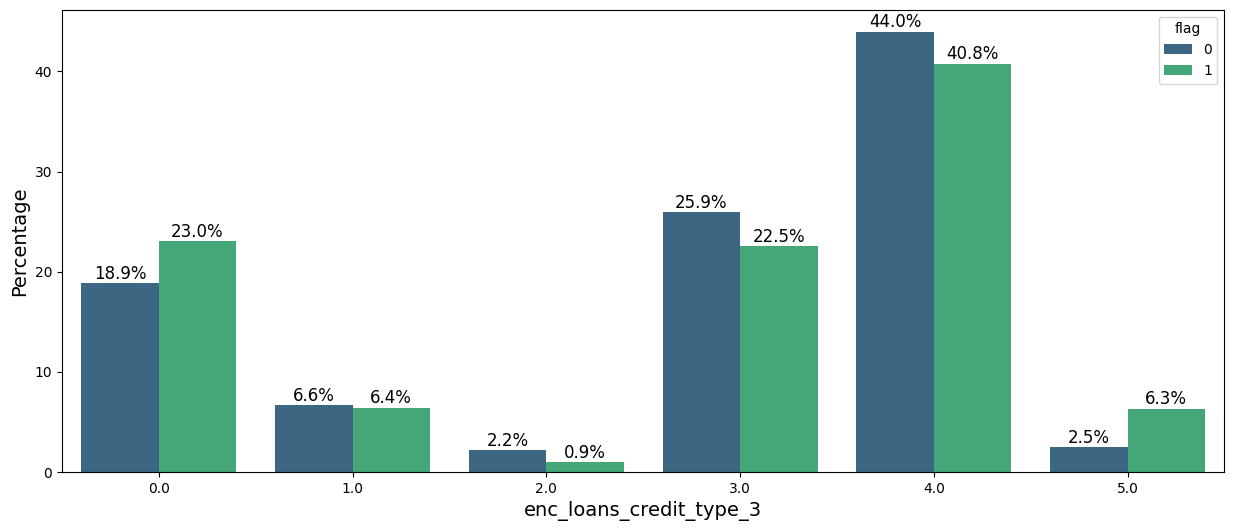

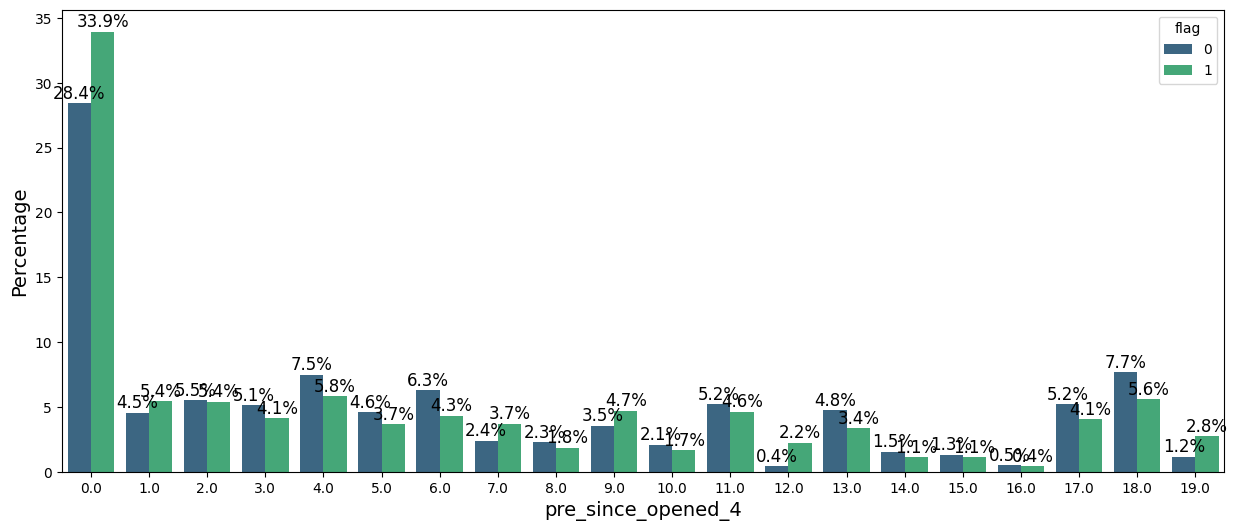

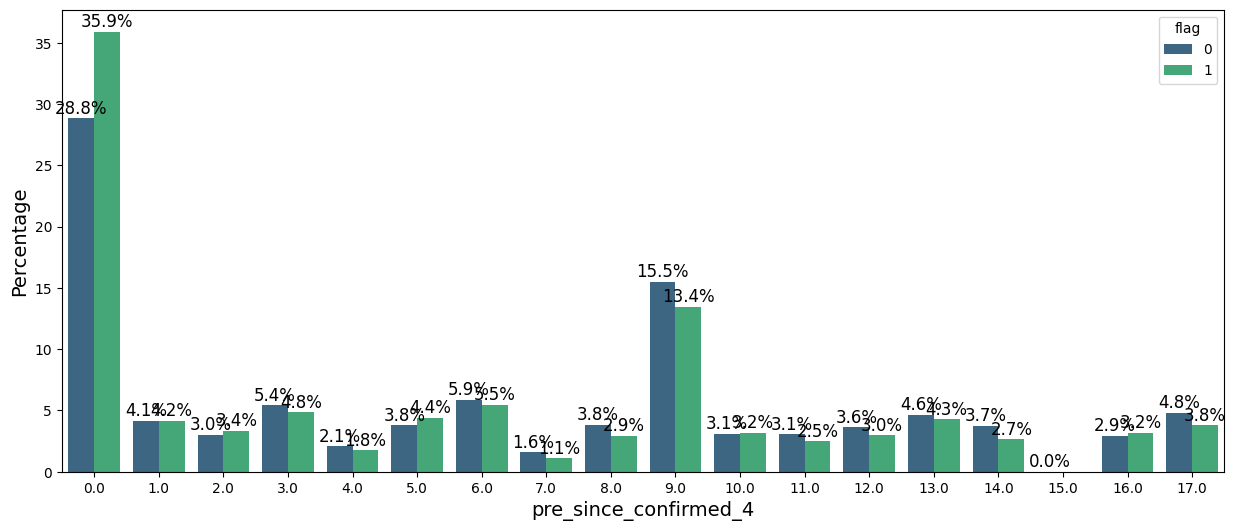

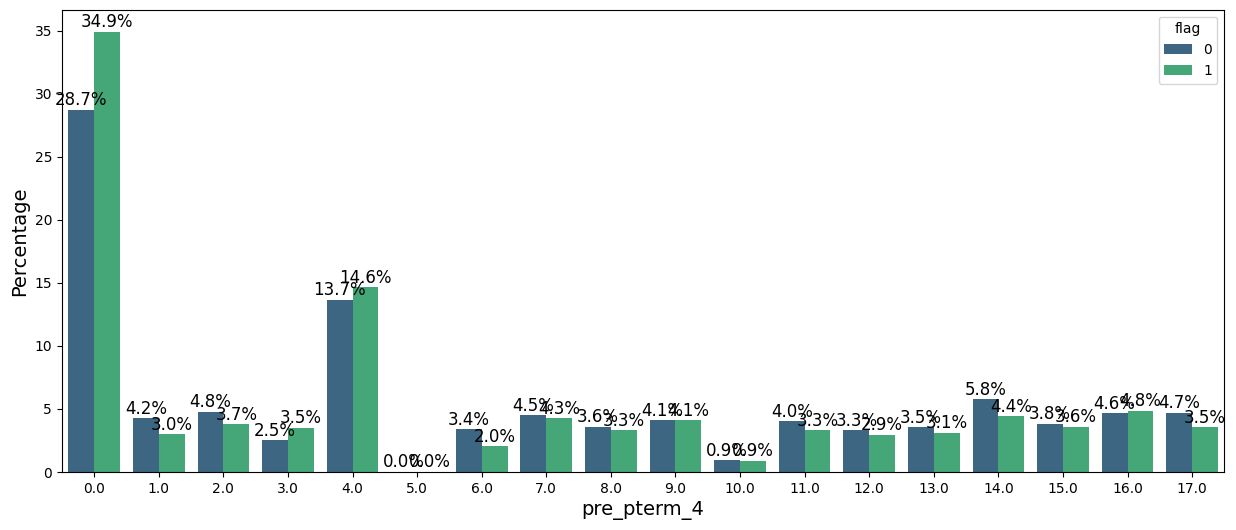

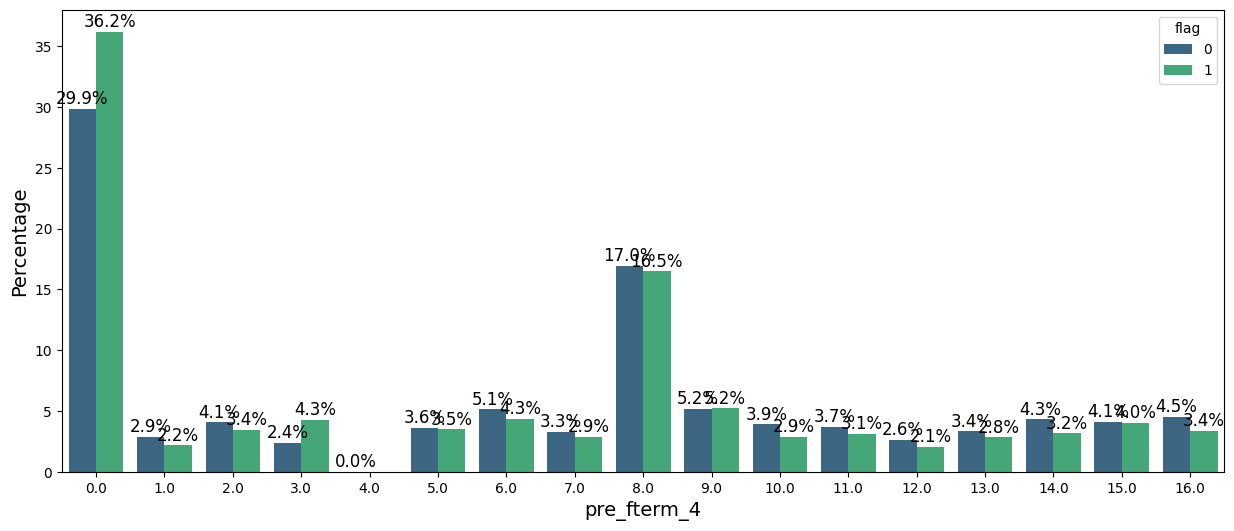

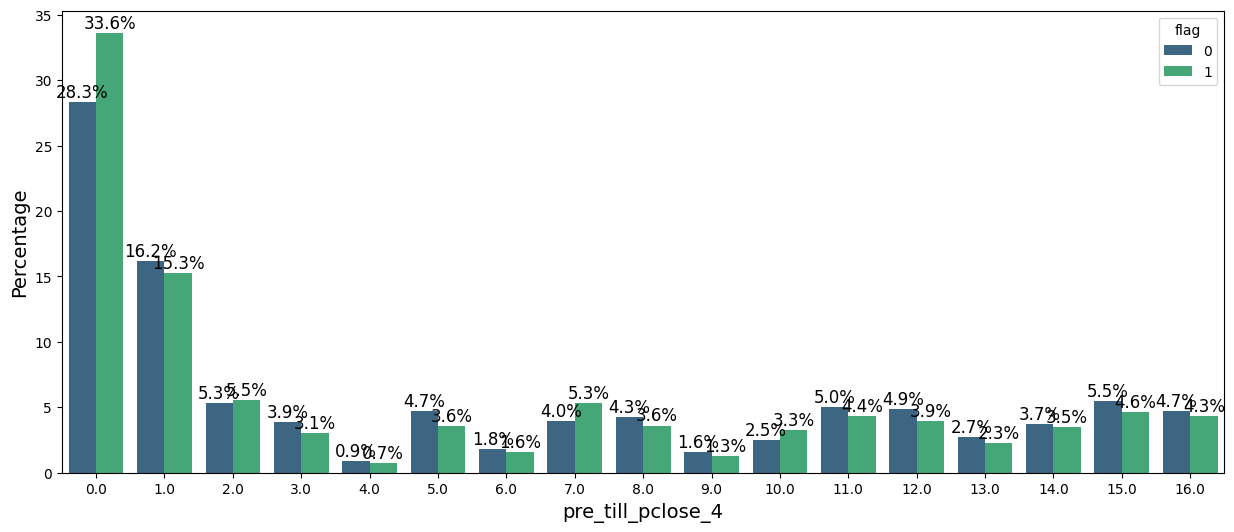

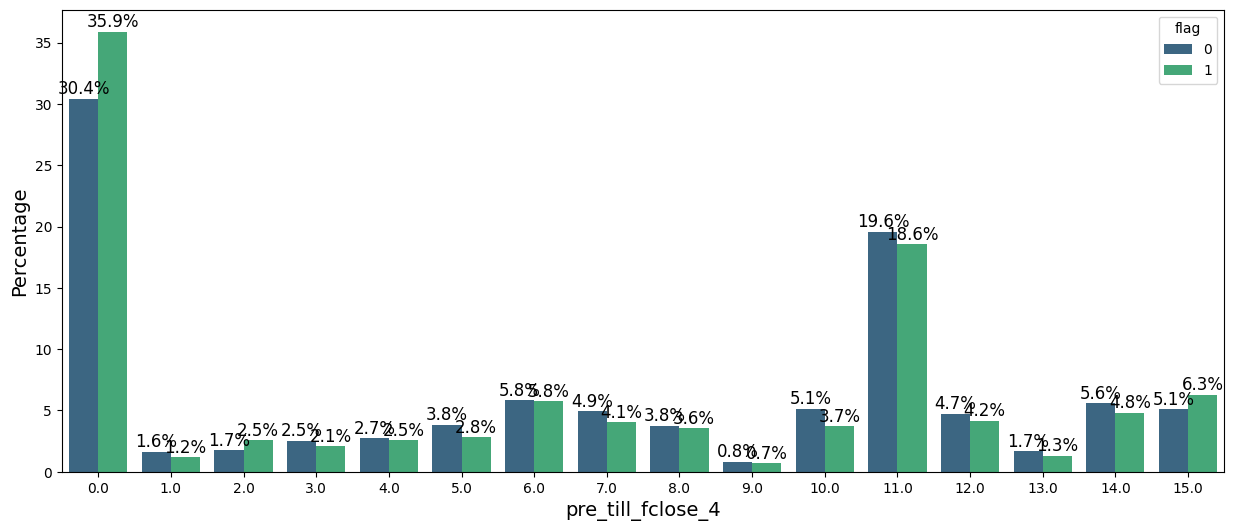

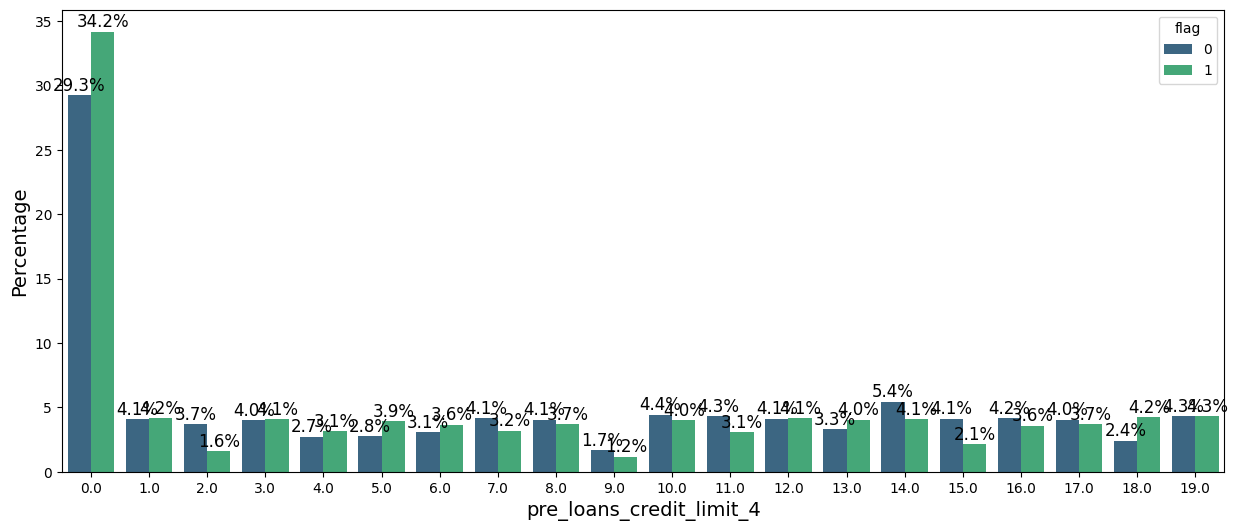

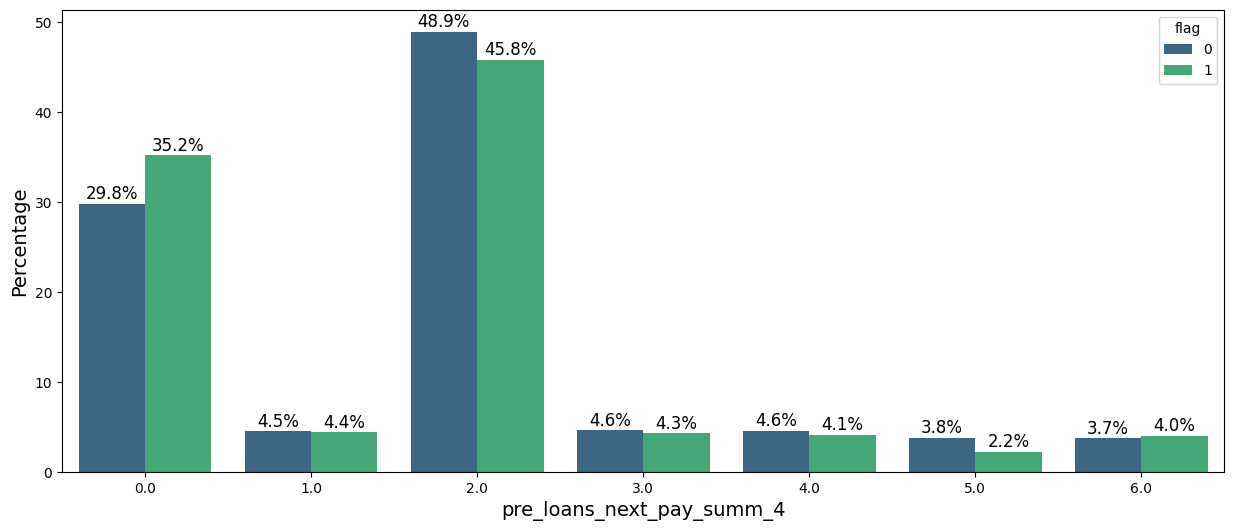

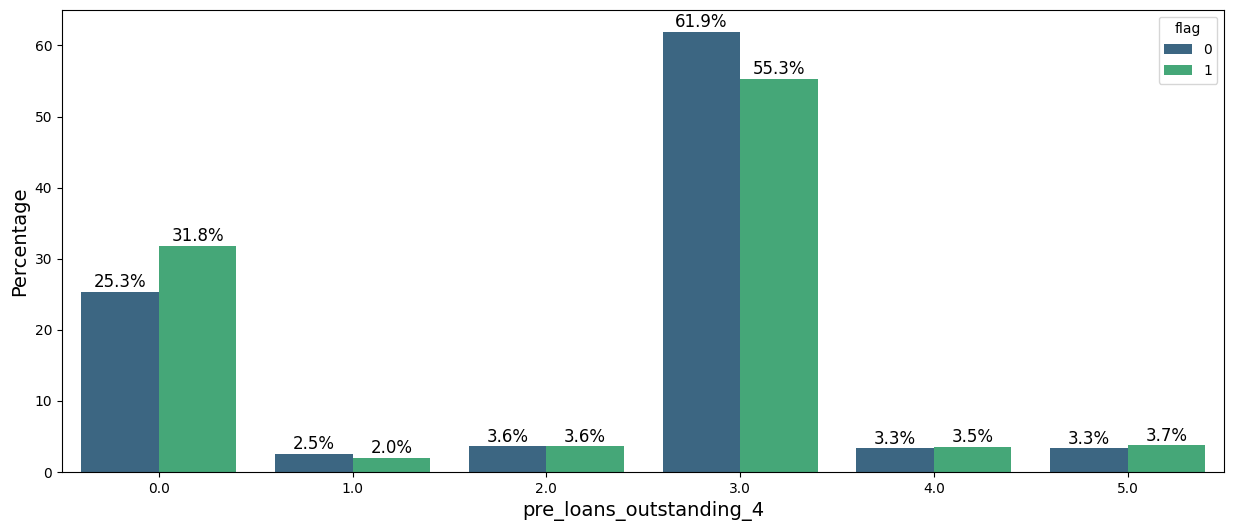

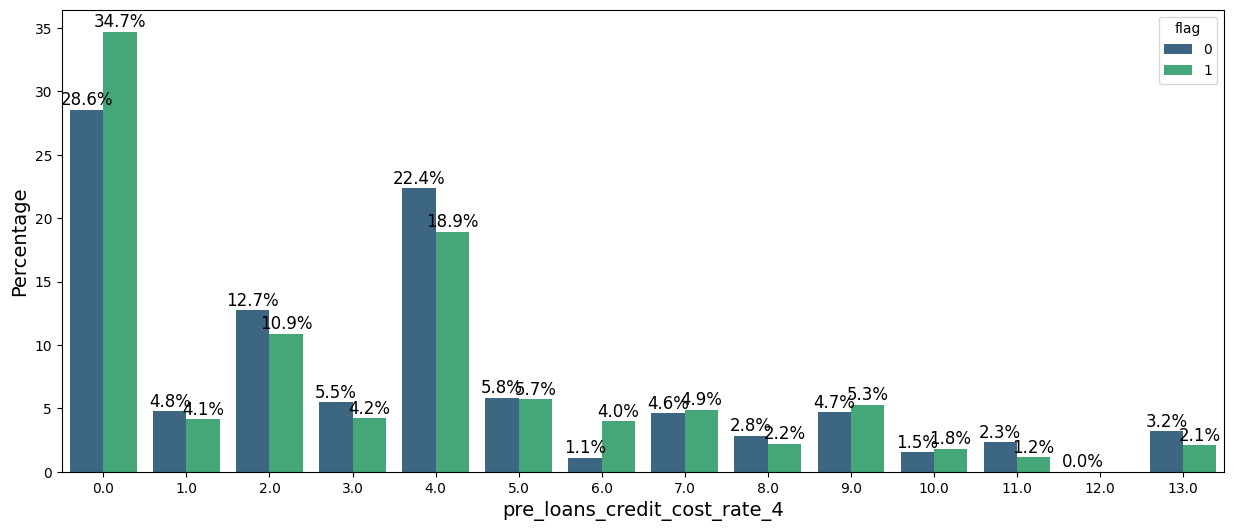

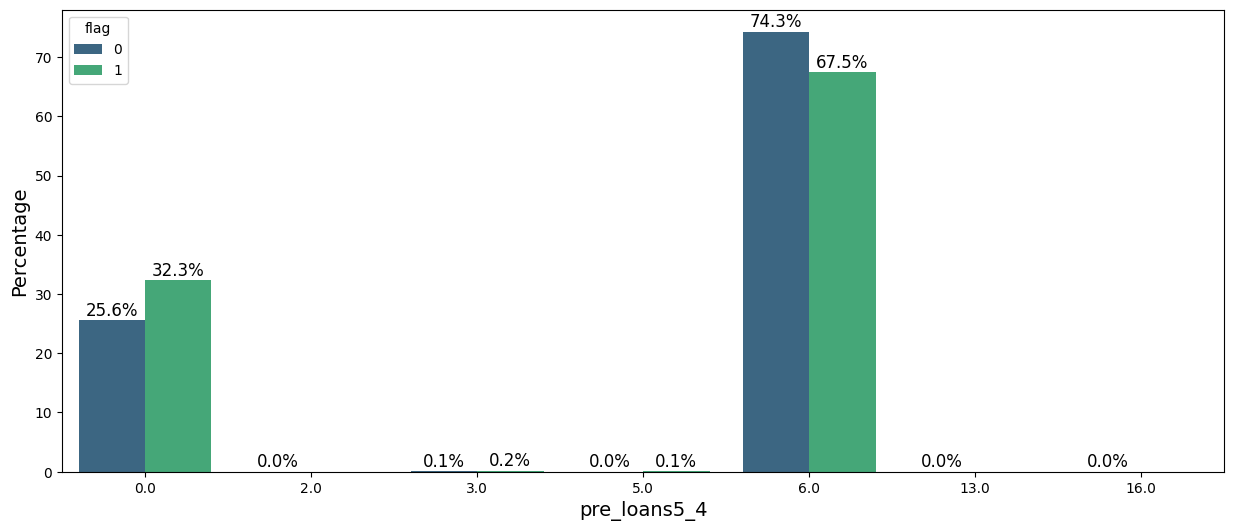

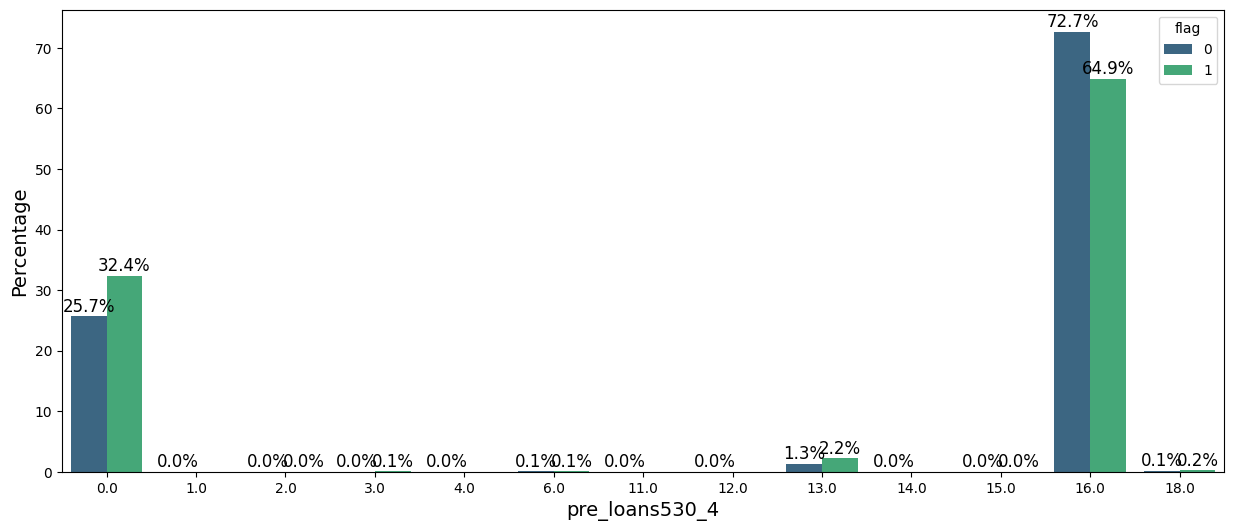

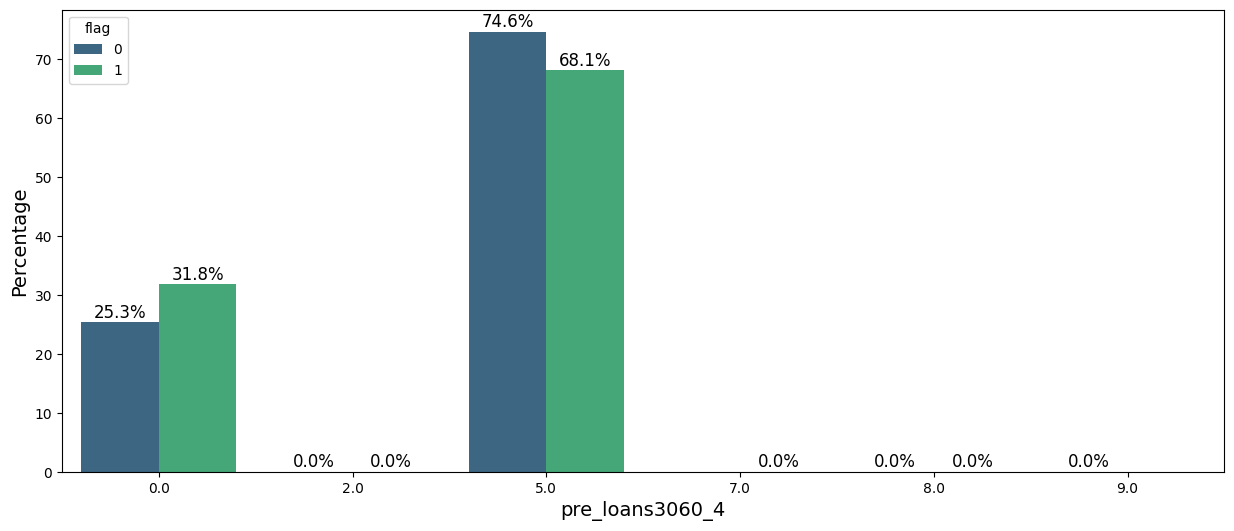

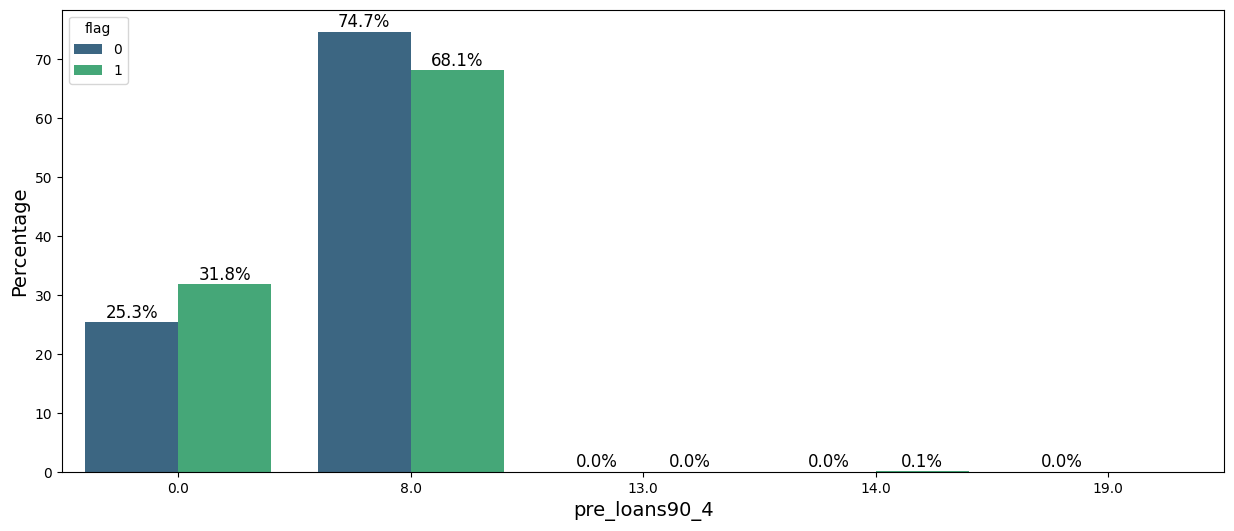

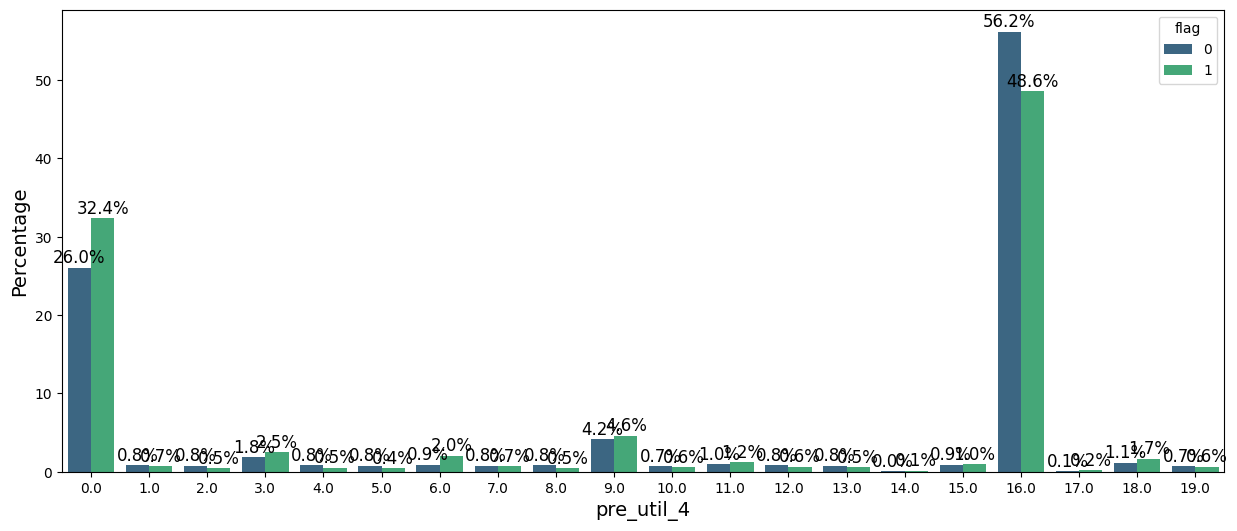

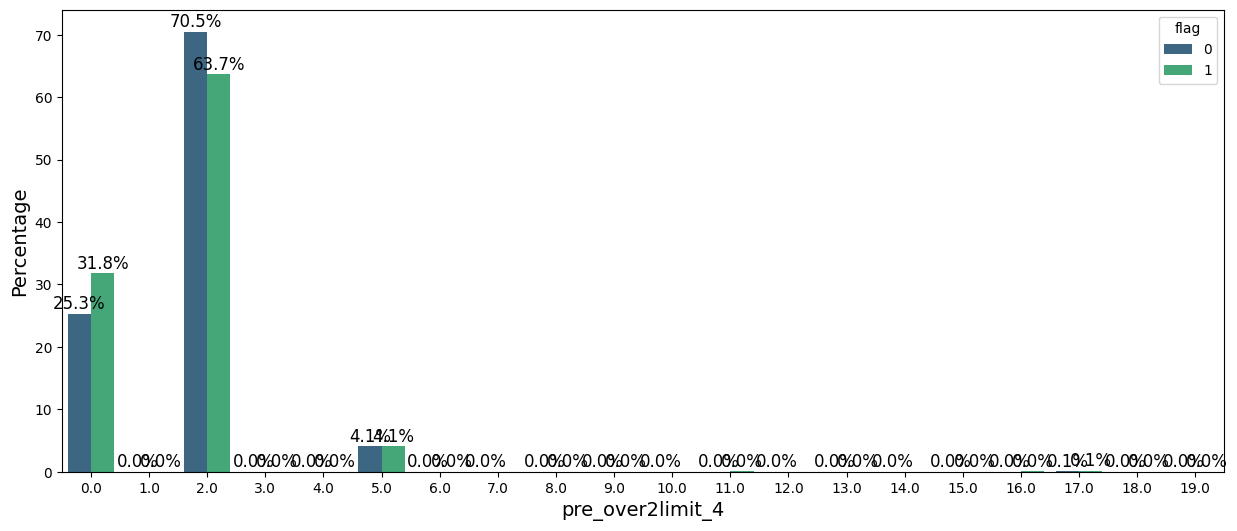

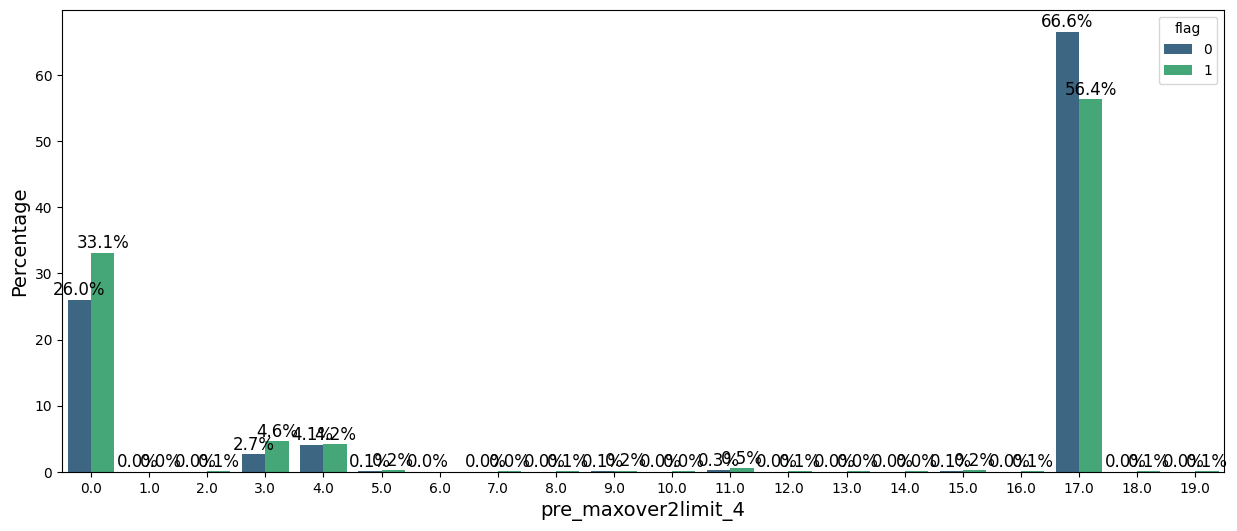

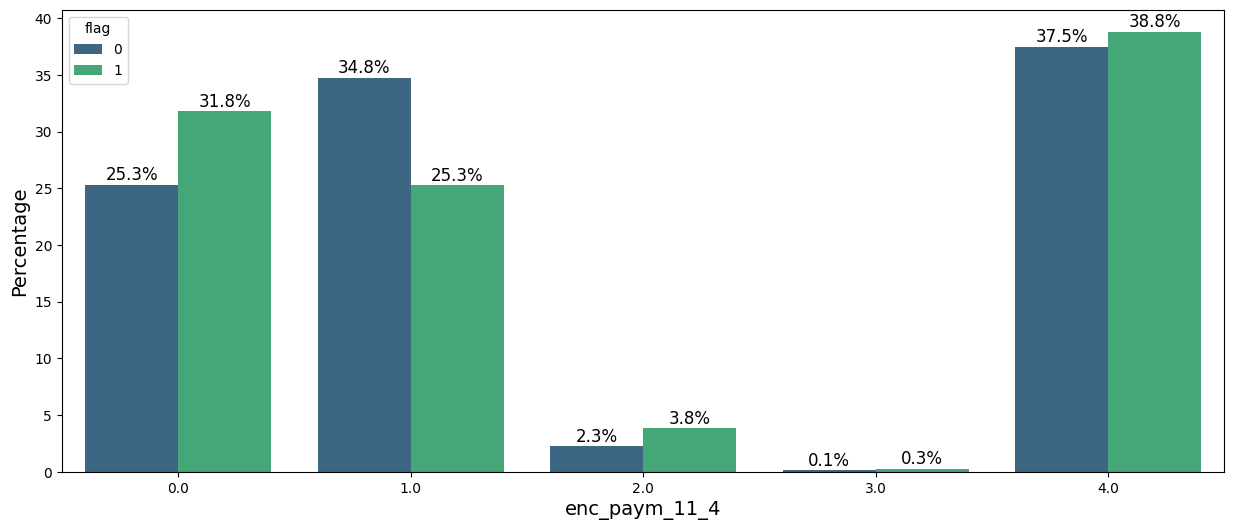

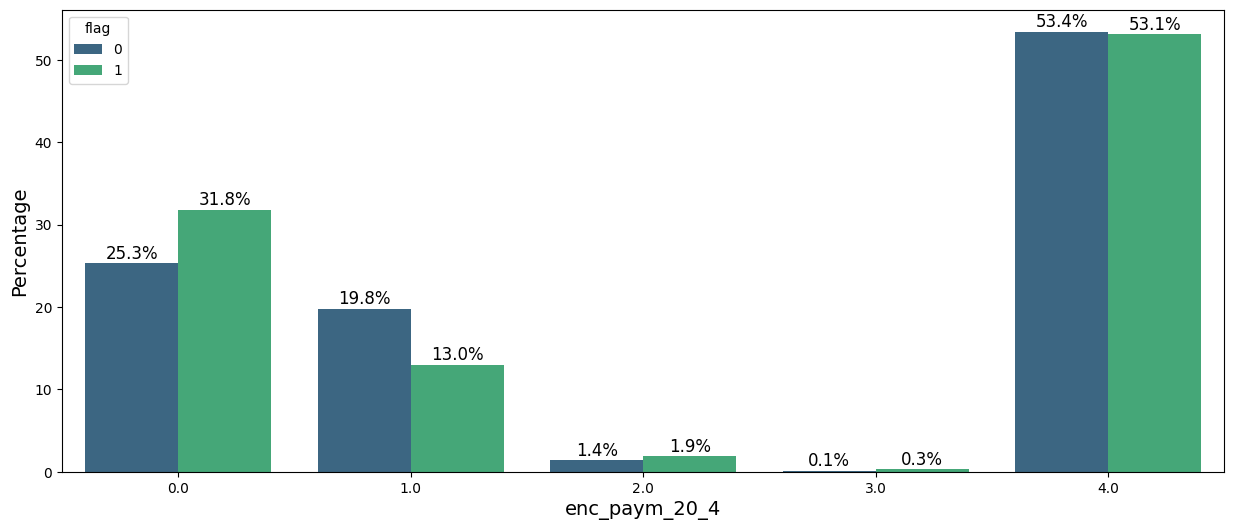

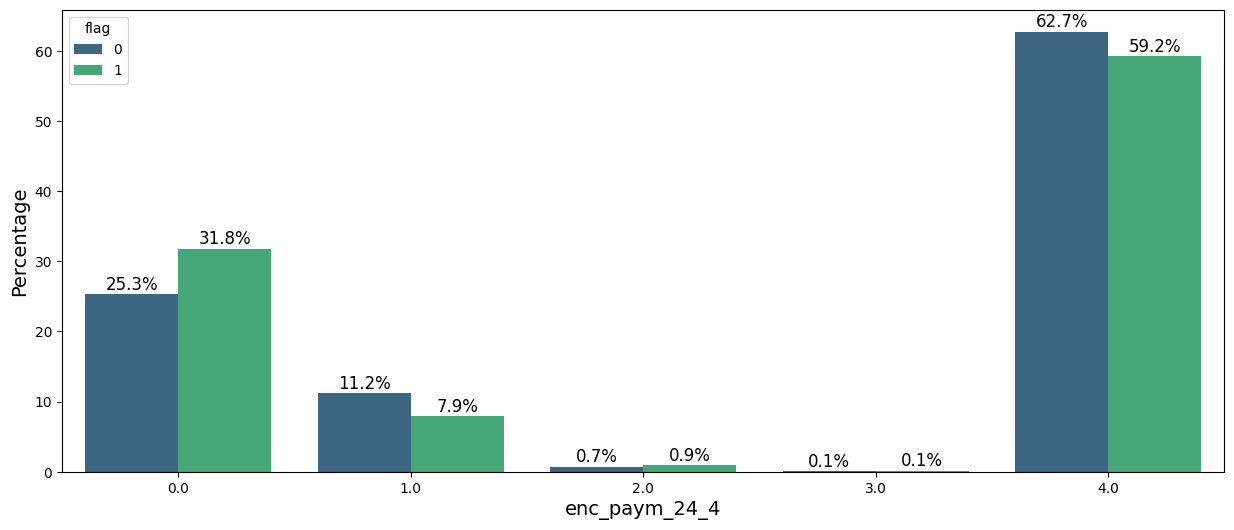

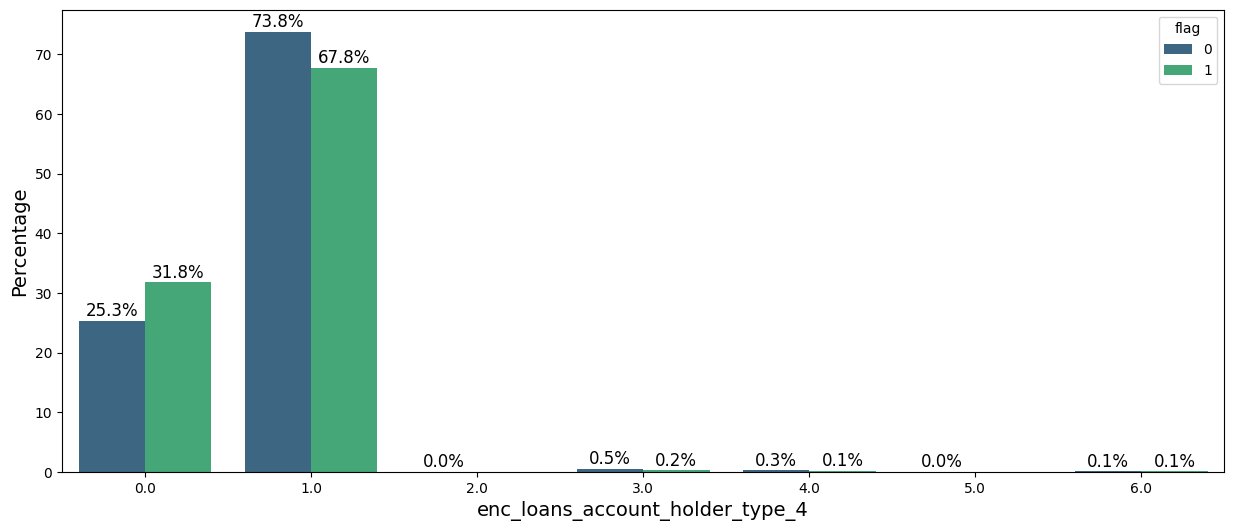

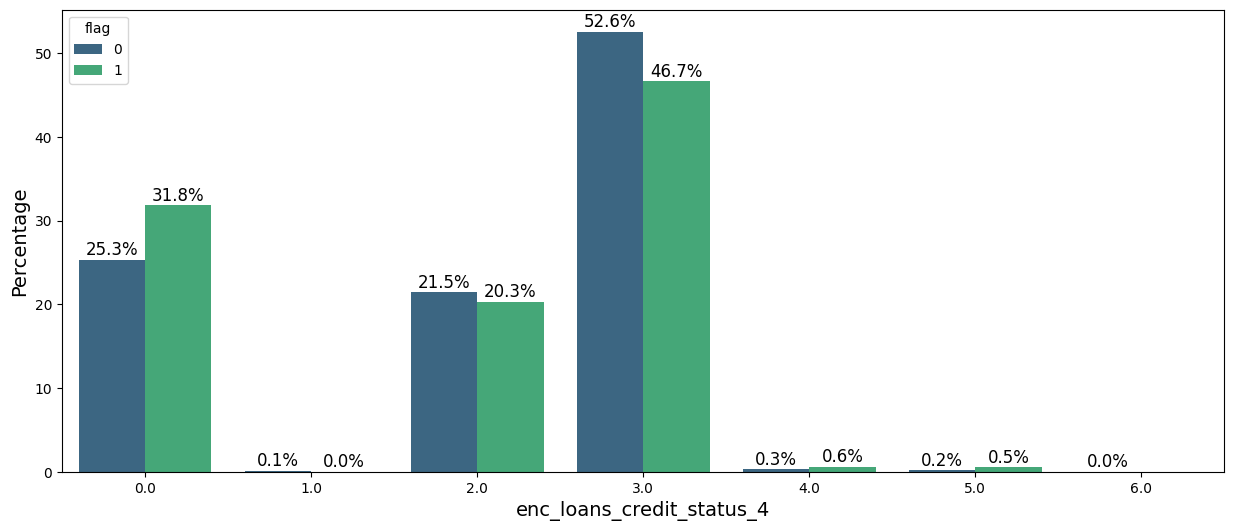

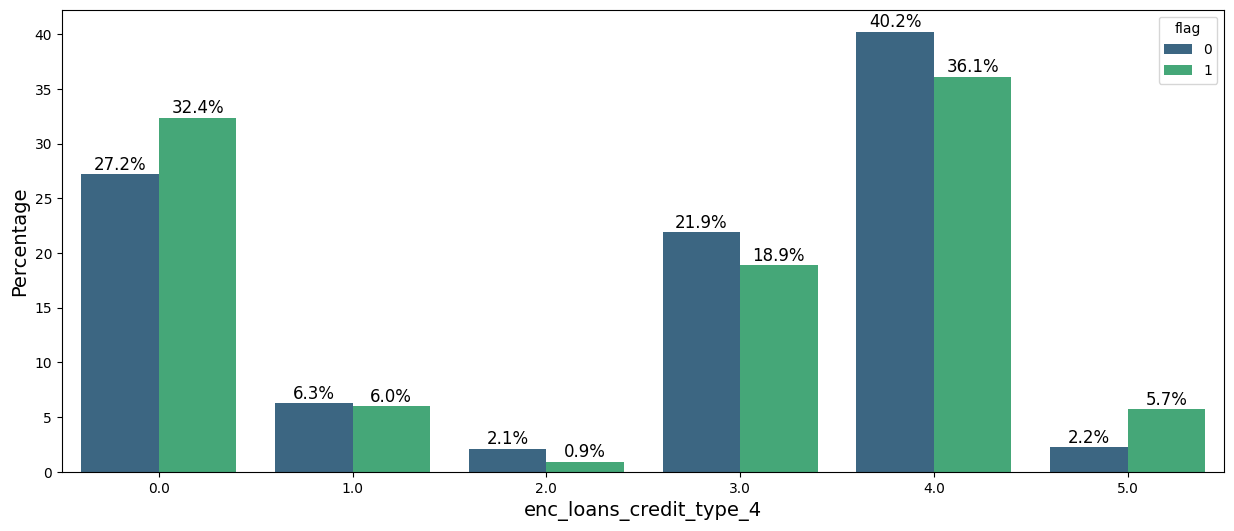

In [31]:
for col in df.nunique()[df.nunique() > 4].index:
    barplot_group(col, "flag")

In [32]:
df = df.drop(columns=["pre_loans530", 
                      "pre_maxover2limit", 
                      "enc_loans_account_holder_type",
                      "enc_loans_credit_status",
                      "pre_over2limit",
                      "pre_loans5"
                     ])

In [33]:
df[:5]

rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
id                                                                    
0   10                 7                    9          2         10   
1   14                12                    6          1          8   
2    3                12                    9          4          8   
3   15                12                    9          2         10   
4    1                12                    9          4          8   

    pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
id                                                             
0                 8                8                      16   
1                14               11                      11   
2                 1               11                       1   
3                 8                8                      17   
4                 1               11                      12   

    pre_loans_next_pay_summ  pre_loans_outstanding  ...  enc_paym_7_4  \
id                                                  ...                 
0                         4                      2  ...           0.0   
1                         2                      3  ...           3.0   
2                         1                      4  ...           0.0   
3                         1                      2  ...           0.0   
4                         1                      3  ...           0.0   

    enc_paym_8_4  enc_paym_9_4  enc_paym_11_4  enc_paym_20_4  enc_paym_24_4  \
id                                                                            
0            3.0           3.0            4.0            4.0            4.0   
1            3.0           3.0            4.0            4.0            4.0   
2            0.0           0.0            0.0            0.0            0.0   
3            0.0           0.0            4.0            4.0            4.0   
4            0.0           0.0            0.0            0.0            0.0   

    enc_loans_account_holder_type_4  enc_loans_credit_status_4  \
id                                                               
0                               1.0                        3.0   
1                               1.0                        2.0   
2                               0.0                        0.0   
3                               1.0                        2.0   
4                               0.0                        0.0   

    enc_loans_credit_type_4  enc_loans_account_cur_4  
id                                                    
0                       4.0                      1.0  
1                       4.0                      1.0  
2                       0.0                      0.0  
3                       1.0                      1.0  
4                       0.0                      0.0  

[5 rows x 183 columns]

In [34]:
#Для поиска и удаления аномальных значений будет использован алгоритм Isolation Forest
#Из-за дисбаланса классов на вход алгоритму следует подавать только операции, по которым нет дефолта
column_eif = iForest(df[df["flag"]==0].values, ntrees=300, 
                     sample_size=128, ExtensionLevel=1)

In [35]:
S1 = column_eif.compute_paths(X_in = df[df["flag"]==0].values)

indexes_eif = np.argsort(S1)[-int(len(S1) * 0.05):]
df = df.drop(index=indexes_eif)

In [36]:
df.shape

(237887, 183)

In [37]:
df.to_csv("eda.csv")

## Гипотезы

1) Заявки клиентов с высоким кредитным лимитом (pre_loans_credit_limit) по последней операции реже соответствуют дефолту  
2) Заявки клиентов с низким значение максимальной просроченной задолжности (pre_loans_max_overdue_sum) по последней операции реже соответствуют дефолту   
4) Заявки клиентов с большей кридитной историей реже соответствуют дефолту  
5) Заявки с меньшей полной стоимостью кредита (pre_loans_credit_cost_rate) реже соответствуют дефолту  
6) Заявки клиентов, у которых нет просрочек более 90 дней (is_zero_loans90) по последней операции, реже соответствуют дефолту   
8) Заявки клиентов, у которых закрыт предыдущий кредит (fclose_flag), реже соответствуют дефолту     

#### Гипотеза 1  
Заявки клиентов с высоким кредитным лимитом (pre_loans_credit_limit) по последней операции реже соответствуют дефолту

<Axes: xlabel='flag', ylabel='pre_loans_credit_limit'>

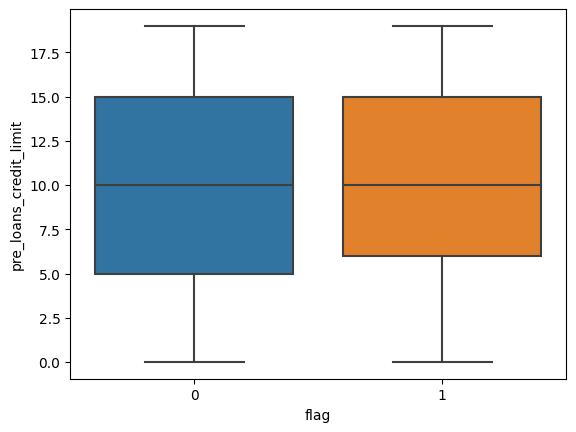

In [22]:
sns.boxplot(y=df.pre_loans_credit_limit, x=df.flag)

В данном случае, гипотезу 1 можно опровергнуть без применения статистических методов, так как из графика ее ложность очевидна.

#### Гипотеза 2  
Заявки клиентов с низким значение максимальной просроченной задолжности (pre_loans_max_overdue_sum) по последней операции реже соответствуют дефолту

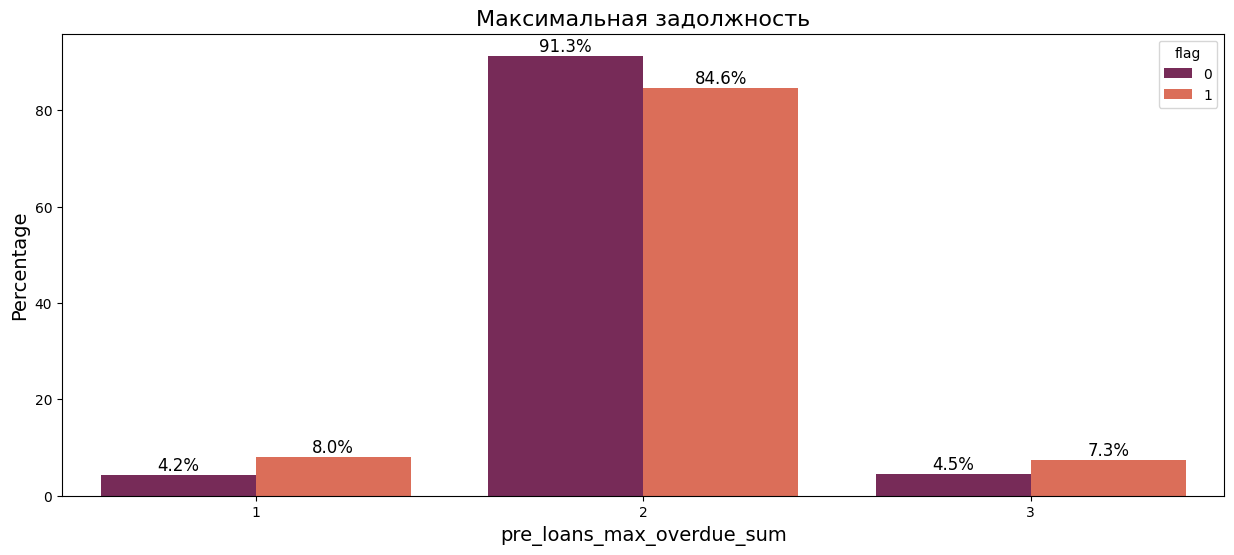

In [55]:
barplot_group("pre_loans_max_overdue_sum", "flag", "Максимальная задолжность")

#### Гипотеза 4
Заявки клиентов с большей кридитной историей реже соответствуют дефолту

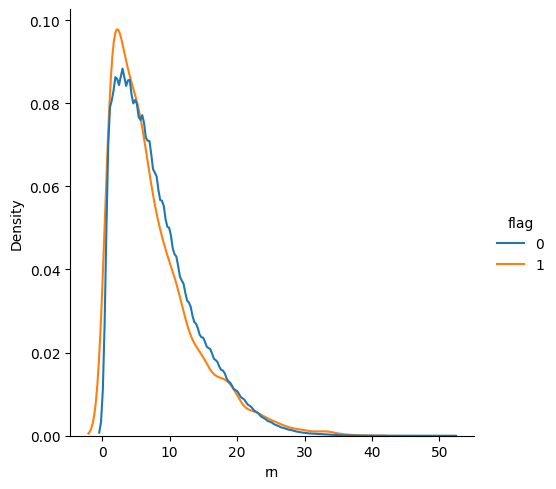

In [73]:
sns.displot(x=df.rn, hue=df.flag, kind='kde', common_norm=False)

<Axes: xlabel='flag', ylabel='rn'>

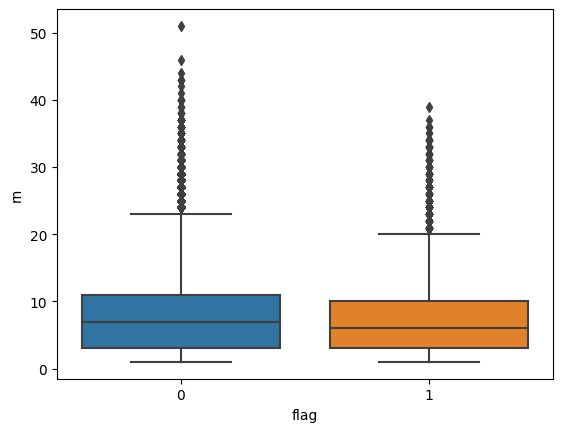

In [74]:
sns.boxplot(x=df.flag, y=df.rn)

#### Гипотеза 6  
Заявки клиентов, у которых нет просрочек более 90 дней (is_zero_loans90) по последней операции, реже соответствуют дефолту  

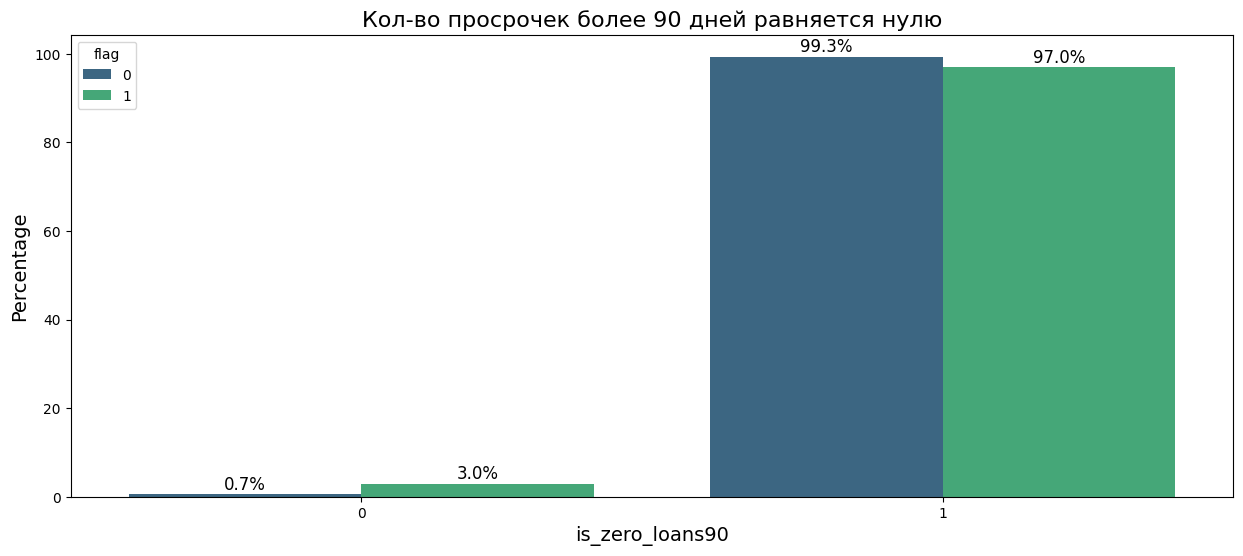

In [69]:
barplot_group("is_zero_loans90", "flag", "Кол-во просрочек более 90 дней равняется нулю")

#### Гипотеза 8  
Заявки клиентов, у которых закрыт предыдущий кредит (fclose_flag), реже соответствуют дефолту  

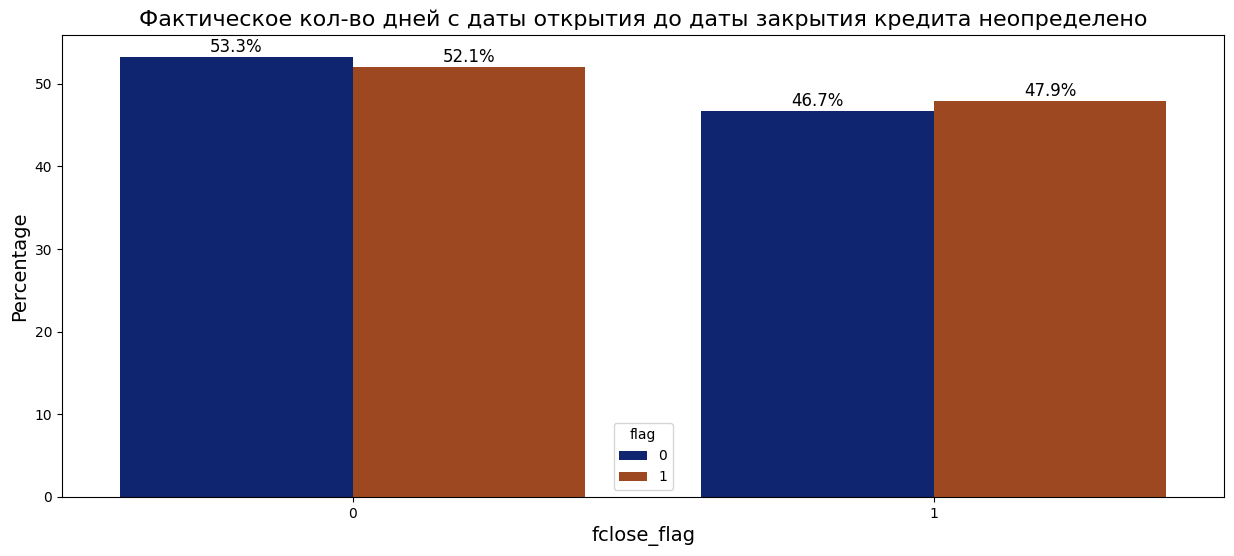

In [62]:
barplot_group('fclose_flag', 'flag', 
              "Фактическое кол-во дней с даты открытия до даты закрытия кредита неопределено")

Гипотеза не подтвердилась, так как существенных различий между заявками, соответвующим и не соответствующим дефолту, в разрезе закрытия предыдущего кредита не наблюдается